## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Import Packages

In [433]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os.path
from scipy.linalg import lstsq, solve
%matplotlib qt
%matplotlib inline

## Conversion parameters

In [434]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension

# meters per pixel in x dimension 
# 600 is the actual lane line distance in pixels derived from the perspective transformed image
xm_per_pix = 3.7/600

### Keep track of all interesting parameters

In [435]:
imshape = (720,1280)
MAX_bad_frames = 8

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = None
        #polynomial coefficients of the last n fits of the line
        self.recent_fit = []
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #average radius of curvature
        self.avg_curverad = None
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #average center of car with respect to center of image
        self.offset = None
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  
        #reset flag; set if prior search approach is used
        self.reset = True
        #invalid_counter (list) for frames in a row -> if element is accepted: False, otherwise True
        self.invalid_counter = list(np.full((MAX_bad_frames+1,),True))
        self.invalid_counter[-1] = False
        
    def update_params(self,fitx,ploty,current_coeffs,curverad,avg_curverad,offset,x,y):
        self.recent_xfitted.append(fitx[:,np.newaxis])
        self.bestx = np.mean(np.concatenate(self.recent_xfitted,axis=1),axis=1)
        self.current_fit = current_coeffs
        self.recent_fit.append(self.current_fit[:,np.newaxis])
        self.best_fit = np.mean(np.concatenate(self.recent_fit,axis=1),axis=1)
        self.radius_of_curvature = curverad
        self.line_base_pos = self.calc_dist_center_line(offset)
        self.diffs = np.abs(current_coeffs-self.best_fit)
        self.allx = x
        self.ally = y
        self.avg_curverad = avg_curverad
        self.offset = offset
        
    def calc_dist_center_line(self,offset):
        #calculate the center of image
        img_center = np.int(imshape[1]//2)
        
        return np.absolute(img_center*xm_per_pix-offset-self.recent_xfitted[-1][-1]*xm_per_pix)
    
    def check_bad_frame(self,valid_flag):
        """
        Checks if current solution is rejected; Mark self.invalid_counter for each rejection with True, otherwise False
        If MAX_bad_frames is exceeded start searching from scratch for the polynomial
        """
        
        if not valid_flag:
            self.invalid_counter[-1] = True
            bad_counter = list(filter(lambda x: x==True, self.invalid_counter))
            if len(bad_counter) > MAX_bad_frames:
                print("Bad counter exceeded!!")
                self.reset = True
                #include only last confident fit into computation of subsequent mean fit
                try:
                    temp = self.recent_xfitted[-1]
                    self.recent_xfitted = []
                    self.recent_xfitted.append(temp)
                except IndexError:
                    pass
                #include only last confident polynomial into computation of subsequent mean polynomial
                try:
                    temp = self.recent_fit[-1]
                    self.recent_fit = []
                    self.recent_fit.append(temp)
                except:
                    pass

        self.invalid_counter.pop(0)
        self.invalid_counter.append(False)

        

## Helper Functions

In [436]:
def cal_undistort(img, objpoints, imgpoints):
    """computes the camera calibration matrix and distortion coefficients
    and applies distortion correction to an image"""
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    #return undistorted image, calibration matrix and distortion coefficients
    return undist, mtx, dist


def color_gradient_thresholding(img, s_thresh=(170, 255), sobel_kernel=3, thresh=(20, 100), thresh_mag=(30,100), thresh_dir=(0, np.pi/2)):
    """applies color and gradient thresholding to image in order to create
    a binary image which likely contains lane-line pixels"""
    
    #calculate x gradient thresholded image
    gradx_binary = abs_sobel_thresh(img, orient='x', sobel_kernel=sobel_kernel, thresh=thresh)
    #print("Sobelx, Gradient threshold:")
    #plt.imshow(gradx_binary,cmap='gray')
    #plt.show()
    
    #calculate y gradient thresholded image
    grady_binary = abs_sobel_thresh(img, orient='y', sobel_kernel=sobel_kernel, thresh=thresh)
    #print("Sobely, Gradient threshold:")
    #plt.imshow(grady_binary,cmap='gray')
    #plt.show()
    
    #calculate gradient magnitude thresholded image
    mag_binary = mag_thresh(img, sobel_kernel=sobel_kernel, thresh_mag=thresh_mag)
    #print("Gradient mag threshold:")
    #plt.imshow(mag_binary,cmap='gray')
    #plt.show()
    
    #calculate gradient direction thresholded image
    dir_binary = dir_threshold(img, sobel_kernel=sobel_kernel, thresh_dir=thresh_dir)
    #print("Gradient dir threshold:")
    #plt.imshow(dir_binary,cmap='gray')
    #plt.show()
    
    #combining gradient threshold techniques
    combined_grad_binary = np.zeros_like(dir_binary)
    combined_grad_binary[((gradx_binary == 1) & (grady_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    #print("Combined grad threshold:")
    #plt.imshow(combined_grad_binary,cmap='gray')
    #plt.show()
    
    
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    #print("S channel:")
    #plt.imshow(s_channel,cmap='gray')
    #plt.show()
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    #print("S threshold:")
    #plt.imshow(s_binary,cmap='gray')
    #plt.show()
    
    # Combine the two binary thresholds (gradient threshold and S channel threshold)
    combined_binary = np.zeros_like(gradx_binary)
    combined_binary[(s_binary == 1) | (combined_grad_binary == 1)] = 1
    
    return combined_binary



def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 100)):
    """Compute directional gradient, apply threshold"""
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #print("Grayscale image:")
    #plt.imshow(gray,cmap='gray')
    #plt.show()
    
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
        
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return grad_binary


def mag_thresh(img, sobel_kernel=3, thresh_mag=(30, 100)):
    """Compute gradient magnitude, apply threshold"""
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= thresh_mag[0]) & (gradmag <= thresh_mag[1])] = 1

    # Return the binary image
    return mag_binary


def dir_threshold(img, sobel_kernel=3, thresh_dir=(0.7, 1.3)):
    """Compute gradient direction, apply threshold"""
    
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh_dir[0]) & (absgraddir <= thresh_dir[1])] = 1

    # Return the binary image
    return dir_binary


def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def calc_intersections(imshape, p_left, p_right):
    """calculates the intersection coordinates of full lane lines with ROI"""
    
    bottom_left_lane_y = imshape[0] -1
    bottom_left_lane_x = int((bottom_left_lane_y - p_left[0])/p_left[1])
    top_left_lane_y = 470
    top_left_lane_x = int((top_left_lane_y - p_left[0])/p_left[1])
    bottom_right_lane_y = imshape[0] -1
    bottom_right_lane_x = int((bottom_right_lane_y - p_right[0])/p_right[1])
    top_right_lane_y = 470
    top_right_lane_x = int((top_right_lane_y - p_right[0])/p_right[1])
    
    #create a list of tuples each containing an intersection point with coordinates (x,y)
    intersection_vertices = [(bottom_left_lane_x,bottom_left_lane_y),(top_left_lane_x,top_left_lane_y),\
                            (top_right_lane_x,top_right_lane_y),(bottom_right_lane_x,bottom_right_lane_y)]
    
    return intersection_vertices


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    
    addition: Returns intersection vertices with region of interest
    """
    
    #drawing line segments to img
    '''
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    '''
    
    imshape = img.shape
    
    x_left_lane = []
    x_right_lane = []
    y_left_lane = []
    y_right_lane = []
    
    #extension of line segments to full lines
    for line in lines:
        for x1,y1,x2,y2 in line:
            
            #compute slope of each line segment
            m = (y2 - y1)/(x2 - x1)
            
            #distinguish left lane points from right lane points
            if m < 0:
                x_left_lane.append(x1)
                y_left_lane.append(y1)
                x_left_lane.append(x2)
                y_left_lane.append(y2)
                
            elif m > 0:
                x_right_lane.append(x1)
                y_right_lane.append(y1)
                x_right_lane.append(x2)
                y_right_lane.append(y2)
    
    
    #full lines are obtained by solving a ordinary least squares problem mx+b
    #create design matrix M
    M_left_lane = np.array(x_left_lane)[:, np.newaxis]**[0, 1]
    M_right_lane = np.array(x_right_lane)[:, np.newaxis]**[0, 1]
    
    #run least squares
    #p is the vector containing the parameters b and m
    p_left_lane, res, rnk, s = lstsq(M_left_lane, np.array(y_left_lane))
    p_right_lane, res, rnk, s = lstsq(M_right_lane, np.array(y_right_lane))
    
    
    #compute bottom and top intersections of full lane lines with region of interest
    intersection_vertices = calc_intersections(imshape, p_left_lane, p_right_lane)
    
    #draw full lane lines onto image from bottom to top of region of interest
    cv2.line(img, (intersection_vertices[0][0], intersection_vertices[0][1]), (intersection_vertices[1][0], intersection_vertices[1][1]), color, thickness)
    cv2.line(img, (intersection_vertices[3][0], intersection_vertices[3][1]), (intersection_vertices[2][0], intersection_vertices[2][1]), color, thickness)
    
    #horizontal lines
    cv2.line(img, (intersection_vertices[0][0], intersection_vertices[0][1]), (intersection_vertices[3][0], intersection_vertices[3][1]), color, thickness)
    cv2.line(img, (intersection_vertices[1][0], intersection_vertices[1][1]), (intersection_vertices[2][0], intersection_vertices[2][1]), color, thickness)
    
    return intersection_vertices
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn; intersection vertices.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    intersection_vertices = draw_lines(line_img, lines)

    return line_img, intersection_vertices


def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)


def calc_perspective_trans_warp(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped, M


def find_peaks_hist(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    return leftx_base, rightx_base


def find_lane_pixels(binary_warped):
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 30
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    #Choose the width of the margin around the previous polynomial to search
    margin_prior_search = 100
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    
    #search from prior using previous polynomial coefficients
    if not left_lane.reset and not right_lane.reset:
        print("Search from prior!!!")
        
        left_lane_inds = ((nonzerox > (left_lane.recent_fit[-1][0,0]*(nonzeroy**2) + left_lane.recent_fit[-1][1,0]*nonzeroy + 
                    left_lane.recent_fit[-1][2,0] - margin_prior_search)) & (nonzerox < (left_lane.recent_fit[-1][0,0]*(nonzeroy**2) + 
                    left_lane.recent_fit[-1][1,0]*nonzeroy + left_lane.recent_fit[-1][2,0] + margin_prior_search)))
        right_lane_inds = ((nonzerox > (right_lane.recent_fit[-1][0,0]*(nonzeroy**2) + right_lane.recent_fit[-1][1,0]*nonzeroy + 
                    right_lane.recent_fit[-1][2,0] - margin_prior_search)) & (nonzerox < (right_lane.recent_fit[-1][0,0]*(nonzeroy**2) + 
                    right_lane.recent_fit[-1][1,0]*nonzeroy + right_lane.recent_fit[-1][2,0] + margin_prior_search)))
        
    
    #search from scratch using histogram and sliding window approach
    else:
        print("Search from scratch!!!")
        #find the peaks of lane-line pixels with respect to x (starting points for lane lines)
        leftx_base, rightx_base = find_peaks_hist(binary_warped)

        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(binary_warped.shape[0]//nwindows)

        # Current positions to be updated later for each window in nwindows
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            ### Find the four below boundaries of the window ###
            win_xleft_low = leftx_current - margin  # Update this
            win_xleft_high = leftx_current + margin  # Update this
            win_xright_low = rightx_current - margin  # Update this
            win_xright_high = rightx_current + margin  # Update this

            # Draw the windows on the visualization image
            '''
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2)
            '''


            ### Identify the nonzero pixels in x and y within the window ###
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            ### If you found > minpix pixels, recenter next window ###
            ### (`right` or `leftx_current`) on their mean position ###
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass

        #set reset flags back to False
        left_lane.reset = False
        right_lane.reset = False
        
        
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img



def fit_polynomial(binary_warped,leftx,lefty,rightx,righty,out_img):

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty


    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    draw_points_left = (np.asarray([left_fitx, ploty]).T).astype(np.int32)   # needs to be int32 and transposed
    draw_points_right = (np.asarray([right_fitx, ploty]).T).astype(np.int32)   # needs to be int32 and transposed
    cv2.polylines(out_img, [draw_points_left], False, (0,255,0))  # args: image, points, closed, color
    cv2.polylines(out_img, [draw_points_right], False, (0,255,0))

    return out_img, left_fitx, right_fitx, ploty, left_fit, right_fit


def measure_curvature_real(binary_warped, leftx, lefty, rightx, righty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    
    # Find our lane pixels first
    #leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    # Fit a second order polynomial to pixel positions in each lane line
    ##### Fit new polynomials to x,y in world space #####
    ##### Utilize `ym_per_pix` & `xm_per_pix` here #####
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = binary_warped.shape[0]-1
    
    ##### Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = np.int(((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0]))
    right_curverad = np.int(((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0]))
    
    return left_curverad, right_curverad, np.int((left_curverad + right_curverad)//2)


def measure_position_real(binary_warped,left_fitx,right_fitx):
    '''
    Calculates  the position of the car with respect to the center of the image in meters.
    '''
    
    #find base positions for left and right lane in pixels
    leftx_base = left_fitx[-1]
    rightx_base = right_fitx[-1]
    
    #compute midpoint of lane in pixels
    midpoint = np.int((rightx_base + leftx_base)//2)
    
    #find the center of the image in pixels
    center = np.int(binary_warped.shape[1]//2)
    
    #calculate deviation between center of image and midpoint of lane in pixels
    offset = center - midpoint
    
    #conversion from pixel space to real world space
    offset = offset*xm_per_pix
    
    return offset


def visualization_lane_bounds(Minv, original_img, left_fitx, right_fitx, ploty, avg_curverad, offset):
    '''
    Warps back the fitted lines onto the original (undistorted) image for identification of lane boundaries 
    Radius of curvature and position of car with respect to center is also displayed
    '''
    
    # Create an image to draw the lines on
    warp_zero = np.zeros(original_img.shape[:2]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    unwarped = cv2.warpPerspective(color_warp, Minv, (original_img.shape[1], original_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(original_img, 1, unwarped, 0.3, 0)
    
    #plt.text(50, 100, "Radius of Curvature = {}(m)\n".format(avg_curverad))
    cv2.putText(result,"Radius of Curvature = {}(m)".format(avg_curverad),(50,100),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255)) 
    if np.sign(offset) == 1.:
        cv2.putText(result,"Vehicle is {:.2f}m left of center".format(np.abs(offset)),(50,150),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255))
    elif np.sign(offset) == -1.:
        cv2.putText(result,"Vehicle is {:.2f}m right of center".format(np.abs(offset)),(50,150),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255))

    
    return result


def sanity_check(left_curverad,right_curverad,fitx_left,fitx_right,ploty):
    """
    Performs a sanity check whether detected lane lines are accepted
    Based on three checks:
    1. check correspondence of both curvatures
    2. check that lines are separated by approximately the right distance horizontally
    3. check that both lines have nearly the same slope
    """
    
    curvature_flag = check_curvatures(left_curverad,right_curverad)
    
    dist_flag = check_line_dist(fitx_left,fitx_right)
    
    slope_flag = check_slope(fitx_left,fitx_right,ploty)
    
    #combine the three flags in one final valid flag (boolean and)
    valid_flag = curvature_flag and dist_flag and slope_flag
    
    return valid_flag


def check_curvatures(left_curverad,right_curverad):
    print("curvature_diff",np.abs(left_curverad-right_curverad))
    if np.abs(left_curverad-right_curverad) < 1000:
        return True
    else:
        return False
    
    
def check_line_dist(fitx_left,fitx_right):
    print("line_diff",((fitx_right[-1]-fitx_left[-1])*xm_per_pix))
    if (((fitx_right[-1]-fitx_left[-1])*xm_per_pix) >= 2.8) and (((fitx_right[-1]-fitx_left[-1])*xm_per_pix) <= 3.9):
        return True
    else:
        return False

    
def check_slope(fitx_left,fitx_right,ploty):
    #compute the slope of the secant connecting end points of the line
    m_left = (ploty[-1] - ploty[0])/(fitx_left[-1] - fitx_left[0])
    m_right = (ploty[-1] - ploty[0])/(fitx_right[-1] - fitx_right[0])
    
    print("slope_difference",np.absolute(np.abs(m_left)-np.abs(m_right)))
    if np.absolute(np.abs(m_left)-np.abs(m_right)) < 15:
        return True
    else:
        return False

## First, I'll compute the camera calibration using chessboard images

### Perspective transform and inverse perspective transform matrix is also calculated here ... 

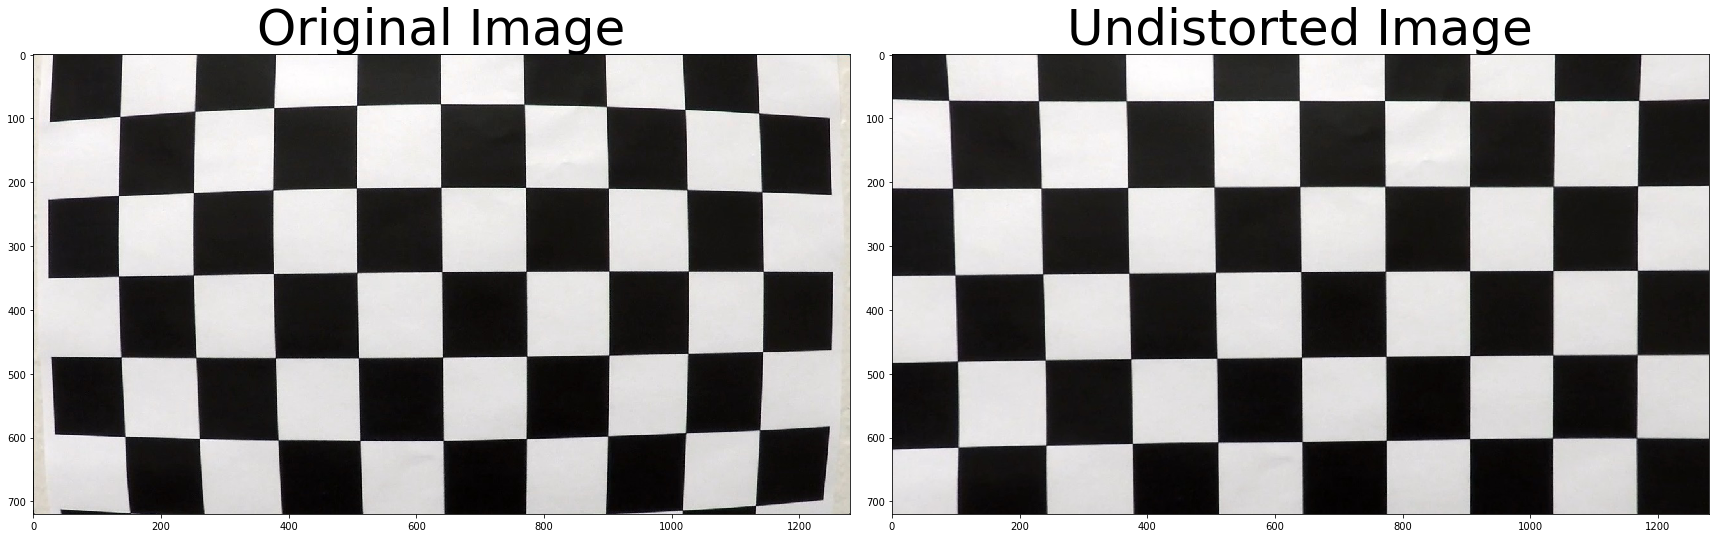

Undistorted image:


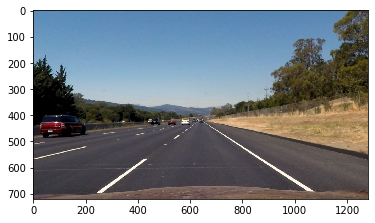

Grayscale image:


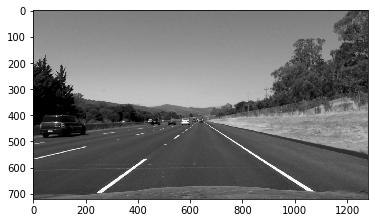

Sobelx, Gradient threshold:


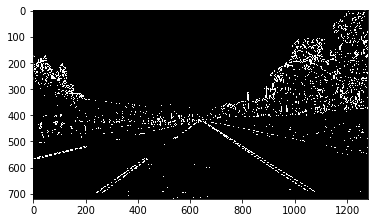

Grayscale image:


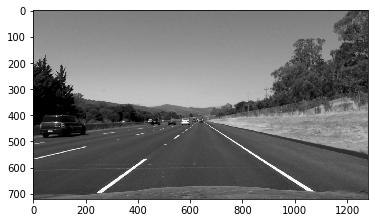

Sobely, Gradient threshold:


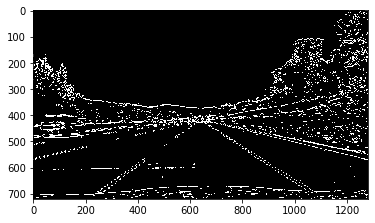

Gradient mag threshold:


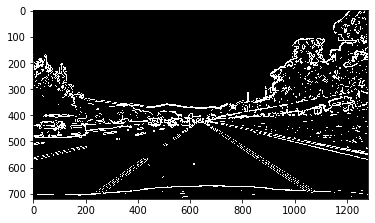

Gradient dir threshold:


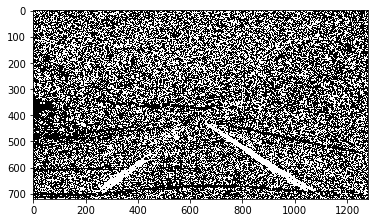

Combined grad threshold:


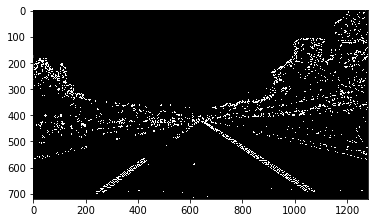

S channel:


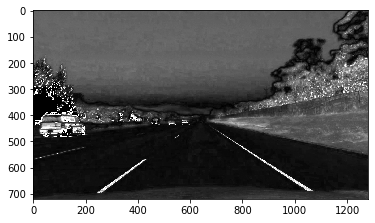

S threshold:


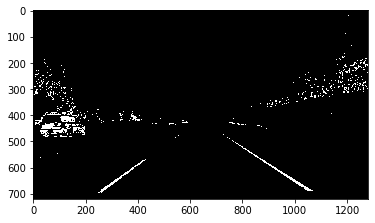

Masked binary image:


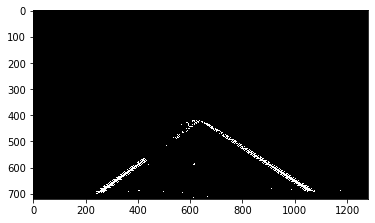

Line image:


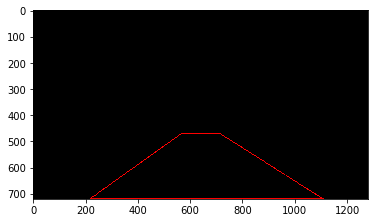

Src points: [[ 217.  719.]
 [ 567.  470.]
 [ 714.  470.]
 [1108.  719.]]
Dst points: [[340. 719.]
 [340.   0.]
 [940.   0.]
 [940. 719.]]


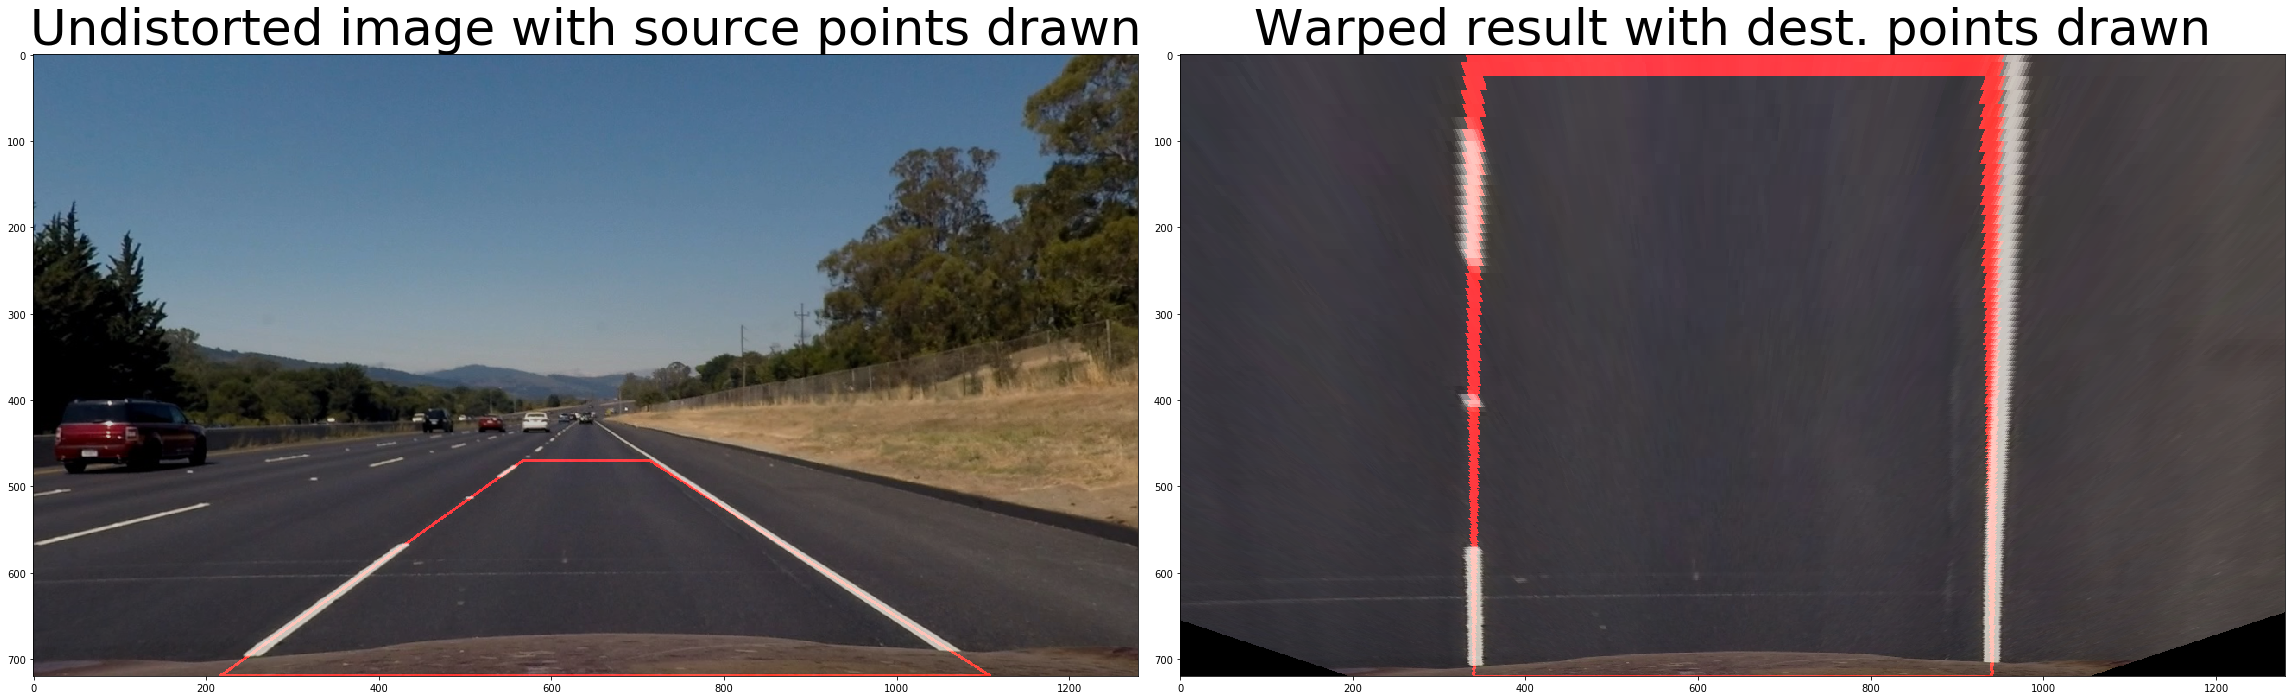

In [425]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #plt.imshow(img)

        
fpath = "camera_cal/calibration1.jpg"
#extract basename from path fpath
fn = os.path.basename(fpath)

#read in a calibration image
img = mpimg.imread(fpath)
        
#apply camera calibration and distortion correction to calibration image
undistorted, mtx, dist = cal_undistort(img, objpoints, imgpoints)

#store original and undistorted calibration image as a figure to folder output_images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
f.savefig("output_images/undistort_output_{}".format(fn))
plt.show()


#compute the perspective transform once based on image with straight lines
#mark lane lines on undistorted and warped image
#preprocessing necessary (distortion correction, gradient+color thresholding and region masking)

fpath = "test_images/straight_lines2.jpg"
#extract basename from path fpath
fn = os.path.basename(fpath)

img = mpimg.imread(fpath)


undist = cv2.undistort(img, mtx, dist, None, mtx)
print("Undistorted image:")
plt.imshow(undist)
plt.show()

#color/gradient thresholding
binary_combo = color_gradient_thresholding(undist, sobel_kernel=15, s_thresh=(170, 255), thresh=(20, 100), thresh_mag=(30,100), thresh_dir=(0.7, 1.3))

#region masking
imshape = img.shape
vertices = np.array([[(0,imshape[0]-1),(600, 420), (640, 420), (imshape[1]-1,imshape[0]-1)]], dtype=np.int32) #vertices of region of interest
masked_binary_combo = region_of_interest(binary_combo, vertices)
print("Masked binary image:")
plt.imshow(masked_binary_combo,cmap='gray')
plt.show()



#apply Hough transformation to thresholded image 
#i.e. create a line image
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 50  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 10 #minimum number of pixels making up a line
max_line_gap = 5   # maximum gap in pixels between connectable line segments

line_image, intersection_vertices = hough_lines(masked_binary_combo, rho, theta, threshold, min_line_length, max_line_gap)
print("Line image:")
plt.imshow(line_image,cmap='gray')
plt.show()


# Draw the lines on the undistorted image
lines_undistorted = weighted_img(line_image, undist, α=0.8, β=1., γ=0.)

#calculate and apply perspective transform to lines_undistorted
src = np.float32(np.array(intersection_vertices))
print("Src points:",src)
dst = np.float32([[340,imshape[0]-1],[340,0],[940,0],[940,imshape[0]-1]])
print("Dst points:",dst)
warped, M = calc_perspective_trans_warp(lines_undistorted, src, dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 12))
f.tight_layout()
ax1.imshow(lines_undistorted)
ax1.set_title("Undistorted image with source points drawn", fontsize=50)
ax2.imshow(warped)
ax2.set_title("Warped result with dest. points drawn", fontsize=50)
f.savefig("output_images/warped_{}".format(fn))
plt.show()


#calculate and apply inverse perspective transform to warped
unwarped, Minv = calc_perspective_trans_warp(warped, dst, src)


## Pipeline for lane-line detection based on test images

Undistorted test image:


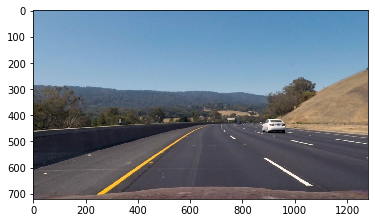

Binary Combo:


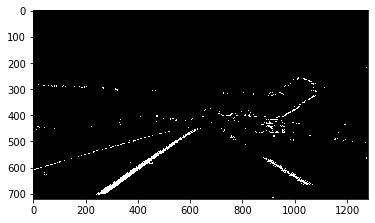

Warped:


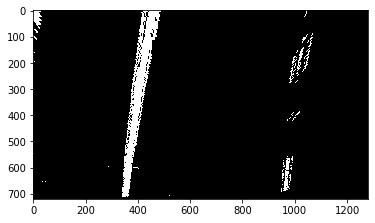

Search from scratch!!!
Color fit lines:


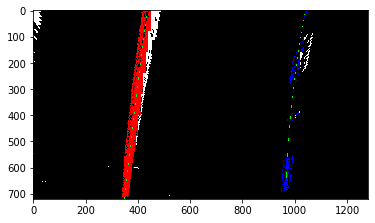

Left curverad 10038 m Right curverad 1232 m Avg curverad 5635 m
Offset -0.10483333333333333 m
Lane boundary image:


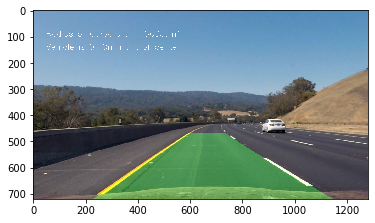

Undistorted test image:


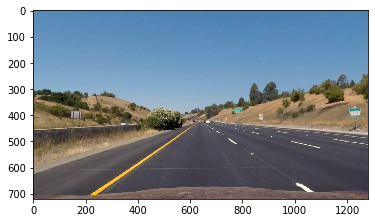

Binary Combo:


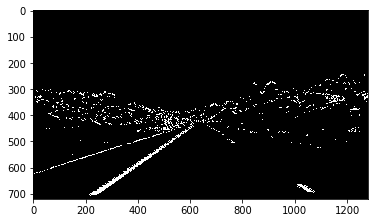

Warped:


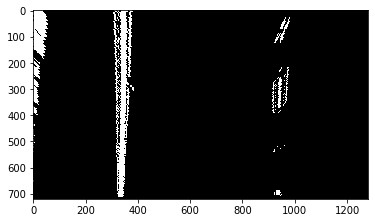

Search from scratch!!!
Color fit lines:


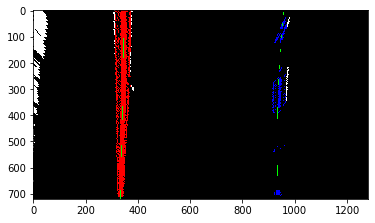

Left curverad 12346 m Right curverad 1387 m Avg curverad 6866 m
Offset 0.024666666666666667 m
Lane boundary image:


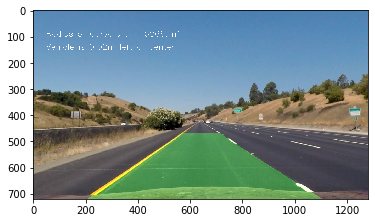

Undistorted test image:


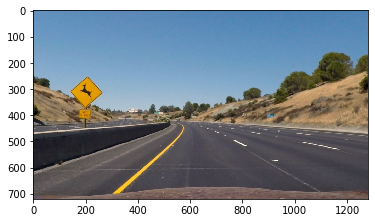

Binary Combo:


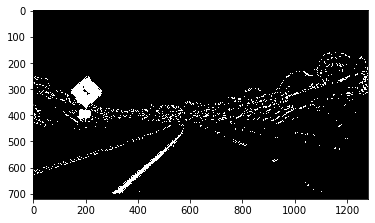

Warped:


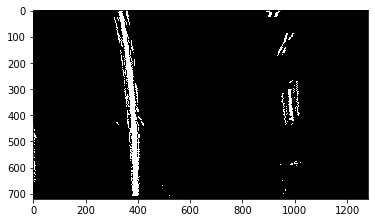

Search from scratch!!!
Color fit lines:


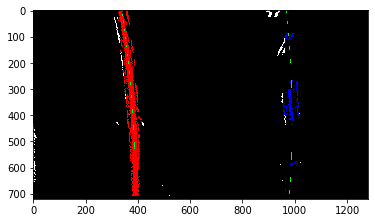

Left curverad 1301 m Right curverad 1125 m Avg curverad 1213 m
Offset -0.2713333333333333 m
Lane boundary image:


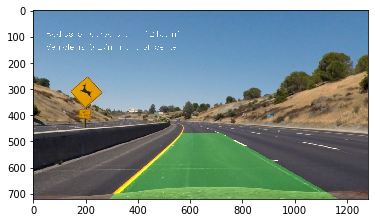

Undistorted test image:


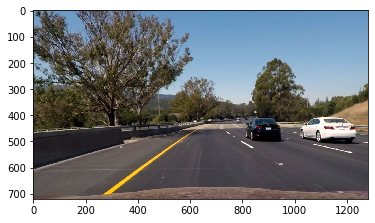

Binary Combo:


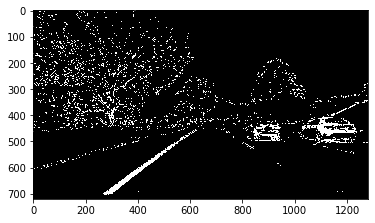

Warped:


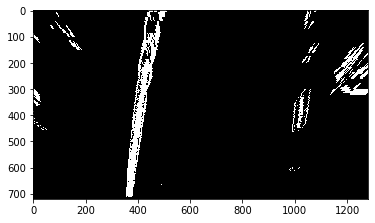

Search from scratch!!!
Color fit lines:


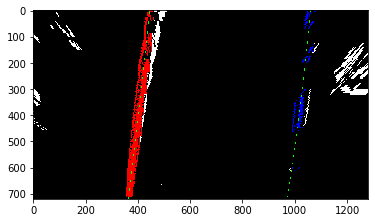

Left curverad 10026 m Right curverad 3099 m Avg curverad 6562 m
Offset -0.1665 m
Lane boundary image:


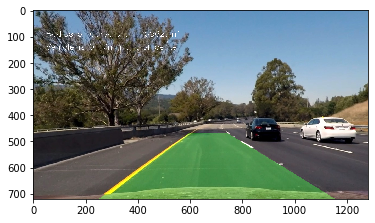

Undistorted test image:


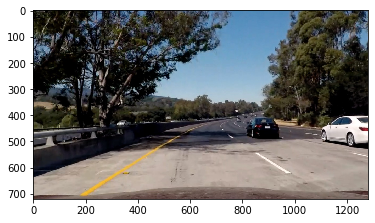

Binary Combo:


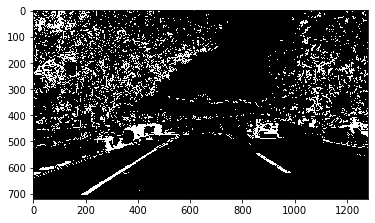

Warped:


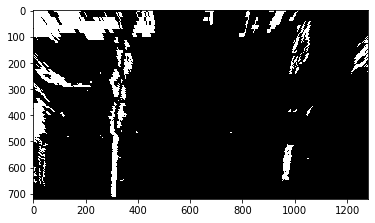

Search from scratch!!!
Color fit lines:


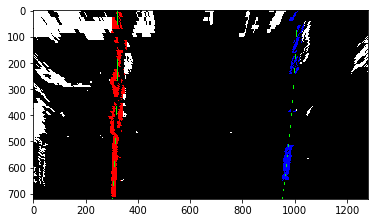

Left curverad 2597 m Right curverad 1962 m Avg curverad 2279 m
Offset 0.074 m
Lane boundary image:


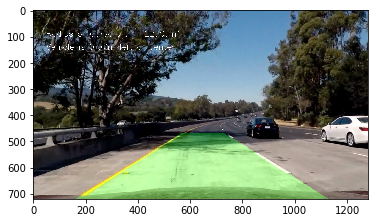

Undistorted test image:


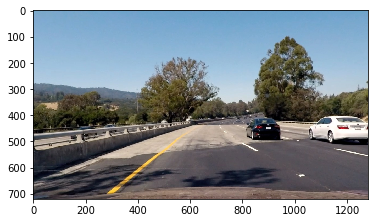

Binary Combo:


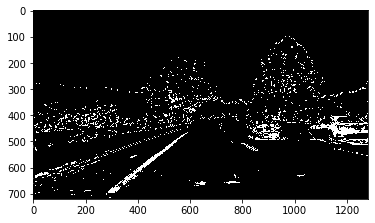

Warped:


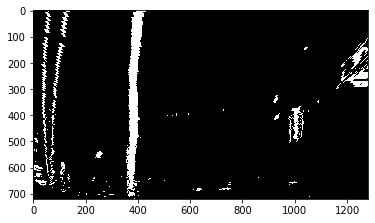

Search from scratch!!!
Color fit lines:


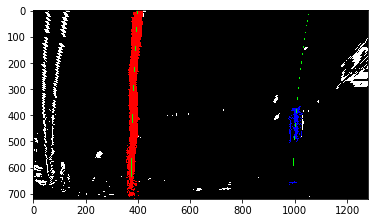

Left curverad 3275 m Right curverad 1160 m Avg curverad 2217 m
Offset -0.2713333333333333 m
Lane boundary image:


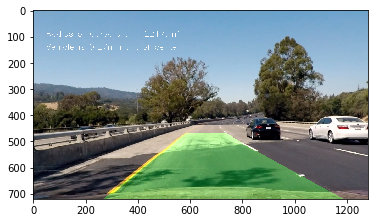

Undistorted test image:


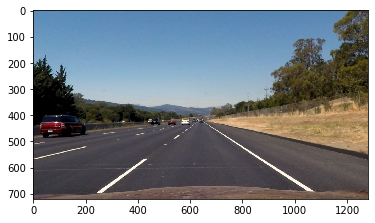

Binary Combo:


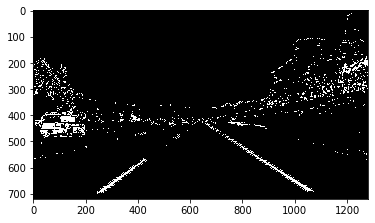

Warped:


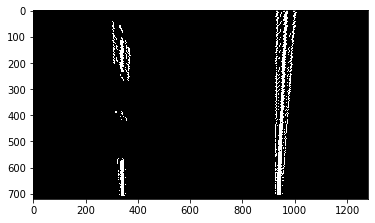

Search from scratch!!!
Color fit lines:


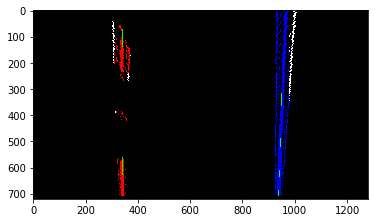

Left curverad 4808 m Right curverad 4269 m Avg curverad 4538 m
Offset 0.012333333333333333 m
Lane boundary image:


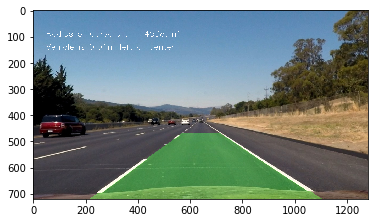

Undistorted test image:


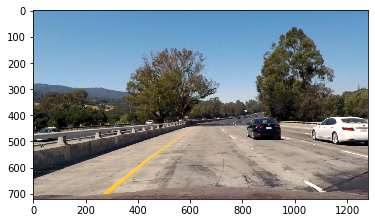

Binary Combo:


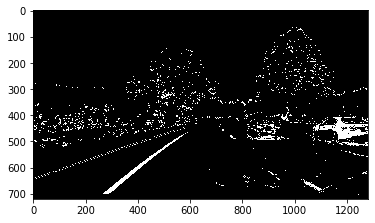

Warped:


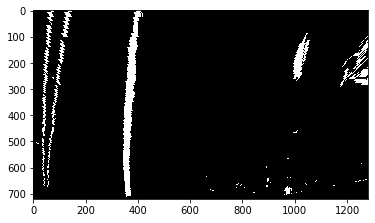

Search from scratch!!!
Color fit lines:


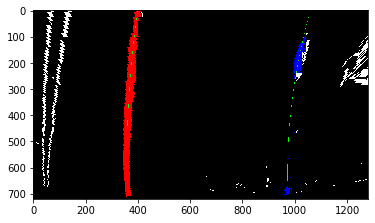

Left curverad 1189 m Right curverad 614 m Avg curverad 901 m
Offset -0.1665 m
Lane boundary image:


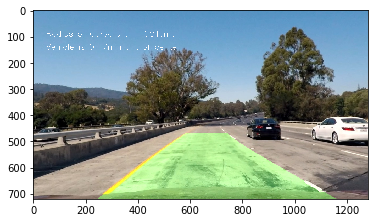

In [437]:
# create instances of class Line for both left and right lane line
left_lane = Line()
right_lane = Line()

# Make a list of test images
images = glob.glob('test_images/*.jpg')

for fname in images:
    
    #search always from scratch for test images -> set reset flags manually to True
    left_lane.reset = True
    right_lane.reset = True
    
    img = mpimg.imread(fname)
    
    #extract basename from path fpath
    fn = os.path.basename(fname)
    
    #apply distortion correction to every test image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    print("Undistorted test image:")
    plt.imshow(undist)
    plt.imsave("output_images/undistorted_{}".format(fn),undist,cmap='gray')
    plt.show()
    
    #apply color and gradient thresholding
    binary_combo = color_gradient_thresholding(undist, sobel_kernel=15, s_thresh=(150, 255), thresh=(50, 100), thresh_mag=(50,100), thresh_dir=(0.7, 1.3))
    print("Binary Combo:")
    plt.imshow(binary_combo,cmap='gray')
    plt.imsave("output_images/binary_combo_{}".format(fn),binary_combo,cmap='gray')
    plt.show()
    
    
    #warp the undistorted image
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(binary_combo, M, img_size, flags=cv2.INTER_NEAREST)
    print("Warped:")
    plt.imshow(warped,cmap='gray')
    plt.imsave("output_images/warped_binary_{}".format(fn),warped,cmap='gray')
    plt.show()
    
    #identification of lane line pixels
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped)
    
    #polynomial fit for left and right lane lines
    color_fit, left_fitx, right_fitx, ploty, coeffs_left, coeffs_right = fit_polynomial(warped, leftx, lefty, rightx, righty, out_img)
    print("Color fit lines:")
    plt.imshow(color_fit)
    plt.imsave("output_images/color_fit_lines_{}".format(fn),color_fit)
    plt.show()
    
    
    # Calculate the radius of curvature in meters for both lane lines
    left_curverad, right_curverad, avg_curverad = measure_curvature_real(warped, leftx, lefty, rightx, righty)
    print("Left curverad", left_curverad, 'm', "Right curverad", right_curverad, 'm', "Avg curverad", avg_curverad, 'm')
    
    # Calculate the position of the car in meters
    offset = measure_position_real(warped,left_fitx,right_fitx)
    print("Offset", offset, 'm')
    
    
    #Visualize lane boundaries on original image
    result = visualization_lane_bounds(Minv,undist,left_fitx,right_fitx,ploty,avg_curverad,offset)
    print("Lane boundary image:")
    plt.imshow(result)
    plt.imsave("output_images/result_{}".format(fn),result)
    plt.show()
 

## Pipeline for lane-line detection based on video

In [438]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [439]:
def process_image(image):
    
    #apply distortion correction to every test image
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    #apply color and gradient thresholding
    binary_combo = color_gradient_thresholding(undist, sobel_kernel=15, s_thresh=(150, 255), thresh=(50, 100), thresh_mag=(50,100), thresh_dir=(0.7, 1.3))
    
    #warp the undistorted image
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(binary_combo, M, img_size, flags=cv2.INTER_NEAREST)
        
    
    #identification of lane line pixels
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped)
    
    #polynomial fit for left and right lane lines
    color_fit, left_fitx, right_fitx, ploty, coeffs_left, coeffs_right = fit_polynomial(warped, leftx, lefty, rightx, righty, out_img)    
    
    # Calculate the radius of curvature in meters for both lane lines
    left_curverad, right_curverad, avg_curverad = measure_curvature_real(warped, leftx, lefty, rightx, righty)
    
    # Calculate the position of the car in meters
    offset = measure_position_real(warped,left_fitx,right_fitx)
    
    #perform a sanity check
    valid_flag = sanity_check(left_curverad,right_curverad,left_fitx,right_fitx,ploty)   
    
    #check if the current frame is a bad frame (sanity check not passed) -> set reset if MAX_bad_frames exceeded
    left_lane.check_bad_frame(valid_flag)
    right_lane.check_bad_frame(valid_flag)  
    
    #update params of instances of class Line (left_lane, right_lane) only if sanity check is successful
    #otherwise preserve prior solution
    if valid_flag:
        left_lane.update_params(left_fitx,ploty,coeffs_left,left_curverad,avg_curverad,offset,leftx,lefty)
        right_lane.update_params(right_fitx,ploty,coeffs_right,right_curverad,avg_curverad,offset,rightx,righty)
    

    #Visualize lane boundaries on original image
    try:
        result = visualization_lane_bounds(Minv,undist,np.squeeze(left_lane.recent_xfitted[-1]),np.squeeze(right_lane.recent_xfitted[-1]),ploty,left_lane.avg_curverad,offset)
        
    except IndexError:
        # Avoids an error if the search from scratch doesn't produce confident result at initialization
        result = visualization_lane_bounds(Minv,undist,left_fitx,right_fitx,ploty,avg_curverad,offset)  
    except ValueError:
        # Avoids an error if the search from scratch doesn't produce confident result at initialization
        result = visualization_lane_bounds(Minv,undist,left_fitx,right_fitx,ploty,avg_curverad,offset)
    
    return result

### Project video 

In [440]:
left_lane = Line()
right_lane = Line()
white_output = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video.mp4").subclip(35,45)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

                                        










                               











































                            



















    

















                  
















































































t:   0%|          | 4/1199 [18:14<22:16,  1.12s/it, now=None]



























t:  21%|██        | 260/1260 [27:53:15<03:48,  4.38it/s, now=None]









t:   6%|▋         | 81/1260 [73:58:41<31:48,  1.62s/it, now=None]

t:   9%|▉         | 23/250 [54:08:31<00:45,  4.98it/s, now=None]




t:   3%|▎         | 7/250 [53:39:50<00:47,  5.08it/s, now=None]






t:  11%|█         | 27/250 [53:38:25<00:46,  4.85it/s, now=None]








t:  28%|██▊       | 71/250 [53:04:42<00:37,  4.80it/s, now=None]























t:  19%|█▉        | 243/1260 [32:19:06<03:41,  4.58it/s, now=None]





















t:  59%|█████▉    | 147/250 [34:51:20<00:25,  4.00it/s, now=None]











t:  10%|

Search from scratch!!!
curvature_diff 798
line_diff 3.7605369209760084
slope_difference 16.35867175266165
Bad counter exceeded!!
Bad counter exceeded!!
Moviepy - Building video test_videos_output/project_video.mp4.
Moviepy - Writing video test_videos_output/project_video.mp4


































t:   0%|          | 2/1260 [00:00<02:40,  7.85it/s, now=None]

Search from scratch!!!
curvature_diff 798
line_diff 3.7605369209760084
slope_difference 16.35867175266165
Bad counter exceeded!!
Bad counter exceeded!!
Search from scratch!!!
curvature_diff 16
line_diff 3.8760085381460194
slope_difference 0.005182818058543148

































t:   0%|          | 3/1260 [00:00<03:06,  6.73it/s, now=None]






























t:   0%|          | 4/1260 [00:00<03:19,  6.30it/s, now=None]






























t:   0%|          | 5/1260 [00:00<03:27,  6.04it/s, now=None]

Search from prior!!!
curvature_diff 537
line_diff 3.949074961326455
slope_difference 0.11314246269228612
Search from prior!!!
curvature_diff 4384
line_diff 3.8222696036724613
slope_difference 0.6565486611524189

































t:   0%|          | 6/1260 [00:00<03:32,  5.90it/s, now=None]






























t:   1%|          | 7/1260 [00:01<03:35,  5.81it/s, now=None]

Search from prior!!!
curvature_diff 486
line_diff 3.768797413173851
slope_difference 0.3977571172823531
Search from prior!!!
curvature_diff 1413
line_diff 3.762916195758868
slope_difference 0.608258504434847

































t:   1%|          | 8/1260 [00:01<03:40,  5.67it/s, now=None]






























t:   1%|          | 9/1260 [00:01<03:39,  5.69it/s, now=None]

Search from prior!!!
curvature_diff 834
line_diff 3.753444473505551
slope_difference 0.017137436271553952
Search from prior!!!
curvature_diff 622
line_diff 3.507096544779189
slope_difference 2.073321170225059

































t:   1%|          | 10/1260 [00:01<03:41,  5.65it/s, now=None]






























t:   1%|          | 11/1260 [00:01<03:39,  5.69it/s, now=None]

Search from prior!!!
curvature_diff 836
line_diff 3.424996543775384
slope_difference 4.918328187904574
Search from prior!!!
curvature_diff 877
line_diff 3.5341772617972076
slope_difference 0.14169043300155337

































t:   1%|          | 12/1260 [00:02<03:41,  5.63it/s, now=None]






























t:   1%|          | 13/1260 [00:02<03:41,  5.63it/s, now=None]

Search from prior!!!
curvature_diff 414
line_diff 3.6950521368235822
slope_difference 1.878339882045859
Search from prior!!!
curvature_diff 344
line_diff 3.760053868282511
slope_difference 1.0262578198775927

































t:   1%|          | 14/1260 [00:02<03:41,  5.63it/s, now=None]

Search from prior!!!
curvature_diff 451
line_diff 3.937197401482874
slope_difference 2.0554589096780562
Search from prior!!!
curvature_diff 172
line_diff 3.960128702846733
slope_difference 0.7817695476990671

































t:   1%|          | 15/1260 [00:02<03:54,  5.31it/s, now=None]






























t:   1%|▏         | 16/1260 [00:02<04:11,  4.94it/s, now=None]
































Search from prior!!!
curvature_diff 424
line_diff 3.9435535112206823
slope_difference 0.2684544731278997
Search from prior!!!
curvature_diff 818
line_diff 3.7820548761580555
slope_difference 0.17978550468776078


t:   1%|▏         | 17/1260 [00:03<04:04,  5.09it/s, now=None]






























t:   1%|▏         | 18/1260 [00:03<04:09,  4.99it/s, now=None]

Search from prior!!!
curvature_diff 2896
line_diff 3.725259706394198
slope_difference 0.873713197966703
Search from prior!!!

































t:   2%|▏         | 19/1260 [00:03<04:13,  4.90it/s, now=None]

curvature_diff 12379
line_diff 3.7164037423328065
slope_difference 0.3250575774656834
Search from prior!!!

































t:   2%|▏         | 20/1260 [00:03<04:12,  4.92it/s, now=None]






























t:   2%|▏         | 21/1260 [00:03<04:03,  5.08it/s, now=None]

curvature_diff 16639
line_diff 3.712651753150581
slope_difference 1.096968280492975
Search from prior!!!
curvature_diff 6275
line_diff 3.7002215929458186
slope_difference 2.1539969292358485

































t:   2%|▏         | 22/1260 [00:04<04:02,  5.10it/s, now=None]

Search from prior!!!
curvature_diff 1457
line_diff 3.4339485198805466
slope_difference 9.667740817848959
Search from prior!!!
curvature_diff 1810
line_diff 3.419187598731085
slope_difference 9.55621370046455

































t:   2%|▏         | 23/1260 [00:04<04:00,  5.14it/s, now=None]






























t:   2%|▏         | 24/1260 [00:04<03:56,  5.23it/s, now=None]

Search from prior!!!
curvature_diff 5229
line_diff 3.4606669795846186
slope_difference 6.431603345469329
Search from prior!!!

































t:   2%|▏         | 25/1260 [00:04<04:01,  5.11it/s, now=None]

curvature_diff 1549
line_diff 3.577968878848412
slope_difference 1.8666864027562422

































t:   2%|▏         | 26/1260 [00:04<04:08,  4.96it/s, now=None]
































Search from prior!!!
curvature_diff 365
line_diff 3.75562839693394
slope_difference 0.24567110983135265
Search from prior!!!
curvature_diff 7190
line_diff 3.870765048553141
slope_difference 0.06460545965071063


t:   2%|▏         | 27/1260 [00:05<04:00,  5.13it/s, now=None]






























t:   2%|▏         | 28/1260 [00:05<03:54,  5.24it/s, now=None]






























t:   2%|▏         | 29/1260 [00:05<03:48,  5.39it/s, now=None]

Search from prior!!!
curvature_diff 185
line_diff 3.942642404044641
slope_difference 0.32424153461031935
Search from prior!!!
curvature_diff 616
line_diff 3.944643871778604
slope_difference 3.5207999708568103

































t:   2%|▏         | 30/1260 [00:05<03:46,  5.44it/s, now=None]






























t:   2%|▏         | 31/1260 [00:05<03:42,  5.53it/s, now=None]

Search from prior!!!
curvature_diff 372
line_diff 3.8996278269537874
slope_difference 5.69778325303081
Search from prior!!!
curvature_diff 1913
line_diff 3.834518277933797
slope_difference 4.340436051542062

































t:   3%|▎         | 32/1260 [00:05<03:42,  5.52it/s, now=None]






























t:   3%|▎         | 33/1260 [00:06<03:41,  5.55it/s, now=None]

Search from prior!!!
curvature_diff 290
line_diff 3.806909583955978
slope_difference 0.05845113467835894
Search from prior!!!
curvature_diff 1006
line_diff 3.802982609365243
slope_difference 0.7168629315188397

































t:   3%|▎         | 34/1260 [00:06<03:39,  5.57it/s, now=None]






























t:   3%|▎         | 35/1260 [00:06<03:39,  5.58it/s, now=None]

Search from prior!!!
curvature_diff 874
line_diff 3.7823205650713327
slope_difference 1.3926257976150005
Search from prior!!!
curvature_diff 834
line_diff 3.4543168797402326
slope_difference 5.688875537054747

































t:   3%|▎         | 36/1260 [00:06<03:39,  5.58it/s, now=None]






























t:   3%|▎         | 37/1260 [00:06<03:40,  5.55it/s, now=None]

Search from prior!!!
curvature_diff 858
line_diff 3.4140903157704376
slope_difference 2.066918385912789
Search from prior!!!
curvature_diff 495
line_diff 3.690305344307089
slope_difference 4.138740642927261

































t:   3%|▎         | 38/1260 [00:06<03:40,  5.55it/s, now=None]
































Search from prior!!!
curvature_diff 832
line_diff 3.834957687002789
slope_difference 4.399201741234101
Search from prior!!!
curvature_diff 14
line_diff 4.008136177912619
slope_difference 5.344446078667845


t:   3%|▎         | 39/1260 [00:07<03:40,  5.54it/s, now=None]






























t:   3%|▎         | 40/1260 [00:07<03:38,  5.58it/s, now=None]






























t:   3%|▎         | 41/1260 [00:07<03:38,  5.58it/s, now=None]

Search from prior!!!
curvature_diff 237
line_diff 3.9952707166223322
slope_difference 4.977506138774211
Search from prior!!!
curvature_diff 223
line_diff 3.9468368328378323
slope_difference 2.975105642176631

































t:   3%|▎         | 42/1260 [00:07<03:37,  5.60it/s, now=None]






























t:   3%|▎         | 43/1260 [00:07<03:36,  5.62it/s, now=None]

Search from prior!!!
curvature_diff 138
line_diff 3.8615657529015173
slope_difference 1.2174603524665137
Search from prior!!!
curvature_diff 3945
line_diff 3.778833874178796
slope_difference 1.074705336458143

































t:   3%|▎         | 44/1260 [00:08<04:26,  4.56it/s, now=None]






























t:   4%|▎         | 45/1260 [00:08<04:12,  4.81it/s, now=None]

Search from prior!!!
curvature_diff 1567
line_diff 3.7518813370333595
slope_difference 0.6146528955834416
Search from prior!!!
curvature_diff 902
line_diff 3.7457002582923016
slope_difference 0.7192589083453367

































t:   4%|▎         | 46/1260 [00:08<04:02,  5.01it/s, now=None]






























t:   4%|▎         | 47/1260 [00:08<03:54,  5.17it/s, now=None]

Search from prior!!!
curvature_diff 1171
line_diff 3.7484553322935663
slope_difference 1.8763347593224111
Search from prior!!!
curvature_diff 179
line_diff 3.5991364364276452
slope_difference 4.930901897063768

































t:   4%|▍         | 48/1260 [00:08<03:49,  5.28it/s, now=None]

Search from prior!!!
curvature_diff 635
line_diff 3.4109804139981748
slope_difference 6.650472622012931
Search from prior!!!

































t:   4%|▍         | 49/1260 [00:09<03:52,  5.22it/s, now=None]

curvature_diff 712
line_diff 3.476328158110158
slope_difference 1.4920879076764937
Search from prior!!!
curvature_diff 565
line_diff 3.6071161446391318
slope_difference 0.9520094527481859

































t:   4%|▍         | 50/1260 [00:09<03:53,  5.18it/s, now=None]






























t:   4%|▍         | 51/1260 [00:09<04:02,  4.99it/s, now=None]

Search from prior!!!
curvature_diff 254
line_diff 3.737914713058769
slope_difference 0.5062212996200559
Search from prior!!!
curvature_diff 1250
line_diff 3.9224087163870025
slope_difference 1.0593303834788124

































t:   4%|▍         | 52/1260 [00:09<03:58,  5.06it/s, now=None]






























t:   4%|▍         | 53/1260 [00:09<04:00,  5.02it/s, now=None]

Search from prior!!!
curvature_diff 24
line_diff 3.948103278769484
slope_difference 0.5813733025384291
Search from prior!!!
curvature_diff 73
line_diff 3.8909434053232688
slope_difference 1.2236362534135612

































t:   4%|▍         | 54/1260 [00:10<03:56,  5.09it/s, now=None]






























t:   4%|▍         | 55/1260 [00:10<04:06,  4.89it/s, now=None]

Search from prior!!!
curvature_diff 789
line_diff 3.7975968600149357
slope_difference 1.7829279554061692

































t:   4%|▍         | 56/1260 [00:10<04:16,  4.70it/s, now=None]

Search from prior!!!
curvature_diff 242
line_diff 3.7179756654799503
slope_difference 0.903170392901667

































t:   5%|▍         | 57/1260 [00:10<04:29,  4.47it/s, now=None]

Search from prior!!!
curvature_diff 335
line_diff 3.7090176499408645
slope_difference 0.742471977897992

































t:   5%|▍         | 58/1260 [00:11<04:34,  4.39it/s, now=None]

Search from prior!!!
curvature_diff 833
line_diff 3.720789563396495
slope_difference 1.2443991866366453

































t:   5%|▍         | 59/1260 [00:11<04:29,  4.46it/s, now=None]

Search from prior!!!
curvature_diff 272
line_diff 3.6897681910882874
slope_difference 1.7188745539019799
Search from prior!!!

































t:   5%|▍         | 60/1260 [00:11<04:19,  4.63it/s, now=None]

curvature_diff 1599
line_diff 3.3542697382652316
slope_difference 2.511212477314336

































t:   5%|▍         | 61/1260 [00:11<04:23,  4.55it/s, now=None]

Search from prior!!!
curvature_diff 1165
line_diff 3.471914605616902
slope_difference 0.9599241856753302

































t:   5%|▍         | 62/1260 [00:11<04:20,  4.61it/s, now=None]

Search from prior!!!
curvature_diff 958
line_diff 3.6934345320939785
slope_difference 3.145077875307006
Search from prior!!!

































t:   5%|▌         | 63/1260 [00:12<04:12,  4.73it/s, now=None]

curvature_diff 32817
line_diff 3.8088700003399456
slope_difference 4.099156512221733

































t:   5%|▌         | 64/1260 [00:12<04:20,  4.58it/s, now=None]

Search from prior!!!
curvature_diff 679
line_diff 3.9341823186736664
slope_difference 4.184402203634957

































t:   5%|▌         | 65/1260 [00:12<04:16,  4.66it/s, now=None]

Search from prior!!!
curvature_diff 594
line_diff 3.9224996784329687
slope_difference 3.9255765336214283
Search from prior!!!

































t:   5%|▌         | 66/1260 [00:12<04:10,  4.76it/s, now=None]

curvature_diff 453
line_diff 3.8804843761168275
slope_difference 2.9752405048467674
Search from prior!!!
curvature_diff 1513
line_diff 3.76552662397517
slope_difference 3.5197171459683574

































t:   5%|▌         | 67/1260 [00:12<04:05,  4.86it/s, now=None]






























t:   5%|▌         | 68/1260 [00:13<04:02,  4.92it/s, now=None]

Search from prior!!!
curvature_diff 2199
line_diff 3.752211336853372
slope_difference 3.286772735904605

































t:   5%|▌         | 69/1260 [00:13<04:10,  4.75it/s, now=None]

Search from prior!!!
curvature_diff 7827
line_diff 3.756195645342968
slope_difference 2.316620099353287

































t:   6%|▌         | 70/1260 [00:13<04:12,  4.72it/s, now=None]

Search from prior!!!
curvature_diff 15592
line_diff 3.7493720523544205
slope_difference 2.4378116108871897

































t:   6%|▌         | 71/1260 [00:13<04:13,  4.68it/s, now=None]

Search from prior!!!
curvature_diff 474
line_diff 3.7195639725528133
slope_difference 2.486363653488935

































t:   6%|▌         | 72/1260 [00:14<04:16,  4.63it/s, now=None]

Search from prior!!!
curvature_diff 749
line_diff 3.2848242893739426
slope_difference 8.49424242070048

































t:   6%|▌         | 73/1260 [00:14<04:24,  4.48it/s, now=None]

Search from prior!!!
curvature_diff 787
line_diff 3.2635621027417625
slope_difference 5.940476985319881
Search from prior!!!
curvature_diff 670
line_diff 3.490731281157332
slope_difference 0.4495045246149427

































t:   6%|▌         | 74/1260 [00:14<04:14,  4.66it/s, now=None]






























t:   6%|▌         | 75/1260 [00:14<04:09,  4.74it/s, now=None]

Search from prior!!!
curvature_diff 327
line_diff 3.6432458191978845
slope_difference 1.2920771839924594
Search from prior!!!

































t:   6%|▌         | 76/1260 [00:14<04:07,  4.79it/s, now=None]

curvature_diff 749
line_diff 3.735848591240178
slope_difference 1.2229133644378543
Search from prior!!!

































t:   6%|▌         | 77/1260 [00:15<04:06,  4.79it/s, now=None]

curvature_diff 119
line_diff 3.839316405838719
slope_difference 1.5915984828697027
Search from prior!!!

































t:   6%|▌         | 78/1260 [00:15<04:04,  4.83it/s, now=None]

curvature_diff 965
line_diff 3.86046321646192
slope_difference 0.12195129557787432

































t:   6%|▋         | 79/1260 [00:15<04:06,  4.79it/s, now=None]

Search from prior!!!
curvature_diff 1844
line_diff 3.821574090356088
slope_difference 2.742107946895352
Search from prior!!!
































t:   6%|▋         | 80/1260 [00:15<04:08,  4.76it/s, now=None]


curvature_diff 1891
line_diff 3.8028032397923432
slope_difference 6.541824754151774

































t:   6%|▋         | 81/1260 [00:15<04:09,  4.72it/s, now=None]

Search from prior!!!
curvature_diff 1632
line_diff 3.764930019082849
slope_difference 8.440099579149573

































t:   7%|▋         | 82/1260 [00:16<04:13,  4.64it/s, now=None]

Search from prior!!!
curvature_diff 9621
line_diff 3.707342551189646
slope_difference 4.728900070273335

































t:   7%|▋         | 83/1260 [00:16<04:15,  4.61it/s, now=None]

Search from prior!!!
curvature_diff 6716
line_diff 3.7190798807494034
slope_difference 3.985397846709942

































t:   7%|▋         | 84/1260 [00:16<04:16,  4.59it/s, now=None]

Search from prior!!!
curvature_diff 8473
line_diff 3.7317117145289043
slope_difference 3.901757848151515

































t:   7%|▋         | 85/1260 [00:16<04:25,  4.43it/s, now=None]

Search from prior!!!
curvature_diff 8304
line_diff 3.661369393128703
slope_difference 13.439656368516971

































t:   7%|▋         | 86/1260 [00:17<04:21,  4.49it/s, now=None]

Search from prior!!!
curvature_diff 6016
line_diff 3.5502653608476384
slope_difference 6.720165524261443

































t:   7%|▋         | 87/1260 [00:17<04:20,  4.50it/s, now=None]

Search from prior!!!
curvature_diff 2653
line_diff 3.590534023180872
slope_difference 1.812905249451351
Bad counter exceeded!!
Bad counter exceeded!!

































t:   7%|▋         | 88/1260 [00:17<04:23,  4.46it/s, now=None]

Search from scratch!!!
curvature_diff 342
line_diff 3.7849940430640223
slope_difference 2.874430492891589

































t:   7%|▋         | 89/1260 [00:17<04:25,  4.41it/s, now=None]

Search from prior!!!
curvature_diff 311
line_diff 3.9980990740394837
slope_difference 8.505071743377368

































t:   7%|▋         | 90/1260 [00:17<04:25,  4.41it/s, now=None]

Search from prior!!!
curvature_diff 1011
line_diff 4.049308407650162
slope_difference 9.99465159840232

































t:   7%|▋         | 91/1260 [00:18<04:23,  4.44it/s, now=None]

Search from prior!!!
curvature_diff 556
line_diff 3.9606963314718198
slope_difference 9.160045039553436

































t:   7%|▋         | 92/1260 [00:18<04:24,  4.42it/s, now=None]

Search from prior!!!
curvature_diff 230
line_diff 3.8717015926834657
slope_difference 8.358165428748116

































t:   7%|▋         | 93/1260 [00:18<04:30,  4.32it/s, now=None]

Search from prior!!!
curvature_diff 1091
line_diff 3.799017343633913
slope_difference 7.84528079749642
Search from prior!!!
































t:   7%|▋         | 94/1260 [00:18<04:19,  4.49it/s, now=None]


curvature_diff 2923
line_diff 3.7869765483117597
slope_difference 7.249916984309857

































t:   8%|▊         | 95/1260 [00:19<04:16,  4.55it/s, now=None]

Search from prior!!!
curvature_diff 1775
line_diff 3.767495758628284
slope_difference 7.731501993838975
Search from prior!!!
































t:   8%|▊         | 96/1260 [00:19<04:10,  4.65it/s, now=None]


curvature_diff 3567
line_diff 3.757942887940921
slope_difference 5.0877481335302

































t:   8%|▊         | 97/1260 [00:19<04:09,  4.67it/s, now=None]

Search from prior!!!
curvature_diff 763
line_diff 3.27492624292708
slope_difference 28.51504867503327
Search from prior!!!
































t:   8%|▊         | 98/1260 [00:19<04:04,  4.75it/s, now=None]


curvature_diff 701
line_diff 3.3726085633195404
slope_difference 2.7710219040324056

































t:   8%|▊         | 99/1260 [00:19<04:08,  4.66it/s, now=None]

Search from prior!!!
curvature_diff 570
line_diff 3.538614235435644
slope_difference 0.9432495791785396

































t:   8%|▊         | 100/1260 [00:20<04:09,  4.65it/s, now=None]

Search from prior!!!
curvature_diff 203
line_diff 3.6743399520960844
slope_difference 4.728619503044579

































t:   8%|▊         | 101/1260 [00:20<04:16,  4.52it/s, now=None]

Search from prior!!!
curvature_diff 919
line_diff 3.7563819131631946
slope_difference 4.5292891333408996

































t:   8%|▊         | 102/1260 [00:20<04:11,  4.60it/s, now=None]

Search from prior!!!
curvature_diff 746
line_diff 3.848955745342171
slope_difference 5.250395244060998

































t:   8%|▊         | 103/1260 [00:20<04:10,  4.62it/s, now=None]

Search from prior!!!
curvature_diff 356
line_diff 3.8628971909385235
slope_difference 4.659243720470494

































t:   8%|▊         | 104/1260 [00:20<04:08,  4.66it/s, now=None]

Search from prior!!!
curvature_diff 175
line_diff 3.80189110937613
slope_difference 1.5957086237399398

































t:   8%|▊         | 105/1260 [00:21<04:12,  4.58it/s, now=None]

Search from prior!!!
curvature_diff 232
line_diff 3.7679958840380965
slope_difference 2.482105146179883

































t:   8%|▊         | 106/1260 [00:21<04:15,  4.52it/s, now=None]

Search from prior!!!
curvature_diff 9677
line_diff 3.726832833891752
slope_difference 2.329798523908723

































t:   8%|▊         | 107/1260 [00:21<04:11,  4.58it/s, now=None]

Search from prior!!!
curvature_diff 177
line_diff 3.7014587442399485
slope_difference 1.1422160737771438

































t:   9%|▊         | 108/1260 [00:21<04:08,  4.63it/s, now=None]

Search from prior!!!
curvature_diff 58
line_diff 3.721707817704321
slope_difference 2.7192599171491025

































t:   9%|▊         | 109/1260 [00:22<04:12,  4.57it/s, now=None]

Search from prior!!!
curvature_diff 1556
line_diff 3.7151131132577504
slope_difference 4.932724331027357

































t:   9%|▊         | 110/1260 [00:22<04:09,  4.60it/s, now=None]

Search from prior!!!
curvature_diff 656
line_diff 3.563234207860104
slope_difference 13.496830069036836

































t:   9%|▉         | 111/1260 [00:22<04:06,  4.65it/s, now=None]

Search from prior!!!
curvature_diff 932
line_diff 3.499080889087233
slope_difference 7.877804016249259

































t:   9%|▉         | 112/1260 [00:22<04:08,  4.61it/s, now=None]

Search from prior!!!
curvature_diff 735
line_diff 3.5025474794063562
slope_difference 3.0345626104770886

































t:   9%|▉         | 113/1260 [00:22<04:16,  4.47it/s, now=None]

Search from prior!!!
curvature_diff 716
line_diff 3.618911092318091
slope_difference 1.6213659672899912

































t:   9%|▉         | 114/1260 [00:23<04:11,  4.55it/s, now=None]

Search from prior!!!
curvature_diff 42
line_diff 3.7580359906186893
slope_difference 3.094766087783208

































t:   9%|▉         | 115/1260 [00:23<04:08,  4.61it/s, now=None]

Search from prior!!!
curvature_diff 2642
line_diff 3.881438710433984
slope_difference 4.177906740271247

































t:   9%|▉         | 116/1260 [00:23<04:04,  4.68it/s, now=None]

Search from prior!!!
curvature_diff 25
line_diff 3.9160005367219615
slope_difference 3.2951164427524144

































t:   9%|▉         | 117/1260 [00:23<04:07,  4.61it/s, now=None]

Search from prior!!!
curvature_diff 136
line_diff 3.8836113242464134
slope_difference 1.90777984501654

































t:   9%|▉         | 118/1260 [00:24<04:04,  4.68it/s, now=None]

Search from prior!!!
curvature_diff 1580
line_diff 3.796741421156314
slope_difference 0.5812555832656194

































t:   9%|▉         | 119/1260 [00:24<04:02,  4.71it/s, now=None]

Search from prior!!!
curvature_diff 462
line_diff 3.729112790953001
slope_difference 1.6469337245271554

































t:  10%|▉         | 120/1260 [00:24<04:17,  4.44it/s, now=None]

Search from prior!!!
curvature_diff 557
line_diff 3.7217315312112698
slope_difference 1.1291424154123373

































t:  10%|▉         | 121/1260 [00:24<04:16,  4.44it/s, now=None]

Search from prior!!!
curvature_diff 800
line_diff 3.70612152816409
slope_difference 2.3746157352247454

































t:  10%|▉         | 122/1260 [00:24<04:10,  4.53it/s, now=None]

Search from prior!!!
curvature_diff 528
line_diff 3.566996563610597
slope_difference 0.9863895275023165

































t:  10%|▉         | 123/1260 [00:25<04:06,  4.61it/s, now=None]

Search from prior!!!
curvature_diff 666
line_diff 3.339111434465876
slope_difference 2.941771422688692

































t:  10%|▉         | 124/1260 [00:25<04:03,  4.66it/s, now=None]

Search from prior!!!
curvature_diff 525
line_diff 3.5084555864215017
slope_difference 3.2435024189881023

































t:  10%|▉         | 125/1260 [00:25<04:13,  4.47it/s, now=None]

Search from prior!!!
curvature_diff 98
line_diff 3.705115838892306
slope_difference 4.928718339803199

































t:  10%|█         | 126/1260 [00:25<04:16,  4.42it/s, now=None]

Search from prior!!!
curvature_diff 1826
line_diff 3.79121697132748
slope_difference 4.997798092267859

































t:  10%|█         | 127/1260 [00:26<04:13,  4.47it/s, now=None]

Search from prior!!!
curvature_diff 445
line_diff 3.935591649886781
slope_difference 4.2184109422582114

































t:  10%|█         | 128/1260 [00:26<04:18,  4.38it/s, now=None]

Search from prior!!!
curvature_diff 79
line_diff 3.944802828547463
slope_difference 4.13045582507139

































t:  10%|█         | 129/1260 [00:26<04:24,  4.28it/s, now=None]

Search from prior!!!
curvature_diff 60
line_diff 3.8932506936316593
slope_difference 1.8957674016154336

































t:  10%|█         | 130/1260 [00:26<04:15,  4.42it/s, now=None]

Search from prior!!!
curvature_diff 2097
line_diff 3.742226967554301
slope_difference 2.164640353018756

































t:  10%|█         | 131/1260 [00:26<04:10,  4.51it/s, now=None]

Search from prior!!!
curvature_diff 2565
line_diff 3.7274524946378635
slope_difference 1.167177164174916

































t:  10%|█         | 132/1260 [00:27<04:05,  4.59it/s, now=None]

Search from prior!!!
curvature_diff 1016
line_diff 3.704638847419717
slope_difference 1.5158891386795723

































t:  11%|█         | 133/1260 [00:27<04:06,  4.57it/s, now=None]

Search from prior!!!
curvature_diff 507
line_diff 3.675119272616212
slope_difference 2.1500426637148085

































t:  11%|█         | 134/1260 [00:27<04:03,  4.62it/s, now=None]

Search from prior!!!
curvature_diff 411
line_diff 3.658463140695738
slope_difference 3.0300956960978622

































t:  11%|█         | 135/1260 [00:27<04:02,  4.63it/s, now=None]

Search from prior!!!
curvature_diff 891
line_diff 3.280064661076241
slope_difference 2.565033847949433

































t:  11%|█         | 136/1260 [00:28<03:59,  4.69it/s, now=None]

Search from prior!!!
curvature_diff 726
line_diff 3.397410531954936
slope_difference 0.05435930669499989

































t:  11%|█         | 137/1260 [00:28<04:00,  4.66it/s, now=None]

Search from prior!!!
curvature_diff 519
line_diff 3.5830513988973136
slope_difference 2.0613709515036245

































t:  11%|█         | 138/1260 [00:28<03:59,  4.69it/s, now=None]

Search from prior!!!
curvature_diff 83
line_diff 3.7070283916371523
slope_difference 2.2716931818587343

































t:  11%|█         | 139/1260 [00:28<03:58,  4.71it/s, now=None]

Search from prior!!!
curvature_diff 331
line_diff 3.754377109503931
slope_difference 1.649031432737976

































t:  11%|█         | 140/1260 [00:28<03:55,  4.75it/s, now=None]

Search from prior!!!
curvature_diff 144
line_diff 3.9211775769482156
slope_difference 2.455289999853946

































t:  11%|█         | 141/1260 [00:29<03:59,  4.68it/s, now=None]

Search from prior!!!
curvature_diff 171
line_diff 3.9093493307728076
slope_difference 0.6004513322708771

































t:  11%|█▏        | 142/1260 [00:29<03:58,  4.69it/s, now=None]

Search from prior!!!
curvature_diff 506
line_diff 3.8862044579584056
slope_difference 0.5330301206279415

































t:  11%|█▏        | 143/1260 [00:29<03:56,  4.73it/s, now=None]

Search from prior!!!
curvature_diff 453
line_diff 3.84314669662926
slope_difference 3.5014740194194385

































t:  11%|█▏        | 144/1260 [00:29<03:59,  4.67it/s, now=None]

Search from prior!!!
curvature_diff 15
line_diff 3.782994855976979
slope_difference 2.6212743213710947

































t:  12%|█▏        | 145/1260 [00:29<04:00,  4.65it/s, now=None]

Search from prior!!!
curvature_diff 5871
line_diff 3.7355378086450575
slope_difference 0.037168911105483815

































t:  12%|█▏        | 146/1260 [00:30<03:59,  4.66it/s, now=None]

Search from prior!!!
curvature_diff 17269
line_diff 3.7440077288615248
slope_difference 1.1476024743083588

































t:  12%|█▏        | 147/1260 [00:30<03:55,  4.73it/s, now=None]

Search from prior!!!
curvature_diff 660
line_diff 3.674714633876261
slope_difference 2.686926927620533

































t:  12%|█▏        | 148/1260 [00:30<03:54,  4.74it/s, now=None]

Search from prior!!!
curvature_diff 928
line_diff 3.478501557472087
slope_difference 2.36417100466422

































t:  12%|█▏        | 149/1260 [00:30<03:57,  4.67it/s, now=None]

Search from prior!!!
curvature_diff 331
line_diff 3.658957083200097
slope_difference 3.904183760529877

































t:  12%|█▏        | 150/1260 [00:30<03:56,  4.68it/s, now=None]

Search from prior!!!
curvature_diff 940
line_diff 3.77728430367567
slope_difference 4.91291702047574

































t:  12%|█▏        | 151/1260 [00:31<03:54,  4.72it/s, now=None]

Search from prior!!!
curvature_diff 28844
line_diff 3.823203919389164
slope_difference 4.107700956069364

































t:  12%|█▏        | 152/1260 [00:31<03:56,  4.69it/s, now=None]

Search from prior!!!
curvature_diff 637
line_diff 3.9562808982551068
slope_difference 4.14395865770639

































t:  12%|█▏        | 153/1260 [00:31<04:01,  4.58it/s, now=None]

Search from prior!!!
curvature_diff 758
line_diff 3.9177869766926574
slope_difference 2.664186511865715

































t:  12%|█▏        | 154/1260 [00:31<04:00,  4.60it/s, now=None]

Search from prior!!!
curvature_diff 604
line_diff 3.868513849940882
slope_difference 2.090021533997639

































t:  12%|█▏        | 155/1260 [00:32<04:02,  4.56it/s, now=None]

Search from prior!!!
curvature_diff 616
line_diff 3.8369341271657107
slope_difference 1.1127961028337463

































t:  12%|█▏        | 156/1260 [00:32<04:14,  4.34it/s, now=None]

Search from prior!!!
curvature_diff 112138
line_diff 3.7599214650814305
slope_difference 1.6066986296373056

































t:  12%|█▏        | 157/1260 [00:32<04:28,  4.11it/s, now=None]

Search from prior!!!
curvature_diff 2008
line_diff 3.7416913628679938
slope_difference 0.9242109914109395

































t:  13%|█▎        | 158/1260 [00:32<04:35,  4.01it/s, now=None]

Search from prior!!!
curvature_diff 290
line_diff 3.7265360277119215
slope_difference 0.20862528323067586

































t:  13%|█▎        | 159/1260 [00:33<04:40,  3.92it/s, now=None]

Search from prior!!!
curvature_diff 992
line_diff 3.6953479075063087
slope_difference 4.054029251449288

































t:  13%|█▎        | 160/1260 [00:33<04:44,  3.87it/s, now=None]

Search from prior!!!
curvature_diff 1177
line_diff 3.404817696079966
slope_difference 3.338918522301073

































t:  13%|█▎        | 161/1260 [00:33<04:52,  3.76it/s, now=None]

Search from prior!!!
curvature_diff 916
line_diff 3.4768995055355867
slope_difference 0.6344646646786085

































t:  13%|█▎        | 162/1260 [00:33<04:49,  3.79it/s, now=None]

Search from prior!!!
curvature_diff 546
line_diff 3.6939966569255103
slope_difference 2.7759570394381896

































t:  13%|█▎        | 163/1260 [00:34<04:48,  3.81it/s, now=None]

Search from prior!!!
curvature_diff 272
line_diff 3.8187999564492277
slope_difference 3.002707750005123

































t:  13%|█▎        | 164/1260 [00:34<04:48,  3.79it/s, now=None]

Search from prior!!!
curvature_diff 3663
line_diff 3.894291087699911
slope_difference 2.761421110606852

































t:  13%|█▎        | 165/1260 [00:34<04:48,  3.80it/s, now=None]

Search from prior!!!
curvature_diff 399
line_diff 4.0825995709250815
slope_difference 3.8159312232916243

































t:  13%|█▎        | 166/1260 [00:35<04:46,  3.82it/s, now=None]

Search from prior!!!
curvature_diff 504
line_diff 4.017161985295159
slope_difference 3.452392459247327

































t:  13%|█▎        | 167/1260 [00:35<05:11,  3.51it/s, now=None]

Search from prior!!!
curvature_diff 330
line_diff 3.9432873054842172
slope_difference 0.951926434235153

































t:  13%|█▎        | 168/1260 [00:35<05:03,  3.60it/s, now=None]

Search from prior!!!
curvature_diff 4056
line_diff 3.8025486967979236
slope_difference 2.0118967677399837

































t:  13%|█▎        | 169/1260 [00:35<04:58,  3.65it/s, now=None]

Search from prior!!!
curvature_diff 7760
line_diff 3.7907966563792317
slope_difference 0.004124902293522581

































t:  13%|█▎        | 170/1260 [00:36<04:55,  3.68it/s, now=None]

Search from prior!!!
curvature_diff 2020
line_diff 3.7896591574135114
slope_difference 0.4491728867800475

































t:  14%|█▎        | 171/1260 [00:36<04:44,  3.83it/s, now=None]

Search from prior!!!
curvature_diff 7622
line_diff 3.795012977146675
slope_difference 2.884206494537956

































t:  14%|█▎        | 172/1260 [00:36<04:40,  3.88it/s, now=None]

Search from prior!!!
curvature_diff 1764
line_diff 3.7412431582592265
slope_difference 5.188620686495032
Bad counter exceeded!!
Bad counter exceeded!!

































t:  14%|█▎        | 173/1260 [00:36<04:44,  3.82it/s, now=None]

Search from scratch!!!
curvature_diff 222
line_diff 3.6123510667906062
slope_difference 29.261963184688952
Bad counter exceeded!!
Bad counter exceeded!!

































t:  14%|█▍        | 174/1260 [00:37<04:41,  3.86it/s, now=None]

Search from scratch!!!
curvature_diff 239
line_diff 3.6627085642720965
slope_difference 11.378785127088314

































t:  14%|█▍        | 175/1260 [00:37<04:43,  3.83it/s, now=None]

Search from prior!!!
curvature_diff 257
line_diff 3.7334567621129677
slope_difference 1.3889148860431444

































t:  14%|█▍        | 176/1260 [00:37<04:50,  3.73it/s, now=None]

Search from prior!!!
curvature_diff 9322
line_diff 3.8185377734362627
slope_difference 2.1349900880611425

































t:  14%|█▍        | 177/1260 [00:38<05:11,  3.48it/s, now=None]

Search from prior!!!
curvature_diff 889
line_diff 3.964436315464821
slope_difference 3.197966437760063

































t:  14%|█▍        | 178/1260 [00:38<05:00,  3.59it/s, now=None]

Search from prior!!!
curvature_diff 841
line_diff 3.9156775571156
slope_difference 1.2193243420413538

































t:  14%|█▍        | 179/1260 [00:38<04:47,  3.76it/s, now=None]

Search from prior!!!
curvature_diff 811
line_diff 3.888414843275411
slope_difference 0.3518059287625839

































t:  14%|█▍        | 180/1260 [00:38<04:39,  3.87it/s, now=None]

Search from prior!!!
curvature_diff 1648
line_diff 3.832407040698368
slope_difference 1.4559698999612785

































t:  14%|█▍        | 181/1260 [00:39<04:40,  3.84it/s, now=None]

Search from prior!!!
curvature_diff 1144
line_diff 3.775240957551731
slope_difference 0.34355778154329286

































t:  14%|█▍        | 182/1260 [00:39<04:43,  3.81it/s, now=None]

Search from prior!!!
curvature_diff 7
line_diff 3.8025137710203207
slope_difference 0.27267014686738555

































t:  15%|█▍        | 183/1260 [00:39<04:39,  3.86it/s, now=None]

Search from prior!!!
curvature_diff 641
line_diff 3.8128906865686547
slope_difference 1.3428434961118096

































t:  15%|█▍        | 184/1260 [00:39<04:38,  3.86it/s, now=None]

Search from prior!!!
curvature_diff 906
line_diff 3.766101916174498
slope_difference 5.078559515809827

































t:  15%|█▍        | 185/1260 [00:40<04:41,  3.82it/s, now=None]

Search from prior!!!
curvature_diff 787
line_diff 3.57897419540595
slope_difference 4.4841311096032435

































t:  15%|█▍        | 186/1260 [00:40<04:35,  3.89it/s, now=None]

Search from prior!!!
curvature_diff 264
line_diff 3.8716843931186484
slope_difference 7.513155109693559

































t:  15%|█▍        | 187/1260 [00:40<04:35,  3.90it/s, now=None]

Search from prior!!!
curvature_diff 8617
line_diff 4.057712432688817
slope_difference 9.398084363316002

































t:  15%|█▍        | 188/1260 [00:40<04:41,  3.81it/s, now=None]

Search from prior!!!
curvature_diff 1857
line_diff 4.042855688502974
slope_difference 8.64162781382328

































t:  15%|█▌        | 189/1260 [00:41<04:48,  3.72it/s, now=None]

Search from prior!!!
curvature_diff 206
line_diff 4.1862866954908045
slope_difference 9.285178758741242

































t:  15%|█▌        | 190/1260 [00:41<04:42,  3.79it/s, now=None]

Search from prior!!!
curvature_diff 42
line_diff 4.063966665476083
slope_difference 7.882304137554813

































t:  15%|█▌        | 191/1260 [00:41<04:52,  3.66it/s, now=None]

Search from prior!!!
curvature_diff 76
line_diff 3.976001550631011
slope_difference 6.240458816818377

































t:  15%|█▌        | 192/1260 [00:41<04:54,  3.63it/s, now=None]

Search from prior!!!
curvature_diff 18393
line_diff 3.8420664337183172
slope_difference 6.651138130314787

































t:  15%|█▌        | 193/1260 [00:42<04:54,  3.63it/s, now=None]

Search from prior!!!
curvature_diff 59280
line_diff 3.8022033650619487
slope_difference 5.349979983011595

































t:  15%|█▌        | 194/1260 [00:42<04:51,  3.65it/s, now=None]

Search from prior!!!
curvature_diff 321
line_diff 3.7316948160066676
slope_difference 6.774489460768409

































t:  15%|█▌        | 195/1260 [00:42<04:43,  3.75it/s, now=None]

Search from prior!!!
curvature_diff 450
line_diff 3.7046326629995154
slope_difference 6.3367478260318775

































t:  16%|█▌        | 196/1260 [00:43<05:00,  3.54it/s, now=None]

Search from prior!!!
curvature_diff 412
line_diff 3.683061579866052
slope_difference 5.909619362575097

































t:  16%|█▌        | 197/1260 [00:43<04:50,  3.66it/s, now=None]

Search from prior!!!
curvature_diff 685
line_diff 3.3430314966391026
slope_difference 1.6805351954342562

































t:  16%|█▌        | 198/1260 [00:43<04:38,  3.81it/s, now=None]

Search from prior!!!
curvature_diff 738
line_diff 3.4739110524278276
slope_difference 1.9807887549210133

































t:  16%|█▌        | 199/1260 [00:43<04:34,  3.86it/s, now=None]

Search from prior!!!
curvature_diff 727
line_diff 3.563102136038653
slope_difference 4.085097583973413

































t:  16%|█▌        | 200/1260 [00:44<04:31,  3.91it/s, now=None]

Search from prior!!!
curvature_diff 715
line_diff 3.628381052204226
slope_difference 5.876711073876317

































t:  16%|█▌        | 201/1260 [00:44<04:34,  3.86it/s, now=None]

Search from prior!!!
curvature_diff 448
line_diff 3.7895467791036794
slope_difference 1.5818972782011134

































t:  16%|█▌        | 202/1260 [00:44<04:30,  3.91it/s, now=None]

Search from prior!!!
curvature_diff 426
line_diff 3.891974517633173
slope_difference 1.0474852180863063

































t:  16%|█▌        | 203/1260 [00:44<04:29,  3.92it/s, now=None]

Search from prior!!!
curvature_diff 792
line_diff 3.9701996744300105
slope_difference 0.12060291594029238

































t:  16%|█▌        | 204/1260 [00:45<04:30,  3.90it/s, now=None]

Search from prior!!!
curvature_diff 144
line_diff 3.9533771236239033
slope_difference 0.48261545142450757

































t:  16%|█▋        | 205/1260 [00:45<04:41,  3.75it/s, now=None]

Search from prior!!!
curvature_diff 71
line_diff 3.904066177768979
slope_difference 2.0040530334353814

































t:  16%|█▋        | 206/1260 [00:45<04:34,  3.85it/s, now=None]

Search from prior!!!
curvature_diff 3361
line_diff 3.830722798738079
slope_difference 0.437550366757705

































t:  16%|█▋        | 207/1260 [00:45<04:37,  3.79it/s, now=None]

Search from prior!!!
curvature_diff 256
line_diff 3.8118624844222624
slope_difference 0.6771140854786832

































t:  17%|█▋        | 208/1260 [00:46<04:36,  3.81it/s, now=None]

Search from prior!!!
curvature_diff 631
line_diff 3.7644722044345564
slope_difference 3.512311195778395

































t:  17%|█▋        | 209/1260 [00:46<04:36,  3.80it/s, now=None]

Search from prior!!!
curvature_diff 1068
line_diff 3.399878097443551
slope_difference 0.9549208774408662

































t:  17%|█▋        | 210/1260 [00:46<04:30,  3.89it/s, now=None]

Search from prior!!!
curvature_diff 1046
line_diff 3.4748002223409027
slope_difference 1.3867159101961128

































t:  17%|█▋        | 211/1260 [00:46<04:29,  3.89it/s, now=None]

Search from prior!!!
curvature_diff 795
line_diff 3.6646806227813578
slope_difference 2.6039474976748664

































t:  17%|█▋        | 212/1260 [00:47<04:28,  3.90it/s, now=None]

Search from prior!!!
curvature_diff 593
line_diff 3.7299878277341367
slope_difference 1.6141005910543136

































t:  17%|█▋        | 213/1260 [00:47<04:25,  3.94it/s, now=None]

Search from prior!!!
curvature_diff 140
line_diff 3.834017029169858
slope_difference 2.6350080161664122

































t:  17%|█▋        | 214/1260 [00:47<04:40,  3.73it/s, now=None]

Search from prior!!!
curvature_diff 69
line_diff 4.079017259844815
slope_difference 3.538457273295008

































t:  17%|█▋        | 215/1260 [00:47<04:33,  3.82it/s, now=None]

Search from prior!!!
curvature_diff 133
line_diff 4.031280147350606
slope_difference 2.9292580649072235

































t:  17%|█▋        | 216/1260 [00:48<04:27,  3.90it/s, now=None]

Search from prior!!!
curvature_diff 143
line_diff 3.9655259587354466
slope_difference 1.7527713458979175

































t:  17%|█▋        | 217/1260 [00:48<04:28,  3.88it/s, now=None]

Search from prior!!!
curvature_diff 779
line_diff 3.904338881653276
slope_difference 1.0561751067201612

































t:  17%|█▋        | 218/1260 [00:48<04:22,  3.96it/s, now=None]

Search from prior!!!
curvature_diff 4284
line_diff 3.826101994048104
slope_difference 1.0607635900483139

































t:  17%|█▋        | 219/1260 [00:48<04:18,  4.02it/s, now=None]

Search from prior!!!
curvature_diff 586
line_diff 3.8072323664684053
slope_difference 0.7848339247082716

































t:  17%|█▋        | 220/1260 [00:49<04:18,  4.03it/s, now=None]

Search from prior!!!
curvature_diff 874
line_diff 3.783946829453579
slope_difference 1.1702332948988081

































t:  18%|█▊        | 221/1260 [00:49<04:29,  3.86it/s, now=None]

Search from prior!!!
curvature_diff 598
line_diff 3.780599613532895
slope_difference 0.13361495069761453

































t:  18%|█▊        | 222/1260 [00:49<04:42,  3.67it/s, now=None]

Search from prior!!!
curvature_diff 604
line_diff 3.496643064553738
slope_difference 2.1786497948886847

































t:  18%|█▊        | 223/1260 [00:50<04:46,  3.62it/s, now=None]

Search from prior!!!
curvature_diff 624
line_diff 3.5469398818208013
slope_difference 0.823212782943564

































t:  18%|█▊        | 224/1260 [00:50<04:43,  3.66it/s, now=None]

Search from prior!!!
curvature_diff 455
line_diff 3.64364183175798
slope_difference 0.045644804809420236

































t:  18%|█▊        | 225/1260 [00:50<04:38,  3.71it/s, now=None]

Search from prior!!!
curvature_diff 1538
line_diff 3.8073150002896856
slope_difference 1.6212879366067172

































t:  18%|█▊        | 226/1260 [00:50<04:30,  3.82it/s, now=None]

Search from prior!!!
curvature_diff 665
line_diff 3.915771975472615
slope_difference 2.0358414773591953

































t:  18%|█▊        | 227/1260 [00:51<04:21,  3.95it/s, now=None]

Search from prior!!!
curvature_diff 297
line_diff 3.9333559511903378
slope_difference 1.8150423074306383

































t:  18%|█▊        | 228/1260 [00:51<04:16,  4.02it/s, now=None]

Search from prior!!!
curvature_diff 346
line_diff 3.900418490114285
slope_difference 0.561688523270301

































t:  18%|█▊        | 229/1260 [00:51<04:16,  4.02it/s, now=None]

Search from prior!!!
curvature_diff 324
line_diff 3.8574156751547326
slope_difference 1.7747763441620954

































t:  18%|█▊        | 230/1260 [00:51<04:08,  4.14it/s, now=None]

Search from prior!!!
curvature_diff 60724
line_diff 3.752477154423631
slope_difference 0.8358995778802587

































t:  18%|█▊        | 231/1260 [00:52<04:02,  4.24it/s, now=None]

Search from prior!!!
curvature_diff 3884
line_diff 3.7506104852982696
slope_difference 1.8297397964656135

































t:  18%|█▊        | 232/1260 [00:52<04:07,  4.15it/s, now=None]

Search from prior!!!
curvature_diff 2012
line_diff 3.7327304171522577
slope_difference 1.7069641656938561

































t:  18%|█▊        | 233/1260 [00:52<04:12,  4.07it/s, now=None]

Search from prior!!!
curvature_diff 1831
line_diff 3.7191337298723526
slope_difference 3.553517404161843

































t:  19%|█▊        | 234/1260 [00:52<04:05,  4.18it/s, now=None]

Search from prior!!!
curvature_diff 1024
line_diff 3.487812159969203
slope_difference 7.300588713369418

































t:  19%|█▊        | 235/1260 [00:52<04:04,  4.19it/s, now=None]

Search from prior!!!
curvature_diff 1096
line_diff 3.448686370760215
slope_difference 4.5537118643425885

































t:  19%|█▊        | 236/1260 [00:53<04:07,  4.14it/s, now=None]

Search from prior!!!
curvature_diff 850
line_diff 3.582155303925398
slope_difference 1.4762974189286187

































t:  19%|█▉        | 237/1260 [00:53<04:13,  4.04it/s, now=None]

Search from prior!!!
curvature_diff 276
line_diff 3.74640393699195
slope_difference 1.4363385640011428

































t:  19%|█▉        | 238/1260 [00:53<04:02,  4.22it/s, now=None]

Search from prior!!!
curvature_diff 57
line_diff 3.9114374825357454
slope_difference 2.4175222411631276

































t:  19%|█▉        | 239/1260 [00:53<03:59,  4.27it/s, now=None]

Search from prior!!!
curvature_diff 760
line_diff 3.9217128162444963
slope_difference 2.439734772325858

































t:  19%|█▉        | 240/1260 [00:54<04:00,  4.25it/s, now=None]

Search from prior!!!
curvature_diff 557
line_diff 3.8771216129442685
slope_difference 1.9640817803172137

































t:  19%|█▉        | 241/1260 [00:54<04:00,  4.23it/s, now=None]

Search from prior!!!
curvature_diff 50
line_diff 3.8366307785512377
slope_difference 0.7191694916199527

































t:  19%|█▉        | 242/1260 [00:54<03:55,  4.32it/s, now=None]

Search from prior!!!
curvature_diff 778
line_diff 3.7535739903851053
slope_difference 1.2937784440911102

































t:  19%|█▉        | 243/1260 [00:54<03:56,  4.29it/s, now=None]

Search from prior!!!
curvature_diff 4768
line_diff 3.791365961254358
slope_difference 1.357582418270539

































t:  19%|█▉        | 244/1260 [00:55<03:58,  4.27it/s, now=None]

Search from prior!!!
curvature_diff 345
line_diff 3.7666759805160157
slope_difference 1.478172380151351

































t:  19%|█▉        | 245/1260 [00:55<04:04,  4.14it/s, now=None]

Search from prior!!!
curvature_diff 627
line_diff 3.7549588962844775
slope_difference 2.2805726023376955

































t:  20%|█▉        | 246/1260 [00:55<04:00,  4.22it/s, now=None]

Search from prior!!!
curvature_diff 907
line_diff 3.508651565277626
slope_difference 1.802566241112169

































t:  20%|█▉        | 247/1260 [00:55<03:57,  4.27it/s, now=None]

Search from prior!!!
curvature_diff 620
line_diff 3.609047951031058
slope_difference 3.1720181994352723

































t:  20%|█▉        | 248/1260 [00:56<03:54,  4.31it/s, now=None]

Search from prior!!!
curvature_diff 86
line_diff 3.7979596249900056
slope_difference 3.6285564057457975

































t:  20%|█▉        | 249/1260 [00:56<03:55,  4.29it/s, now=None]

Search from prior!!!
curvature_diff 941
line_diff 3.847177957652423
slope_difference 5.154600501251138

































t:  20%|█▉        | 250/1260 [00:56<03:46,  4.45it/s, now=None]

Search from prior!!!
curvature_diff 2953
line_diff 3.9536111028442336
slope_difference 4.9202408988637885

































t:  20%|█▉        | 251/1260 [00:56<03:41,  4.56it/s, now=None]

Search from prior!!!
curvature_diff 172
line_diff 3.955757660023348
slope_difference 4.612510344911966

































t:  20%|██        | 252/1260 [00:56<03:38,  4.61it/s, now=None]

Search from prior!!!
curvature_diff 97
line_diff 3.934380375985701
slope_difference 3.5443454092466338

































t:  20%|██        | 253/1260 [00:57<03:42,  4.53it/s, now=None]

Search from prior!!!
curvature_diff 809
line_diff 3.8794855472725334
slope_difference 2.4165795828124477

































t:  20%|██        | 254/1260 [00:57<03:39,  4.59it/s, now=None]

Search from prior!!!
curvature_diff 6325
line_diff 3.813685915275368
slope_difference 1.961517738916191

































t:  20%|██        | 255/1260 [00:57<03:35,  4.66it/s, now=None]

Search from prior!!!
curvature_diff 1011
line_diff 3.7927024799855094
slope_difference 1.2678046462203625

































t:  20%|██        | 256/1260 [00:57<03:33,  4.70it/s, now=None]

Search from prior!!!
curvature_diff 4015
line_diff 3.7863811715868048
slope_difference 2.0447074581899436

































t:  20%|██        | 257/1260 [00:58<03:40,  4.55it/s, now=None]

Search from prior!!!
curvature_diff 610
line_diff 3.757178186776683
slope_difference 4.193082252918874

































t:  20%|██        | 258/1260 [00:58<03:36,  4.62it/s, now=None]

Search from prior!!!
curvature_diff 837
line_diff 3.511046960236688
slope_difference 1.8352355824596618

































t:  21%|██        | 259/1260 [00:58<03:37,  4.59it/s, now=None]

Search from prior!!!
curvature_diff 765
line_diff 3.5655443539522187
slope_difference 3.2284677021496595

































t:  21%|██        | 260/1260 [00:58<03:35,  4.64it/s, now=None]

Search from prior!!!
curvature_diff 526
line_diff 3.73832738884299
slope_difference 5.003306487079403

































t:  21%|██        | 261/1260 [00:58<03:37,  4.59it/s, now=None]

Search from prior!!!
curvature_diff 3157
line_diff 3.840798126301787
slope_difference 6.352854894098076

































t:  21%|██        | 262/1260 [00:59<03:35,  4.63it/s, now=None]

Search from prior!!!
curvature_diff 6825
line_diff 3.889891988449795
slope_difference 5.692852561880663

































t:  21%|██        | 263/1260 [00:59<03:33,  4.67it/s, now=None]

Search from prior!!!
curvature_diff 864
line_diff 4.017908188952681
slope_difference 6.8179126616726995

































t:  21%|██        | 264/1260 [00:59<03:29,  4.74it/s, now=None]

Search from prior!!!
curvature_diff 722
line_diff 3.9557345844034404
slope_difference 5.492119922064841

































t:  21%|██        | 265/1260 [00:59<03:32,  4.68it/s, now=None]

Search from prior!!!
curvature_diff 332
line_diff 3.900729051506686
slope_difference 3.310987529776833

































t:  21%|██        | 266/1260 [00:59<03:29,  4.74it/s, now=None]

Search from prior!!!
curvature_diff 1717
line_diff 3.8007587115949697
slope_difference 2.8028851541633983

































t:  21%|██        | 267/1260 [01:00<03:27,  4.79it/s, now=None]

Search from prior!!!
curvature_diff 577
line_diff 3.7906778989761696
slope_difference 2.2025238121104405

































t:  21%|██▏       | 268/1260 [01:00<03:28,  4.77it/s, now=None]

Search from prior!!!
curvature_diff 218
line_diff 3.794908519753453
slope_difference 2.8742583942975415

































t:  21%|██▏       | 269/1260 [01:00<03:33,  4.65it/s, now=None]

Search from prior!!!
curvature_diff 273
line_diff 3.803051982589411
slope_difference 2.7521169346206076

































t:  21%|██▏       | 270/1260 [01:00<03:30,  4.70it/s, now=None]

Search from prior!!!
curvature_diff 734
line_diff 3.7984916044976296
slope_difference 1.6243415040305678

































t:  22%|██▏       | 271/1260 [01:00<03:28,  4.75it/s, now=None]

Search from prior!!!
curvature_diff 1106
line_diff 3.5752846580616566
slope_difference 4.648647297767962

































t:  22%|██▏       | 272/1260 [01:01<03:26,  4.78it/s, now=None]

Search from prior!!!
curvature_diff 845
line_diff 3.70350180349885
slope_difference 4.280935141015341

































t:  22%|██▏       | 273/1260 [01:01<03:32,  4.65it/s, now=None]

Search from prior!!!
curvature_diff 410
line_diff 3.8848502240296248
slope_difference 10.9521325307458

































t:  22%|██▏       | 274/1260 [01:01<03:28,  4.72it/s, now=None]

Search from prior!!!
curvature_diff 382
line_diff 3.991045890724225
slope_difference 11.531863375463129

































t:  22%|██▏       | 275/1260 [01:01<03:29,  4.71it/s, now=None]

Search from prior!!!
curvature_diff 588
line_diff 4.04333635653556
slope_difference 14.518858286626173

































t:  22%|██▏       | 276/1260 [01:02<03:23,  4.83it/s, now=None]

Search from prior!!!
curvature_diff 539
line_diff 3.9823415120944907
slope_difference 11.604739265519727

































t:  22%|██▏       | 277/1260 [01:02<03:29,  4.69it/s, now=None]

Search from prior!!!
curvature_diff 289
line_diff 3.9254439010246305
slope_difference 7.924411247223402

































t:  22%|██▏       | 278/1260 [01:02<03:26,  4.75it/s, now=None]

Search from prior!!!
curvature_diff 7951
line_diff 3.8345474699482454
slope_difference 6.844722416793472

































t:  22%|██▏       | 279/1260 [01:02<03:27,  4.73it/s, now=None]

Search from prior!!!
curvature_diff 1375
line_diff 3.8251082508116947
slope_difference 4.716693170380649

































t:  22%|██▏       | 280/1260 [01:02<03:24,  4.80it/s, now=None]

Search from prior!!!
curvature_diff 1577
line_diff 3.8039710317277744
slope_difference 6.669609044036937

































t:  22%|██▏       | 281/1260 [01:03<03:31,  4.63it/s, now=None]

Search from prior!!!
curvature_diff 414
line_diff 3.779326791829304
slope_difference 9.507062112719414

































t:  22%|██▏       | 282/1260 [01:03<03:28,  4.70it/s, now=None]

Search from prior!!!
curvature_diff 912
line_diff 3.5992890459769185
slope_difference 3.737444123679996

































t:  22%|██▏       | 283/1260 [01:03<03:24,  4.78it/s, now=None]

Search from prior!!!
curvature_diff 719
line_diff 3.628451584715466
slope_difference 7.362146977409912

































t:  23%|██▎       | 284/1260 [01:03<03:23,  4.80it/s, now=None]

Search from prior!!!
curvature_diff 613
line_diff 3.7264806695447588
slope_difference 7.958725949805029

































t:  23%|██▎       | 285/1260 [01:03<03:28,  4.68it/s, now=None]

Search from prior!!!
curvature_diff 3804
line_diff 3.84578932170333
slope_difference 10.890189589654373
Search from prior!!!

































t:  23%|██▎       | 286/1260 [01:04<03:24,  4.76it/s, now=None]

curvature_diff 11890
line_diff 3.8645007739884747
slope_difference 8.756166057413335
Search from prior!!!

































t:  23%|██▎       | 287/1260 [01:04<03:23,  4.77it/s, now=None]

curvature_diff 864
line_diff 3.9802759064042896
slope_difference 9.332308658402063
Search from prior!!!

































t:  23%|██▎       | 288/1260 [01:04<03:22,  4.80it/s, now=None]

curvature_diff 1256
line_diff 3.974248741925188
slope_difference 7.636030965752404

































t:  23%|██▎       | 289/1260 [01:04<03:27,  4.69it/s, now=None]

Search from prior!!!
curvature_diff 926
line_diff 3.9377755601310644
slope_difference 1.2033914008232003

































t:  23%|██▎       | 290/1260 [01:04<03:23,  4.77it/s, now=None]

Search from prior!!!
curvature_diff 994
line_diff 3.8517352905076283
slope_difference 4.29772771642908

































t:  23%|██▎       | 291/1260 [01:05<03:22,  4.78it/s, now=None]

Search from prior!!!
curvature_diff 103638
line_diff 3.812474923082958
slope_difference 1.0118558700009963

































t:  23%|██▎       | 292/1260 [01:05<03:21,  4.81it/s, now=None]

Search from prior!!!
curvature_diff 18108
line_diff 3.7961091668544746
slope_difference 10.284635772393091

































t:  23%|██▎       | 293/1260 [01:05<03:28,  4.64it/s, now=None]

Search from prior!!!
curvature_diff 1756
line_diff 3.7586547298722754
slope_difference 24.24171675270288

































t:  23%|██▎       | 294/1260 [01:05<03:53,  4.15it/s, now=None]

Search from prior!!!
curvature_diff 2538
line_diff 3.5054918945948987
slope_difference 0.8647593418204877

































t:  23%|██▎       | 295/1260 [01:06<03:47,  4.24it/s, now=None]

Search from prior!!!
curvature_diff 1711
line_diff 3.5604213423916864
slope_difference 16.573550555412798

































t:  23%|██▎       | 296/1260 [01:06<03:52,  4.15it/s, now=None]

Search from prior!!!
curvature_diff 1403
line_diff 3.6907980490699965
slope_difference 17.128322181937424

































t:  24%|██▎       | 297/1260 [01:06<03:42,  4.32it/s, now=None]

Search from prior!!!
curvature_diff 8108
line_diff 3.824358201633648
slope_difference 23.12437221375041
Search from prior!!!

































t:  24%|██▎       | 298/1260 [01:06<03:33,  4.50it/s, now=None]

curvature_diff 38
line_diff 3.8774274895647585
slope_difference 22.43297879572514
Search from prior!!!
































t:  24%|██▎       | 299/1260 [01:07<03:30,  4.56it/s, now=None]


curvature_diff 1733
line_diff 3.9914424545480105
slope_difference 20.302882283519974
Bad counter exceeded!!
Bad counter exceeded!!

































t:  24%|██▍       | 300/1260 [01:07<03:30,  4.56it/s, now=None]

Search from scratch!!!
curvature_diff 1725
line_diff 3.820815896479661
slope_difference 1.1825647440137814
Bad counter exceeded!!
Bad counter exceeded!!

































t:  24%|██▍       | 301/1260 [01:07<03:29,  4.58it/s, now=None]

Search from scratch!!!
curvature_diff 898
line_diff 3.8145922415529787
slope_difference 16.140414736930644
Bad counter exceeded!!
Bad counter exceeded!!

































t:  24%|██▍       | 302/1260 [01:07<03:30,  4.54it/s, now=None]

Search from scratch!!!
curvature_diff 1644
line_diff 3.831769874369004
slope_difference 12.405590455846575
Bad counter exceeded!!
Bad counter exceeded!!

































t:  24%|██▍       | 303/1260 [01:07<03:32,  4.49it/s, now=None]

Search from scratch!!!
curvature_diff 2511
line_diff 3.817015288130104
slope_difference 171.91111883355967
Bad counter exceeded!!
Bad counter exceeded!!

































t:  24%|██▍       | 304/1260 [01:08<03:34,  4.46it/s, now=None]

Search from scratch!!!
curvature_diff 969
line_diff 3.8098320275115163
slope_difference 22.235562914436475
Bad counter exceeded!!
Bad counter exceeded!!

































t:  24%|██▍       | 305/1260 [01:08<03:39,  4.35it/s, now=None]

Search from scratch!!!
curvature_diff 2595
line_diff 3.7924101985040886
slope_difference 2.337264678745079
Bad counter exceeded!!
Bad counter exceeded!!

































t:  24%|██▍       | 306/1260 [01:08<03:41,  4.31it/s, now=None]

Search from scratch!!!
curvature_diff 4067
line_diff 3.6008357135844955
slope_difference 21.274383924768298
Bad counter exceeded!!
Bad counter exceeded!!

































t:  24%|██▍       | 307/1260 [01:08<03:43,  4.27it/s, now=None]

Search from scratch!!!
curvature_diff 5333
line_diff 3.6174069285030255
slope_difference 5.730762910985888
Bad counter exceeded!!
Bad counter exceeded!!

































t:  24%|██▍       | 308/1260 [01:09<03:41,  4.30it/s, now=None]

Search from scratch!!!
curvature_diff 5851
line_diff 3.6761960308244994
slope_difference 10.672029107394458
Bad counter exceeded!!
Bad counter exceeded!!

































t:  25%|██▍       | 309/1260 [01:09<03:38,  4.35it/s, now=None]

Search from scratch!!!
curvature_diff 2628
line_diff 3.717359723306299
slope_difference 21.97924970730336
Bad counter exceeded!!
Bad counter exceeded!!

































t:  25%|██▍       | 310/1260 [01:09<03:41,  4.29it/s, now=None]

Search from scratch!!!
curvature_diff 16301
line_diff 3.817997591837333
slope_difference 18.228151531146157
Bad counter exceeded!!
Bad counter exceeded!!

































t:  25%|██▍       | 311/1260 [01:09<03:45,  4.21it/s, now=None]

Search from scratch!!!
curvature_diff 3037
line_diff 3.856371330435323
slope_difference 38.55896582001463
Bad counter exceeded!!
Bad counter exceeded!!

































t:  25%|██▍       | 312/1260 [01:10<03:42,  4.27it/s, now=None]

Search from scratch!!!
curvature_diff 3391
line_diff 3.8172595530471107
slope_difference 43.613965171383455
Bad counter exceeded!!
Bad counter exceeded!!

































t:  25%|██▍       | 313/1260 [01:10<03:35,  4.39it/s, now=None]

Search from scratch!!!
curvature_diff 7097
line_diff 3.8368318928588967
slope_difference 67.37901390094683
Bad counter exceeded!!
Bad counter exceeded!!

































t:  25%|██▍       | 314/1260 [01:10<03:31,  4.47it/s, now=None]

Search from scratch!!!
curvature_diff 1723
line_diff 3.756698830309535
slope_difference 287.6960219170509
Bad counter exceeded!!
Bad counter exceeded!!

































t:  25%|██▌       | 315/1260 [01:10<03:29,  4.51it/s, now=None]

Search from scratch!!!
curvature_diff 5112
line_diff 3.7764757356924115
slope_difference 281.8357068018931
Bad counter exceeded!!
Bad counter exceeded!!

































t:  25%|██▌       | 316/1260 [01:10<03:24,  4.62it/s, now=None]

Search from scratch!!!
curvature_diff 13026
line_diff 3.743644005627054
slope_difference 263.94396069256754
Bad counter exceeded!!
Bad counter exceeded!!

































t:  25%|██▌       | 317/1260 [01:11<03:24,  4.61it/s, now=None]

Search from scratch!!!
curvature_diff 3662
line_diff 3.7314311865587486
slope_difference 239.22644357493562
Bad counter exceeded!!
Bad counter exceeded!!

































t:  25%|██▌       | 318/1260 [01:11<03:21,  4.66it/s, now=None]

Search from scratch!!!
curvature_diff 4896
line_diff 3.6156950627975504
slope_difference 62.878472461776866
Bad counter exceeded!!
Bad counter exceeded!!

































t:  25%|██▌       | 319/1260 [01:11<03:20,  4.68it/s, now=None]

Search from scratch!!!
curvature_diff 8792
line_diff 3.5753939696853254
slope_difference 282.42985992165603
Bad counter exceeded!!
Bad counter exceeded!!

































t:  25%|██▌       | 320/1260 [01:11<03:18,  4.73it/s, now=None]

Search from scratch!!!
curvature_diff 9478
line_diff 3.5869073333053363
slope_difference 486.6331786030554
Bad counter exceeded!!
Bad counter exceeded!!
Search from scratch!!!

































t:  25%|██▌       | 321/1260 [01:11<03:15,  4.79it/s, now=None]

curvature_diff 11437
line_diff 3.6491329659198217
slope_difference 97.9275257557652
Bad counter exceeded!!
Bad counter exceeded!!

































t:  26%|██▌       | 322/1260 [01:12<03:20,  4.68it/s, now=None]

Search from scratch!!!
curvature_diff 21330
line_diff 3.711000943569312
slope_difference 184.02999979344372
Bad counter exceeded!!
Bad counter exceeded!!

































t:  26%|██▌       | 323/1260 [01:12<03:17,  4.74it/s, now=None]

Search from scratch!!!
curvature_diff 58293
line_diff 3.7413254617325804
slope_difference 162.3158912257195
Bad counter exceeded!!
Bad counter exceeded!!

































t:  26%|██▌       | 324/1260 [01:12<03:15,  4.79it/s, now=None]

Search from scratch!!!
curvature_diff 18584
line_diff 3.7270699151608517
slope_difference 17.74158951317301
Bad counter exceeded!!
Bad counter exceeded!!

































t:  26%|██▌       | 325/1260 [01:12<03:14,  4.80it/s, now=None]

Search from scratch!!!
curvature_diff 21144
line_diff 3.7334642479835685
slope_difference 3246.5609086747036
Bad counter exceeded!!
Bad counter exceeded!!

































t:  26%|██▌       | 326/1260 [01:12<03:13,  4.84it/s, now=None]

Search from scratch!!!
curvature_diff 6198
line_diff 3.711674416834073
slope_difference 123.064582655455
Bad counter exceeded!!
Bad counter exceeded!!

































t:  26%|██▌       | 327/1260 [01:13<03:20,  4.66it/s, now=None]

Search from scratch!!!
curvature_diff 24222
line_diff 3.715404404303286
slope_difference 47.55722864886164
Bad counter exceeded!!
Bad counter exceeded!!

































t:  26%|██▌       | 328/1260 [01:13<03:18,  4.69it/s, now=None]

Search from scratch!!!
curvature_diff 22174
line_diff 3.7414681569288857
slope_difference 247.48542660386653
Bad counter exceeded!!
Bad counter exceeded!!

































t:  26%|██▌       | 329/1260 [01:13<03:19,  4.68it/s, now=None]

Search from scratch!!!
curvature_diff 15092788
line_diff 3.7386254409025437
slope_difference 8.400498931857271
Bad counter exceeded!!
Bad counter exceeded!!

































t:  26%|██▌       | 330/1260 [01:13<03:19,  4.67it/s, now=None]

Search from scratch!!!
curvature_diff 76513
line_diff 3.6375909514987854
slope_difference 74295.55987861236
Bad counter exceeded!!
Bad counter exceeded!!

































t:  26%|██▋       | 331/1260 [01:14<03:21,  4.60it/s, now=None]

Search from scratch!!!
curvature_diff 75808
line_diff 3.636026946532982
slope_difference 83.22063559607598
Bad counter exceeded!!
Bad counter exceeded!!
Search from scratch!!!

































t:  26%|██▋       | 332/1260 [01:14<03:18,  4.68it/s, now=None]

curvature_diff 28029
line_diff 3.618133683004453
slope_difference 54.39846462161131
Bad counter exceeded!!
Bad counter exceeded!!
Search from scratch!!!
































t:  26%|██▋       | 333/1260 [01:14<03:17,  4.70it/s, now=None]


curvature_diff 56051
line_diff 3.723689073512788
slope_difference 3.087223454268617
Bad counter exceeded!!
Bad counter exceeded!!

































t:  27%|██▋       | 334/1260 [01:14<03:16,  4.71it/s, now=None]

Search from scratch!!!
curvature_diff 251848
line_diff 3.759016987182229
slope_difference 16.992832212225768
Bad counter exceeded!!
Bad counter exceeded!!

































t:  27%|██▋       | 335/1260 [01:14<03:21,  4.60it/s, now=None]

Search from scratch!!!
curvature_diff 6950174
line_diff 3.8042101589082846
slope_difference 15.454120054242772
Bad counter exceeded!!
Bad counter exceeded!!

































t:  27%|██▋       | 336/1260 [01:15<03:19,  4.63it/s, now=None]

Search from scratch!!!
curvature_diff 40701
line_diff 3.7987152683166947
slope_difference 21.06188960536572
Bad counter exceeded!!
Bad counter exceeded!!

































t:  27%|██▋       | 337/1260 [01:15<03:16,  4.69it/s, now=None]

Search from scratch!!!
curvature_diff 35657
line_diff 3.799368264536621
slope_difference 66.51369412696627
Bad counter exceeded!!
Bad counter exceeded!!

































t:  27%|██▋       | 338/1260 [01:15<03:16,  4.69it/s, now=None]

Search from scratch!!!
curvature_diff 29534
line_diff 3.776055596973418
slope_difference 0.7508717835811609
Bad counter exceeded!!
Bad counter exceeded!!

































t:  27%|██▋       | 339/1260 [01:15<03:26,  4.46it/s, now=None]

Search from scratch!!!
curvature_diff 2069
line_diff 3.774357344844834
slope_difference 15.320485711460762
Bad counter exceeded!!
Bad counter exceeded!!

































t:  27%|██▋       | 340/1260 [01:16<03:22,  4.54it/s, now=None]

Search from scratch!!!
curvature_diff 18019
line_diff 3.79245746178592
slope_difference 58.66892006859622
Bad counter exceeded!!
Bad counter exceeded!!

































t:  27%|██▋       | 341/1260 [01:16<03:18,  4.64it/s, now=None]

Search from scratch!!!
curvature_diff 5374
line_diff 3.758180696454007
slope_difference 17.42707269552018
Bad counter exceeded!!
Bad counter exceeded!!

































t:  27%|██▋       | 342/1260 [01:16<03:18,  4.61it/s, now=None]

Search from scratch!!!
curvature_diff 3258
line_diff 3.6338602121665686
slope_difference 24.217648350783158
Bad counter exceeded!!
Bad counter exceeded!!

































t:  27%|██▋       | 343/1260 [01:16<03:24,  4.49it/s, now=None]

Search from scratch!!!
curvature_diff 8400
line_diff 3.6051530730203076
slope_difference 169.43732090591746
Bad counter exceeded!!
Bad counter exceeded!!

































t:  27%|██▋       | 344/1260 [01:16<03:19,  4.59it/s, now=None]

Search from scratch!!!
curvature_diff 10977
line_diff 3.6080830104026047
slope_difference 93.30598161813575
Bad counter exceeded!!
Bad counter exceeded!!

































t:  27%|██▋       | 345/1260 [01:17<03:16,  4.65it/s, now=None]

Search from scratch!!!
curvature_diff 24873
line_diff 3.66839774935073
slope_difference 29.5431084324917
Bad counter exceeded!!
Bad counter exceeded!!

































t:  27%|██▋       | 346/1260 [01:17<03:19,  4.58it/s, now=None]

Search from scratch!!!
curvature_diff 176422
line_diff 3.690476577247256
slope_difference 896.6150622486268
Bad counter exceeded!!
Bad counter exceeded!!

































t:  28%|██▊       | 347/1260 [01:17<03:24,  4.47it/s, now=None]

Search from scratch!!!
curvature_diff 45774
line_diff 3.6789587527441032
slope_difference 64.74656517736904
Bad counter exceeded!!
Bad counter exceeded!!

































t:  28%|██▊       | 348/1260 [01:17<03:20,  4.55it/s, now=None]

Search from scratch!!!
curvature_diff 10560
line_diff 3.727870878209829
slope_difference 10.344045131031663
Bad counter exceeded!!
Bad counter exceeded!!

































t:  28%|██▊       | 349/1260 [01:17<03:21,  4.53it/s, now=None]

Search from scratch!!!
curvature_diff 3275
line_diff 3.741568899005578
slope_difference 1050.3887290497644
Bad counter exceeded!!
Bad counter exceeded!!

































t:  28%|██▊       | 350/1260 [01:18<03:22,  4.49it/s, now=None]

Search from scratch!!!
curvature_diff 1898
line_diff 3.7498667587903074
slope_difference 9.2929257325101
Bad counter exceeded!!
Bad counter exceeded!!

































t:  28%|██▊       | 351/1260 [01:18<03:25,  4.41it/s, now=None]

Search from scratch!!!
curvature_diff 1886
line_diff 3.7538178223765684
slope_difference 51.724925953990166
Bad counter exceeded!!
Bad counter exceeded!!

































t:  28%|██▊       | 352/1260 [01:18<03:22,  4.47it/s, now=None]

Search from scratch!!!
curvature_diff 2954
line_diff 3.7619467196920633
slope_difference 272.5839465688302
Bad counter exceeded!!
Bad counter exceeded!!

































t:  28%|██▊       | 353/1260 [01:18<03:19,  4.54it/s, now=None]

Search from scratch!!!
curvature_diff 5816
line_diff 3.7603297081209877
slope_difference 16.65933189395861
Bad counter exceeded!!
Bad counter exceeded!!

































t:  28%|██▊       | 354/1260 [01:19<03:17,  4.59it/s, now=None]

Search from scratch!!!
curvature_diff 12892
line_diff 3.7419956394595593
slope_difference 48.4897091275981
Bad counter exceeded!!
Bad counter exceeded!!

































t:  28%|██▊       | 355/1260 [01:19<03:19,  4.53it/s, now=None]

Search from scratch!!!
curvature_diff 24775
line_diff 3.7046426486912116
slope_difference 14.462004110469003
Bad counter exceeded!!
Bad counter exceeded!!

































t:  28%|██▊       | 356/1260 [01:19<03:15,  4.61it/s, now=None]

Search from scratch!!!
curvature_diff 20797
line_diff 3.706730392864252
slope_difference 8.495984740790782
Bad counter exceeded!!
Bad counter exceeded!!

































t:  28%|██▊       | 357/1260 [01:19<03:14,  4.65it/s, now=None]

Search from scratch!!!
curvature_diff 4921
line_diff 3.6874758214637744
slope_difference 997.3491901942982
Bad counter exceeded!!
Bad counter exceeded!!

































t:  28%|██▊       | 358/1260 [01:19<03:12,  4.69it/s, now=None]

Search from scratch!!!
curvature_diff 2096
line_diff 3.685890503955883
slope_difference 49.62852056491084
Bad counter exceeded!!
Bad counter exceeded!!

































t:  28%|██▊       | 359/1260 [01:20<03:15,  4.62it/s, now=None]

Search from scratch!!!
curvature_diff 1549
line_diff 3.7561962896262737
slope_difference 51.47213152035419
Bad counter exceeded!!
Bad counter exceeded!!

































t:  29%|██▊       | 360/1260 [01:20<03:12,  4.68it/s, now=None]

Search from scratch!!!
curvature_diff 874
line_diff 3.79330650415004
slope_difference 155.21675120834198
Bad counter exceeded!!
Bad counter exceeded!!

































t:  29%|██▊       | 361/1260 [01:20<03:10,  4.73it/s, now=None]

Search from scratch!!!
curvature_diff 1561
line_diff 3.783289898615832
slope_difference 13028.918729492189
Bad counter exceeded!!
Bad counter exceeded!!

































t:  29%|██▊       | 362/1260 [01:20<03:09,  4.73it/s, now=None]

Search from scratch!!!
curvature_diff 822
line_diff 3.7811507344896786
slope_difference 38.221468952681235
Bad counter exceeded!!
Bad counter exceeded!!

































t:  29%|██▉       | 363/1260 [01:21<03:13,  4.63it/s, now=None]

Search from scratch!!!
curvature_diff 1989
line_diff 3.7489764229502485
slope_difference 16671.926961435223
Bad counter exceeded!!
Bad counter exceeded!!
Search from scratch!!!
































t:  29%|██▉       | 364/1260 [01:21<03:10,  4.72it/s, now=None]


curvature_diff 2202
line_diff 3.73632235398211
slope_difference 166.77506586861344
Bad counter exceeded!!
Bad counter exceeded!!

































t:  29%|██▉       | 365/1260 [01:21<03:23,  4.41it/s, now=None]

Search from scratch!!!
curvature_diff 325
line_diff 3.689655356757441
slope_difference 39.16562441292653
Bad counter exceeded!!
Bad counter exceeded!!

































t:  29%|██▉       | 366/1260 [01:21<03:17,  4.52it/s, now=None]

Search from scratch!!!
curvature_diff 37332
line_diff 3.527314338960174
slope_difference 125.23086497790962
Bad counter exceeded!!
Bad counter exceeded!!

































t:  29%|██▉       | 367/1260 [01:21<03:17,  4.52it/s, now=None]

Search from scratch!!!
curvature_diff 7504
line_diff 3.569230459711739
slope_difference 90.74303516775791
Bad counter exceeded!!
Bad counter exceeded!!

































t:  29%|██▉       | 368/1260 [01:22<03:15,  4.57it/s, now=None]

Search from scratch!!!
curvature_diff 3268
line_diff 3.520700037403578
slope_difference 97.3299094976081
Bad counter exceeded!!
Bad counter exceeded!!

































t:  29%|██▉       | 369/1260 [01:22<03:21,  4.42it/s, now=None]

Search from scratch!!!
curvature_diff 1457
line_diff 3.597041075704796
slope_difference 45758.640467204044
Bad counter exceeded!!
Bad counter exceeded!!

































t:  29%|██▉       | 370/1260 [01:22<03:22,  4.39it/s, now=None]

Search from scratch!!!
curvature_diff 1036
line_diff 3.6648285069133615
slope_difference 8.564988900052356
Bad counter exceeded!!
Bad counter exceeded!!

































t:  29%|██▉       | 371/1260 [01:22<03:23,  4.38it/s, now=None]

Search from scratch!!!
curvature_diff 79071
line_diff 3.7315207738313245
slope_difference 48.28728590801239
Bad counter exceeded!!
Bad counter exceeded!!

































t:  30%|██▉       | 372/1260 [01:23<03:19,  4.45it/s, now=None]

Search from scratch!!!
curvature_diff 30529
line_diff 3.713231781786423
slope_difference 834.5339210471315
Bad counter exceeded!!
Bad counter exceeded!!

































t:  30%|██▉       | 373/1260 [01:23<03:19,  4.44it/s, now=None]

Search from scratch!!!
curvature_diff 3077
line_diff 3.7290990362724266
slope_difference 42.534870311483296
Bad counter exceeded!!
Bad counter exceeded!!

































t:  30%|██▉       | 374/1260 [01:23<03:18,  4.46it/s, now=None]

Search from scratch!!!
curvature_diff 1197
line_diff 3.762247939045727
slope_difference 88.02529161267441
Bad counter exceeded!!
Bad counter exceeded!!

































t:  30%|██▉       | 375/1260 [01:23<03:17,  4.49it/s, now=None]

Search from scratch!!!
curvature_diff 245
line_diff 3.7591623844291786
slope_difference 441.7526274981213
Bad counter exceeded!!
Bad counter exceeded!!

































t:  30%|██▉       | 376/1260 [01:23<03:18,  4.46it/s, now=None]

Search from scratch!!!
curvature_diff 1354
line_diff 3.7772874435775257
slope_difference 50.26603019795051
Bad counter exceeded!!
Bad counter exceeded!!

































t:  30%|██▉       | 377/1260 [01:24<03:22,  4.36it/s, now=None]

Search from scratch!!!
curvature_diff 3183
line_diff 3.7477242160292845
slope_difference 41.882097746336
Bad counter exceeded!!
Bad counter exceeded!!

































t:  30%|███       | 378/1260 [01:24<03:28,  4.23it/s, now=None]

Search from scratch!!!
curvature_diff 1452
line_diff 3.6123045966410503
slope_difference 34.02148069746195
Bad counter exceeded!!
Bad counter exceeded!!

































t:  30%|███       | 379/1260 [01:24<03:30,  4.19it/s, now=None]

Search from scratch!!!
curvature_diff 10840
line_diff 3.6697538106139285
slope_difference 64.67320925611149
Bad counter exceeded!!
Bad counter exceeded!!

































t:  30%|███       | 380/1260 [01:24<03:23,  4.32it/s, now=None]

Search from scratch!!!
curvature_diff 54021
line_diff 3.6515161528204296
slope_difference 1011.2346231827187
Bad counter exceeded!!
Bad counter exceeded!!

































t:  30%|███       | 381/1260 [01:25<03:21,  4.36it/s, now=None]

Search from scratch!!!
curvature_diff 11895
line_diff 3.7190654789285706
slope_difference 190.79053720635358
Bad counter exceeded!!
Bad counter exceeded!!

































t:  30%|███       | 382/1260 [01:25<03:23,  4.31it/s, now=None]

Search from scratch!!!
curvature_diff 4991
line_diff 3.7655499154173615
slope_difference 179.18828967237832
Bad counter exceeded!!
Bad counter exceeded!!

































t:  30%|███       | 383/1260 [01:25<03:22,  4.33it/s, now=None]

Search from scratch!!!
curvature_diff 7638
line_diff 3.8376243215893857
slope_difference 20.128293058658155
Bad counter exceeded!!
Bad counter exceeded!!

































t:  30%|███       | 384/1260 [01:25<04:01,  3.63it/s, now=None]

Search from scratch!!!
curvature_diff 270297
line_diff 3.7991541312871187
slope_difference 110.90122390584037
Bad counter exceeded!!
Bad counter exceeded!!

































t:  31%|███       | 385/1260 [01:26<03:48,  3.82it/s, now=None]

Search from scratch!!!
curvature_diff 1164
line_diff 3.8248818935647995
slope_difference 36.12054296600849
Bad counter exceeded!!
Bad counter exceeded!!

































t:  31%|███       | 386/1260 [01:26<03:44,  3.90it/s, now=None]

Search from scratch!!!
curvature_diff 7808
line_diff 3.7895563736692104
slope_difference 64.59768352576691
Bad counter exceeded!!
Bad counter exceeded!!

































t:  31%|███       | 387/1260 [01:26<03:55,  3.71it/s, now=None]

Search from scratch!!!
curvature_diff 12
line_diff 3.7975391634603293
slope_difference 62605.763114045316
Bad counter exceeded!!
Bad counter exceeded!!

































t:  31%|███       | 388/1260 [01:27<03:55,  3.70it/s, now=None]

Search from scratch!!!
curvature_diff 1863
line_diff 3.8129649605627636
slope_difference 26.75234092966741
Bad counter exceeded!!
Bad counter exceeded!!

































t:  31%|███       | 389/1260 [01:27<03:44,  3.88it/s, now=None]

Search from scratch!!!
curvature_diff 2176
line_diff 3.7904269226643548
slope_difference 18.013950593882974
Bad counter exceeded!!
Bad counter exceeded!!

































t:  31%|███       | 390/1260 [01:27<03:37,  4.01it/s, now=None]

Search from scratch!!!
curvature_diff 1626
line_diff 3.769491965619332
slope_difference 10.398368659716638
Bad counter exceeded!!
Bad counter exceeded!!

































t:  31%|███       | 391/1260 [01:27<03:36,  4.02it/s, now=None]

Search from scratch!!!
curvature_diff 3990
line_diff 3.5780601570258717
slope_difference 101.2500414962542
Bad counter exceeded!!
Bad counter exceeded!!

































t:  31%|███       | 392/1260 [01:27<03:33,  4.07it/s, now=None]

Search from scratch!!!
curvature_diff 12604
line_diff 3.662427866743641
slope_difference 110.85725823545613
Bad counter exceeded!!
Bad counter exceeded!!

































t:  31%|███       | 393/1260 [01:28<03:28,  4.15it/s, now=None]

Search from scratch!!!
curvature_diff 22937
line_diff 3.621821738504886
slope_difference 421.4292590430718
Bad counter exceeded!!
Bad counter exceeded!!

































t:  31%|███▏      | 394/1260 [01:28<03:38,  3.97it/s, now=None]

Search from scratch!!!
curvature_diff 45040
line_diff 3.6688808665244976
slope_difference 44.201213799082296
Bad counter exceeded!!
Bad counter exceeded!!

































t:  31%|███▏      | 395/1260 [01:28<03:45,  3.83it/s, now=None]

Search from scratch!!!
curvature_diff 44833
line_diff 3.6667012528189784
slope_difference 5806.412496108002
Bad counter exceeded!!
Bad counter exceeded!!

































t:  31%|███▏      | 396/1260 [01:29<03:45,  3.84it/s, now=None]

Search from scratch!!!
curvature_diff 12858
line_diff 3.7269511326120206
slope_difference 417.61014103724045
Bad counter exceeded!!
Bad counter exceeded!!

































t:  32%|███▏      | 397/1260 [01:29<03:35,  4.01it/s, now=None]

Search from scratch!!!
curvature_diff 23823
line_diff 3.7597214416798415
slope_difference 838.9516040144155
Bad counter exceeded!!
Bad counter exceeded!!

































t:  32%|███▏      | 398/1260 [01:29<03:32,  4.06it/s, now=None]

Search from scratch!!!
curvature_diff 32033
line_diff 3.801160202128733
slope_difference 101.98140335791413
Bad counter exceeded!!
Bad counter exceeded!!

































t:  32%|███▏      | 399/1260 [01:29<03:27,  4.16it/s, now=None]

Search from scratch!!!
curvature_diff 9343
line_diff 3.779998436557822
slope_difference 413.26584699479986
Bad counter exceeded!!
Bad counter exceeded!!

































t:  32%|███▏      | 400/1260 [01:29<03:29,  4.10it/s, now=None]

Search from scratch!!!
curvature_diff 4631
line_diff 3.791855689964781
slope_difference 67.8627518564183
Bad counter exceeded!!
Bad counter exceeded!!

































t:  32%|███▏      | 401/1260 [01:30<03:23,  4.22it/s, now=None]

Search from scratch!!!
curvature_diff 3057
line_diff 3.787754251319257
slope_difference 136.59259971090322
Bad counter exceeded!!
Bad counter exceeded!!

































t:  32%|███▏      | 402/1260 [01:30<03:18,  4.32it/s, now=None]

Search from scratch!!!
curvature_diff 1618
line_diff 3.7953376163072745
slope_difference 57.96570193750199
Bad counter exceeded!!
Bad counter exceeded!!

































t:  32%|███▏      | 403/1260 [01:30<03:18,  4.32it/s, now=None]

Search from scratch!!!
curvature_diff 2911
line_diff 3.795704432166253
slope_difference 99.20738015680449
Bad counter exceeded!!
Bad counter exceeded!!

































t:  32%|███▏      | 404/1260 [01:30<03:22,  4.22it/s, now=None]

Search from scratch!!!
curvature_diff 2422
line_diff 3.6623070620242855
slope_difference 93.47762496788687
Bad counter exceeded!!
Bad counter exceeded!!

































t:  32%|███▏      | 405/1260 [01:31<03:18,  4.30it/s, now=None]

Search from scratch!!!
curvature_diff 3051
line_diff 3.6669767960162956
slope_difference 58.28914666063894
Bad counter exceeded!!
Bad counter exceeded!!

































t:  32%|███▏      | 406/1260 [01:31<03:17,  4.33it/s, now=None]

Search from scratch!!!
curvature_diff 2983
line_diff 3.7042787245249307
slope_difference 151.03184983303225
Bad counter exceeded!!
Bad counter exceeded!!

































t:  32%|███▏      | 407/1260 [01:31<03:15,  4.36it/s, now=None]

Search from scratch!!!
curvature_diff 6876
line_diff 3.717353668672451
slope_difference 761.9416269686543
Bad counter exceeded!!
Bad counter exceeded!!

































t:  32%|███▏      | 408/1260 [01:31<03:21,  4.24it/s, now=None]

Search from scratch!!!
curvature_diff 4254
line_diff 3.7959207090884575
slope_difference 63.98566916448511
Bad counter exceeded!!
Bad counter exceeded!!

































t:  32%|███▏      | 409/1260 [01:32<03:19,  4.26it/s, now=None]

Search from scratch!!!
curvature_diff 181678
line_diff 3.790854692886361
slope_difference 347.5516122201672
Bad counter exceeded!!
Bad counter exceeded!!

































t:  33%|███▎      | 410/1260 [01:32<03:17,  4.30it/s, now=None]

Search from scratch!!!
curvature_diff 11524
line_diff 3.775269673996981
slope_difference 597.8324660137276
Bad counter exceeded!!
Bad counter exceeded!!

































t:  33%|███▎      | 411/1260 [01:32<03:13,  4.39it/s, now=None]

Search from scratch!!!
curvature_diff 6249
line_diff 3.7690259348875728
slope_difference 21.1145448441914
Bad counter exceeded!!
Bad counter exceeded!!

































t:  33%|███▎      | 412/1260 [01:32<03:15,  4.33it/s, now=None]

Search from scratch!!!
curvature_diff 3846
line_diff 3.7501354411835353
slope_difference 369.49166651505186
Bad counter exceeded!!
Bad counter exceeded!!

































t:  33%|███▎      | 413/1260 [01:32<03:16,  4.32it/s, now=None]

Search from scratch!!!
curvature_diff 3702
line_diff 3.750193037098976
slope_difference 41.33160934309639
Bad counter exceeded!!
Bad counter exceeded!!

































t:  33%|███▎      | 414/1260 [01:33<03:14,  4.36it/s, now=None]

Search from scratch!!!
curvature_diff 2810
line_diff 3.7089388300791826
slope_difference 204.4025497008497
Bad counter exceeded!!
Bad counter exceeded!!

































t:  33%|███▎      | 415/1260 [01:33<03:11,  4.40it/s, now=None]

Search from scratch!!!
curvature_diff 41012
line_diff 3.6746703540899155
slope_difference 861.7382811322684
Bad counter exceeded!!
Bad counter exceeded!!

































t:  33%|███▎      | 416/1260 [01:33<03:13,  4.37it/s, now=None]

Search from scratch!!!
curvature_diff 8087
line_diff 3.609715977129247
slope_difference 128.35259459865034
Bad counter exceeded!!
Bad counter exceeded!!

































t:  33%|███▎      | 417/1260 [01:33<03:23,  4.14it/s, now=None]

Search from scratch!!!
curvature_diff 13266
line_diff 3.666933851298166
slope_difference 1737.2881559165814
Bad counter exceeded!!
Bad counter exceeded!!

































t:  33%|███▎      | 418/1260 [01:34<03:18,  4.25it/s, now=None]

Search from scratch!!!
curvature_diff 15836
line_diff 3.66914381598158
slope_difference 6.804581338151735
Bad counter exceeded!!
Bad counter exceeded!!

































t:  33%|███▎      | 419/1260 [01:34<03:14,  4.32it/s, now=None]

Search from scratch!!!
curvature_diff 30177
line_diff 3.7327264829444586
slope_difference 357.36256282718705
Bad counter exceeded!!
Bad counter exceeded!!

































t:  33%|███▎      | 420/1260 [01:34<03:13,  4.35it/s, now=None]

Search from scratch!!!
curvature_diff 3368
line_diff 3.8026086114573228
slope_difference 269.80028867984845
Bad counter exceeded!!
Bad counter exceeded!!

































t:  33%|███▎      | 421/1260 [01:34<03:18,  4.22it/s, now=None]

Search from scratch!!!
curvature_diff 8606
line_diff 3.790722962662307
slope_difference 101.1482578347817
Bad counter exceeded!!
Bad counter exceeded!!

































t:  33%|███▎      | 422/1260 [01:35<03:14,  4.32it/s, now=None]

Search from scratch!!!
curvature_diff 25662
line_diff 3.789720331985748
slope_difference 18.147780593573714
Bad counter exceeded!!
Bad counter exceeded!!

































t:  34%|███▎      | 423/1260 [01:35<03:13,  4.32it/s, now=None]

Search from scratch!!!
curvature_diff 3822
line_diff 3.769153329191225
slope_difference 2.27497092353795
Bad counter exceeded!!
Bad counter exceeded!!

































t:  34%|███▎      | 424/1260 [01:35<03:10,  4.38it/s, now=None]

Search from scratch!!!
curvature_diff 5850
line_diff 3.7692363391210644
slope_difference 19.50191149688618
Bad counter exceeded!!
Bad counter exceeded!!

































t:  34%|███▎      | 425/1260 [01:35<03:15,  4.27it/s, now=None]

Search from scratch!!!
curvature_diff 8922
line_diff 3.76915082704141
slope_difference 108.19586965421271
Bad counter exceeded!!
Bad counter exceeded!!

































t:  34%|███▍      | 426/1260 [01:35<03:14,  4.29it/s, now=None]

Search from scratch!!!
curvature_diff 14267
line_diff 3.7206370529151425
slope_difference 217.058178192408
Bad counter exceeded!!
Bad counter exceeded!!

































t:  34%|███▍      | 427/1260 [01:36<03:11,  4.35it/s, now=None]

Search from scratch!!!
curvature_diff 10488
line_diff 3.62220629280601
slope_difference 159.34781582666724
Bad counter exceeded!!
Bad counter exceeded!!

































t:  34%|███▍      | 428/1260 [01:36<03:16,  4.24it/s, now=None]

Search from scratch!!!
curvature_diff 16381
line_diff 3.6369478585408763
slope_difference 216.5774001824766
Bad counter exceeded!!
Bad counter exceeded!!

































t:  34%|███▍      | 429/1260 [01:36<03:24,  4.07it/s, now=None]

Search from scratch!!!
curvature_diff 8951
line_diff 3.659590141527678
slope_difference 80.22712010158102
Bad counter exceeded!!
Bad counter exceeded!!

































t:  34%|███▍      | 430/1260 [01:36<03:18,  4.19it/s, now=None]

Search from scratch!!!
curvature_diff 294089
line_diff 3.6597998838249306
slope_difference 223.3161415848295
Bad counter exceeded!!
Bad counter exceeded!!

































t:  34%|███▍      | 431/1260 [01:37<03:15,  4.24it/s, now=None]

Search from scratch!!!
curvature_diff 35536
line_diff 3.682266250346654
slope_difference 194.35457731047597
Bad counter exceeded!!
Bad counter exceeded!!

































t:  34%|███▍      | 432/1260 [01:37<03:16,  4.22it/s, now=None]

Search from scratch!!!
curvature_diff 5816
line_diff 3.749856778370098
slope_difference 516.4598089035267
Bad counter exceeded!!
Bad counter exceeded!!

































t:  34%|███▍      | 433/1260 [01:37<03:15,  4.22it/s, now=None]

Search from scratch!!!
curvature_diff 4877
line_diff 3.772075582919728
slope_difference 7719.763411883761
Bad counter exceeded!!
Bad counter exceeded!!

































t:  34%|███▍      | 434/1260 [01:37<03:15,  4.23it/s, now=None]

Search from scratch!!!
curvature_diff 3726
line_diff 3.7783635469207115
slope_difference 21.334943412106384
Bad counter exceeded!!
Bad counter exceeded!!

































t:  35%|███▍      | 435/1260 [01:38<03:13,  4.26it/s, now=None]

Search from scratch!!!
curvature_diff 4747
line_diff 3.7809199299474394
slope_difference 36.07005650727779
Bad counter exceeded!!
Bad counter exceeded!!

































t:  35%|███▍      | 436/1260 [01:38<03:09,  4.36it/s, now=None]

Search from scratch!!!
curvature_diff 2827
line_diff 3.7623900265772314
slope_difference 2.5604135035055293
Bad counter exceeded!!
Bad counter exceeded!!

































t:  35%|███▍      | 437/1260 [01:38<03:15,  4.22it/s, now=None]

Search from scratch!!!
curvature_diff 8229
line_diff 3.7668565824593028
slope_difference 101.85433181376666
Bad counter exceeded!!
Bad counter exceeded!!

































t:  35%|███▍      | 438/1260 [01:38<03:15,  4.20it/s, now=None]

Search from scratch!!!
curvature_diff 7643
line_diff 3.6920311642066337
slope_difference 1219.8735847148018
Bad counter exceeded!!
Bad counter exceeded!!

































t:  35%|███▍      | 439/1260 [01:39<03:14,  4.23it/s, now=None]

Search from scratch!!!
curvature_diff 2363
line_diff 3.6055448074454874
slope_difference 1093.491417293818
Bad counter exceeded!!
Bad counter exceeded!!

































t:  35%|███▍      | 440/1260 [01:39<03:15,  4.20it/s, now=None]

Search from scratch!!!
curvature_diff 16758
line_diff 3.6420249977737065
slope_difference 374.4997536084108
Bad counter exceeded!!
Bad counter exceeded!!

































t:  35%|███▌      | 441/1260 [01:39<03:21,  4.07it/s, now=None]

Search from scratch!!!
curvature_diff 21560
line_diff 3.637400648522687
slope_difference 578.9553595754298
Bad counter exceeded!!
Bad counter exceeded!!

































t:  35%|███▌      | 442/1260 [01:39<03:33,  3.84it/s, now=None]

Search from scratch!!!
curvature_diff 7274
line_diff 3.6660502178640932
slope_difference 56.59412432917398
Bad counter exceeded!!
Bad counter exceeded!!

































t:  35%|███▌      | 443/1260 [01:40<03:35,  3.79it/s, now=None]

Search from scratch!!!
curvature_diff 3438
line_diff 3.727396034832472
slope_difference 81.1997088735924
Bad counter exceeded!!
Bad counter exceeded!!

































t:  35%|███▌      | 444/1260 [01:40<03:30,  3.87it/s, now=None]

Search from scratch!!!
curvature_diff 435
line_diff 3.766464609503924
slope_difference 2667.3596847358326
Bad counter exceeded!!
Bad counter exceeded!!

































t:  35%|███▌      | 445/1260 [01:40<03:31,  3.85it/s, now=None]

Search from scratch!!!
curvature_diff 1890
line_diff 3.788421436519787
slope_difference 126.10504607135726
Bad counter exceeded!!
Bad counter exceeded!!

































t:  35%|███▌      | 446/1260 [01:40<03:31,  3.85it/s, now=None]

Search from scratch!!!
curvature_diff 2085
line_diff 3.814856814792852
slope_difference 976.0245615755872
Bad counter exceeded!!
Bad counter exceeded!!

































t:  35%|███▌      | 447/1260 [01:41<03:28,  3.90it/s, now=None]

Search from scratch!!!
curvature_diff 82
line_diff 3.7960494997915033
slope_difference 23.528917605013504
Bad counter exceeded!!
Bad counter exceeded!!

































t:  36%|███▌      | 448/1260 [01:41<03:28,  3.90it/s, now=None]

Search from scratch!!!
curvature_diff 1423
line_diff 3.788683081075727
slope_difference 335.5357091514471
Bad counter exceeded!!
Bad counter exceeded!!

































t:  36%|███▌      | 449/1260 [01:41<03:31,  3.83it/s, now=None]

Search from scratch!!!
curvature_diff 3868
line_diff 3.8014375645173404
slope_difference 0.5010357697994721
Bad counter exceeded!!
Bad counter exceeded!!

































t:  36%|███▌      | 450/1260 [01:41<03:33,  3.80it/s, now=None]

Search from scratch!!!
curvature_diff 2430
line_diff 3.6619748574656508
slope_difference 20.496129001387295
Bad counter exceeded!!
Bad counter exceeded!!

































t:  36%|███▌      | 451/1260 [01:42<03:44,  3.60it/s, now=None]

Search from scratch!!!
curvature_diff 9371
line_diff 3.681931585087386
slope_difference 10.501270743367037
Bad counter exceeded!!
Bad counter exceeded!!

































t:  36%|███▌      | 452/1260 [01:42<03:43,  3.62it/s, now=None]

Search from scratch!!!
curvature_diff 16758
line_diff 3.714594542899128
slope_difference 13.822843665892705
Bad counter exceeded!!
Bad counter exceeded!!

































t:  36%|███▌      | 453/1260 [01:42<03:57,  3.40it/s, now=None]

Search from scratch!!!
curvature_diff 134765
line_diff 3.723218416136411
slope_difference 126.14493665426886
Bad counter exceeded!!
Bad counter exceeded!!

































t:  36%|███▌      | 454/1260 [01:43<03:46,  3.55it/s, now=None]

Search from scratch!!!
curvature_diff 56897
line_diff 3.759862443511503
slope_difference 71.61980117989593
Bad counter exceeded!!
Bad counter exceeded!!

































t:  36%|███▌      | 455/1260 [01:43<03:41,  3.64it/s, now=None]

Search from scratch!!!
curvature_diff 8731
line_diff 3.8263745958667883
slope_difference 28.1849404009197
Bad counter exceeded!!
Bad counter exceeded!!

































t:  36%|███▌      | 456/1260 [01:43<03:35,  3.73it/s, now=None]

Search from scratch!!!
curvature_diff 4519
line_diff 3.858375743733091
slope_difference 136.69456389316886
Bad counter exceeded!!
Bad counter exceeded!!

































t:  36%|███▋      | 457/1260 [01:43<03:38,  3.68it/s, now=None]

Search from scratch!!!
curvature_diff 14259
line_diff 3.848557858215666
slope_difference 1188.6862979340674
Bad counter exceeded!!
Bad counter exceeded!!

































t:  36%|███▋      | 458/1260 [01:44<03:31,  3.78it/s, now=None]

Search from scratch!!!
curvature_diff 14511
line_diff 3.801831988388454
slope_difference 249.81439550050789
Bad counter exceeded!!
Bad counter exceeded!!

































t:  36%|███▋      | 459/1260 [01:44<03:20,  4.00it/s, now=None]

Search from scratch!!!
curvature_diff 32482
line_diff 3.8167577485126447
slope_difference 987.181747405158
Bad counter exceeded!!
Bad counter exceeded!!

































t:  37%|███▋      | 460/1260 [01:44<03:16,  4.08it/s, now=None]

Search from scratch!!!
curvature_diff 11488
line_diff 3.8062473686592875
slope_difference 312.61049724129873
Bad counter exceeded!!
Bad counter exceeded!!

































t:  37%|███▋      | 461/1260 [01:44<03:12,  4.16it/s, now=None]

Search from scratch!!!
curvature_diff 13993
line_diff 3.7948649841369755
slope_difference 85.27193017634247
Bad counter exceeded!!
Bad counter exceeded!!

































t:  37%|███▋      | 462/1260 [01:45<03:07,  4.25it/s, now=None]

Search from scratch!!!
curvature_diff 9622
line_diff 3.628820024076236
slope_difference 2.4862631447801036
Bad counter exceeded!!
Bad counter exceeded!!

































t:  37%|███▋      | 463/1260 [01:45<03:02,  4.37it/s, now=None]

Search from scratch!!!
curvature_diff 5878
line_diff 3.6611012905753046
slope_difference 3.2240949536861336
Bad counter exceeded!!
Bad counter exceeded!!

































t:  37%|███▋      | 464/1260 [01:45<03:01,  4.39it/s, now=None]

Search from scratch!!!
curvature_diff 6711
line_diff 3.7109178075854796
slope_difference 5.725515502909342
Bad counter exceeded!!
Bad counter exceeded!!

































t:  37%|███▋      | 465/1260 [01:45<03:13,  4.11it/s, now=None]

Search from scratch!!!
curvature_diff 7419
line_diff 3.729127430168826
slope_difference 111.6191290438412
Bad counter exceeded!!
Bad counter exceeded!!

































t:  37%|███▋      | 466/1260 [01:46<03:13,  4.10it/s, now=None]

Search from scratch!!!
curvature_diff 4289
line_diff 3.764673133635503
slope_difference 69.73269348186962
Bad counter exceeded!!
Bad counter exceeded!!

































t:  37%|███▋      | 467/1260 [01:46<03:10,  4.16it/s, now=None]

Search from scratch!!!
curvature_diff 11500
line_diff 3.8245578611879893
slope_difference 49.37866410735312
Bad counter exceeded!!
Bad counter exceeded!!

































t:  37%|███▋      | 468/1260 [01:46<03:10,  4.17it/s, now=None]

Search from scratch!!!
curvature_diff 1963
line_diff 3.826053210830902
slope_difference 1383.9747885531926
Bad counter exceeded!!
Bad counter exceeded!!

































t:  37%|███▋      | 469/1260 [01:46<03:11,  4.12it/s, now=None]

Search from scratch!!!
curvature_diff 2195
line_diff 3.8395946567614794
slope_difference 102.61341807737715
Bad counter exceeded!!
Bad counter exceeded!!

































t:  37%|███▋      | 470/1260 [01:46<03:10,  4.14it/s, now=None]

Search from scratch!!!
curvature_diff 1281
line_diff 3.801673279316015
slope_difference 138.8679105923309
Bad counter exceeded!!
Bad counter exceeded!!

































t:  37%|███▋      | 471/1260 [01:47<03:06,  4.23it/s, now=None]

Search from scratch!!!
curvature_diff 135
line_diff 3.805015622641436
slope_difference 45.43777153727337
Bad counter exceeded!!
Bad counter exceeded!!

































t:  37%|███▋      | 472/1260 [01:47<03:04,  4.28it/s, now=None]

Search from scratch!!!
curvature_diff 1765
line_diff 3.797471818235635
slope_difference 20.033825088372815
Bad counter exceeded!!
Bad counter exceeded!!

































t:  38%|███▊      | 473/1260 [01:47<03:05,  4.24it/s, now=None]

Search from scratch!!!
curvature_diff 1757
line_diff 3.7798556743157623
slope_difference 7.379039789823693
Bad counter exceeded!!
Bad counter exceeded!!

































t:  38%|███▊      | 474/1260 [01:47<03:00,  4.35it/s, now=None]

Search from scratch!!!
curvature_diff 529
line_diff 3.622134230009342
slope_difference 35.64790891320847
Bad counter exceeded!!
Bad counter exceeded!!

































t:  38%|███▊      | 475/1260 [01:48<03:00,  4.34it/s, now=None]

Search from scratch!!!
curvature_diff 2345
line_diff 3.575175570301709
slope_difference 29.625789738121828
Bad counter exceeded!!
Bad counter exceeded!!

































t:  38%|███▊      | 476/1260 [01:48<02:57,  4.41it/s, now=None]

Search from scratch!!!
curvature_diff 67
line_diff 3.6748339218789803
slope_difference 102.57379265512058
Bad counter exceeded!!
Bad counter exceeded!!

































t:  38%|███▊      | 477/1260 [01:48<03:04,  4.23it/s, now=None]

Search from scratch!!!
curvature_diff 3042
line_diff 3.6399277360705127
slope_difference 101.61151799559666
Bad counter exceeded!!
Bad counter exceeded!!

































t:  38%|███▊      | 478/1260 [01:48<03:00,  4.32it/s, now=None]

Search from scratch!!!
curvature_diff 3536
line_diff 3.6973625696485612
slope_difference 825.2836203333085
Bad counter exceeded!!
Bad counter exceeded!!

































t:  38%|███▊      | 479/1260 [01:49<03:01,  4.30it/s, now=None]

Search from scratch!!!
curvature_diff 3797
line_diff 3.7344619435921422
slope_difference 365.8572364847471
Bad counter exceeded!!
Bad counter exceeded!!

































t:  38%|███▊      | 480/1260 [01:49<03:04,  4.23it/s, now=None]

Search from scratch!!!
curvature_diff 16575
line_diff 3.757222640041117
slope_difference 147.7085323570219
Bad counter exceeded!!
Bad counter exceeded!!

































t:  38%|███▊      | 481/1260 [01:49<03:04,  4.22it/s, now=None]

Search from scratch!!!
curvature_diff 60931
line_diff 3.7850303504033147
slope_difference 70.46445180914681
Bad counter exceeded!!
Bad counter exceeded!!

































t:  38%|███▊      | 482/1260 [01:49<03:08,  4.13it/s, now=None]

Search from scratch!!!
curvature_diff 8839
line_diff 3.7653035911008774
slope_difference 239.27326409496317
Bad counter exceeded!!
Bad counter exceeded!!

































t:  38%|███▊      | 483/1260 [01:50<03:03,  4.24it/s, now=None]

Search from scratch!!!
curvature_diff 8448
line_diff 3.782445971094167
slope_difference 90.81906894892943
Bad counter exceeded!!
Bad counter exceeded!!

































t:  38%|███▊      | 484/1260 [01:50<03:00,  4.30it/s, now=None]

Search from scratch!!!
curvature_diff 3700
line_diff 3.773220574310464
slope_difference 66.95757795838591
Bad counter exceeded!!
Bad counter exceeded!!

































t:  38%|███▊      | 485/1260 [01:50<03:02,  4.24it/s, now=None]

Search from scratch!!!
curvature_diff 6388
line_diff 3.7723994627825626
slope_difference 751.9954082835512
Bad counter exceeded!!
Bad counter exceeded!!

































t:  39%|███▊      | 486/1260 [01:50<03:12,  4.02it/s, now=None]

Search from scratch!!!
curvature_diff 15152
line_diff 3.7435203367070673
slope_difference 1261.990806200411
Bad counter exceeded!!
Bad counter exceeded!!

































t:  39%|███▊      | 487/1260 [01:50<03:05,  4.18it/s, now=None]

Search from scratch!!!
curvature_diff 56748
line_diff 3.61489512157858
slope_difference 103.11687640311322
Bad counter exceeded!!
Bad counter exceeded!!

































t:  39%|███▊      | 488/1260 [01:51<03:01,  4.26it/s, now=None]

Search from scratch!!!
curvature_diff 18115
line_diff 3.708424053984635
slope_difference 80.71397850175529
Bad counter exceeded!!
Bad counter exceeded!!

































t:  39%|███▉      | 489/1260 [01:51<03:05,  4.15it/s, now=None]

Search from scratch!!!
curvature_diff 8295
line_diff 3.708015055074824
slope_difference 7.785630054884578
Bad counter exceeded!!
Bad counter exceeded!!

































t:  39%|███▉      | 490/1260 [01:51<03:26,  3.72it/s, now=None]

Search from scratch!!!
curvature_diff 28988
line_diff 3.7556379583148565
slope_difference 3.189215550530271
Bad counter exceeded!!
Bad counter exceeded!!

































t:  39%|███▉      | 491/1260 [01:52<04:21,  2.94it/s, now=None]

Search from scratch!!!
curvature_diff 6108
line_diff 3.8532248162756537
slope_difference 792.8165589792067
Bad counter exceeded!!
Bad counter exceeded!!

































t:  39%|███▉      | 492/1260 [01:52<03:54,  3.27it/s, now=None]

Search from scratch!!!
curvature_diff 13308
line_diff 3.812256365588254
slope_difference 21.40153845236498
Bad counter exceeded!!
Bad counter exceeded!!

































t:  39%|███▉      | 493/1260 [01:52<03:36,  3.54it/s, now=None]

Search from scratch!!!
curvature_diff 8381
line_diff 3.8194441309786518
slope_difference 23.6538002023441
Bad counter exceeded!!
Bad counter exceeded!!

































t:  39%|███▉      | 494/1260 [01:52<03:21,  3.80it/s, now=None]

Search from scratch!!!
curvature_diff 2869
line_diff 3.7960562221529903
slope_difference 2.0400002385070337
Bad counter exceeded!!
Bad counter exceeded!!

































t:  39%|███▉      | 495/1260 [01:53<03:13,  3.95it/s, now=None]

Search from scratch!!!
curvature_diff 6082
line_diff 3.807115804691003
slope_difference 51.88939299360735
Bad counter exceeded!!
Bad counter exceeded!!

































t:  39%|███▉      | 496/1260 [01:53<03:07,  4.07it/s, now=None]

Search from scratch!!!
curvature_diff 27034
line_diff 3.8117104529027563
slope_difference 89.48576562251174
Bad counter exceeded!!
Bad counter exceeded!!

































t:  39%|███▉      | 497/1260 [01:53<03:04,  4.13it/s, now=None]

Search from scratch!!!
curvature_diff 11517
line_diff 3.8000513464863652
slope_difference 81.72167421095259
Bad counter exceeded!!
Bad counter exceeded!!

































t:  40%|███▉      | 498/1260 [01:53<03:17,  3.86it/s, now=None]

Search from scratch!!!
curvature_diff 8620
line_diff 3.759897774630877
slope_difference 86.73672010187029
Bad counter exceeded!!
Bad counter exceeded!!

































t:  40%|███▉      | 499/1260 [01:54<03:22,  3.75it/s, now=None]

Search from scratch!!!
curvature_diff 16845
line_diff 3.6682631010232
slope_difference 50.08653210522604
Bad counter exceeded!!
Bad counter exceeded!!

































t:  40%|███▉      | 500/1260 [01:54<03:12,  3.95it/s, now=None]

Search from scratch!!!
curvature_diff 9891
line_diff 3.6781599481301277
slope_difference 92.97150491226874
Bad counter exceeded!!
Bad counter exceeded!!

































t:  40%|███▉      | 501/1260 [01:54<03:08,  4.03it/s, now=None]

Search from scratch!!!
curvature_diff 12673
line_diff 3.68895452922093
slope_difference 256.93853398522276
Bad counter exceeded!!
Bad counter exceeded!!

































t:  40%|███▉      | 502/1260 [01:54<03:00,  4.20it/s, now=None]

Search from scratch!!!
curvature_diff 12807
line_diff 3.7349014340816264
slope_difference 376.84745115110616
Bad counter exceeded!!
Bad counter exceeded!!

































t:  40%|███▉      | 503/1260 [01:55<02:55,  4.31it/s, now=None]

Search from scratch!!!
curvature_diff 17142
line_diff 3.79463942987679
slope_difference 88.41697236910969
Bad counter exceeded!!
Bad counter exceeded!!

































t:  40%|████      | 504/1260 [01:55<02:50,  4.43it/s, now=None]

Search from scratch!!!
curvature_diff 35714
line_diff 3.8483718390902655
slope_difference 226.8195131910558
Bad counter exceeded!!
Bad counter exceeded!!

































t:  40%|████      | 505/1260 [01:55<02:57,  4.25it/s, now=None]

Search from scratch!!!
curvature_diff 30986
line_diff 3.8784250129280404
slope_difference 486.56192851106533
Bad counter exceeded!!
Bad counter exceeded!!

































t:  40%|████      | 506/1260 [01:55<03:01,  4.16it/s, now=None]

Search from scratch!!!
curvature_diff 15267
line_diff 3.885925277984442
slope_difference 988.8969801886321
Bad counter exceeded!!
Bad counter exceeded!!

































t:  40%|████      | 507/1260 [01:56<03:00,  4.18it/s, now=None]

Search from scratch!!!
curvature_diff 15302
line_diff 3.879525771813046
slope_difference 412.86685505703315
Bad counter exceeded!!
Bad counter exceeded!!

































t:  40%|████      | 508/1260 [01:56<03:12,  3.91it/s, now=None]

Search from scratch!!!
curvature_diff 17065
line_diff 3.8660560203063934
slope_difference 394.2302160599833
Bad counter exceeded!!
Bad counter exceeded!!

































t:  40%|████      | 509/1260 [01:56<03:12,  3.90it/s, now=None]

Search from scratch!!!
curvature_diff 15423
line_diff 3.862145177541168
slope_difference 244.95216944010147
Bad counter exceeded!!
Bad counter exceeded!!

































t:  40%|████      | 510/1260 [01:56<03:12,  3.89it/s, now=None]

Search from scratch!!!
curvature_diff 31131
line_diff 3.849869351274671
slope_difference 161.44487224129577
Bad counter exceeded!!
Bad counter exceeded!!

































t:  41%|████      | 511/1260 [01:57<03:15,  3.84it/s, now=None]

Search from scratch!!!
curvature_diff 47888
line_diff 3.855835489884549
slope_difference 189.42553811221103
Bad counter exceeded!!
Bad counter exceeded!!

































t:  41%|████      | 512/1260 [01:57<03:18,  3.77it/s, now=None]

Search from scratch!!!
curvature_diff 47534
line_diff 3.7921624626211545
slope_difference 450.0680818138825
Bad counter exceeded!!
Bad counter exceeded!!

































t:  41%|████      | 513/1260 [01:57<03:20,  3.73it/s, now=None]

Search from scratch!!!
curvature_diff 16785
line_diff 3.768594617624447
slope_difference 426.21143071416907
Bad counter exceeded!!
Bad counter exceeded!!

































t:  41%|████      | 514/1260 [01:57<03:14,  3.83it/s, now=None]

Search from scratch!!!
curvature_diff 5626
line_diff 3.7144689403668805
slope_difference 1818.3047368081134
Bad counter exceeded!!
Bad counter exceeded!!

































t:  41%|████      | 515/1260 [01:58<03:09,  3.93it/s, now=None]

Search from scratch!!!
curvature_diff 6068
line_diff 3.746357350752014
slope_difference 92.73502864902494
Bad counter exceeded!!
Bad counter exceeded!!

































t:  41%|████      | 516/1260 [01:58<03:16,  3.78it/s, now=None]

Search from scratch!!!
curvature_diff 7731
line_diff 3.7990406177296694
slope_difference 58.202007955944424
Bad counter exceeded!!
Bad counter exceeded!!

































t:  41%|████      | 517/1260 [01:58<03:13,  3.83it/s, now=None]

Search from scratch!!!
curvature_diff 19606
line_diff 3.8344878595796965
slope_difference 38.61966148956559
Bad counter exceeded!!
Bad counter exceeded!!

































t:  41%|████      | 518/1260 [01:58<03:12,  3.85it/s, now=None]

Search from scratch!!!
curvature_diff 1503789
line_diff 3.8368220527429036
slope_difference 24.36124576824826
Bad counter exceeded!!
Bad counter exceeded!!

































t:  41%|████      | 519/1260 [01:59<03:07,  3.96it/s, now=None]

Search from scratch!!!
curvature_diff 6197
line_diff 3.818475710920087
slope_difference 85.04051534394097
Bad counter exceeded!!
Bad counter exceeded!!

































t:  41%|████▏     | 520/1260 [01:59<03:02,  4.06it/s, now=None]

Search from scratch!!!
curvature_diff 959
line_diff 3.806465405478628
slope_difference 47.13862975418463
Bad counter exceeded!!
Bad counter exceeded!!

































t:  41%|████▏     | 521/1260 [01:59<03:02,  4.05it/s, now=None]

Search from scratch!!!
curvature_diff 62638
line_diff 3.805127977122881
slope_difference 141.71852497983258
Bad counter exceeded!!
Bad counter exceeded!!

































t:  41%|████▏     | 522/1260 [01:59<02:54,  4.24it/s, now=None]

Search from scratch!!!
curvature_diff 45441
line_diff 3.745845301052205
slope_difference 241.08941753176651
Bad counter exceeded!!
Bad counter exceeded!!

































t:  42%|████▏     | 523/1260 [02:00<02:48,  4.38it/s, now=None]

Search from scratch!!!
curvature_diff 1997
line_diff 3.824856277582579
slope_difference 69.15301339533886
Bad counter exceeded!!
Bad counter exceeded!!

































t:  42%|████▏     | 524/1260 [02:00<02:44,  4.46it/s, now=None]

Search from scratch!!!
curvature_diff 2256
line_diff 3.7551784271922086
slope_difference 65.52082887109495
Bad counter exceeded!!
Bad counter exceeded!!

































t:  42%|████▏     | 525/1260 [02:00<02:46,  4.41it/s, now=None]

Search from scratch!!!
curvature_diff 824
line_diff 3.732614174279951
slope_difference 72.61286919491639
Bad counter exceeded!!
Bad counter exceeded!!

































t:  42%|████▏     | 526/1260 [02:00<02:42,  4.53it/s, now=None]

Search from scratch!!!
curvature_diff 2912
line_diff 3.7195429640143183
slope_difference 574.2025778397884
Bad counter exceeded!!
Bad counter exceeded!!

































t:  42%|████▏     | 527/1260 [02:01<02:40,  4.57it/s, now=None]

Search from scratch!!!
curvature_diff 2308
line_diff 3.7748502584966848
slope_difference 51.355248979161196
Bad counter exceeded!!
Bad counter exceeded!!

































t:  42%|████▏     | 528/1260 [02:01<02:39,  4.60it/s, now=None]

Search from scratch!!!
curvature_diff 46034566
line_diff 3.823247561558524
slope_difference 463.92805949992436
Bad counter exceeded!!
Bad counter exceeded!!

































t:  42%|████▏     | 529/1260 [02:01<02:43,  4.47it/s, now=None]

Search from scratch!!!
curvature_diff 778196
line_diff 3.86411013230322
slope_difference 68.37050094713769
Bad counter exceeded!!
Bad counter exceeded!!

































t:  42%|████▏     | 530/1260 [02:01<02:40,  4.54it/s, now=None]

Search from scratch!!!
curvature_diff 28846
line_diff 3.847364904073378
slope_difference 96.7613183537336
Bad counter exceeded!!
Bad counter exceeded!!

































t:  42%|████▏     | 531/1260 [02:01<02:39,  4.56it/s, now=None]

Search from scratch!!!
curvature_diff 4597
line_diff 3.8388211920346342
slope_difference 712.39800791837
Bad counter exceeded!!
Bad counter exceeded!!

































t:  42%|████▏     | 532/1260 [02:02<02:42,  4.49it/s, now=None]

Search from scratch!!!
curvature_diff 4464
line_diff 3.811171830353856
slope_difference 58.52147436988039
Bad counter exceeded!!
Bad counter exceeded!!

































t:  42%|████▏     | 533/1260 [02:02<02:42,  4.47it/s, now=None]

Search from scratch!!!
curvature_diff 663
line_diff 3.7648582994016295
slope_difference 207.0327230071004
Bad counter exceeded!!
Bad counter exceeded!!

































t:  42%|████▏     | 534/1260 [02:02<02:44,  4.41it/s, now=None]

Search from scratch!!!
curvature_diff 1967
line_diff 3.6603347497402234
slope_difference 10.529043498196287
Bad counter exceeded!!
Bad counter exceeded!!

































t:  42%|████▏     | 535/1260 [02:02<02:42,  4.46it/s, now=None]

Search from scratch!!!
curvature_diff 22875
line_diff 3.792777282955234
slope_difference 6687.887399909371
Bad counter exceeded!!
Bad counter exceeded!!

































t:  43%|████▎     | 536/1260 [02:03<03:02,  3.97it/s, now=None]

Search from scratch!!!
curvature_diff 6299
line_diff 3.7652343524806637
slope_difference 15.612816220193281
Bad counter exceeded!!
Bad counter exceeded!!

































t:  43%|████▎     | 537/1260 [02:03<03:06,  3.87it/s, now=None]

Search from scratch!!!
curvature_diff 2572
line_diff 3.8518318767873647
slope_difference 73.36889497645564
Bad counter exceeded!!
Bad counter exceeded!!

































t:  43%|████▎     | 538/1260 [02:03<02:57,  4.07it/s, now=None]

Search from scratch!!!
curvature_diff 143029
line_diff 3.926374436929867
slope_difference 11.20176651309579
Bad counter exceeded!!
Bad counter exceeded!!

































t:  43%|████▎     | 539/1260 [02:03<02:53,  4.15it/s, now=None]

Search from scratch!!!
curvature_diff 30081
line_diff 3.942340702278188
slope_difference 118.12876425146851
Bad counter exceeded!!
Bad counter exceeded!!

































t:  43%|████▎     | 540/1260 [02:04<02:58,  4.04it/s, now=None]

Search from scratch!!!
curvature_diff 18225
line_diff 3.8704459268083986
slope_difference 129.23804877185344
Bad counter exceeded!!
Bad counter exceeded!!

































t:  43%|████▎     | 541/1260 [02:04<03:11,  3.76it/s, now=None]

Search from scratch!!!
curvature_diff 5446
line_diff 3.857799815041939
slope_difference 351.2216812219666
Bad counter exceeded!!
Bad counter exceeded!!

































t:  43%|████▎     | 542/1260 [02:04<03:04,  3.90it/s, now=None]

Search from scratch!!!
curvature_diff 52795
line_diff 3.818033863281447
slope_difference 73.9536830651164
Bad counter exceeded!!
Bad counter exceeded!!

































t:  43%|████▎     | 543/1260 [02:04<02:59,  4.01it/s, now=None]

Search from scratch!!!
curvature_diff 7489
line_diff 3.773450431824264
slope_difference 45.757013072646465
Bad counter exceeded!!
Bad counter exceeded!!

































t:  43%|████▎     | 544/1260 [02:05<03:03,  3.91it/s, now=None]

Search from scratch!!!
curvature_diff 8196
line_diff 3.766118294943121
slope_difference 50.84785233710815
Bad counter exceeded!!
Bad counter exceeded!!

































t:  43%|████▎     | 545/1260 [02:05<03:16,  3.65it/s, now=None]

Search from scratch!!!
curvature_diff 3071
line_diff 3.7588581872687286
slope_difference 19.936758547195183
Bad counter exceeded!!
Bad counter exceeded!!

































t:  43%|████▎     | 546/1260 [02:05<03:13,  3.69it/s, now=None]

Search from scratch!!!
curvature_diff 7958
line_diff 3.7678708640102356
slope_difference 78.256387647532
Bad counter exceeded!!
Bad counter exceeded!!

































t:  43%|████▎     | 547/1260 [02:05<03:13,  3.68it/s, now=None]

Search from scratch!!!
curvature_diff 1630
line_diff 3.8374243164824646
slope_difference 116.92643944481958
Bad counter exceeded!!
Bad counter exceeded!!

































t:  43%|████▎     | 548/1260 [02:06<03:05,  3.83it/s, now=None]

Search from scratch!!!
curvature_diff 2408
line_diff 3.930056839349586
slope_difference 977.2864835491537
Bad counter exceeded!!
Bad counter exceeded!!

































t:  44%|████▎     | 549/1260 [02:06<03:00,  3.95it/s, now=None]

Search from scratch!!!
curvature_diff 2517
line_diff 3.922158052191899
slope_difference 272.91582226551134
Bad counter exceeded!!
Bad counter exceeded!!

































t:  44%|████▎     | 550/1260 [02:06<02:54,  4.07it/s, now=None]

Search from scratch!!!
curvature_diff 3199
line_diff 3.8528577376757864
slope_difference 116.11191910020119
Bad counter exceeded!!
Bad counter exceeded!!

































t:  44%|████▎     | 551/1260 [02:06<02:48,  4.20it/s, now=None]

Search from scratch!!!
curvature_diff 10584
line_diff 3.8351419754142486
slope_difference 39.52932664864472
Bad counter exceeded!!
Bad counter exceeded!!

































t:  44%|████▍     | 552/1260 [02:07<02:46,  4.24it/s, now=None]

Search from scratch!!!
curvature_diff 7804
line_diff 3.828266313308712
slope_difference 69.23529570101397
Bad counter exceeded!!
Bad counter exceeded!!

































t:  44%|████▍     | 553/1260 [02:07<02:46,  4.24it/s, now=None]

Search from scratch!!!
curvature_diff 3251
line_diff 3.817987334604618
slope_difference 76.7035087102537
Bad counter exceeded!!
Bad counter exceeded!!

































t:  44%|████▍     | 554/1260 [02:07<02:43,  4.32it/s, now=None]

Search from scratch!!!
curvature_diff 4247
line_diff 3.822071023421267
slope_difference 91.52888301189782
Bad counter exceeded!!
Bad counter exceeded!!

































t:  44%|████▍     | 555/1260 [02:07<02:40,  4.40it/s, now=None]

Search from scratch!!!
curvature_diff 7899
line_diff 3.8218449722124275
slope_difference 69.6236740463389
Bad counter exceeded!!
Bad counter exceeded!!

































t:  44%|████▍     | 556/1260 [02:08<02:40,  4.39it/s, now=None]

Search from scratch!!!
curvature_diff 5504
line_diff 3.821902665745625
slope_difference 86.82905709088672
Bad counter exceeded!!
Bad counter exceeded!!

































t:  44%|████▍     | 557/1260 [02:08<02:49,  4.15it/s, now=None]

Search from scratch!!!
curvature_diff 1128
line_diff 3.7634294429593598
slope_difference 1763.5495527393296
Bad counter exceeded!!
Bad counter exceeded!!

































t:  44%|████▍     | 558/1260 [02:08<02:48,  4.16it/s, now=None]

Search from scratch!!!
curvature_diff 1059
line_diff 3.758809505628687
slope_difference 189.55125598708227
Bad counter exceeded!!
Bad counter exceeded!!

































t:  44%|████▍     | 559/1260 [02:08<02:43,  4.28it/s, now=None]

Search from scratch!!!
curvature_diff 7181
line_diff 3.833080065547412
slope_difference 694.2823994949458
Bad counter exceeded!!
Bad counter exceeded!!

































t:  44%|████▍     | 560/1260 [02:09<02:43,  4.28it/s, now=None]

Search from scratch!!!
curvature_diff 90180
line_diff 3.8992678864653176
slope_difference 47.74809793032383
Bad counter exceeded!!
Bad counter exceeded!!

































t:  45%|████▍     | 561/1260 [02:09<02:46,  4.19it/s, now=None]

Search from scratch!!!
curvature_diff 85167
line_diff 3.9555489729335345
slope_difference 4.911101076564069
Bad counter exceeded!!
Bad counter exceeded!!

































t:  45%|████▍     | 562/1260 [02:09<02:45,  4.21it/s, now=None]

Search from scratch!!!
curvature_diff 35996
line_diff 4.0065787761926535
slope_difference 3.572076044683163
Bad counter exceeded!!
Bad counter exceeded!!

































t:  45%|████▍     | 563/1260 [02:09<02:51,  4.06it/s, now=None]

Search from scratch!!!
curvature_diff 11487
line_diff 4.090039867360794
slope_difference 4.942533443437366
Bad counter exceeded!!
Bad counter exceeded!!

































t:  45%|████▍     | 564/1260 [02:09<02:50,  4.09it/s, now=None]

Search from scratch!!!
curvature_diff 2210
line_diff 4.0602947480519225
slope_difference 15.335685283576524
Bad counter exceeded!!
Bad counter exceeded!!

































t:  45%|████▍     | 565/1260 [02:10<02:53,  4.00it/s, now=None]

Search from scratch!!!
curvature_diff 3883
line_diff 3.99959642394638
slope_difference 100.40973353909087
Bad counter exceeded!!
Bad counter exceeded!!

































t:  45%|████▍     | 566/1260 [02:10<02:55,  3.95it/s, now=None]

Search from scratch!!!
curvature_diff 3187
line_diff 4.118320139774114
slope_difference 272.01625844762344
Bad counter exceeded!!
Bad counter exceeded!!

































t:  45%|████▌     | 567/1260 [02:10<03:11,  3.63it/s, now=None]

Search from scratch!!!
curvature_diff 65
line_diff 3.9158033101482017
slope_difference 210.51644231630831
Bad counter exceeded!!
Bad counter exceeded!!

































t:  45%|████▌     | 568/1260 [02:11<03:03,  3.77it/s, now=None]

Search from scratch!!!
curvature_diff 6057
line_diff 3.878795557390151
slope_difference 177.13441594399256
Bad counter exceeded!!
Bad counter exceeded!!

































t:  45%|████▌     | 569/1260 [02:11<03:02,  3.79it/s, now=None]

Search from scratch!!!
curvature_diff 2176
line_diff 3.869098061248642
slope_difference 198.8028357158035
Bad counter exceeded!!
Bad counter exceeded!!

































t:  45%|████▌     | 570/1260 [02:11<03:00,  3.83it/s, now=None]

Search from scratch!!!
curvature_diff 4440
line_diff 3.903942284615744
slope_difference 6.482674610435382
Bad counter exceeded!!
Bad counter exceeded!!

































t:  45%|████▌     | 571/1260 [02:11<02:53,  3.98it/s, now=None]

Search from scratch!!!
curvature_diff 5966
line_diff 3.9316193019530092
slope_difference 70.40262281089292
Bad counter exceeded!!
Bad counter exceeded!!

































t:  45%|████▌     | 572/1260 [02:12<02:53,  3.98it/s, now=None]

Search from scratch!!!
curvature_diff 133280
line_diff 3.973497387392144
slope_difference 353.7328561828012
Bad counter exceeded!!
Bad counter exceeded!!

































t:  45%|████▌     | 573/1260 [02:12<02:59,  3.83it/s, now=None]

Search from scratch!!!
curvature_diff 3307
line_diff 3.9793791284637385
slope_difference 82.03864752347769
Bad counter exceeded!!
Bad counter exceeded!!

































t:  46%|████▌     | 574/1260 [02:12<02:52,  3.98it/s, now=None]

Search from scratch!!!
curvature_diff 5266
line_diff 3.9533915805919833
slope_difference 71.96676073654464
Bad counter exceeded!!
Bad counter exceeded!!

































t:  46%|████▌     | 575/1260 [02:12<02:49,  4.03it/s, now=None]

Search from scratch!!!
curvature_diff 2853
line_diff 3.9536185349081685
slope_difference 47.242045689739726
Bad counter exceeded!!
Bad counter exceeded!!

































t:  46%|████▌     | 576/1260 [02:13<02:56,  3.88it/s, now=None]

Search from scratch!!!
curvature_diff 2905
line_diff 3.9518027002276135
slope_difference 56.496900605829204
Bad counter exceeded!!
Bad counter exceeded!!

































t:  46%|████▌     | 577/1260 [02:13<02:54,  3.92it/s, now=None]

Search from scratch!!!
curvature_diff 7608
line_diff 3.9565860649278006
slope_difference 622.1426771524875
Bad counter exceeded!!
Bad counter exceeded!!

































t:  46%|████▌     | 578/1260 [02:13<02:52,  3.96it/s, now=None]

Search from scratch!!!
curvature_diff 9334
line_diff 4.033533221132057
slope_difference 428.5132118608272
Bad counter exceeded!!
Bad counter exceeded!!

































t:  46%|████▌     | 579/1260 [02:13<02:47,  4.06it/s, now=None]

Search from scratch!!!
curvature_diff 1040
line_diff 3.832900502606933
slope_difference 26.94961725976828
Bad counter exceeded!!
Bad counter exceeded!!

































t:  46%|████▌     | 580/1260 [02:14<02:49,  4.01it/s, now=None]

Search from scratch!!!
curvature_diff 3319
line_diff 3.796823459201591
slope_difference 587.566082335662
Bad counter exceeded!!
Bad counter exceeded!!

































t:  46%|████▌     | 581/1260 [02:14<02:55,  3.87it/s, now=None]

Search from scratch!!!
curvature_diff 1323
line_diff 3.887846128132404
slope_difference 29.61839417074602
Bad counter exceeded!!
Bad counter exceeded!!

































t:  46%|████▌     | 582/1260 [02:14<02:56,  3.84it/s, now=None]

Search from scratch!!!
curvature_diff 1584
line_diff 4.0430854396661315
slope_difference 2.709119234380239
Bad counter exceeded!!
Bad counter exceeded!!

































t:  46%|████▋     | 583/1260 [02:14<02:52,  3.94it/s, now=None]

Search from scratch!!!
curvature_diff 409
line_diff 3.9957749692859577
slope_difference 1.5344607014309588
Bad counter exceeded!!
Bad counter exceeded!!

































t:  46%|████▋     | 584/1260 [02:15<02:48,  4.02it/s, now=None]

Search from scratch!!!
curvature_diff 11510
line_diff 4.050636878894108
slope_difference 47.94162684395813
Bad counter exceeded!!
Bad counter exceeded!!

































t:  46%|████▋     | 585/1260 [02:15<02:49,  3.99it/s, now=None]

Search from scratch!!!
curvature_diff 8571
line_diff 3.986398179792883
slope_difference 9.326715558553225
Bad counter exceeded!!
Bad counter exceeded!!

































t:  47%|████▋     | 586/1260 [02:15<02:44,  4.10it/s, now=None]

Search from scratch!!!
curvature_diff 5608
line_diff 3.970935692187021
slope_difference 1509.458038619835
Bad counter exceeded!!
Bad counter exceeded!!

































t:  47%|████▋     | 587/1260 [02:15<02:38,  4.24it/s, now=None]

Search from scratch!!!
curvature_diff 8956
line_diff 3.9534526390901314
slope_difference 27.35024630616139
Bad counter exceeded!!
Bad counter exceeded!!

































t:  47%|████▋     | 588/1260 [02:16<02:35,  4.33it/s, now=None]

Search from scratch!!!
curvature_diff 19234
line_diff 3.9378567495797774
slope_difference 188.44199682417354
Bad counter exceeded!!
Bad counter exceeded!!

































t:  47%|████▋     | 589/1260 [02:16<02:39,  4.22it/s, now=None]

Search from scratch!!!
curvature_diff 6529
line_diff 3.9234414231994683
slope_difference 41.890589192950756
Bad counter exceeded!!
Bad counter exceeded!!

































t:  47%|████▋     | 590/1260 [02:16<02:37,  4.26it/s, now=None]

Search from scratch!!!
curvature_diff 2948
line_diff 3.700295376600419
slope_difference 13.70614701311257
Bad counter exceeded!!
Bad counter exceeded!!

































t:  47%|████▋     | 591/1260 [02:16<02:36,  4.28it/s, now=None]

Search from scratch!!!
curvature_diff 354
line_diff 3.7998782698215057
slope_difference 16.609374955629463
Bad counter exceeded!!
Bad counter exceeded!!

































t:  47%|████▋     | 592/1260 [02:16<02:30,  4.44it/s, now=None]

Search from scratch!!!
curvature_diff 6254
line_diff 3.874544754351971
slope_difference 74.56295361631524
Bad counter exceeded!!
Bad counter exceeded!!

































t:  47%|████▋     | 593/1260 [02:17<02:31,  4.40it/s, now=None]

Search from scratch!!!
curvature_diff 7397
line_diff 3.9271002439110276
slope_difference 15.869050999558965
Bad counter exceeded!!
Bad counter exceeded!!

































t:  47%|████▋     | 594/1260 [02:17<02:26,  4.55it/s, now=None]

Search from scratch!!!
curvature_diff 595
line_diff 3.867035924463252
slope_difference 15.30841025705206
Bad counter exceeded!!
Bad counter exceeded!!

































t:  47%|████▋     | 595/1260 [02:17<02:25,  4.58it/s, now=None]

Search from scratch!!!
curvature_diff 152
line_diff 3.9555666834538057
slope_difference 4.415502390445273
Bad counter exceeded!!
Bad counter exceeded!!

































t:  47%|████▋     | 596/1260 [02:17<02:22,  4.67it/s, now=None]

Search from scratch!!!
curvature_diff 1674
line_diff 3.96068837578999
slope_difference 12.001137844887197
Bad counter exceeded!!
Bad counter exceeded!!

































t:  47%|████▋     | 597/1260 [02:18<02:22,  4.64it/s, now=None]

Search from scratch!!!
curvature_diff 7232
line_diff 3.9560088053512388
slope_difference 49.59849531007707
Bad counter exceeded!!
Bad counter exceeded!!

































t:  47%|████▋     | 598/1260 [02:18<02:20,  4.73it/s, now=None]

Search from scratch!!!
curvature_diff 25209
line_diff 3.9525428441286725
slope_difference 16.42187167179046
Bad counter exceeded!!
Bad counter exceeded!!

































t:  48%|████▊     | 599/1260 [02:18<02:18,  4.77it/s, now=None]

Search from scratch!!!
curvature_diff 5807
line_diff 3.9573791089143744
slope_difference 37.495557831907654
Bad counter exceeded!!
Bad counter exceeded!!

































t:  48%|████▊     | 600/1260 [02:18<02:20,  4.70it/s, now=None]

Search from scratch!!!
curvature_diff 12167
line_diff 3.917466505890509
slope_difference 25.491729647242117
Bad counter exceeded!!
Bad counter exceeded!!

































t:  48%|████▊     | 601/1260 [02:18<02:19,  4.72it/s, now=None]

Search from scratch!!!
curvature_diff 12148
line_diff 3.9361156385487104
slope_difference 26.22778512556769
Bad counter exceeded!!
Bad counter exceeded!!

































t:  48%|████▊     | 602/1260 [02:19<02:19,  4.73it/s, now=None]

Search from scratch!!!
curvature_diff 4063
line_diff 3.973231079316922
slope_difference 10.358805510208247
Bad counter exceeded!!
Bad counter exceeded!!

































t:  48%|████▊     | 603/1260 [02:19<02:23,  4.58it/s, now=None]

Search from scratch!!!
curvature_diff 3958
line_diff 3.981110749239497
slope_difference 9.744521901226333
Bad counter exceeded!!
Bad counter exceeded!!

































t:  48%|████▊     | 604/1260 [02:19<02:25,  4.52it/s, now=None]

Search from scratch!!!
curvature_diff 2677
line_diff 3.9741992827489314
slope_difference 9.932253364645778
Bad counter exceeded!!
Bad counter exceeded!!

































t:  48%|████▊     | 605/1260 [02:19<02:23,  4.56it/s, now=None]

Search from scratch!!!
curvature_diff 1947
line_diff 3.932696123888482
slope_difference 24.23146842898644
Bad counter exceeded!!
Bad counter exceeded!!

































t:  48%|████▊     | 606/1260 [02:20<02:28,  4.41it/s, now=None]

Search from scratch!!!
curvature_diff 11833
line_diff 3.9463635010000706
slope_difference 403.49380516493443
Bad counter exceeded!!
Bad counter exceeded!!

































t:  48%|████▊     | 607/1260 [02:20<02:26,  4.47it/s, now=None]

Search from scratch!!!
curvature_diff 4205
line_diff 3.863185566709055
slope_difference 72.88709208030816
Bad counter exceeded!!
Bad counter exceeded!!

































t:  48%|████▊     | 608/1260 [02:20<02:30,  4.33it/s, now=None]

Search from scratch!!!
curvature_diff 72755
line_diff 3.9029902804457497
slope_difference 16.336145843572638
Bad counter exceeded!!
Bad counter exceeded!!

































t:  48%|████▊     | 609/1260 [02:20<02:29,  4.35it/s, now=None]

Search from scratch!!!
curvature_diff 6445
line_diff 3.9451147250038416
slope_difference 40.42672421599807
Bad counter exceeded!!
Bad counter exceeded!!

































t:  48%|████▊     | 610/1260 [02:20<02:30,  4.30it/s, now=None]

Search from scratch!!!
curvature_diff 1752
line_diff 3.97187988324439
slope_difference 158.62382428203267
Bad counter exceeded!!
Bad counter exceeded!!

































t:  48%|████▊     | 611/1260 [02:21<02:30,  4.30it/s, now=None]

Search from scratch!!!
curvature_diff 4425
line_diff 3.9831638250503274
slope_difference 930.1234759532853
Bad counter exceeded!!
Bad counter exceeded!!

































t:  49%|████▊     | 612/1260 [02:21<02:28,  4.37it/s, now=None]

Search from scratch!!!
curvature_diff 5316
line_diff 4.00178776895898
slope_difference 137.46635878389122
Bad counter exceeded!!
Bad counter exceeded!!

































t:  49%|████▊     | 613/1260 [02:21<02:27,  4.39it/s, now=None]

Search from scratch!!!
curvature_diff 3518
line_diff 4.001278853132803
slope_difference 196.57233399262043
Bad counter exceeded!!
Bad counter exceeded!!

































t:  49%|████▊     | 614/1260 [02:21<02:24,  4.48it/s, now=None]

Search from scratch!!!
curvature_diff 1899
line_diff 4.438766456699818
slope_difference 65.7575969827887
Bad counter exceeded!!
Bad counter exceeded!!

































t:  49%|████▉     | 615/1260 [02:22<02:27,  4.37it/s, now=None]

Search from scratch!!!
curvature_diff 1359
line_diff 4.303335236390895
slope_difference 232.53623913490705
Bad counter exceeded!!
Bad counter exceeded!!
Search from scratch!!!

































t:  49%|████▉     | 616/1260 [02:22<02:22,  4.53it/s, now=None]

curvature_diff 1159
line_diff 4.211961689162232
slope_difference 10.369220874787572
Bad counter exceeded!!
Bad counter exceeded!!

































t:  49%|████▉     | 617/1260 [02:22<02:27,  4.37it/s, now=None]

Search from scratch!!!
curvature_diff 1017
line_diff 3.8448317478446103
slope_difference 16.82433282335311
Bad counter exceeded!!
Bad counter exceeded!!

































t:  49%|████▉     | 618/1260 [02:22<02:26,  4.40it/s, now=None]

Search from scratch!!!
curvature_diff 628
line_diff 3.75092896686571
slope_difference 9.62390104205337

































t:  49%|████▉     | 619/1260 [02:22<02:26,  4.37it/s, now=None]

Search from prior!!!
curvature_diff 267
line_diff 3.4612138534577404
slope_difference 4.70401990096695

































t:  49%|████▉     | 620/1260 [02:23<02:24,  4.44it/s, now=None]

Search from prior!!!
curvature_diff 3614
line_diff 3.7359477295282733
slope_difference 0.12950496680177448

































t:  49%|████▉     | 621/1260 [02:23<02:26,  4.37it/s, now=None]

Search from prior!!!
curvature_diff 437
line_diff 3.817303814867257
slope_difference 0.058098016627118554

































t:  49%|████▉     | 622/1260 [02:23<02:26,  4.37it/s, now=None]

Search from prior!!!
curvature_diff 278
line_diff 3.901342934192061
slope_difference 1.5844131246490205

































t:  49%|████▉     | 623/1260 [02:23<02:29,  4.27it/s, now=None]

Search from prior!!!
curvature_diff 202
line_diff 3.9096089861588372
slope_difference 0.32603191431240486

































t:  50%|████▉     | 624/1260 [02:24<02:24,  4.40it/s, now=None]

Search from prior!!!
curvature_diff 347
line_diff 3.930119505908168
slope_difference 0.01834829691192308

































t:  50%|████▉     | 625/1260 [02:24<02:22,  4.45it/s, now=None]

Search from prior!!!
curvature_diff 254
line_diff 3.8814763820948737
slope_difference 0.7063131726440899

































t:  50%|████▉     | 626/1260 [02:24<02:19,  4.54it/s, now=None]

Search from prior!!!
curvature_diff 17
line_diff 3.7993755317713127
slope_difference 1.2615093755542404

































t:  50%|████▉     | 627/1260 [02:24<02:18,  4.57it/s, now=None]

Search from prior!!!
curvature_diff 570
line_diff 3.7545112165431567
slope_difference 1.4848607914017524

































t:  50%|████▉     | 628/1260 [02:24<02:17,  4.60it/s, now=None]

Search from prior!!!
curvature_diff 6724
line_diff 3.734801910701796
slope_difference 2.222291737381833

































t:  50%|████▉     | 629/1260 [02:25<02:18,  4.57it/s, now=None]

Search from prior!!!
curvature_diff 2613
line_diff 3.692024961316681
slope_difference 4.10451917184219

































t:  50%|█████     | 630/1260 [02:25<02:16,  4.61it/s, now=None]

Search from prior!!!
curvature_diff 399
line_diff 3.579774189680429
slope_difference 1.5226258888243125

































t:  50%|█████     | 631/1260 [02:25<02:16,  4.62it/s, now=None]

Search from prior!!!
curvature_diff 360
line_diff 3.469432942709781
slope_difference 1.1467923492223049

































t:  50%|█████     | 632/1260 [02:25<02:14,  4.68it/s, now=None]

Search from prior!!!
curvature_diff 273
line_diff 3.648441036581209
slope_difference 1.677254714881693

































t:  50%|█████     | 633/1260 [02:26<02:13,  4.68it/s, now=None]

Search from prior!!!
curvature_diff 469
line_diff 3.7276895710656692
slope_difference 2.4157347418022237

































t:  50%|█████     | 634/1260 [02:26<02:12,  4.74it/s, now=None]

Search from prior!!!
curvature_diff 528
line_diff 3.7702043874488456
slope_difference 1.8357720594958895

































t:  50%|█████     | 635/1260 [02:26<02:13,  4.67it/s, now=None]

Search from prior!!!
curvature_diff 234
line_diff 4.012554487062637
slope_difference 0.7764052767640015

































t:  50%|█████     | 636/1260 [02:26<02:13,  4.67it/s, now=None]

Search from prior!!!
curvature_diff 677
line_diff 4.035695740065353
slope_difference 2.383458248490567

































t:  51%|█████     | 637/1260 [02:26<02:14,  4.64it/s, now=None]

Search from prior!!!
curvature_diff 737
line_diff 3.938864261783743
slope_difference 2.634680421607789

































t:  51%|█████     | 638/1260 [02:27<02:13,  4.65it/s, now=None]

Search from prior!!!
curvature_diff 1065
line_diff 3.823226211470461
slope_difference 4.490263113213923

































t:  51%|█████     | 639/1260 [02:27<02:15,  4.57it/s, now=None]

Search from prior!!!
curvature_diff 913
line_diff 3.7782824547077145
slope_difference 5.443613160108095

































t:  51%|█████     | 640/1260 [02:27<02:21,  4.39it/s, now=None]

Search from prior!!!
curvature_diff 2299
line_diff 3.7752432990674856
slope_difference 4.689513104731719

































t:  51%|█████     | 641/1260 [02:27<02:33,  4.03it/s, now=None]

Search from prior!!!
curvature_diff 217
line_diff 3.8207306293623606
slope_difference 1.5282600895583522

































t:  51%|█████     | 642/1260 [02:28<02:38,  3.89it/s, now=None]

Search from prior!!!
curvature_diff 417
line_diff 3.8477176951091505
slope_difference 0.4569469548460736

































t:  51%|█████     | 643/1260 [02:28<02:38,  3.89it/s, now=None]

Search from prior!!!
curvature_diff 15966
line_diff 3.715732386689261
slope_difference 1.7105557260281365

































t:  51%|█████     | 644/1260 [02:28<02:33,  4.00it/s, now=None]

Search from prior!!!
curvature_diff 713
line_diff 3.5552691201556366
slope_difference 1.6070354497805868

































t:  51%|█████     | 645/1260 [02:28<02:39,  3.86it/s, now=None]

Search from prior!!!
curvature_diff 838
line_diff 3.601563028242891
slope_difference 0.27019086837279627

































t:  51%|█████▏    | 646/1260 [02:29<02:38,  3.88it/s, now=None]

Search from prior!!!
curvature_diff 97
line_diff 3.7990440644835584
slope_difference 1.2519410376884315

































t:  51%|█████▏    | 647/1260 [02:29<02:31,  4.06it/s, now=None]

Search from prior!!!
curvature_diff 1335
line_diff 3.9222390033793246
slope_difference 2.9580712135877656

































t:  51%|█████▏    | 648/1260 [02:29<02:29,  4.10it/s, now=None]

Search from prior!!!
curvature_diff 1855
line_diff 3.917826568626254
slope_difference 2.0628292901294447

































t:  52%|█████▏    | 649/1260 [02:29<02:27,  4.13it/s, now=None]

Search from prior!!!
curvature_diff 1831
line_diff 3.9001142273490155
slope_difference 1.340492135070484

































t:  52%|█████▏    | 650/1260 [02:30<02:24,  4.23it/s, now=None]

Search from prior!!!
curvature_diff 1819
line_diff 3.8568197870880527
slope_difference 0.39019145163194935

































t:  52%|█████▏    | 651/1260 [02:30<02:20,  4.35it/s, now=None]

Search from prior!!!
curvature_diff 1733
line_diff 3.810352367649713
slope_difference 0.2658814763031403

































t:  52%|█████▏    | 652/1260 [02:30<02:20,  4.32it/s, now=None]

Search from prior!!!
curvature_diff 1215
line_diff 3.767059093984825
slope_difference 0.3202676147132282

































t:  52%|█████▏    | 653/1260 [02:30<02:24,  4.20it/s, now=None]

Search from prior!!!
curvature_diff 1716
line_diff 3.7628328078684854
slope_difference 0.34156889751709407

































t:  52%|█████▏    | 654/1260 [02:31<02:20,  4.30it/s, now=None]

Search from prior!!!
curvature_diff 1348
line_diff 3.7408869073076456
slope_difference 0.1391680946596736

































t:  52%|█████▏    | 655/1260 [02:31<02:16,  4.43it/s, now=None]

Search from prior!!!
curvature_diff 422
line_diff 3.525182193690953
slope_difference 1.012071675840259

































t:  52%|█████▏    | 656/1260 [02:31<02:13,  4.54it/s, now=None]

Search from prior!!!
curvature_diff 688
line_diff 3.4318616010192877
slope_difference 1.3246635476758168

































t:  52%|█████▏    | 657/1260 [02:31<02:15,  4.44it/s, now=None]

Search from prior!!!
curvature_diff 116
line_diff 3.4948983886429743
slope_difference 1.067957977322993

































t:  52%|█████▏    | 658/1260 [02:31<02:16,  4.42it/s, now=None]

Search from prior!!!
curvature_diff 865
line_diff 3.6683740332859127
slope_difference 0.6749310367341854

































t:  52%|█████▏    | 659/1260 [02:32<02:16,  4.39it/s, now=None]

Search from prior!!!
curvature_diff 486
line_diff 3.767991185875389
slope_difference 1.5903767369388104

































t:  52%|█████▏    | 660/1260 [02:32<02:13,  4.49it/s, now=None]

Search from prior!!!
curvature_diff 656
line_diff 3.8074140444597537
slope_difference 1.0019825976266716

































t:  52%|█████▏    | 661/1260 [02:32<02:09,  4.61it/s, now=None]

Search from prior!!!
curvature_diff 526
line_diff 3.756951932279504
slope_difference 0.3886590847162932
Search from prior!!!

































t:  53%|█████▎    | 662/1260 [02:32<02:06,  4.72it/s, now=None]

curvature_diff 588
line_diff 3.7453001310034564
slope_difference 1.1064179607775912
Search from prior!!!
curvature_diff 531
line_diff 3.7294420406287947
slope_difference 1.7554966013928182

































t:  53%|█████▎    | 663/1260 [02:32<02:04,  4.81it/s, now=None]






























t:  53%|█████▎    | 664/1260 [02:33<02:06,  4.71it/s, now=None]

Search from prior!!!
curvature_diff 369
line_diff 3.676840591787473
slope_difference 1.070441015787158

































t:  53%|█████▎    | 665/1260 [02:33<02:06,  4.71it/s, now=None]

Search from prior!!!
curvature_diff 482
line_diff 3.686771704632805
slope_difference 0.8392559999127993

































t:  53%|█████▎    | 666/1260 [02:33<02:10,  4.57it/s, now=None]

Search from prior!!!
curvature_diff 194
line_diff 3.6960866690724212
slope_difference 0.48865098212770697

































t:  53%|█████▎    | 667/1260 [02:33<02:08,  4.61it/s, now=None]

Search from prior!!!
curvature_diff 2050
line_diff 3.672454815005727
slope_difference 0.8742337633957851

































t:  53%|█████▎    | 668/1260 [02:34<02:13,  4.43it/s, now=None]

Search from prior!!!
curvature_diff 76
line_diff 3.4797234746982917
slope_difference 0.29030425352176703

































t:  53%|█████▎    | 669/1260 [02:34<02:11,  4.48it/s, now=None]

Search from prior!!!
curvature_diff 62
line_diff 3.518955894275442
slope_difference 0.42075299672273037
Search from prior!!!

































t:  53%|█████▎    | 670/1260 [02:34<02:07,  4.63it/s, now=None]

curvature_diff 943
line_diff 3.62198518686034
slope_difference 0.5755285091897644

































t:  53%|█████▎    | 671/1260 [02:34<02:10,  4.50it/s, now=None]

Search from prior!!!
curvature_diff 1596
line_diff 3.7263827716480407
slope_difference 1.149249639930252

































t:  53%|█████▎    | 672/1260 [02:35<02:18,  4.26it/s, now=None]

Search from prior!!!
curvature_diff 172
line_diff 3.813817192805664
slope_difference 2.0359920751654235

































t:  53%|█████▎    | 673/1260 [02:35<02:13,  4.41it/s, now=None]

Search from prior!!!
curvature_diff 572
line_diff 3.845556634421015
slope_difference 2.189320975740035

































t:  53%|█████▎    | 674/1260 [02:35<02:09,  4.53it/s, now=None]

Search from prior!!!
curvature_diff 817
line_diff 3.850632038796944
slope_difference 1.3483732483706925

































t:  54%|█████▎    | 675/1260 [02:35<02:06,  4.63it/s, now=None]

Search from prior!!!
curvature_diff 827
line_diff 3.8242288057038287
slope_difference 0.513722187329269

































t:  54%|█████▎    | 676/1260 [02:35<02:07,  4.60it/s, now=None]

Search from prior!!!
curvature_diff 68
line_diff 3.7440578929243586
slope_difference 1.2681856683098207

































t:  54%|█████▎    | 677/1260 [02:36<02:06,  4.62it/s, now=None]

Search from prior!!!
curvature_diff 272
line_diff 3.746516199388959
slope_difference 1.4652067715304895

































t:  54%|█████▍    | 678/1260 [02:36<02:05,  4.65it/s, now=None]

Search from prior!!!
curvature_diff 384
line_diff 3.745821206567933
slope_difference 1.4785044926436646

































t:  54%|█████▍    | 679/1260 [02:36<02:05,  4.64it/s, now=None]

Search from prior!!!
curvature_diff 352
line_diff 3.744836756456205
slope_difference 1.0922988651405197

































t:  54%|█████▍    | 680/1260 [02:36<02:12,  4.39it/s, now=None]

Search from prior!!!
curvature_diff 891
line_diff 3.4926498774070076
slope_difference 0.07796376681402695

































t:  54%|█████▍    | 681/1260 [02:36<02:09,  4.47it/s, now=None]

Search from prior!!!
curvature_diff 1274
line_diff 3.4596228999538385
slope_difference 0.2506712018625832

































t:  54%|█████▍    | 682/1260 [02:37<02:13,  4.31it/s, now=None]

Search from prior!!!
curvature_diff 354
line_diff 3.580377081020742
slope_difference 1.2928403025834436

































t:  54%|█████▍    | 683/1260 [02:37<02:09,  4.44it/s, now=None]

Search from prior!!!
curvature_diff 131
line_diff 3.7549732583630897
slope_difference 3.3433920616378074

































t:  54%|█████▍    | 684/1260 [02:37<02:15,  4.25it/s, now=None]

Search from prior!!!
curvature_diff 555
line_diff 3.7653206767285883
slope_difference 2.7457774703235716

































t:  54%|█████▍    | 685/1260 [02:37<02:24,  3.97it/s, now=None]

Search from prior!!!
curvature_diff 1403
line_diff 3.8852772496765593
slope_difference 3.1729189396436706

































t:  54%|█████▍    | 686/1260 [02:38<02:36,  3.67it/s, now=None]

Search from prior!!!
curvature_diff 1455
line_diff 3.857739451954397
slope_difference 1.578338759795983

































t:  55%|█████▍    | 687/1260 [02:38<02:38,  3.62it/s, now=None]

Search from prior!!!
curvature_diff 1692
line_diff 3.8299609886748613
slope_difference 0.6618785710238289

































t:  55%|█████▍    | 688/1260 [02:38<02:31,  3.78it/s, now=None]

Search from prior!!!
curvature_diff 1234
line_diff 3.7621104424246163
slope_difference 0.02601394938878876

































t:  55%|█████▍    | 689/1260 [02:39<02:24,  3.96it/s, now=None]

Search from prior!!!
curvature_diff 423
line_diff 3.706479522652457
slope_difference 0.14629004796530332

































t:  55%|█████▍    | 690/1260 [02:39<02:20,  4.07it/s, now=None]

Search from prior!!!
curvature_diff 742
line_diff 3.7205836281317537
slope_difference 1.2562380425778343

































t:  55%|█████▍    | 691/1260 [02:39<02:15,  4.21it/s, now=None]

Search from prior!!!
curvature_diff 1014
line_diff 3.7225237345758235
slope_difference 1.2365122612734076

































t:  55%|█████▍    | 692/1260 [02:39<02:18,  4.10it/s, now=None]

Search from prior!!!
curvature_diff 96
line_diff 3.6757789738695092
slope_difference 1.0796300447473683

































t:  55%|█████▌    | 693/1260 [02:39<02:15,  4.18it/s, now=None]

Search from prior!!!
curvature_diff 690
line_diff 3.427510255680867
slope_difference 1.887618652588281

































t:  55%|█████▌    | 694/1260 [02:40<02:11,  4.29it/s, now=None]

Search from prior!!!
curvature_diff 534
line_diff 3.4761018293412813
slope_difference 1.1744684347552408

































t:  55%|█████▌    | 695/1260 [02:40<02:09,  4.38it/s, now=None]

Search from prior!!!
curvature_diff 1041
line_diff 3.5644144713043793
slope_difference 0.14398301696104454

































t:  55%|█████▌    | 696/1260 [02:40<02:14,  4.19it/s, now=None]

Search from prior!!!
curvature_diff 40
line_diff 3.714676213618402
slope_difference 1.8948230069920378

































t:  55%|█████▌    | 697/1260 [02:40<02:10,  4.33it/s, now=None]

Search from prior!!!
curvature_diff 386
line_diff 3.7595995596770186
slope_difference 1.2995151471306379

































t:  55%|█████▌    | 698/1260 [02:41<02:06,  4.44it/s, now=None]

Search from prior!!!
curvature_diff 482
line_diff 3.780058133901802
slope_difference 1.3608758429795795

































t:  55%|█████▌    | 699/1260 [02:41<02:04,  4.50it/s, now=None]

Search from prior!!!
curvature_diff 501
line_diff 3.7638885102148483
slope_difference 0.6167889320600821

































t:  56%|█████▌    | 700/1260 [02:41<02:03,  4.52it/s, now=None]

Search from prior!!!
curvature_diff 387
line_diff 3.7213220714398116
slope_difference 0.1747936871078153

































t:  56%|█████▌    | 701/1260 [02:41<02:02,  4.57it/s, now=None]

Search from prior!!!
curvature_diff 264
line_diff 3.66252036916843
slope_difference 2.016863929158431

































t:  56%|█████▌    | 702/1260 [02:41<01:59,  4.65it/s, now=None]

Search from prior!!!
curvature_diff 420
line_diff 3.661357903078559
slope_difference 2.728833840713789

































t:  56%|█████▌    | 703/1260 [02:42<01:58,  4.70it/s, now=None]

Search from prior!!!
curvature_diff 930
line_diff 3.668103866138644
slope_difference 2.6519135796293716

































t:  56%|█████▌    | 704/1260 [02:42<01:59,  4.67it/s, now=None]

Search from prior!!!
curvature_diff 26364
line_diff 3.6199442831210056
slope_difference 3.325125924380478

































t:  56%|█████▌    | 705/1260 [02:42<01:59,  4.65it/s, now=None]

Search from prior!!!
curvature_diff 39
line_diff 3.4586321073890023
slope_difference 0.7695881892821141

































t:  56%|█████▌    | 706/1260 [02:42<01:59,  4.65it/s, now=None]

Search from prior!!!
curvature_diff 2298
line_diff 3.587525267623762
slope_difference 3.3180744445421038

































t:  56%|█████▌    | 707/1260 [02:43<01:58,  4.66it/s, now=None]

Search from prior!!!
curvature_diff 501
line_diff 3.7185890032537157
slope_difference 4.576906560928662

































t:  56%|█████▌    | 708/1260 [02:43<02:01,  4.54it/s, now=None]

Search from prior!!!
curvature_diff 379
line_diff 3.7952333191923846
slope_difference 5.188994404707708

































t:  56%|█████▋    | 709/1260 [02:43<02:01,  4.52it/s, now=None]

Search from prior!!!
curvature_diff 745
line_diff 3.892727258336691
slope_difference 6.34404512367842

































t:  56%|█████▋    | 710/1260 [02:43<01:59,  4.60it/s, now=None]

Search from prior!!!
curvature_diff 806
line_diff 3.8564199651763733
slope_difference 4.295185875648535

































t:  56%|█████▋    | 711/1260 [02:43<02:00,  4.54it/s, now=None]

Search from prior!!!
curvature_diff 699
line_diff 3.7936200931280726
slope_difference 2.912872142844244

































t:  57%|█████▋    | 712/1260 [02:44<02:02,  4.47it/s, now=None]

Search from prior!!!
curvature_diff 658
line_diff 3.746125284000348
slope_difference 2.1304329254838033

































t:  57%|█████▋    | 713/1260 [02:44<02:01,  4.49it/s, now=None]

Search from prior!!!
curvature_diff 413
line_diff 3.7207749082038193
slope_difference 1.6616910133369487

































t:  57%|█████▋    | 714/1260 [02:44<01:59,  4.55it/s, now=None]

Search from prior!!!
curvature_diff 212
line_diff 3.710885405610001
slope_difference 1.9488098300694983

































t:  57%|█████▋    | 715/1260 [02:44<01:59,  4.58it/s, now=None]

Search from prior!!!
curvature_diff 32
line_diff 3.6902455063643926
slope_difference 2.0979396206309007

































t:  57%|█████▋    | 716/1260 [02:45<01:59,  4.54it/s, now=None]

Search from prior!!!
curvature_diff 1548
line_diff 3.643671399674586
slope_difference 3.3548079355758604
Search from prior!!!
































t:  57%|█████▋    | 717/1260 [02:45<01:56,  4.65it/s, now=None]


curvature_diff 411
line_diff 3.34733312764236
slope_difference 0.2652698709527872

































t:  57%|█████▋    | 718/1260 [02:45<01:54,  4.72it/s, now=None]

Search from prior!!!
curvature_diff 824
line_diff 3.523533162782391
slope_difference 0.758521661571546

































t:  57%|█████▋    | 719/1260 [02:45<01:54,  4.73it/s, now=None]

Search from prior!!!
curvature_diff 1048
line_diff 3.567649001432138
slope_difference 1.0482830748426828

































t:  57%|█████▋    | 720/1260 [02:45<01:56,  4.64it/s, now=None]

Search from prior!!!
curvature_diff 204
line_diff 3.7289006575879835
slope_difference 2.5399179522918907

































t:  57%|█████▋    | 721/1260 [02:46<01:55,  4.67it/s, now=None]

Search from prior!!!
curvature_diff 854
line_diff 3.816768860980326
slope_difference 2.5774505504659313

































t:  57%|█████▋    | 722/1260 [02:46<01:55,  4.66it/s, now=None]

Search from prior!!!
curvature_diff 1026
line_diff 3.878550846231236
slope_difference 2.4165947610054594

































t:  57%|█████▋    | 723/1260 [02:46<01:56,  4.61it/s, now=None]

Search from prior!!!
curvature_diff 1030
line_diff 3.8266990512242725
slope_difference 0.4573711634357913

































t:  57%|█████▋    | 724/1260 [02:46<01:59,  4.48it/s, now=None]

Search from prior!!!
curvature_diff 1183
line_diff 3.8132244266012187
slope_difference 0.48863440517645795

































t:  58%|█████▊    | 725/1260 [02:46<01:57,  4.53it/s, now=None]

Search from prior!!!
curvature_diff 629
line_diff 3.7215490873767694
slope_difference 0.6858469938276368

































t:  58%|█████▊    | 726/1260 [02:47<01:55,  4.62it/s, now=None]

Search from prior!!!
curvature_diff 78
line_diff 3.7079910166622927
slope_difference 0.8418260532985729

































t:  58%|█████▊    | 727/1260 [02:47<01:54,  4.66it/s, now=None]

Search from prior!!!
curvature_diff 47
line_diff 3.700290055926332
slope_difference 0.7210455260596662

































t:  58%|█████▊    | 728/1260 [02:47<01:58,  4.50it/s, now=None]

Search from prior!!!
curvature_diff 241
line_diff 3.707060829147794
slope_difference 0.7494169991607951

































t:  58%|█████▊    | 729/1260 [02:47<01:55,  4.59it/s, now=None]

Search from prior!!!
curvature_diff 1934
line_diff 3.51561014089569
slope_difference 1.3578714588723573

































t:  58%|█████▊    | 730/1260 [02:48<01:53,  4.65it/s, now=None]

Search from prior!!!
curvature_diff 177
line_diff 3.4480700611881945
slope_difference 1.24542024386876

































t:  58%|█████▊    | 731/1260 [02:48<01:55,  4.58it/s, now=None]

Search from prior!!!
curvature_diff 155
line_diff 3.524439545296509
slope_difference 0.568772124287964

































t:  58%|█████▊    | 732/1260 [02:48<01:56,  4.52it/s, now=None]

Search from prior!!!
curvature_diff 4725
line_diff 3.655486804412599
slope_difference 0.6165614180141716

































t:  58%|█████▊    | 733/1260 [02:48<01:57,  4.50it/s, now=None]

Search from prior!!!
curvature_diff 339
line_diff 3.751370614685912
slope_difference 1.6704768351158386

































t:  58%|█████▊    | 734/1260 [02:48<02:00,  4.38it/s, now=None]

Search from prior!!!
curvature_diff 673
line_diff 3.8183193578148606
slope_difference 2.400210133053829

































t:  58%|█████▊    | 735/1260 [02:49<02:02,  4.29it/s, now=None]

Search from prior!!!
curvature_diff 606
line_diff 3.7844533962354334
slope_difference 1.2723730336561676

































t:  58%|█████▊    | 736/1260 [02:49<02:03,  4.23it/s, now=None]

Search from prior!!!
curvature_diff 561
line_diff 3.7420353956527763
slope_difference 0.5461670581555582

































t:  58%|█████▊    | 737/1260 [02:49<02:01,  4.31it/s, now=None]

Search from prior!!!
curvature_diff 156
line_diff 3.6691708432166954
slope_difference 0.96396454633157

































t:  59%|█████▊    | 738/1260 [02:49<01:58,  4.40it/s, now=None]

Search from prior!!!
curvature_diff 61
line_diff 3.673971089802811
slope_difference 0.8125573559732935

































t:  59%|█████▊    | 739/1260 [02:50<02:00,  4.34it/s, now=None]

Search from prior!!!
curvature_diff 176
line_diff 3.682372861245873
slope_difference 0.8590564455091174

































t:  59%|█████▊    | 740/1260 [02:50<02:00,  4.32it/s, now=None]

Search from prior!!!
curvature_diff 359
line_diff 3.6711906854573697
slope_difference 0.9284429868362061

































t:  59%|█████▉    | 741/1260 [02:50<01:55,  4.50it/s, now=None]

Search from prior!!!
curvature_diff 98
line_diff 3.401526774623404
slope_difference 0.18438521657954254

































t:  59%|█████▉    | 742/1260 [02:50<01:55,  4.50it/s, now=None]

Search from prior!!!
curvature_diff 21
line_diff 3.466161565434253
slope_difference 0.6582484846071948

































t:  59%|█████▉    | 743/1260 [02:51<01:55,  4.48it/s, now=None]

Search from prior!!!
curvature_diff 324
line_diff 3.684957462406852
slope_difference 2.6822526959489927

































t:  59%|█████▉    | 744/1260 [02:51<01:57,  4.40it/s, now=None]

Search from prior!!!
curvature_diff 341
line_diff 3.724199127259668
slope_difference 2.94100217688647

































t:  59%|█████▉    | 745/1260 [02:51<01:59,  4.32it/s, now=None]

Search from prior!!!
curvature_diff 676
line_diff 3.7710816492567125
slope_difference 2.8031311548024416

































t:  59%|█████▉    | 746/1260 [02:51<01:56,  4.43it/s, now=None]

Search from prior!!!
curvature_diff 932
line_diff 3.83184494983641
slope_difference 2.6274604072549312

































t:  59%|█████▉    | 747/1260 [02:51<01:54,  4.49it/s, now=None]

Search from prior!!!
curvature_diff 874
line_diff 3.7927379718461403
slope_difference 1.3208870083869426

































t:  59%|█████▉    | 748/1260 [02:52<02:00,  4.26it/s, now=None]

Search from prior!!!
curvature_diff 933
line_diff 3.755164608243113
slope_difference 0.5863434330927744

































t:  59%|█████▉    | 749/1260 [02:52<02:02,  4.17it/s, now=None]

Search from prior!!!
curvature_diff 767
line_diff 3.701764944000841
slope_difference 0.1624690603670702

































t:  60%|█████▉    | 750/1260 [02:52<01:58,  4.32it/s, now=None]

Search from prior!!!
curvature_diff 540
line_diff 3.682359587215271
slope_difference 0.011538803372779682

































t:  60%|█████▉    | 751/1260 [02:52<02:01,  4.20it/s, now=None]

Search from prior!!!
curvature_diff 477
line_diff 3.672587190925461
slope_difference 0.15197879704665418

































t:  60%|█████▉    | 752/1260 [02:53<01:59,  4.24it/s, now=None]

Search from prior!!!
curvature_diff 540
line_diff 3.6661600242103423
slope_difference 0.24212397066718871

































t:  60%|█████▉    | 753/1260 [02:53<01:59,  4.24it/s, now=None]

Search from prior!!!
curvature_diff 2035
line_diff 3.474322800311278
slope_difference 1.184635048346597

































t:  60%|█████▉    | 754/1260 [02:53<02:01,  4.18it/s, now=None]

Search from prior!!!
curvature_diff 451
line_diff 3.387696340124572
slope_difference 1.0572145205299428

































t:  60%|█████▉    | 755/1260 [02:53<02:00,  4.21it/s, now=None]

Search from prior!!!
curvature_diff 11741
line_diff 3.5627443091741084
slope_difference 0.2156324033960555

































t:  60%|██████    | 756/1260 [02:54<02:01,  4.16it/s, now=None]

Search from prior!!!
curvature_diff 118
line_diff 3.6514707446127774
slope_difference 0.864340236421353

































t:  60%|██████    | 757/1260 [02:54<01:58,  4.25it/s, now=None]

Search from prior!!!
curvature_diff 717
line_diff 3.7042310673836867
slope_difference 0.4205985598618076

































t:  60%|██████    | 758/1260 [02:54<01:56,  4.31it/s, now=None]

Search from prior!!!
curvature_diff 1247
line_diff 3.789979217455457
slope_difference 0.37296799577806716

































t:  60%|██████    | 759/1260 [02:54<02:00,  4.15it/s, now=None]

Search from prior!!!
curvature_diff 1188
line_diff 3.762843293731957
slope_difference 0.5781040463954472

































t:  60%|██████    | 760/1260 [02:55<01:58,  4.22it/s, now=None]

Search from prior!!!
curvature_diff 1275
line_diff 3.736182275549095
slope_difference 1.100704496200649

































t:  60%|██████    | 761/1260 [02:55<01:54,  4.35it/s, now=None]

Search from prior!!!
curvature_diff 937
line_diff 3.671808844887459
slope_difference 1.2908014509739782

































t:  60%|██████    | 762/1260 [02:55<01:55,  4.33it/s, now=None]

Search from prior!!!
curvature_diff 329
line_diff 3.642786555340549
slope_difference 1.0396522565106494

































t:  61%|██████    | 763/1260 [02:55<01:57,  4.24it/s, now=None]

Search from prior!!!
curvature_diff 761
line_diff 3.6576140197298037
slope_difference 1.7288680891162587

































t:  61%|██████    | 764/1260 [02:55<01:55,  4.31it/s, now=None]

Search from prior!!!
curvature_diff 899
line_diff 3.662380526074577
slope_difference 1.8615230549116202

































t:  61%|██████    | 765/1260 [02:56<01:54,  4.32it/s, now=None]

Search from prior!!!
curvature_diff 7004
line_diff 3.4863970403405604
slope_difference 2.781234412108386

































t:  61%|██████    | 766/1260 [02:56<01:54,  4.32it/s, now=None]

Search from prior!!!
curvature_diff 584
line_diff 3.3790017398062906
slope_difference 2.852620326039343

































t:  61%|██████    | 767/1260 [02:56<01:53,  4.36it/s, now=None]

Search from prior!!!
curvature_diff 345
line_diff 3.462749310467341
slope_difference 1.8148601310948402

































t:  61%|██████    | 768/1260 [02:56<01:53,  4.32it/s, now=None]

Search from prior!!!
curvature_diff 11877
line_diff 3.6027203718197005
slope_difference 1.4479627185094968

































t:  61%|██████    | 769/1260 [02:57<01:51,  4.40it/s, now=None]

Search from prior!!!
curvature_diff 289
line_diff 3.6606509261488873
slope_difference 0.9531034126873275

































t:  61%|██████    | 770/1260 [02:57<01:50,  4.43it/s, now=None]

Search from prior!!!
curvature_diff 309
line_diff 3.7412776287972163
slope_difference 0.1884469288697943

































t:  61%|██████    | 771/1260 [02:57<01:53,  4.30it/s, now=None]

Search from prior!!!
curvature_diff 429
line_diff 3.7572621615498045
slope_difference 0.27473086481322895

































t:  61%|██████▏   | 772/1260 [02:57<01:55,  4.21it/s, now=None]

Search from prior!!!
curvature_diff 405
line_diff 3.731575852746243
slope_difference 0.8424094205208412

































t:  61%|██████▏   | 773/1260 [02:57<01:49,  4.43it/s, now=None]

Search from prior!!!
curvature_diff 89
line_diff 3.689894923598442
slope_difference 1.3359831437474137

































t:  61%|██████▏   | 774/1260 [02:58<01:54,  4.24it/s, now=None]

Search from prior!!!
curvature_diff 338
line_diff 3.692583432483482
slope_difference 0.949199080163452

































t:  62%|██████▏   | 775/1260 [02:58<01:53,  4.26it/s, now=None]

Search from prior!!!
curvature_diff 282
line_diff 3.7037428370288503
slope_difference 0.8060001215059414

































t:  62%|██████▏   | 776/1260 [02:58<01:56,  4.17it/s, now=None]

Search from prior!!!
curvature_diff 79
line_diff 3.717142867132218
slope_difference 0.9104448189304337

































t:  62%|██████▏   | 777/1260 [02:58<01:55,  4.19it/s, now=None]

Search from prior!!!
curvature_diff 30
line_diff 3.453974836040891
slope_difference 1.2646850689094347

































t:  62%|██████▏   | 778/1260 [02:59<01:55,  4.16it/s, now=None]

Search from prior!!!
curvature_diff 352
line_diff 3.4331546039411123
slope_difference 0.539246105277086

































t:  62%|██████▏   | 779/1260 [02:59<01:55,  4.16it/s, now=None]

Search from prior!!!
curvature_diff 9022
line_diff 3.6575110979852097
slope_difference 1.9111161704954842

































t:  62%|██████▏   | 780/1260 [02:59<01:55,  4.14it/s, now=None]

Search from prior!!!
curvature_diff 484
line_diff 3.745994725727396
slope_difference 2.8833401236881437

































t:  62%|██████▏   | 781/1260 [02:59<01:53,  4.21it/s, now=None]

Search from prior!!!
curvature_diff 627
line_diff 3.8543592417194783
slope_difference 4.08384805376671

































t:  62%|██████▏   | 782/1260 [03:00<01:53,  4.20it/s, now=None]

Search from prior!!!
curvature_diff 828
line_diff 3.897006159094748
slope_difference 3.731320890029906

































t:  62%|██████▏   | 783/1260 [03:00<01:52,  4.23it/s, now=None]

Search from prior!!!
curvature_diff 1158
line_diff 3.9083848683587505
slope_difference 1.6249484344213627

































t:  62%|██████▏   | 784/1260 [03:00<01:53,  4.21it/s, now=None]

Search from prior!!!
curvature_diff 1030
line_diff 3.845647980815025
slope_difference 0.601032395564852

































t:  62%|██████▏   | 785/1260 [03:00<01:51,  4.27it/s, now=None]

Search from prior!!!
curvature_diff 376
line_diff 3.7692070275715013
slope_difference 0.755182786772921

































t:  62%|██████▏   | 786/1260 [03:01<01:50,  4.30it/s, now=None]

Search from prior!!!
curvature_diff 87
line_diff 3.7639546189333415
slope_difference 0.46193729440500064

































t:  62%|██████▏   | 787/1260 [03:01<01:50,  4.27it/s, now=None]

Search from prior!!!
curvature_diff 666
line_diff 3.771460368791174
slope_difference 0.40252957060454975

































t:  63%|██████▎   | 788/1260 [03:01<01:54,  4.12it/s, now=None]

Search from prior!!!
curvature_diff 665
line_diff 3.766995594836527
slope_difference 0.12064182194483486

































t:  63%|██████▎   | 789/1260 [03:01<01:51,  4.22it/s, now=None]

Search from prior!!!
curvature_diff 619
line_diff 3.456609141998865
slope_difference 1.651137406169318

































t:  63%|██████▎   | 790/1260 [03:02<01:50,  4.27it/s, now=None]

Search from prior!!!
curvature_diff 610
line_diff 3.4625339465192626
slope_difference 0.17770028140574645

































t:  63%|██████▎   | 791/1260 [03:02<01:50,  4.26it/s, now=None]

Search from prior!!!
curvature_diff 3488
line_diff 3.622877917712908
slope_difference 2.317918352518274

































t:  63%|██████▎   | 792/1260 [03:02<01:50,  4.24it/s, now=None]

Search from prior!!!
curvature_diff 141
line_diff 3.7347626187802097
slope_difference 3.6379312959192553

































t:  63%|██████▎   | 793/1260 [03:02<01:50,  4.21it/s, now=None]

Search from prior!!!
curvature_diff 644
line_diff 3.8085945844230116
slope_difference 4.001159191969993

































t:  63%|██████▎   | 794/1260 [03:03<01:55,  4.05it/s, now=None]

Search from prior!!!
curvature_diff 1159
line_diff 3.8652529832775486
slope_difference 3.3478143303094434

































t:  63%|██████▎   | 795/1260 [03:03<01:51,  4.16it/s, now=None]

Search from prior!!!
curvature_diff 1093
line_diff 3.8369470830460806
slope_difference 1.9350116608960004

































t:  63%|██████▎   | 796/1260 [03:03<01:51,  4.17it/s, now=None]

Search from prior!!!
curvature_diff 996
line_diff 3.741426675354305
slope_difference 0.7764975497613449

































t:  63%|██████▎   | 797/1260 [03:03<01:48,  4.26it/s, now=None]

Search from prior!!!
curvature_diff 698
line_diff 3.6819722242364716
slope_difference 1.8694154468149797

































t:  63%|██████▎   | 798/1260 [03:03<01:46,  4.34it/s, now=None]

Search from prior!!!
curvature_diff 907
line_diff 3.6842512609712577
slope_difference 0.962945309983704

































t:  63%|██████▎   | 799/1260 [03:04<01:44,  4.42it/s, now=None]

Search from prior!!!
curvature_diff 1120
line_diff 3.6773175026532128
slope_difference 0.9354861773361751

































t:  63%|██████▎   | 800/1260 [03:04<01:41,  4.52it/s, now=None]

Search from prior!!!
curvature_diff 533
line_diff 3.671190056729716
slope_difference 0.43573894636218213

































t:  64%|██████▎   | 801/1260 [03:04<01:39,  4.62it/s, now=None]

Search from prior!!!
curvature_diff 2302
line_diff 3.331381492820779
slope_difference 3.773053738890746

































t:  64%|██████▎   | 802/1260 [03:04<01:38,  4.67it/s, now=None]

Search from prior!!!
curvature_diff 2612
line_diff 3.3804256757942213
slope_difference 3.3426544427234894

































t:  64%|██████▎   | 803/1260 [03:05<01:40,  4.56it/s, now=None]

Search from prior!!!
curvature_diff 3669
line_diff 3.5148274490501774
slope_difference 2.318167128216192

































t:  64%|██████▍   | 804/1260 [03:05<01:38,  4.62it/s, now=None]

Search from prior!!!
curvature_diff 8698
line_diff 3.674581405091045
slope_difference 0.13169081256199888

































t:  64%|██████▍   | 805/1260 [03:05<01:38,  4.64it/s, now=None]

Search from prior!!!
curvature_diff 3233
line_diff 3.846662270554125
slope_difference 6.77644043124026

































t:  64%|██████▍   | 806/1260 [03:05<01:39,  4.56it/s, now=None]

Search from prior!!!
curvature_diff 2718
line_diff 3.8025048498246408
slope_difference 4.774201602924986

































t:  64%|██████▍   | 807/1260 [03:05<01:41,  4.46it/s, now=None]

Search from prior!!!
curvature_diff 2523
line_diff 3.7690998604441273
slope_difference 1.513489433551797

































t:  64%|██████▍   | 808/1260 [03:06<01:41,  4.45it/s, now=None]

Search from prior!!!
curvature_diff 1507
line_diff 3.6734136920789306
slope_difference 0.9545289110719732

































t:  64%|██████▍   | 809/1260 [03:06<01:40,  4.50it/s, now=None]

Search from prior!!!
curvature_diff 570
line_diff 3.6366315005723475
slope_difference 2.8473626700799155

































t:  64%|██████▍   | 810/1260 [03:06<01:39,  4.50it/s, now=None]

Search from prior!!!
curvature_diff 341
line_diff 3.652258185730192
slope_difference 0.5205691468908409

































t:  64%|██████▍   | 811/1260 [03:06<01:41,  4.41it/s, now=None]

Search from prior!!!
curvature_diff 254
line_diff 3.6578696428983477
slope_difference 3.1110716054985588

































t:  64%|██████▍   | 812/1260 [03:07<01:41,  4.43it/s, now=None]

Search from prior!!!
curvature_diff 26310
line_diff 3.6378507149945647
slope_difference 2.3243902514092056

































t:  65%|██████▍   | 813/1260 [03:07<01:41,  4.39it/s, now=None]

Search from prior!!!
curvature_diff 827
line_diff 3.4669092616685147
slope_difference 9.297786896913827

































t:  65%|██████▍   | 814/1260 [03:07<01:41,  4.38it/s, now=None]

Search from prior!!!
curvature_diff 1140
line_diff 3.486815744400984
slope_difference 8.46441110935939

































t:  65%|██████▍   | 815/1260 [03:07<01:44,  4.28it/s, now=None]

Search from prior!!!
curvature_diff 604
line_diff 3.610071557390299
slope_difference 3.4257508407628627

































t:  65%|██████▍   | 816/1260 [03:07<01:41,  4.36it/s, now=None]

Search from prior!!!
curvature_diff 1845
line_diff 3.7507505228466016
slope_difference 2.7179188874469418

































t:  65%|██████▍   | 817/1260 [03:08<01:42,  4.33it/s, now=None]

Search from prior!!!
curvature_diff 810
line_diff 3.9377836059845257
slope_difference 47.498890989828354

































t:  65%|██████▍   | 818/1260 [03:08<01:40,  4.39it/s, now=None]

Search from prior!!!
curvature_diff 777
line_diff 3.8953112330157302
slope_difference 21.53160483551354

































t:  65%|██████▌   | 819/1260 [03:08<01:41,  4.33it/s, now=None]

Search from prior!!!
curvature_diff 730
line_diff 3.834531763185903
slope_difference 9.744024820622768

































t:  65%|██████▌   | 820/1260 [03:08<01:39,  4.41it/s, now=None]

Search from prior!!!
curvature_diff 309
line_diff 3.747182664819949
slope_difference 6.254108094918481

































t:  65%|██████▌   | 821/1260 [03:09<01:39,  4.43it/s, now=None]

Search from prior!!!
curvature_diff 8
line_diff 3.7299472038707853
slope_difference 5.778086045063162

































t:  65%|██████▌   | 822/1260 [03:09<01:38,  4.45it/s, now=None]

Search from prior!!!
curvature_diff 99
line_diff 3.7414778157420234
slope_difference 3.699367698218607

































t:  65%|██████▌   | 823/1260 [03:09<01:38,  4.43it/s, now=None]

Search from prior!!!
curvature_diff 269
line_diff 3.7564707782696147
slope_difference 0.3584477544168223

































t:  65%|██████▌   | 824/1260 [03:09<01:38,  4.44it/s, now=None]

Search from prior!!!
curvature_diff 428
line_diff 3.7089052853361952
slope_difference 3.2861422750339244

































t:  65%|██████▌   | 825/1260 [03:09<01:36,  4.50it/s, now=None]

Search from prior!!!
curvature_diff 76
line_diff 3.532871931890173
slope_difference 5.017479461031311

































t:  66%|██████▌   | 826/1260 [03:10<01:36,  4.51it/s, now=None]

Search from prior!!!
curvature_diff 899
line_diff 3.5585400082403833
slope_difference 2.442964399226531

































t:  66%|██████▌   | 827/1260 [03:10<01:35,  4.55it/s, now=None]

Search from prior!!!
curvature_diff 7742
line_diff 3.6707205874106497
slope_difference 1.2562224715781731

































t:  66%|██████▌   | 828/1260 [03:10<01:35,  4.50it/s, now=None]

Search from prior!!!
curvature_diff 1169
line_diff 3.7546258437573155
slope_difference 3.1747594443310305

































t:  66%|██████▌   | 829/1260 [03:10<01:36,  4.46it/s, now=None]

Search from prior!!!
curvature_diff 1596
line_diff 3.8327396911840412
slope_difference 3.1146037574642254

































t:  66%|██████▌   | 830/1260 [03:11<01:36,  4.48it/s, now=None]

Search from prior!!!
curvature_diff 2075
line_diff 3.835001700715753
slope_difference 1.6499087995413628

































t:  66%|██████▌   | 831/1260 [03:11<01:38,  4.34it/s, now=None]

Search from prior!!!
curvature_diff 2000
line_diff 3.795444510626056
slope_difference 1.8902025710450001

































t:  66%|██████▌   | 832/1260 [03:11<01:37,  4.38it/s, now=None]

Search from prior!!!
curvature_diff 1663
line_diff 3.724141448755384
slope_difference 2.9867958545092588

































t:  66%|██████▌   | 833/1260 [03:11<01:37,  4.37it/s, now=None]

Search from prior!!!
curvature_diff 728
line_diff 3.68368687469009
slope_difference 3.1699560140509924

































t:  66%|██████▌   | 834/1260 [03:12<01:36,  4.43it/s, now=None]

Search from prior!!!
curvature_diff 886
line_diff 3.6833959395760205
slope_difference 3.9280655220053085

































t:  66%|██████▋   | 835/1260 [03:12<01:36,  4.41it/s, now=None]

Search from prior!!!
curvature_diff 834
line_diff 3.687947411711124
slope_difference 6.403332538024605

































t:  66%|██████▋   | 836/1260 [03:12<01:34,  4.48it/s, now=None]

Search from prior!!!
curvature_diff 490
line_diff 3.6294468204534303
slope_difference 8.542920932176733

































t:  66%|██████▋   | 837/1260 [03:12<01:33,  4.51it/s, now=None]

Search from prior!!!
curvature_diff 32449
line_diff 3.552424879714504
slope_difference 11.111426679744682

































t:  67%|██████▋   | 838/1260 [03:12<01:36,  4.38it/s, now=None]

Search from prior!!!
curvature_diff 554
line_diff 3.5383468402327014
slope_difference 12.996274539041618

































t:  67%|██████▋   | 839/1260 [03:13<01:35,  4.41it/s, now=None]

Search from prior!!!
curvature_diff 356
line_diff 3.55839899773809
slope_difference 9.853749187557904

































t:  67%|██████▋   | 840/1260 [03:13<01:36,  4.34it/s, now=None]

Search from prior!!!
curvature_diff 879
line_diff 3.6820942171330877
slope_difference 7.712247215660261

































t:  67%|██████▋   | 841/1260 [03:13<01:36,  4.36it/s, now=None]

Search from prior!!!
curvature_diff 370
line_diff 3.781065110250854
slope_difference 4.7863475171316665

































t:  67%|██████▋   | 842/1260 [03:13<01:36,  4.35it/s, now=None]

Search from prior!!!
curvature_diff 607
line_diff 3.811078823163346
slope_difference 6.4304071847253095

































t:  67%|██████▋   | 843/1260 [03:14<01:37,  4.26it/s, now=None]

Search from prior!!!
curvature_diff 650
line_diff 3.808900077059892
slope_difference 10.70681781368356

































t:  67%|██████▋   | 844/1260 [03:14<01:36,  4.32it/s, now=None]

Search from prior!!!
curvature_diff 653
line_diff 3.7837192963400406
slope_difference 11.485121054244111

































t:  67%|██████▋   | 845/1260 [03:14<01:38,  4.21it/s, now=None]

Search from prior!!!
curvature_diff 732
line_diff 3.790684907802234
slope_difference 13.09184430884143

































t:  67%|██████▋   | 846/1260 [03:14<01:39,  4.17it/s, now=None]

Search from prior!!!
curvature_diff 360
line_diff 3.746725802032729
slope_difference 9.613248899503347

































t:  67%|██████▋   | 847/1260 [03:15<01:40,  4.09it/s, now=None]

Search from prior!!!
curvature_diff 95
line_diff 3.751219883518707
slope_difference 7.564902134062053

































t:  67%|██████▋   | 848/1260 [03:15<01:40,  4.11it/s, now=None]

Search from prior!!!
curvature_diff 642
line_diff 3.6773547966485176
slope_difference 8.236974237367825

































t:  67%|██████▋   | 849/1260 [03:15<01:42,  4.03it/s, now=None]

Search from prior!!!
curvature_diff 309
line_diff 3.7222568546175836
slope_difference 9.13650573472945

































t:  67%|██████▋   | 850/1260 [03:15<01:42,  3.99it/s, now=None]

Search from prior!!!
curvature_diff 1689
line_diff 3.6637307149700122
slope_difference 7.687788615319063

































t:  68%|██████▊   | 851/1260 [03:16<01:45,  3.89it/s, now=None]

Search from prior!!!
curvature_diff 968
line_diff 3.683790692935088
slope_difference 6.023602804282574

































t:  68%|██████▊   | 852/1260 [03:16<01:43,  3.93it/s, now=None]

Search from prior!!!
curvature_diff 4973
line_diff 3.7236536138059066
slope_difference 4.604064614112056

































t:  68%|██████▊   | 853/1260 [03:16<01:42,  3.96it/s, now=None]

Search from prior!!!
curvature_diff 636
line_diff 3.8266360208897576
slope_difference 3.7553434054599117

































t:  68%|██████▊   | 854/1260 [03:16<01:41,  4.00it/s, now=None]

Search from prior!!!
curvature_diff 458
line_diff 3.900405111480332
slope_difference 2.4600305027288583

































t:  68%|██████▊   | 855/1260 [03:17<01:42,  3.95it/s, now=None]

Search from prior!!!
curvature_diff 634
line_diff 3.8999982944404117
slope_difference 3.4207158449045965

































t:  68%|██████▊   | 856/1260 [03:17<01:41,  4.00it/s, now=None]

Search from prior!!!
curvature_diff 729
line_diff 3.891271142666153
slope_difference 4.2323409929736995

































t:  68%|██████▊   | 857/1260 [03:17<01:39,  4.05it/s, now=None]

Search from prior!!!
curvature_diff 1140
line_diff 3.8872683093491864
slope_difference 4.611572560862828

































t:  68%|██████▊   | 858/1260 [03:17<01:42,  3.92it/s, now=None]

Search from prior!!!
curvature_diff 618
line_diff 3.850835362382034
slope_difference 3.0592731047276738

































t:  68%|██████▊   | 859/1260 [03:18<01:39,  4.04it/s, now=None]

Search from prior!!!
curvature_diff 963
line_diff 3.8551725264588983
slope_difference 2.6408607869264005

































t:  68%|██████▊   | 860/1260 [03:18<01:37,  4.12it/s, now=None]

Search from prior!!!
curvature_diff 1413
line_diff 3.8041533765987148
slope_difference 3.1479573868562474

































t:  68%|██████▊   | 861/1260 [03:18<01:36,  4.13it/s, now=None]

Search from prior!!!
curvature_diff 332
line_diff 3.706850283435919
slope_difference 3.2355617384635478

































t:  68%|██████▊   | 862/1260 [03:18<01:35,  4.18it/s, now=None]

Search from prior!!!
curvature_diff 1285
line_diff 3.7134955725300336
slope_difference 2.572908566707027

































t:  68%|██████▊   | 863/1260 [03:19<01:36,  4.12it/s, now=None]

Search from prior!!!
curvature_diff 3920
line_diff 3.7690878450172245
slope_difference 2.3765347744043765

































t:  69%|██████▊   | 864/1260 [03:19<01:35,  4.15it/s, now=None]

Search from prior!!!
curvature_diff 776
line_diff 3.8384529810311996
slope_difference 2.463176872069539

































t:  69%|██████▊   | 865/1260 [03:19<01:34,  4.19it/s, now=None]

Search from prior!!!
curvature_diff 1435
line_diff 3.8765462866738676
slope_difference 4.231093900732924

































t:  69%|██████▊   | 866/1260 [03:19<01:36,  4.09it/s, now=None]

Search from prior!!!
curvature_diff 1588
line_diff 3.901340513895448
slope_difference 6.489548661892536

































t:  69%|██████▉   | 867/1260 [03:20<01:36,  4.07it/s, now=None]

Search from prior!!!
curvature_diff 1376
line_diff 3.8799883196645304
slope_difference 5.873787986648587

































t:  69%|██████▉   | 868/1260 [03:20<01:34,  4.16it/s, now=None]

Search from prior!!!
curvature_diff 1417
line_diff 3.8797203864672687
slope_difference 8.35483316554521

































t:  69%|██████▉   | 869/1260 [03:20<01:34,  4.12it/s, now=None]

Search from prior!!!
curvature_diff 1204
line_diff 3.8641684512000065
slope_difference 8.004044385693259

































t:  69%|██████▉   | 870/1260 [03:20<01:35,  4.08it/s, now=None]

Search from prior!!!
curvature_diff 579
line_diff 3.820865355450933
slope_difference 6.263968914685203

































t:  69%|██████▉   | 871/1260 [03:20<01:37,  3.98it/s, now=None]

Search from prior!!!
curvature_diff 856
line_diff 3.8096125010966952
slope_difference 6.926248631735431

































t:  69%|██████▉   | 872/1260 [03:21<01:34,  4.09it/s, now=None]

Search from prior!!!
curvature_diff 1459
line_diff 3.796328907378757
slope_difference 7.066963522741024

































t:  69%|██████▉   | 873/1260 [03:21<01:32,  4.17it/s, now=None]

Search from prior!!!
curvature_diff 1131
line_diff 3.805017932671936
slope_difference 8.247197234095227

































t:  69%|██████▉   | 874/1260 [03:21<01:33,  4.14it/s, now=None]

Search from prior!!!
curvature_diff 45
line_diff 3.7070438066148133
slope_difference 8.737166629089275

































t:  69%|██████▉   | 875/1260 [03:21<01:34,  4.08it/s, now=None]

Search from prior!!!
curvature_diff 495
line_diff 3.731927952094713
slope_difference 9.753696233338943

































t:  70%|██████▉   | 876/1260 [03:22<01:33,  4.13it/s, now=None]

Search from prior!!!
curvature_diff 2434
line_diff 3.751540481509866
slope_difference 9.74259519385678

































t:  70%|██████▉   | 877/1260 [03:22<01:32,  4.16it/s, now=None]

Search from prior!!!
curvature_diff 869
line_diff 3.8510936398108786
slope_difference 7.565682961859905

































t:  70%|██████▉   | 878/1260 [03:22<01:31,  4.17it/s, now=None]

Search from prior!!!
curvature_diff 1313
line_diff 3.875805707075467
slope_difference 9.624022298479296

































t:  70%|██████▉   | 879/1260 [03:22<01:31,  4.18it/s, now=None]

Search from prior!!!
curvature_diff 1169
line_diff 3.8812622118274334
slope_difference 10.303550065171105

































t:  70%|██████▉   | 880/1260 [03:23<01:30,  4.19it/s, now=None]

Search from prior!!!
curvature_diff 962
line_diff 3.8605946406052283
slope_difference 9.506934056610202

































t:  70%|██████▉   | 881/1260 [03:23<01:28,  4.28it/s, now=None]

Search from prior!!!
curvature_diff 959
line_diff 3.865175925428126
slope_difference 9.182376576907371

































t:  70%|███████   | 882/1260 [03:23<01:28,  4.29it/s, now=None]

Search from prior!!!
curvature_diff 147
line_diff 3.8235122293547428
slope_difference 7.355909719280215

































t:  70%|███████   | 883/1260 [03:23<01:29,  4.19it/s, now=None]

Search from prior!!!
curvature_diff 7813
line_diff 3.6964796418183163
slope_difference 9.670917180583402

































t:  70%|███████   | 884/1260 [03:24<01:26,  4.32it/s, now=None]

Search from prior!!!
curvature_diff 1011
line_diff 3.7696344718496224
slope_difference 7.945061582998678

































t:  70%|███████   | 885/1260 [03:24<01:25,  4.41it/s, now=None]

Search from prior!!!
curvature_diff 1603
line_diff 3.7809291396834976
slope_difference 6.3193051539667895

































t:  70%|███████   | 886/1260 [03:24<01:24,  4.44it/s, now=None]

Search from prior!!!
curvature_diff 27
line_diff 3.7072815802942154
slope_difference 4.5710968878764575

































t:  70%|███████   | 887/1260 [03:24<01:23,  4.48it/s, now=None]

Search from prior!!!
curvature_diff 27717
line_diff 3.796883281378184
slope_difference 1.764334426104445

































t:  70%|███████   | 888/1260 [03:24<01:22,  4.52it/s, now=None]

Search from prior!!!
curvature_diff 178
line_diff 3.8787245885004547
slope_difference 1.6669721337236787

































t:  71%|███████   | 889/1260 [03:25<01:21,  4.55it/s, now=None]

Search from prior!!!
curvature_diff 653
line_diff 3.918602527811453
slope_difference 0.9985630491513682

































t:  71%|███████   | 890/1260 [03:25<01:20,  4.59it/s, now=None]

Search from prior!!!
curvature_diff 836
line_diff 3.9139670364039785
slope_difference 1.4092298843571864

































t:  71%|███████   | 891/1260 [03:25<01:22,  4.47it/s, now=None]

Search from prior!!!
curvature_diff 999
line_diff 3.902890080310857
slope_difference 2.5540543900956685

































t:  71%|███████   | 892/1260 [03:25<01:22,  4.48it/s, now=None]

Search from prior!!!
curvature_diff 1396
line_diff 3.912460039326752
slope_difference 3.6874837527503335

































t:  71%|███████   | 893/1260 [03:26<01:21,  4.49it/s, now=None]

Search from prior!!!
curvature_diff 1424
line_diff 3.888769065103519
slope_difference 4.102853071692232

































t:  71%|███████   | 894/1260 [03:26<01:20,  4.52it/s, now=None]

Search from prior!!!
curvature_diff 1077
line_diff 3.8578310587098943
slope_difference 3.034801282003367

































t:  71%|███████   | 895/1260 [03:26<01:21,  4.46it/s, now=None]

Search from prior!!!
curvature_diff 2483
line_diff 3.8085703626354066
slope_difference 4.0652537180414905

































t:  71%|███████   | 896/1260 [03:26<01:19,  4.56it/s, now=None]

Search from prior!!!
curvature_diff 4242
line_diff 3.8376101423729794
slope_difference 3.475190789804987

































t:  71%|███████   | 897/1260 [03:26<01:20,  4.51it/s, now=None]

Search from prior!!!
curvature_diff 4162
line_diff 3.679802988819392
slope_difference 3.398708617397702
Bad counter exceeded!!
Bad counter exceeded!!

































t:  71%|███████▏  | 898/1260 [03:27<01:19,  4.56it/s, now=None]

Search from scratch!!!
curvature_diff 12273
line_diff 3.778230429093468
slope_difference 4.431548971066162
Bad counter exceeded!!
Bad counter exceeded!!

































t:  71%|███████▏  | 899/1260 [03:27<01:20,  4.48it/s, now=None]

Search from scratch!!!
curvature_diff 19740
line_diff 3.7202403545830007
slope_difference 5.248462731814329
Bad counter exceeded!!
Bad counter exceeded!!

































t:  71%|███████▏  | 900/1260 [03:27<01:18,  4.56it/s, now=None]

Search from scratch!!!
curvature_diff 336803
line_diff 3.7694935775022302
slope_difference 4.172269035786735
Bad counter exceeded!!
Bad counter exceeded!!

































t:  72%|███████▏  | 901/1260 [03:27<01:18,  4.60it/s, now=None]

Search from scratch!!!
curvature_diff 11303
line_diff 3.780157337652308
slope_difference 4.006223507991054
Bad counter exceeded!!
Bad counter exceeded!!

































t:  72%|███████▏  | 902/1260 [03:28<01:18,  4.58it/s, now=None]

Search from scratch!!!
curvature_diff 326034
line_diff 3.810271529083441
slope_difference 3.6243642545014154
Bad counter exceeded!!
Bad counter exceeded!!

































t:  72%|███████▏  | 903/1260 [03:28<01:18,  4.55it/s, now=None]

Search from scratch!!!
curvature_diff 16201
line_diff 3.8135320764351626
slope_difference 5.3121075904050645
Bad counter exceeded!!
Bad counter exceeded!!

































t:  72%|███████▏  | 904/1260 [03:28<01:17,  4.59it/s, now=None]

Search from scratch!!!
curvature_diff 7307
line_diff 3.8103486673980114
slope_difference 6.2454385090123825
Bad counter exceeded!!
Bad counter exceeded!!

































t:  72%|███████▏  | 905/1260 [03:28<01:17,  4.57it/s, now=None]

Search from scratch!!!
curvature_diff 4744
line_diff 3.8181874733027525
slope_difference 6.104572206228115
Bad counter exceeded!!
Bad counter exceeded!!

































t:  72%|███████▏  | 906/1260 [03:28<01:18,  4.48it/s, now=None]

Search from scratch!!!
curvature_diff 3794
line_diff 3.8020448067201356
slope_difference 8.990723220464988
Bad counter exceeded!!
Bad counter exceeded!!

































t:  72%|███████▏  | 907/1260 [03:29<01:22,  4.27it/s, now=None]

Search from scratch!!!
curvature_diff 5257
line_diff 3.8591742123837256
slope_difference 8.846677097114075
Bad counter exceeded!!
Bad counter exceeded!!

































t:  72%|███████▏  | 908/1260 [03:29<01:23,  4.21it/s, now=None]

Search from scratch!!!
curvature_diff 7101
line_diff 3.892143616515085
slope_difference 10.047936244514819
Bad counter exceeded!!
Bad counter exceeded!!

































t:  72%|███████▏  | 909/1260 [03:29<01:20,  4.37it/s, now=None]

Search from scratch!!!
curvature_diff 4044
line_diff 3.7813902323969013
slope_difference 8.088768570480179
Bad counter exceeded!!
Bad counter exceeded!!

































t:  72%|███████▏  | 910/1260 [03:29<01:18,  4.44it/s, now=None]

Search from scratch!!!
curvature_diff 4531
line_diff 3.7739185369742203
slope_difference 6.024143797997922
Bad counter exceeded!!
Bad counter exceeded!!

































t:  72%|███████▏  | 911/1260 [03:30<01:20,  4.34it/s, now=None]

Search from scratch!!!
curvature_diff 1963
line_diff 3.763476165836026
slope_difference 6.111067464922131
Bad counter exceeded!!
Bad counter exceeded!!

































t:  72%|███████▏  | 912/1260 [03:30<01:18,  4.45it/s, now=None]

Search from scratch!!!
curvature_diff 20344
line_diff 3.7644634567772943
slope_difference 4.8748324655252375
Bad counter exceeded!!
Bad counter exceeded!!

































t:  72%|███████▏  | 913/1260 [03:30<01:17,  4.50it/s, now=None]

Search from scratch!!!
curvature_diff 18244
line_diff 3.8397548846362857
slope_difference 8.03658414425754
Bad counter exceeded!!
Bad counter exceeded!!

































t:  73%|███████▎  | 914/1260 [03:30<01:16,  4.51it/s, now=None]

Search from scratch!!!
curvature_diff 4362
line_diff 3.802592472746945
slope_difference 4.744981342387462
Bad counter exceeded!!
Bad counter exceeded!!

































t:  73%|███████▎  | 915/1260 [03:30<01:18,  4.42it/s, now=None]

Search from scratch!!!
curvature_diff 3251
line_diff 3.802305892224097
slope_difference 8.609472590541404
Bad counter exceeded!!
Bad counter exceeded!!

































t:  73%|███████▎  | 916/1260 [03:31<01:18,  4.39it/s, now=None]

Search from scratch!!!
curvature_diff 2580
line_diff 3.7967904948733886
slope_difference 10.97056301920392
Bad counter exceeded!!
Bad counter exceeded!!

































t:  73%|███████▎  | 917/1260 [03:31<01:16,  4.48it/s, now=None]

Search from scratch!!!
curvature_diff 1680
line_diff 3.772580429626013
slope_difference 11.587183735601366
Bad counter exceeded!!
Bad counter exceeded!!

































t:  73%|███████▎  | 918/1260 [03:31<01:15,  4.52it/s, now=None]

Search from scratch!!!
curvature_diff 1927
line_diff 3.7804956887266203
slope_difference 12.685927498631969
Bad counter exceeded!!
Bad counter exceeded!!

































t:  73%|███████▎  | 919/1260 [03:31<01:18,  4.33it/s, now=None]

Search from scratch!!!
curvature_diff 1514
line_diff 3.8133573250196595
slope_difference 11.00257125265211
Bad counter exceeded!!
Bad counter exceeded!!

































t:  73%|███████▎  | 920/1260 [03:32<01:17,  4.39it/s, now=None]

Search from scratch!!!
curvature_diff 1029
line_diff 3.8041582688625835
slope_difference 10.520160871854937
Bad counter exceeded!!
Bad counter exceeded!!

































t:  73%|███████▎  | 921/1260 [03:32<01:16,  4.41it/s, now=None]

Search from scratch!!!
curvature_diff 1918
line_diff 3.723265311974901
slope_difference 8.756807215585939
Bad counter exceeded!!
Bad counter exceeded!!

































t:  73%|███████▎  | 922/1260 [03:32<01:16,  4.40it/s, now=None]

Search from scratch!!!
curvature_diff 12635
line_diff 3.6992402006345237
slope_difference 7.9149159151674615
Bad counter exceeded!!
Bad counter exceeded!!

































t:  73%|███████▎  | 923/1260 [03:32<01:18,  4.28it/s, now=None]

Search from scratch!!!
curvature_diff 6077
line_diff 3.7605958252262295
slope_difference 6.018088779640662
Bad counter exceeded!!
Bad counter exceeded!!

































t:  73%|███████▎  | 924/1260 [03:33<01:17,  4.34it/s, now=None]

Search from scratch!!!
curvature_diff 427
line_diff 3.8032932880295136
slope_difference 5.347090218365377

































t:  73%|███████▎  | 925/1260 [03:33<01:14,  4.47it/s, now=None]

Search from prior!!!
curvature_diff 415
line_diff 3.855064038454833
slope_difference 3.0198581037557286

































t:  73%|███████▎  | 926/1260 [03:33<01:14,  4.49it/s, now=None]

Search from prior!!!
curvature_diff 613
line_diff 3.8538844634828417
slope_difference 2.517216712934985

































t:  74%|███████▎  | 927/1260 [03:33<01:16,  4.33it/s, now=None]

Search from prior!!!
curvature_diff 412
line_diff 3.809968908083257
slope_difference 2.2416835293673625

































t:  74%|███████▎  | 928/1260 [03:33<01:15,  4.42it/s, now=None]

Search from prior!!!
curvature_diff 44
line_diff 3.8034857915262195
slope_difference 2.128523062409977

































t:  74%|███████▎  | 929/1260 [03:34<01:13,  4.52it/s, now=None]

Search from prior!!!
curvature_diff 228
line_diff 3.816206591720304
slope_difference 1.7666298316548676

































t:  74%|███████▍  | 930/1260 [03:34<01:11,  4.60it/s, now=None]

Search from prior!!!
curvature_diff 30
line_diff 3.802084979161384
slope_difference 2.7209508770400257

































t:  74%|███████▍  | 931/1260 [03:34<01:13,  4.51it/s, now=None]

Search from prior!!!
curvature_diff 1741
line_diff 3.7298193429344884
slope_difference 3.016896601279427

































t:  74%|███████▍  | 932/1260 [03:34<01:11,  4.58it/s, now=None]

Search from prior!!!
curvature_diff 150
line_diff 3.689628795832736
slope_difference 1.7006996597728632

































t:  74%|███████▍  | 933/1260 [03:35<01:11,  4.55it/s, now=None]

Search from prior!!!
curvature_diff 687
line_diff 3.7144701426894415
slope_difference 1.281715734526248

































t:  74%|███████▍  | 934/1260 [03:35<01:12,  4.48it/s, now=None]

Search from prior!!!
curvature_diff 13855
line_diff 3.7938465696858135
slope_difference 0.16165509690554636

































t:  74%|███████▍  | 935/1260 [03:35<01:16,  4.23it/s, now=None]

Search from prior!!!
curvature_diff 1734
line_diff 3.9203854183318008
slope_difference 0.3820553071080699

































t:  74%|███████▍  | 936/1260 [03:35<01:14,  4.33it/s, now=None]

Search from prior!!!
curvature_diff 2290
line_diff 3.9651327583471514
slope_difference 0.16539509505695982

































t:  74%|███████▍  | 937/1260 [03:35<01:14,  4.33it/s, now=None]

Search from prior!!!
curvature_diff 2015
line_diff 3.917566224037854
slope_difference 1.0083813592811

































t:  74%|███████▍  | 938/1260 [03:36<01:15,  4.28it/s, now=None]

Search from prior!!!
curvature_diff 1778
line_diff 3.888191186579134
slope_difference 2.3254962120258345

































t:  75%|███████▍  | 939/1260 [03:36<01:17,  4.13it/s, now=None]

Search from prior!!!
curvature_diff 1792
line_diff 3.845050177092409
slope_difference 2.434641890091104

































t:  75%|███████▍  | 940/1260 [03:36<01:17,  4.15it/s, now=None]

Search from prior!!!
curvature_diff 1225
line_diff 3.81036017280626
slope_difference 2.1134111407618894

































t:  75%|███████▍  | 941/1260 [03:36<01:16,  4.16it/s, now=None]

Search from prior!!!
curvature_diff 1162
line_diff 3.8011302963217926
slope_difference 2.305600226143702

































t:  75%|███████▍  | 942/1260 [03:37<01:16,  4.16it/s, now=None]

Search from prior!!!
curvature_diff 851
line_diff 3.768771049801075
slope_difference 3.151337279076124

































t:  75%|███████▍  | 943/1260 [03:37<01:16,  4.13it/s, now=None]

Search from prior!!!
curvature_diff 1991
line_diff 3.663806784000084
slope_difference 3.6350723847376445

































t:  75%|███████▍  | 944/1260 [03:37<01:13,  4.29it/s, now=None]

Search from prior!!!
curvature_diff 3793
line_diff 3.6223090182929787
slope_difference 2.935161986162698

































t:  75%|███████▌  | 945/1260 [03:37<01:11,  4.40it/s, now=None]

Search from prior!!!
curvature_diff 2431
line_diff 3.65317064037675
slope_difference 3.7077776858320153

































t:  75%|███████▌  | 946/1260 [03:38<01:10,  4.43it/s, now=None]

Search from prior!!!
curvature_diff 413
line_diff 3.735920812729269
slope_difference 2.737259306416507

































t:  75%|███████▌  | 947/1260 [03:38<01:11,  4.38it/s, now=None]

Search from prior!!!
curvature_diff 424
line_diff 3.8288309154039726
slope_difference 2.208714562233605

































t:  75%|███████▌  | 948/1260 [03:38<01:10,  4.43it/s, now=None]

Search from prior!!!
curvature_diff 406
line_diff 3.827326454464681
slope_difference 3.10653439944094

































t:  75%|███████▌  | 949/1260 [03:38<01:10,  4.42it/s, now=None]

Search from prior!!!
curvature_diff 515
line_diff 3.8214341341308193
slope_difference 2.9327128718044913

































t:  75%|███████▌  | 950/1260 [03:38<01:09,  4.45it/s, now=None]

Search from prior!!!
curvature_diff 599
line_diff 3.81864750660401
slope_difference 3.6180821954642077

































t:  75%|███████▌  | 951/1260 [03:39<01:10,  4.38it/s, now=None]

Search from prior!!!
curvature_diff 641
line_diff 3.7978300949477686
slope_difference 3.461044111522239

































t:  76%|███████▌  | 952/1260 [03:39<01:09,  4.40it/s, now=None]

Search from prior!!!
curvature_diff 192
line_diff 3.7823441838658516
slope_difference 2.8603921241510193

































t:  76%|███████▌  | 953/1260 [03:39<01:09,  4.39it/s, now=None]

Search from prior!!!
curvature_diff 7
line_diff 3.816399882954954
slope_difference 3.748236578815895

































t:  76%|███████▌  | 954/1260 [03:39<01:09,  4.42it/s, now=None]

Search from prior!!!
curvature_diff 408
line_diff 3.774817017637834
slope_difference 3.3064830277087216

































t:  76%|███████▌  | 955/1260 [03:40<01:10,  4.34it/s, now=None]

Search from prior!!!
curvature_diff 666
line_diff 3.8034212501928666
slope_difference 3.9426307767100743

































t:  76%|███████▌  | 956/1260 [03:40<01:09,  4.37it/s, now=None]

Search from prior!!!
curvature_diff 190
line_diff 3.7085081308092165
slope_difference 2.8450731544011854

































t:  76%|███████▌  | 957/1260 [03:40<01:09,  4.37it/s, now=None]

Search from prior!!!
curvature_diff 138
line_diff 3.716259901013374
slope_difference 1.7864772429535973

































t:  76%|███████▌  | 958/1260 [03:40<01:08,  4.39it/s, now=None]

Search from prior!!!
curvature_diff 1168
line_diff 3.816118809610404
slope_difference 2.1700011277512354

































t:  76%|███████▌  | 959/1260 [03:41<01:09,  4.31it/s, now=None]

Search from prior!!!
curvature_diff 762
line_diff 3.8994161408180092
slope_difference 0.9669030371734806

































t:  76%|███████▌  | 960/1260 [03:41<01:08,  4.36it/s, now=None]

Search from prior!!!
curvature_diff 876
line_diff 3.913897543119178
slope_difference 1.9264516570512846

































t:  76%|███████▋  | 961/1260 [03:41<01:07,  4.42it/s, now=None]

Search from prior!!!
curvature_diff 1258
line_diff 3.892455042130869
slope_difference 1.8492156454356623

































t:  76%|███████▋  | 962/1260 [03:41<01:08,  4.36it/s, now=None]

Search from prior!!!
curvature_diff 1266
line_diff 3.8553107209716915
slope_difference 2.0424434639192253

































t:  76%|███████▋  | 963/1260 [03:41<01:10,  4.20it/s, now=None]

Search from prior!!!
curvature_diff 781
line_diff 3.821522659880892
slope_difference 1.467716300830709

































t:  77%|███████▋  | 964/1260 [03:42<01:08,  4.29it/s, now=None]

Search from prior!!!
curvature_diff 971
line_diff 3.834893864365433
slope_difference 1.3479284611255107

































t:  77%|███████▋  | 965/1260 [03:42<01:08,  4.34it/s, now=None]

Search from prior!!!
curvature_diff 1051
line_diff 3.841487552040432
slope_difference 1.7640033397022536

































t:  77%|███████▋  | 966/1260 [03:42<01:06,  4.44it/s, now=None]

Search from prior!!!
curvature_diff 752
line_diff 3.69451335435734
slope_difference 1.8131592411427793

































t:  77%|███████▋  | 967/1260 [03:42<01:08,  4.30it/s, now=None]

Search from prior!!!
curvature_diff 1205
line_diff 3.6028257797445513
slope_difference 1.2883724485892323

































t:  77%|███████▋  | 968/1260 [03:43<01:06,  4.37it/s, now=None]

Search from prior!!!
curvature_diff 1242
line_diff 3.6803384550963933
slope_difference 0.7658161447528498

































t:  77%|███████▋  | 969/1260 [03:43<01:06,  4.39it/s, now=None]

Search from prior!!!
curvature_diff 1210
line_diff 3.8249858740263156
slope_difference 0.968894904816131

































t:  77%|███████▋  | 970/1260 [03:43<01:05,  4.41it/s, now=None]

Search from prior!!!
curvature_diff 364
line_diff 3.8956095139761233
slope_difference 1.6462007302241206

































t:  77%|███████▋  | 971/1260 [03:43<01:07,  4.28it/s, now=None]

Search from prior!!!
curvature_diff 874
line_diff 3.958588095933717
slope_difference 0.7162228402791504

































t:  77%|███████▋  | 972/1260 [03:44<01:05,  4.37it/s, now=None]

Search from prior!!!
curvature_diff 1637
line_diff 3.959907822105018
slope_difference 0.1974380154530646

































t:  77%|███████▋  | 973/1260 [03:44<01:08,  4.22it/s, now=None]

Search from prior!!!
curvature_diff 2143
line_diff 3.9281438288134285
slope_difference 1.298264904696425

































t:  77%|███████▋  | 974/1260 [03:44<01:10,  4.04it/s, now=None]

Search from prior!!!
curvature_diff 2370
line_diff 3.880078353181434
slope_difference 1.553651027921398

































t:  77%|███████▋  | 975/1260 [03:44<01:11,  3.99it/s, now=None]

Search from prior!!!
curvature_diff 4868
line_diff 3.87285644616138
slope_difference 2.477494835575012

































t:  77%|███████▋  | 976/1260 [03:45<01:09,  4.11it/s, now=None]

Search from prior!!!
curvature_diff 3558
line_diff 3.832293441840201
slope_difference 1.1668854796997392

































t:  78%|███████▊  | 977/1260 [03:45<01:07,  4.17it/s, now=None]

Search from prior!!!
curvature_diff 2219
line_diff 3.797899617067632
slope_difference 1.4412116887685897

































t:  78%|███████▊  | 978/1260 [03:45<01:06,  4.23it/s, now=None]

Search from prior!!!
curvature_diff 1020
line_diff 3.73726467584508
slope_difference 2.8116961807665657

































t:  78%|███████▊  | 979/1260 [03:45<01:05,  4.27it/s, now=None]

Search from prior!!!
curvature_diff 5085
line_diff 3.579730276822087
slope_difference 2.2747808756888785
Bad counter exceeded!!
Bad counter exceeded!!

































t:  78%|███████▊  | 980/1260 [03:45<01:03,  4.38it/s, now=None]

Search from scratch!!!
curvature_diff 1815
line_diff 3.7126501096595717
slope_difference 1.3113847202229412
Bad counter exceeded!!
Bad counter exceeded!!

































t:  78%|███████▊  | 981/1260 [03:46<01:01,  4.51it/s, now=None]

Search from scratch!!!
curvature_diff 26620
line_diff 3.703535880490565
slope_difference 0.16470977026407851
Bad counter exceeded!!
Bad counter exceeded!!

































t:  78%|███████▊  | 982/1260 [03:46<01:00,  4.60it/s, now=None]

Search from scratch!!!
curvature_diff 2627
line_diff 3.70423091728391
slope_difference 0.03922014571827859
Bad counter exceeded!!
Bad counter exceeded!!

































t:  78%|███████▊  | 983/1260 [03:46<01:01,  4.50it/s, now=None]

Search from scratch!!!
curvature_diff 4471
line_diff 3.7470022021829887
slope_difference 1.9789892103756337
Bad counter exceeded!!
Bad counter exceeded!!

































t:  78%|███████▊  | 984/1260 [03:46<01:00,  4.60it/s, now=None]

Search from scratch!!!
curvature_diff 12503
line_diff 3.7224809713625526
slope_difference 0.164038506131174
Bad counter exceeded!!
Bad counter exceeded!!

































t:  78%|███████▊  | 985/1260 [03:47<00:59,  4.66it/s, now=None]

Search from scratch!!!
curvature_diff 63
line_diff 3.747633298239187
slope_difference 4.154744102584878

































t:  78%|███████▊  | 986/1260 [03:47<00:58,  4.70it/s, now=None]

Search from prior!!!
curvature_diff 1970
line_diff 3.758208506543688
slope_difference 4.953243641430564

































t:  78%|███████▊  | 987/1260 [03:47<01:00,  4.55it/s, now=None]

Search from prior!!!
curvature_diff 35150
line_diff 3.815188207986481
slope_difference 8.007534088897126

































t:  78%|███████▊  | 988/1260 [03:47<00:59,  4.56it/s, now=None]

Search from prior!!!
curvature_diff 12176
line_diff 3.742382939553165
slope_difference 2.337637333689809

































t:  78%|███████▊  | 989/1260 [03:47<00:58,  4.60it/s, now=None]

Search from prior!!!
curvature_diff 3208
line_diff 3.6494060585029615
slope_difference 6.070382383291122

































t:  79%|███████▊  | 990/1260 [03:48<00:59,  4.57it/s, now=None]

Search from prior!!!
curvature_diff 34860
line_diff 3.254554104952818
slope_difference 0.715928914094274

































t:  79%|███████▊  | 991/1260 [03:48<01:00,  4.42it/s, now=None]

Search from prior!!!
curvature_diff 1790
line_diff 3.498505841129739
slope_difference 27.961213330020218

































t:  79%|███████▊  | 992/1260 [03:48<01:00,  4.42it/s, now=None]

Search from prior!!!
curvature_diff 6218
line_diff 3.531694419417126
slope_difference 17.445882937338148

































t:  79%|███████▉  | 993/1260 [03:48<00:59,  4.51it/s, now=None]

Search from prior!!!
curvature_diff 6453
line_diff 3.6049059134616908
slope_difference 29.53915421850184

































t:  79%|███████▉  | 994/1260 [03:49<00:59,  4.49it/s, now=None]

Search from prior!!!
curvature_diff 3017
line_diff 3.67318268742922
slope_difference 30.607938141642315
Bad counter exceeded!!
Bad counter exceeded!!

































t:  79%|███████▉  | 995/1260 [03:49<01:00,  4.34it/s, now=None]

Search from scratch!!!
curvature_diff 919
line_diff 3.845617335456698
slope_difference 3.7847319675364943

































t:  79%|███████▉  | 996/1260 [03:49<00:59,  4.46it/s, now=None]

Search from prior!!!
curvature_diff 956
line_diff 4.008755838986692
slope_difference 9.66782296800018

































t:  79%|███████▉  | 997/1260 [03:49<00:59,  4.44it/s, now=None]

Search from prior!!!
curvature_diff 821
line_diff 3.9134016902948
slope_difference 7.9958635046050475

































t:  79%|███████▉  | 998/1260 [03:49<00:59,  4.42it/s, now=None]

Search from prior!!!
curvature_diff 487
line_diff 3.812724603344586
slope_difference 16.801518909674215

































t:  79%|███████▉  | 999/1260 [03:50<01:02,  4.19it/s, now=None]

Search from prior!!!
curvature_diff 473
line_diff 3.771268538808875
slope_difference 14.928588818102753

































t:  79%|███████▉  | 1000/1260 [03:50<01:04,  4.00it/s, now=None]

Search from prior!!!
curvature_diff 406
line_diff 3.716672178466933
slope_difference 20.00727134783232

































t:  79%|███████▉  | 1001/1260 [03:50<01:03,  4.07it/s, now=None]

Search from prior!!!
curvature_diff 456
line_diff 3.7236779741260513
slope_difference 15.506044237348497

































t:  80%|███████▉  | 1002/1260 [03:50<01:04,  4.02it/s, now=None]

Search from prior!!!
curvature_diff 6643
line_diff 3.488393668146053
slope_difference 18.00033387526339

































t:  80%|███████▉  | 1003/1260 [03:51<01:04,  3.99it/s, now=None]

Search from prior!!!
curvature_diff 266
line_diff 3.712504712613842
slope_difference 30.193125911743238

































t:  80%|███████▉  | 1004/1260 [03:51<01:03,  4.06it/s, now=None]

Search from prior!!!
curvature_diff 524
line_diff 3.8438544760534636
slope_difference 65.25843891031876

































t:  80%|███████▉  | 1005/1260 [03:51<01:03,  4.03it/s, now=None]

Search from prior!!!
curvature_diff 181
line_diff 3.8913159365279797
slope_difference 142.05851562940583

































t:  80%|███████▉  | 1006/1260 [03:51<01:02,  4.05it/s, now=None]

Search from prior!!!
curvature_diff 1302
line_diff 4.216899861953462
slope_difference 154.01881940918395

































t:  80%|███████▉  | 1007/1260 [03:52<01:03,  4.01it/s, now=None]

Search from prior!!!
curvature_diff 547
line_diff 4.026306141436968
slope_difference 2.621107883608431

































t:  80%|████████  | 1008/1260 [03:52<01:03,  3.99it/s, now=None]

Search from prior!!!
curvature_diff 18197
line_diff 3.941558836305072
slope_difference 9.704083090812066
Bad counter exceeded!!
Bad counter exceeded!!

































t:  80%|████████  | 1009/1260 [03:52<01:02,  4.04it/s, now=None]

Search from scratch!!!
curvature_diff 832
line_diff 4.002530868197576
slope_difference 4.322106724497402
Bad counter exceeded!!
Bad counter exceeded!!

































t:  80%|████████  | 1010/1260 [03:52<01:01,  4.04it/s, now=None]

Search from scratch!!!
curvature_diff 1515
line_diff 4.01980421357136
slope_difference 0.52240009477417
Bad counter exceeded!!
Bad counter exceeded!!

































t:  80%|████████  | 1011/1260 [03:53<01:02,  3.98it/s, now=None]

Search from scratch!!!
curvature_diff 1518
line_diff 4.026402965992989
slope_difference 3.808593662610802
Bad counter exceeded!!
Bad counter exceeded!!

































t:  80%|████████  | 1012/1260 [03:53<01:01,  4.02it/s, now=None]

Search from scratch!!!
curvature_diff 1602
line_diff 3.991194756516948
slope_difference 3.9404271671297195
Bad counter exceeded!!
Bad counter exceeded!!

































t:  80%|████████  | 1013/1260 [03:53<00:59,  4.14it/s, now=None]

Search from scratch!!!
curvature_diff 59896
line_diff 4.025812146598293
slope_difference 28.494557976737596
Bad counter exceeded!!
Bad counter exceeded!!

































t:  80%|████████  | 1014/1260 [03:53<00:58,  4.19it/s, now=None]

Search from scratch!!!
curvature_diff 3777
line_diff 4.02218717443129
slope_difference 25.649015921946816
Bad counter exceeded!!
Bad counter exceeded!!

































t:  81%|████████  | 1015/1260 [03:54<01:00,  4.06it/s, now=None]

Search from scratch!!!
curvature_diff 4156
line_diff 4.001347232060383
slope_difference 29.700655211923262
Bad counter exceeded!!
Bad counter exceeded!!

































t:  81%|████████  | 1016/1260 [03:54<00:59,  4.07it/s, now=None]

Search from scratch!!!
curvature_diff 3301
line_diff 3.994264383269651
slope_difference 46.48367252413573
Bad counter exceeded!!
Bad counter exceeded!!

































t:  81%|████████  | 1017/1260 [03:54<00:59,  4.10it/s, now=None]

Search from scratch!!!
curvature_diff 3075
line_diff 4.026519053127818
slope_difference 54.95010744110857
Bad counter exceeded!!
Bad counter exceeded!!

































t:  81%|████████  | 1018/1260 [03:54<00:57,  4.20it/s, now=None]

Search from scratch!!!
curvature_diff 2572
line_diff 4.053119855518207
slope_difference 51.155695974543136
Bad counter exceeded!!
Bad counter exceeded!!

































t:  81%|████████  | 1019/1260 [03:55<00:56,  4.26it/s, now=None]

Search from scratch!!!
curvature_diff 1456
line_diff 4.032278074283244
slope_difference 22.11535813839523
Bad counter exceeded!!
Bad counter exceeded!!

































t:  81%|████████  | 1020/1260 [03:55<00:56,  4.25it/s, now=None]

Search from scratch!!!
curvature_diff 1623
line_diff 3.876652615676879
slope_difference 18.949548833587677
Bad counter exceeded!!
Bad counter exceeded!!

































t:  81%|████████  | 1021/1260 [03:55<00:57,  4.18it/s, now=None]

Search from scratch!!!
curvature_diff 2247
line_diff 4.1273677075989035
slope_difference 32.97861272568316
Bad counter exceeded!!
Bad counter exceeded!!

































t:  81%|████████  | 1022/1260 [03:55<00:57,  4.12it/s, now=None]

Search from scratch!!!
curvature_diff 374
line_diff 3.8696863445957352
slope_difference 7.684799927698334

































t:  81%|████████  | 1023/1260 [03:56<00:59,  4.01it/s, now=None]

Search from prior!!!
curvature_diff 1666
line_diff 4.041398073368143
slope_difference 23.22647510344081

































t:  81%|████████▏ | 1024/1260 [03:56<00:58,  4.02it/s, now=None]

Search from prior!!!
curvature_diff 2035
line_diff 4.028877521921962
slope_difference 31.166481545884583

































t:  81%|████████▏ | 1025/1260 [03:56<00:56,  4.14it/s, now=None]

Search from prior!!!
curvature_diff 654
line_diff 4.0213083855164555
slope_difference 19.988078789746815

































t:  81%|████████▏ | 1026/1260 [03:56<00:55,  4.23it/s, now=None]

Search from prior!!!
curvature_diff 1685
line_diff 4.046203018190455
slope_difference 53.099850806299386

































t:  82%|████████▏ | 1027/1260 [03:57<00:55,  4.17it/s, now=None]

Search from prior!!!
curvature_diff 441
line_diff 3.967341883111156
slope_difference 13.721471323760937

































t:  82%|████████▏ | 1028/1260 [03:57<00:55,  4.17it/s, now=None]

Search from prior!!!
curvature_diff 816
line_diff 3.851075789753144
slope_difference 10.766950265933325

































t:  82%|████████▏ | 1029/1260 [03:57<00:53,  4.30it/s, now=None]

Search from prior!!!
curvature_diff 945
line_diff 3.8828384819818313
slope_difference 4.72965623993348

































t:  82%|████████▏ | 1030/1260 [03:57<00:53,  4.33it/s, now=None]

Search from prior!!!
curvature_diff 868
line_diff 4.054870901135975
slope_difference 2.9281805158241845

































t:  82%|████████▏ | 1031/1260 [03:57<00:53,  4.28it/s, now=None]

Search from prior!!!
curvature_diff 322
line_diff 4.047977805923885
slope_difference 3.715780411211055

































t:  82%|████████▏ | 1032/1260 [03:58<00:53,  4.24it/s, now=None]

Search from prior!!!
curvature_diff 1046
line_diff 4.086466823288754
slope_difference 0.5951165279689583

































t:  82%|████████▏ | 1033/1260 [03:58<00:53,  4.23it/s, now=None]

Search from prior!!!
curvature_diff 53745
line_diff 3.683509066128459
slope_difference 3.7282457412531063

































t:  82%|████████▏ | 1034/1260 [03:58<00:53,  4.20it/s, now=None]

Search from prior!!!
curvature_diff 860
line_diff 3.6390496346215806
slope_difference 2.2603251645646107

































t:  82%|████████▏ | 1035/1260 [03:58<00:56,  4.00it/s, now=None]

Search from prior!!!
curvature_diff 173
line_diff 3.667988496109988
slope_difference 202.86051765101612

































t:  82%|████████▏ | 1036/1260 [03:59<00:56,  4.00it/s, now=None]

Search from prior!!!
curvature_diff 22
line_diff 3.68226282860796
slope_difference 36.193698545352014

































t:  82%|████████▏ | 1037/1260 [03:59<00:53,  4.16it/s, now=None]

Search from prior!!!
curvature_diff 85
line_diff 3.6683720254085053
slope_difference 12.761559951538924

































t:  82%|████████▏ | 1038/1260 [03:59<00:51,  4.28it/s, now=None]

Search from prior!!!
curvature_diff 665
line_diff 3.856518977604136
slope_difference 3.7331644756226723

































t:  82%|████████▏ | 1039/1260 [03:59<00:51,  4.30it/s, now=None]

Search from prior!!!
curvature_diff 66
line_diff 4.94166652378901
slope_difference 2.4013354151835546

































t:  83%|████████▎ | 1040/1260 [04:00<00:52,  4.23it/s, now=None]

Search from prior!!!
curvature_diff 106
line_diff 4.893660132397513
slope_difference 1.432639318294438

































t:  83%|████████▎ | 1041/1260 [04:00<00:52,  4.15it/s, now=None]

Search from prior!!!
curvature_diff 5
line_diff 4.469384889433671
slope_difference 1.1621640301826615

































t:  83%|████████▎ | 1042/1260 [04:00<00:51,  4.21it/s, now=None]

Search from prior!!!
curvature_diff 45
line_diff 4.541295635353055
slope_difference 0.20348803833393347

































t:  83%|████████▎ | 1043/1260 [04:00<00:50,  4.26it/s, now=None]

Search from prior!!!
curvature_diff 237
line_diff 4.498286477676283
slope_difference 52.03805279941759

































t:  83%|████████▎ | 1044/1260 [04:01<00:52,  4.15it/s, now=None]

Search from prior!!!
curvature_diff 750
line_diff 4.759953485418531
slope_difference 127.29598789638423

































t:  83%|████████▎ | 1045/1260 [04:01<00:51,  4.19it/s, now=None]

Search from prior!!!
curvature_diff 681
line_diff 4.45334860221175
slope_difference 3.698141514910728

































t:  83%|████████▎ | 1046/1260 [04:01<00:51,  4.15it/s, now=None]

Search from prior!!!
curvature_diff 407
line_diff 4.2217168560627
slope_difference 1.4903663851916722

































t:  83%|████████▎ | 1047/1260 [04:01<00:50,  4.22it/s, now=None]

Search from prior!!!
curvature_diff 446
line_diff 4.25394411026171
slope_difference 2.05579035785684
Bad counter exceeded!!
Bad counter exceeded!!

































t:  83%|████████▎ | 1048/1260 [04:02<00:49,  4.26it/s, now=None]

Search from scratch!!!
curvature_diff 18
line_diff 1.9351803706088926
slope_difference 105.32971336167904
Bad counter exceeded!!
Bad counter exceeded!!

































t:  83%|████████▎ | 1049/1260 [04:02<00:51,  4.13it/s, now=None]

Search from scratch!!!
curvature_diff 231
line_diff 2.0043586714697925
slope_difference 258.6489575994624
Bad counter exceeded!!
Bad counter exceeded!!

































t:  83%|████████▎ | 1050/1260 [04:02<00:50,  4.20it/s, now=None]

Search from scratch!!!
curvature_diff 132
line_diff 2.0391222884495415
slope_difference 27.365574202064117
Bad counter exceeded!!
Bad counter exceeded!!

































t:  83%|████████▎ | 1051/1260 [04:02<00:49,  4.26it/s, now=None]

Search from scratch!!!
curvature_diff 689
line_diff 2.173136800053317
slope_difference 33.24794630215808
Bad counter exceeded!!
Bad counter exceeded!!

































t:  83%|████████▎ | 1052/1260 [04:02<00:48,  4.30it/s, now=None]

Search from scratch!!!
curvature_diff 285
line_diff 4.11162551453592
slope_difference 7.450894583589561
Bad counter exceeded!!
Bad counter exceeded!!

































t:  84%|████████▎ | 1053/1260 [04:03<00:48,  4.27it/s, now=None]

Search from scratch!!!
curvature_diff 66
line_diff 4.12650036582929
slope_difference 1.7698438053305043
Bad counter exceeded!!
Bad counter exceeded!!

































t:  84%|████████▎ | 1054/1260 [04:03<00:47,  4.34it/s, now=None]

Search from scratch!!!
curvature_diff 414
line_diff 4.2004437810058
slope_difference 2.9589372443005733
Bad counter exceeded!!
Bad counter exceeded!!

































t:  84%|████████▎ | 1055/1260 [04:03<00:46,  4.43it/s, now=None]

Search from scratch!!!
curvature_diff 5808
line_diff 3.947719214492451
slope_difference 0.49726779282106914
Bad counter exceeded!!
Bad counter exceeded!!

































t:  84%|████████▍ | 1056/1260 [04:03<00:47,  4.26it/s, now=None]

Search from scratch!!!
curvature_diff 18072
line_diff 3.9842846723971785
slope_difference 2.477397604266142
Bad counter exceeded!!
Bad counter exceeded!!

































t:  84%|████████▍ | 1057/1260 [04:04<00:52,  3.87it/s, now=None]

Search from scratch!!!
curvature_diff 3331
line_diff 3.989587503153432
slope_difference 1.4397983298669006
Bad counter exceeded!!
Bad counter exceeded!!

































t:  84%|████████▍ | 1058/1260 [04:04<00:49,  4.04it/s, now=None]

Search from scratch!!!
curvature_diff 5213
line_diff 3.958926157459865
slope_difference 2.0008919315031832
Bad counter exceeded!!
Bad counter exceeded!!

































t:  84%|████████▍ | 1059/1260 [04:04<00:49,  4.10it/s, now=None]

Search from scratch!!!
curvature_diff 65341
line_diff 3.9482655104618205
slope_difference 1.4769099863967137
Bad counter exceeded!!
Bad counter exceeded!!

































t:  84%|████████▍ | 1060/1260 [04:04<00:49,  4.01it/s, now=None]

Search from scratch!!!
curvature_diff 8264
line_diff 3.858318548567355
slope_difference 4.157131857310936
Bad counter exceeded!!
Bad counter exceeded!!

































t:  84%|████████▍ | 1061/1260 [04:05<00:51,  3.88it/s, now=None]

Search from scratch!!!
curvature_diff 2936
line_diff 3.635824825494936
slope_difference 1.5556625301024622
Bad counter exceeded!!
Bad counter exceeded!!

































t:  84%|████████▍ | 1062/1260 [04:05<00:50,  3.94it/s, now=None]

Search from scratch!!!
curvature_diff 108
line_diff 3.6596283888094234
slope_difference 5.760176730484958

































t:  84%|████████▍ | 1063/1260 [04:05<00:49,  3.99it/s, now=None]

Search from prior!!!
curvature_diff 963
line_diff 3.8376653854365435
slope_difference 6.425151570944275

































t:  84%|████████▍ | 1064/1260 [04:05<00:49,  3.96it/s, now=None]

Search from prior!!!
curvature_diff 86
line_diff 3.800479784800469
slope_difference 3.444896496981781

































t:  85%|████████▍ | 1065/1260 [04:06<00:49,  3.98it/s, now=None]

Search from prior!!!
curvature_diff 640
line_diff 3.8294643980374006
slope_difference 1.5876243985324345

































t:  85%|████████▍ | 1066/1260 [04:06<00:49,  3.96it/s, now=None]

Search from prior!!!
curvature_diff 1187
line_diff 3.9053041355235005
slope_difference 0.4765925979719903

































t:  85%|████████▍ | 1067/1260 [04:06<00:48,  3.95it/s, now=None]

Search from prior!!!
curvature_diff 1217
line_diff 3.9246910066515723
slope_difference 2.0964206086513846

































t:  85%|████████▍ | 1068/1260 [04:06<00:47,  4.02it/s, now=None]

Search from prior!!!
curvature_diff 1506
line_diff 3.9199148748764188
slope_difference 2.3612290589874316

































t:  85%|████████▍ | 1069/1260 [04:07<00:49,  3.83it/s, now=None]

Search from prior!!!
curvature_diff 1474
line_diff 3.900836036573948
slope_difference 3.386734296970059

































t:  85%|████████▍ | 1070/1260 [04:07<00:49,  3.85it/s, now=None]

Search from prior!!!
curvature_diff 1508
line_diff 3.8791756544519904
slope_difference 2.8032029615005607

































t:  85%|████████▌ | 1071/1260 [04:07<00:48,  3.86it/s, now=None]

Search from prior!!!
curvature_diff 1081
line_diff 3.8368529129152797
slope_difference 1.6870989634606444

































t:  85%|████████▌ | 1072/1260 [04:07<00:47,  3.96it/s, now=None]

Search from prior!!!
curvature_diff 1735
line_diff 3.854721007011441
slope_difference 2.947259194765306

































t:  85%|████████▌ | 1073/1260 [04:08<00:46,  4.05it/s, now=None]

Search from prior!!!
curvature_diff 2015
line_diff 3.816933107280949
slope_difference 2.825604437136686

































t:  85%|████████▌ | 1074/1260 [04:08<00:44,  4.14it/s, now=None]

Search from prior!!!
curvature_diff 2810
line_diff 3.874296672662251
slope_difference 3.6091776424246174
Bad counter exceeded!!
Bad counter exceeded!!

































t:  85%|████████▌ | 1075/1260 [04:08<00:43,  4.21it/s, now=None]

Search from scratch!!!
curvature_diff 331593
line_diff 3.796553097698976
slope_difference 3.3915477571423294
Bad counter exceeded!!
Bad counter exceeded!!

































t:  85%|████████▌ | 1076/1260 [04:08<00:42,  4.33it/s, now=None]

Search from scratch!!!
curvature_diff 1643967
line_diff 3.8028186429442035
slope_difference 1.4954265134252935
Bad counter exceeded!!
Bad counter exceeded!!

































t:  85%|████████▌ | 1077/1260 [04:09<00:41,  4.40it/s, now=None]

Search from scratch!!!
curvature_diff 10746
line_diff 3.7668694990307268
slope_difference 3.856789143278103
Bad counter exceeded!!
Bad counter exceeded!!

































t:  86%|████████▌ | 1078/1260 [04:09<00:40,  4.47it/s, now=None]

Search from scratch!!!
curvature_diff 108742
line_diff 3.7377105580256047
slope_difference 2.1338463073378
Bad counter exceeded!!
Bad counter exceeded!!

































t:  86%|████████▌ | 1079/1260 [04:09<00:40,  4.48it/s, now=None]

Search from scratch!!!
curvature_diff 22390
line_diff 3.778971705484481
slope_difference 0.4054121602990737
Bad counter exceeded!!
Bad counter exceeded!!

































t:  86%|████████▌ | 1080/1260 [04:09<00:40,  4.41it/s, now=None]

Search from scratch!!!
curvature_diff 23499
line_diff 3.7681454269077466
slope_difference 1.0444324221192165
Bad counter exceeded!!
Bad counter exceeded!!

































t:  86%|████████▌ | 1081/1260 [04:10<00:40,  4.38it/s, now=None]

Search from scratch!!!
curvature_diff 4795
line_diff 3.775770332548514
slope_difference 3.034669481305464
Bad counter exceeded!!
Bad counter exceeded!!

































t:  86%|████████▌ | 1082/1260 [04:10<00:39,  4.48it/s, now=None]

Search from scratch!!!
curvature_diff 4814
line_diff 3.794578049516535
slope_difference 5.186488211523428
Bad counter exceeded!!
Bad counter exceeded!!

































t:  86%|████████▌ | 1083/1260 [04:10<00:38,  4.58it/s, now=None]

Search from scratch!!!
curvature_diff 2663
line_diff 3.7729157184067827
slope_difference 4.671766122953175
Bad counter exceeded!!
Bad counter exceeded!!

































t:  86%|████████▌ | 1084/1260 [04:10<00:42,  4.18it/s, now=None]

Search from scratch!!!
curvature_diff 2381
line_diff 3.7840469595693778
slope_difference 4.907697717939235
Bad counter exceeded!!
Bad counter exceeded!!

































t:  86%|████████▌ | 1085/1260 [04:10<00:41,  4.25it/s, now=None]

Search from scratch!!!
curvature_diff 2389
line_diff 3.9436662118443264
slope_difference 4.617538081610845
Bad counter exceeded!!
Bad counter exceeded!!

































t:  86%|████████▌ | 1086/1260 [04:11<00:40,  4.33it/s, now=None]

Search from scratch!!!
curvature_diff 1416
line_diff 3.800868369830316
slope_difference 4.713746638723578
Bad counter exceeded!!
Bad counter exceeded!!

































t:  86%|████████▋ | 1087/1260 [04:11<00:39,  4.35it/s, now=None]

Search from scratch!!!
curvature_diff 2617
line_diff 3.8651455344286365
slope_difference 5.65486967777299
Bad counter exceeded!!
Bad counter exceeded!!

































t:  86%|████████▋ | 1088/1260 [04:11<00:39,  4.36it/s, now=None]

Search from scratch!!!
curvature_diff 1234
line_diff 3.7242850469364432
slope_difference 5.029161603050754
Bad counter exceeded!!
Bad counter exceeded!!

































t:  86%|████████▋ | 1089/1260 [04:11<00:38,  4.45it/s, now=None]

Search from scratch!!!
curvature_diff 3244
line_diff 3.838959792068389
slope_difference 1.947265726815953
Bad counter exceeded!!
Bad counter exceeded!!

































t:  87%|████████▋ | 1090/1260 [04:12<00:38,  4.43it/s, now=None]

Search from scratch!!!
curvature_diff 2792
line_diff 3.8083387115129423
slope_difference 3.578522300387366
Bad counter exceeded!!
Bad counter exceeded!!

































t:  87%|████████▋ | 1091/1260 [04:12<00:38,  4.41it/s, now=None]

Search from scratch!!!
curvature_diff 408284
line_diff 3.8010768357153695
slope_difference 1.1225613678827138
Bad counter exceeded!!
Bad counter exceeded!!

































t:  87%|████████▋ | 1092/1260 [04:12<00:38,  4.38it/s, now=None]

Search from scratch!!!
curvature_diff 3759
line_diff 3.808413372430961
slope_difference 3.4559280773367185
Bad counter exceeded!!
Bad counter exceeded!!

































t:  87%|████████▋ | 1093/1260 [04:12<00:37,  4.49it/s, now=None]

Search from scratch!!!
curvature_diff 3749
line_diff 3.815177888652739
slope_difference 3.184193517747307
Bad counter exceeded!!
Bad counter exceeded!!

































t:  87%|████████▋ | 1094/1260 [04:12<00:36,  4.59it/s, now=None]

Search from scratch!!!
curvature_diff 4331
line_diff 3.8202745788636556
slope_difference 5.027701959654379
Bad counter exceeded!!
Bad counter exceeded!!

































t:  87%|████████▋ | 1095/1260 [04:13<00:35,  4.61it/s, now=None]

Search from scratch!!!
curvature_diff 3264
line_diff 3.8158470967633913
slope_difference 6.304704562451414
Bad counter exceeded!!
Bad counter exceeded!!

































t:  87%|████████▋ | 1096/1260 [04:13<00:36,  4.45it/s, now=None]

Search from scratch!!!
curvature_diff 2754
line_diff 3.8964539810254424
slope_difference 3.5549705878193816
Bad counter exceeded!!
Bad counter exceeded!!

































t:  87%|████████▋ | 1097/1260 [04:13<00:36,  4.45it/s, now=None]

Search from scratch!!!
curvature_diff 2782
line_diff 3.8398759161355507
slope_difference 4.262960980871915
Bad counter exceeded!!
Bad counter exceeded!!

































t:  87%|████████▋ | 1098/1260 [04:13<00:37,  4.34it/s, now=None]

Search from scratch!!!
curvature_diff 1265
line_diff 3.72013385524572
slope_difference 3.05654045694998
Bad counter exceeded!!
Bad counter exceeded!!

































t:  87%|████████▋ | 1099/1260 [04:14<00:37,  4.34it/s, now=None]

Search from scratch!!!
curvature_diff 2500
line_diff 3.6568648536469497
slope_difference 2.975709319093033
Bad counter exceeded!!
Bad counter exceeded!!

































t:  87%|████████▋ | 1100/1260 [04:14<00:37,  4.26it/s, now=None]

Search from scratch!!!
curvature_diff 1314642
line_diff 3.7143697087204464
slope_difference 2.529765465273048
Bad counter exceeded!!
Bad counter exceeded!!

































t:  87%|████████▋ | 1101/1260 [04:14<00:36,  4.33it/s, now=None]

Search from scratch!!!
curvature_diff 3773
line_diff 3.7006291484732334
slope_difference 1.7952563258217378
Bad counter exceeded!!
Bad counter exceeded!!

































t:  87%|████████▋ | 1102/1260 [04:14<00:36,  4.33it/s, now=None]

Search from scratch!!!
curvature_diff 21436
line_diff 3.770127999531018
slope_difference 0.48648502051698905
Bad counter exceeded!!
Bad counter exceeded!!

































t:  88%|████████▊ | 1103/1260 [04:15<00:35,  4.42it/s, now=None]

Search from scratch!!!
curvature_diff 566
line_diff 3.808750271874728
slope_difference 3.5860085419987993

































t:  88%|████████▊ | 1104/1260 [04:15<00:35,  4.45it/s, now=None]

Search from prior!!!
curvature_diff 14517
line_diff 3.825186897670876
slope_difference 5.482169172619624

































t:  88%|████████▊ | 1105/1260 [04:15<00:35,  4.38it/s, now=None]

Search from prior!!!
curvature_diff 29075
line_diff 3.8159017132550104
slope_difference 7.33498645446629

































t:  88%|████████▊ | 1106/1260 [04:15<00:35,  4.35it/s, now=None]

Search from prior!!!
curvature_diff 12306
line_diff 3.7616977683988777
slope_difference 6.7106409428873075

































t:  88%|████████▊ | 1107/1260 [04:15<00:35,  4.30it/s, now=None]

Search from prior!!!
curvature_diff 3482
line_diff 3.7415011325929672
slope_difference 4.955539471554429

































t:  88%|████████▊ | 1108/1260 [04:16<00:35,  4.32it/s, now=None]

Search from prior!!!
curvature_diff 15606
line_diff 3.693109793590165
slope_difference 8.7875858604326

































t:  88%|████████▊ | 1109/1260 [04:16<00:34,  4.39it/s, now=None]

Search from prior!!!
curvature_diff 346
line_diff 3.6698219883172865
slope_difference 6.39766163344574

































t:  88%|████████▊ | 1110/1260 [04:16<00:34,  4.41it/s, now=None]

Search from prior!!!
curvature_diff 1232
line_diff 3.6546961518768586
slope_difference 8.072197234573142

































t:  88%|████████▊ | 1111/1260 [04:16<00:33,  4.45it/s, now=None]

Search from prior!!!
curvature_diff 2
line_diff 3.6927431991635906
slope_difference 6.020681361279175

































t:  88%|████████▊ | 1112/1260 [04:17<00:32,  4.56it/s, now=None]

Search from prior!!!
curvature_diff 433
line_diff 3.820871754554551
slope_difference 1.695966213807246

































t:  88%|████████▊ | 1113/1260 [04:17<00:31,  4.60it/s, now=None]

Search from prior!!!
curvature_diff 719
line_diff 3.8671518452081974
slope_difference 3.21920654464547

































t:  88%|████████▊ | 1114/1260 [04:17<00:31,  4.61it/s, now=None]

Search from prior!!!
curvature_diff 863
line_diff 3.8677347241315427
slope_difference 2.9729095442735254

































t:  88%|████████▊ | 1115/1260 [04:17<00:31,  4.60it/s, now=None]

Search from prior!!!
curvature_diff 1025
line_diff 3.833669341709855
slope_difference 4.307118346106739

































t:  89%|████████▊ | 1116/1260 [04:17<00:31,  4.60it/s, now=None]

Search from prior!!!
curvature_diff 1166
line_diff 3.834173527637667
slope_difference 6.62324537818146

































t:  89%|████████▊ | 1117/1260 [04:18<00:30,  4.62it/s, now=None]

Search from prior!!!
curvature_diff 870
line_diff 3.750767957003397
slope_difference 2.257578078164798

































t:  89%|████████▊ | 1118/1260 [04:18<00:30,  4.63it/s, now=None]

Search from prior!!!
curvature_diff 1322
line_diff 3.737533371518891
slope_difference 3.154991393378154

































t:  89%|████████▉ | 1119/1260 [04:18<00:30,  4.63it/s, now=None]

Search from prior!!!
curvature_diff 1790
line_diff 3.683399974944301
slope_difference 4.285210263193289

































t:  89%|████████▉ | 1120/1260 [04:18<00:29,  4.72it/s, now=None]

Search from prior!!!
curvature_diff 3348
line_diff 3.5914399719609826
slope_difference 5.201905979978468

































t:  89%|████████▉ | 1121/1260 [04:18<00:30,  4.62it/s, now=None]

Search from prior!!!
curvature_diff 1463
line_diff 3.6029585386561602
slope_difference 6.4328461583981715

































t:  89%|████████▉ | 1122/1260 [04:19<00:29,  4.71it/s, now=None]

Search from prior!!!
curvature_diff 8473
line_diff 3.6318049012136506
slope_difference 8.109244943833197

































t:  89%|████████▉ | 1123/1260 [04:19<00:29,  4.66it/s, now=None]

Search from prior!!!
curvature_diff 418473
line_diff 3.667045377698068
slope_difference 10.826308394089214

































t:  89%|████████▉ | 1124/1260 [04:19<00:28,  4.71it/s, now=None]

Search from prior!!!
curvature_diff 18135
line_diff 3.745817858480861
slope_difference 15.671966056628799

































t:  89%|████████▉ | 1125/1260 [04:19<00:28,  4.76it/s, now=None]

Search from prior!!!
curvature_diff 19535
line_diff 3.816733364411652
slope_difference 12.680915627367952

































t:  89%|████████▉ | 1126/1260 [04:20<00:28,  4.75it/s, now=None]

Search from prior!!!
curvature_diff 10414
line_diff 3.8301957754676765
slope_difference 17.880727144863208
Bad counter exceeded!!
Bad counter exceeded!!

































t:  89%|████████▉ | 1127/1260 [04:20<00:28,  4.61it/s, now=None]

Search from scratch!!!
curvature_diff 97696
line_diff 3.7706982466373984
slope_difference 20.479828929088736
Bad counter exceeded!!
Bad counter exceeded!!

































t:  90%|████████▉ | 1128/1260 [04:20<00:28,  4.59it/s, now=None]

Search from scratch!!!
curvature_diff 14477
line_diff 3.760587943018009
slope_difference 18.101503627187668
Bad counter exceeded!!
Bad counter exceeded!!

































t:  90%|████████▉ | 1129/1260 [04:20<00:28,  4.63it/s, now=None]

Search from scratch!!!
curvature_diff 9767
line_diff 3.754013511286427
slope_difference 23.57325302339151
Bad counter exceeded!!
Bad counter exceeded!!

































t:  90%|████████▉ | 1130/1260 [04:20<00:28,  4.51it/s, now=None]

Search from scratch!!!
curvature_diff 4784
line_diff 3.748940174857145
slope_difference 16.741057630920555
Bad counter exceeded!!
Bad counter exceeded!!

































t:  90%|████████▉ | 1131/1260 [04:21<00:30,  4.29it/s, now=None]

Search from scratch!!!
curvature_diff 3649
line_diff 3.8111865761484065
slope_difference 12.882803907966927
Bad counter exceeded!!
Bad counter exceeded!!

































t:  90%|████████▉ | 1132/1260 [04:21<00:30,  4.17it/s, now=None]

Search from scratch!!!
curvature_diff 832
line_diff 3.6842464577197864
slope_difference 13.774494000834656

































t:  90%|████████▉ | 1133/1260 [04:21<00:30,  4.19it/s, now=None]

Search from prior!!!
curvature_diff 2013
line_diff 3.6189084785576564
slope_difference 4.575738776868474

































t:  90%|█████████ | 1134/1260 [04:21<00:30,  4.14it/s, now=None]

Search from prior!!!
curvature_diff 10709
line_diff 3.6857617132611034
slope_difference 6.890799120777766

































t:  90%|█████████ | 1135/1260 [04:22<00:30,  4.15it/s, now=None]

Search from prior!!!
curvature_diff 864
line_diff 3.8199555533128
slope_difference 5.113979510518121

































t:  90%|█████████ | 1136/1260 [04:22<00:29,  4.24it/s, now=None]

Search from prior!!!
curvature_diff 1235
line_diff 3.8690946048741828
slope_difference 5.252795899102519

































t:  90%|█████████ | 1137/1260 [04:22<00:28,  4.28it/s, now=None]

Search from prior!!!
curvature_diff 1050
line_diff 3.8309726699711057
slope_difference 4.880885794238615

































t:  90%|█████████ | 1138/1260 [04:22<00:28,  4.27it/s, now=None]

Search from prior!!!
curvature_diff 1103
line_diff 3.796037281389553
slope_difference 3.9780944699300074

































t:  90%|█████████ | 1139/1260 [04:23<00:28,  4.22it/s, now=None]

Search from prior!!!
curvature_diff 672
line_diff 3.7572773544662543
slope_difference 3.2583332052465916

































t:  90%|█████████ | 1140/1260 [04:23<00:28,  4.24it/s, now=None]

Search from prior!!!
curvature_diff 544
line_diff 3.7534987652304674
slope_difference 2.634593357153358

































t:  91%|█████████ | 1141/1260 [04:23<00:27,  4.30it/s, now=None]

Search from prior!!!
curvature_diff 1923
line_diff 3.7651211225507795
slope_difference 2.7487312301749007

































t:  91%|█████████ | 1142/1260 [04:23<00:27,  4.24it/s, now=None]

Search from prior!!!
curvature_diff 2344
line_diff 3.7380853884369385
slope_difference 4.914368767677941

































t:  91%|█████████ | 1143/1260 [04:24<00:28,  4.18it/s, now=None]

Search from prior!!!
curvature_diff 4083
line_diff 3.6448897515217302
slope_difference 4.683735694532141

































t:  91%|█████████ | 1144/1260 [04:24<00:26,  4.30it/s, now=None]

Search from prior!!!
curvature_diff 6145
line_diff 3.640840084496125
slope_difference 4.032192646287431

































t:  91%|█████████ | 1145/1260 [04:24<00:27,  4.25it/s, now=None]

Search from prior!!!
curvature_diff 3860
line_diff 3.7065401886049267
slope_difference 3.4285662349316812

































t:  91%|█████████ | 1146/1260 [04:24<00:25,  4.39it/s, now=None]

Search from prior!!!
curvature_diff 5454
line_diff 3.8124075769922094
slope_difference 0.8529758246405912

































t:  91%|█████████ | 1147/1260 [04:24<00:26,  4.28it/s, now=None]

Search from prior!!!
curvature_diff 5404
line_diff 3.8540139884638456
slope_difference 3.2612599365652244

































t:  91%|█████████ | 1148/1260 [04:25<00:25,  4.34it/s, now=None]

Search from prior!!!
curvature_diff 5289
line_diff 3.850485868259062
slope_difference 4.380149353077702

































t:  91%|█████████ | 1149/1260 [04:25<00:26,  4.17it/s, now=None]

Search from prior!!!
curvature_diff 3265
line_diff 3.808792649980626
slope_difference 5.418565601377795
Bad counter exceeded!!
Bad counter exceeded!!

































t:  91%|█████████▏| 1150/1260 [04:25<00:25,  4.32it/s, now=None]

Search from scratch!!!
curvature_diff 19228
line_diff 3.8016396379347404
slope_difference 9.499970829460613
Bad counter exceeded!!
Bad counter exceeded!!

































t:  91%|█████████▏| 1151/1260 [04:25<00:24,  4.38it/s, now=None]

Search from scratch!!!
curvature_diff 51936
line_diff 3.7688325238499876
slope_difference 8.17423316742177
Bad counter exceeded!!
Bad counter exceeded!!

































t:  91%|█████████▏| 1152/1260 [04:26<00:23,  4.50it/s, now=None]

Search from scratch!!!
curvature_diff 12199
line_diff 3.744587755880928
slope_difference 9.536418182814968
Bad counter exceeded!!
Bad counter exceeded!!

































t:  92%|█████████▏| 1153/1260 [04:26<00:23,  4.57it/s, now=None]

Search from scratch!!!
curvature_diff 3594
line_diff 3.707601446435287
slope_difference 9.959549744711726
Bad counter exceeded!!
Bad counter exceeded!!

































t:  92%|█████████▏| 1154/1260 [04:26<00:23,  4.54it/s, now=None]

Search from scratch!!!
curvature_diff 2363
line_diff 3.708291101081026
slope_difference 8.220876091659095
Bad counter exceeded!!
Bad counter exceeded!!

































t:  92%|█████████▏| 1155/1260 [04:26<00:23,  4.56it/s, now=None]

Search from scratch!!!
curvature_diff 2997
line_diff 3.6666438313688197
slope_difference 13.552823899477113
Bad counter exceeded!!
Bad counter exceeded!!

































t:  92%|█████████▏| 1156/1260 [04:26<00:22,  4.61it/s, now=None]

Search from scratch!!!
curvature_diff 5226
line_diff 3.708484005188109
slope_difference 8.64696302873176
Bad counter exceeded!!
Bad counter exceeded!!

































t:  92%|█████████▏| 1157/1260 [04:27<00:22,  4.64it/s, now=None]

Search from scratch!!!
curvature_diff 2046
line_diff 3.6876457596542425
slope_difference 9.726833676822588
Bad counter exceeded!!
Bad counter exceeded!!

































t:  92%|█████████▏| 1158/1260 [04:27<00:21,  4.66it/s, now=None]

Search from scratch!!!
curvature_diff 33322
line_diff 3.7822554088247924
slope_difference 13.341490200646069
Bad counter exceeded!!
Bad counter exceeded!!

































t:  92%|█████████▏| 1159/1260 [04:27<00:22,  4.49it/s, now=None]

Search from scratch!!!
curvature_diff 4646
line_diff 3.8089853162660403
slope_difference 10.258490653080736
Bad counter exceeded!!
Bad counter exceeded!!

































t:  92%|█████████▏| 1160/1260 [04:27<00:22,  4.40it/s, now=None]

Search from scratch!!!
curvature_diff 12879
line_diff 3.7972876132151407
slope_difference 8.543940607630862
Bad counter exceeded!!
Bad counter exceeded!!

































t:  92%|█████████▏| 1161/1260 [04:28<00:23,  4.15it/s, now=None]

Search from scratch!!!
curvature_diff 8542
line_diff 3.8213648180354625
slope_difference 8.882006784563552
Bad counter exceeded!!
Bad counter exceeded!!

































t:  92%|█████████▏| 1162/1260 [04:28<00:22,  4.27it/s, now=None]

Search from scratch!!!
curvature_diff 6089
line_diff 3.795177926797171
slope_difference 6.088695552493938
Bad counter exceeded!!
Bad counter exceeded!!

































t:  92%|█████████▏| 1163/1260 [04:28<00:24,  3.91it/s, now=None]

Search from scratch!!!
curvature_diff 5368
line_diff 3.7949923407023287
slope_difference 8.454323520537505
Bad counter exceeded!!
Bad counter exceeded!!

































t:  92%|█████████▏| 1164/1260 [04:28<00:23,  4.07it/s, now=None]

Search from scratch!!!
curvature_diff 2494
line_diff 3.784627679748157
slope_difference 6.842361100375102
Bad counter exceeded!!
Bad counter exceeded!!

































t:  92%|█████████▏| 1165/1260 [04:29<00:22,  4.17it/s, now=None]

Search from scratch!!!
curvature_diff 1458
line_diff 3.7970297118025313
slope_difference 5.405837350184955
Bad counter exceeded!!
Bad counter exceeded!!

































t:  93%|█████████▎| 1166/1260 [04:29<00:22,  4.19it/s, now=None]

Search from scratch!!!
curvature_diff 535
line_diff 3.7403444063182927
slope_difference 8.212429394519653

































t:  93%|█████████▎| 1167/1260 [04:29<00:21,  4.25it/s, now=None]

Search from prior!!!
curvature_diff 1024
line_diff 3.6374791676020317
slope_difference 4.413901718595962
Search from prior!!!
































t:  93%|█████████▎| 1168/1260 [04:29<00:20,  4.44it/s, now=None]


curvature_diff 28213
line_diff 3.7189102640906206
slope_difference 3.741185028298256

































t:  93%|█████████▎| 1169/1260 [04:29<00:19,  4.55it/s, now=None]

Search from prior!!!
curvature_diff 85
line_diff 3.8030877258436453
slope_difference 3.5224384898451433

































t:  93%|█████████▎| 1170/1260 [04:30<00:21,  4.22it/s, now=None]

Search from prior!!!
curvature_diff 715
line_diff 3.870536033969444
slope_difference 1.9894878952924158

































t:  93%|█████████▎| 1171/1260 [04:30<00:20,  4.26it/s, now=None]

Search from prior!!!
curvature_diff 890
line_diff 3.861810366007675
slope_difference 2.6672342766843213

































t:  93%|█████████▎| 1172/1260 [04:30<00:19,  4.40it/s, now=None]

Search from prior!!!
curvature_diff 1114
line_diff 3.841488490079487
slope_difference 2.3945175461792676

































t:  93%|█████████▎| 1173/1260 [04:30<00:19,  4.52it/s, now=None]

Search from prior!!!
curvature_diff 909
line_diff 3.7988007663275405
slope_difference 1.5666581997408198

































t:  93%|█████████▎| 1174/1260 [04:31<00:19,  4.49it/s, now=None]

Search from prior!!!
curvature_diff 841
line_diff 3.799083989065441
slope_difference 1.8891349781011098

































t:  93%|█████████▎| 1175/1260 [04:31<00:19,  4.45it/s, now=None]

Search from prior!!!
curvature_diff 1449
line_diff 3.7714796890400564
slope_difference 1.8916376791650231

































t:  93%|█████████▎| 1176/1260 [04:31<00:18,  4.50it/s, now=None]

Search from prior!!!
curvature_diff 1287
line_diff 3.7088167090059474
slope_difference 2.801069573476412

































t:  93%|█████████▎| 1177/1260 [04:31<00:18,  4.56it/s, now=None]

Search from prior!!!
curvature_diff 610
line_diff 3.6071124045849987
slope_difference 3.092401001736155

































t:  93%|█████████▎| 1178/1260 [04:32<00:18,  4.52it/s, now=None]

Search from prior!!!
curvature_diff 1361
line_diff 3.607571447544281
slope_difference 2.3540863863165837

































t:  94%|█████████▎| 1179/1260 [04:32<00:18,  4.49it/s, now=None]

Search from prior!!!
curvature_diff 297
line_diff 3.675741575470078
slope_difference 2.8511609278764967

































t:  94%|█████████▎| 1180/1260 [04:32<00:17,  4.53it/s, now=None]

Search from prior!!!
curvature_diff 2163
line_diff 3.7752375565717142
slope_difference 2.12677385363725

































t:  94%|█████████▎| 1181/1260 [04:32<00:17,  4.57it/s, now=None]

Search from prior!!!
curvature_diff 2980
line_diff 3.8300740877410746
slope_difference 2.3484837897409303

































t:  94%|█████████▍| 1182/1260 [04:32<00:16,  4.59it/s, now=None]

Search from prior!!!
curvature_diff 3527
line_diff 3.8295293366351437
slope_difference 3.447139797511718

































t:  94%|█████████▍| 1183/1260 [04:33<00:16,  4.59it/s, now=None]

Search from prior!!!
curvature_diff 2744
line_diff 3.8144446783871877
slope_difference 3.5695381082502493

































t:  94%|█████████▍| 1184/1260 [04:33<00:16,  4.60it/s, now=None]

Search from prior!!!
curvature_diff 3612
line_diff 3.808218291501739
slope_difference 4.374458022688395

































t:  94%|█████████▍| 1185/1260 [04:33<00:15,  4.69it/s, now=None]

Search from prior!!!
curvature_diff 346
line_diff 3.7419193988070885
slope_difference 3.143490354876647

































t:  94%|█████████▍| 1186/1260 [04:33<00:15,  4.69it/s, now=None]

Search from prior!!!
curvature_diff 1536
line_diff 3.7359617729960832
slope_difference 2.638442258624461

































t:  94%|█████████▍| 1187/1260 [04:34<00:16,  4.34it/s, now=None]

Search from prior!!!
curvature_diff 1547
line_diff 3.729775499434214
slope_difference 3.7568638458476533

































t:  94%|█████████▍| 1188/1260 [04:34<00:16,  4.44it/s, now=None]

Search from prior!!!
curvature_diff 9956
line_diff 3.652230054949798
slope_difference 3.9853690858617945

































t:  94%|█████████▍| 1189/1260 [04:34<00:15,  4.51it/s, now=None]

Search from prior!!!
curvature_diff 702
line_diff 3.6359027717501164
slope_difference 3.394692245944217

































t:  94%|█████████▍| 1190/1260 [04:34<00:15,  4.57it/s, now=None]

Search from prior!!!
curvature_diff 182
line_diff 3.678040989719686
slope_difference 4.061081628583711

































t:  95%|█████████▍| 1191/1260 [04:34<00:15,  4.50it/s, now=None]

Search from prior!!!
curvature_diff 816
line_diff 3.773243483950749
slope_difference 2.9625541360082144

































t:  95%|█████████▍| 1192/1260 [04:35<00:14,  4.56it/s, now=None]

Search from prior!!!
curvature_diff 1471
line_diff 3.8543197066403962
slope_difference 2.8903100993176567

































t:  95%|█████████▍| 1193/1260 [04:35<00:14,  4.62it/s, now=None]

Search from prior!!!
curvature_diff 1227
line_diff 3.831906319197502
slope_difference 3.13484042846175

































t:  95%|█████████▍| 1194/1260 [04:35<00:14,  4.69it/s, now=None]

Search from prior!!!
curvature_diff 1157
line_diff 3.7924528901101286
slope_difference 3.403785459463605

































t:  95%|█████████▍| 1195/1260 [04:35<00:13,  4.65it/s, now=None]

Search from prior!!!
curvature_diff 678
line_diff 3.7315062753321904
slope_difference 4.0230644780659075

































t:  95%|█████████▍| 1196/1260 [04:35<00:13,  4.59it/s, now=None]

Search from prior!!!
curvature_diff 623
line_diff 3.6887807122169347
slope_difference 1.9893208070164103
Search from prior!!!
































t:  95%|█████████▌| 1197/1260 [04:36<00:13,  4.69it/s, now=None]


curvature_diff 50
line_diff 3.664201313055731
slope_difference 2.2650952316430173

































t:  95%|█████████▌| 1198/1260 [04:36<00:13,  4.73it/s, now=None]

Search from prior!!!
curvature_diff 1189
line_diff 3.6019583977344243
slope_difference 3.542136350025328

































t:  95%|█████████▌| 1199/1260 [04:36<00:13,  4.65it/s, now=None]

Search from prior!!!
curvature_diff 2845
line_diff 3.5590121083521757
slope_difference 4.407005900322939

































t:  95%|█████████▌| 1200/1260 [04:36<00:12,  4.70it/s, now=None]

Search from prior!!!
curvature_diff 1312
line_diff 3.6108236998833303
slope_difference 6.288934103696694

































t:  95%|█████████▌| 1201/1260 [04:36<00:12,  4.75it/s, now=None]

Search from prior!!!
curvature_diff 579
line_diff 3.6855752532235155
slope_difference 7.62629426456624

































t:  95%|█████████▌| 1202/1260 [04:37<00:12,  4.77it/s, now=None]

Search from prior!!!
curvature_diff 803
line_diff 3.6322709881954816
slope_difference 5.532489044717412

































t:  95%|█████████▌| 1203/1260 [04:37<00:12,  4.56it/s, now=None]

Search from prior!!!
curvature_diff 1169
line_diff 3.8264180557302887
slope_difference 4.745965376054537

































t:  96%|█████████▌| 1204/1260 [04:37<00:12,  4.64it/s, now=None]

Search from prior!!!
curvature_diff 1695
line_diff 3.91076206494468
slope_difference 4.047002523612677

































t:  96%|█████████▌| 1205/1260 [04:37<00:11,  4.69it/s, now=None]

Search from prior!!!
curvature_diff 1752
line_diff 3.9162398218108905
slope_difference 3.4960727546549606

































t:  96%|█████████▌| 1206/1260 [04:38<00:11,  4.69it/s, now=None]

Search from prior!!!
curvature_diff 1654
line_diff 3.882653244312774
slope_difference 3.5675246890161443

































t:  96%|█████████▌| 1207/1260 [04:38<00:11,  4.65it/s, now=None]

Search from prior!!!
curvature_diff 757
line_diff 3.792029034798417
slope_difference 1.4666747852142406

































t:  96%|█████████▌| 1208/1260 [04:38<00:11,  4.67it/s, now=None]

Search from prior!!!
curvature_diff 461
line_diff 3.75009267677978
slope_difference 0.9535124648402666
Search from prior!!!

































t:  96%|█████████▌| 1209/1260 [04:38<00:10,  4.76it/s, now=None]

curvature_diff 326
line_diff 3.6933410965223805
slope_difference 1.9871063545982155
Search from prior!!!

































t:  96%|█████████▌| 1210/1260 [04:38<00:10,  4.76it/s, now=None]

curvature_diff 1244
line_diff 3.488424852602289
slope_difference 1.5725378013475657

































t:  96%|█████████▌| 1211/1260 [04:39<00:10,  4.58it/s, now=None]

Search from prior!!!
curvature_diff 63
line_diff 3.484604713427321
slope_difference 1.919453312023288

































t:  96%|█████████▌| 1212/1260 [04:39<00:10,  4.57it/s, now=None]

Search from prior!!!
curvature_diff 2778
line_diff 3.5837718593377224
slope_difference 0.8280932105511001

































t:  96%|█████████▋| 1213/1260 [04:39<00:10,  4.59it/s, now=None]

Search from prior!!!
curvature_diff 210
line_diff 3.6731819256559213
slope_difference 1.4792986343644632

































t:  96%|█████████▋| 1214/1260 [04:39<00:10,  4.59it/s, now=None]

Search from prior!!!
curvature_diff 341
line_diff 3.7249911980505073
slope_difference 2.3814142325768097

































t:  96%|█████████▋| 1215/1260 [04:40<00:09,  4.60it/s, now=None]

Search from prior!!!
curvature_diff 1094
line_diff 3.831122597217309
slope_difference 2.2998437490034176

































t:  97%|█████████▋| 1216/1260 [04:40<00:09,  4.65it/s, now=None]

Search from prior!!!
curvature_diff 1142
line_diff 3.7919148867201695
slope_difference 2.614528276374859

































t:  97%|█████████▋| 1217/1260 [04:40<00:10,  4.12it/s, now=None]

Search from prior!!!
curvature_diff 1347
line_diff 3.784395465319374
slope_difference 3.5239381487239063

































t:  97%|█████████▋| 1218/1260 [04:40<00:10,  3.97it/s, now=None]

Search from prior!!!
curvature_diff 1161
line_diff 3.7426858853613463
slope_difference 2.779962974446871

































t:  97%|█████████▋| 1219/1260 [04:41<00:10,  4.04it/s, now=None]

Search from prior!!!
curvature_diff 572
line_diff 3.7194574190831258
slope_difference 2.798743725748346

































t:  97%|█████████▋| 1220/1260 [04:41<00:09,  4.21it/s, now=None]

Search from prior!!!
curvature_diff 628
line_diff 3.7147132146735715
slope_difference 3.175645660586282

































t:  97%|█████████▋| 1221/1260 [04:41<00:08,  4.36it/s, now=None]

Search from prior!!!
curvature_diff 438
line_diff 3.6560128609511193
slope_difference 3.0015720946549695

































t:  97%|█████████▋| 1222/1260 [04:41<00:08,  4.47it/s, now=None]

Search from prior!!!
curvature_diff 2214
line_diff 3.5849249219996757
slope_difference 3.451091843125595

































t:  97%|█████████▋| 1223/1260 [04:41<00:08,  4.49it/s, now=None]

Search from prior!!!
curvature_diff 591
line_diff 3.5613251901358294
slope_difference 2.4191841220888106

































t:  97%|█████████▋| 1224/1260 [04:42<00:07,  4.51it/s, now=None]

Search from prior!!!
curvature_diff 45
line_diff 3.7085870697562644
slope_difference 0.9940582693588098

































t:  97%|█████████▋| 1225/1260 [04:42<00:07,  4.60it/s, now=None]

Search from prior!!!
curvature_diff 1667
line_diff 3.7902906586305902
slope_difference 1.1989880996757023

































t:  97%|█████████▋| 1226/1260 [04:42<00:07,  4.62it/s, now=None]

Search from prior!!!
curvature_diff 1992
line_diff 3.833896322029195
slope_difference 0.9845234303317119

































t:  97%|█████████▋| 1227/1260 [04:42<00:07,  4.53it/s, now=None]

Search from prior!!!
curvature_diff 2684
line_diff 3.8160235393312676
slope_difference 2.5223020719474354

































t:  97%|█████████▋| 1228/1260 [04:42<00:06,  4.63it/s, now=None]

Search from prior!!!
curvature_diff 3154
line_diff 3.801149538930902
slope_difference 3.91379746115693

































t:  98%|█████████▊| 1229/1260 [04:43<00:06,  4.68it/s, now=None]

Search from prior!!!
curvature_diff 4152
line_diff 3.8039791559409113
slope_difference 4.958311664884552

































t:  98%|█████████▊| 1230/1260 [04:43<00:06,  4.72it/s, now=None]

Search from prior!!!
curvature_diff 3989
line_diff 3.7809621946399385
slope_difference 6.313034541136423

































t:  98%|█████████▊| 1231/1260 [04:43<00:06,  4.68it/s, now=None]

Search from prior!!!
curvature_diff 3129
line_diff 3.7486316088102103
slope_difference 5.906352113200656

































t:  98%|█████████▊| 1232/1260 [04:43<00:05,  4.75it/s, now=None]

Search from prior!!!
curvature_diff 2626
line_diff 3.778137561622436
slope_difference 5.578523354809457

































t:  98%|█████████▊| 1233/1260 [04:44<00:05,  4.80it/s, now=None]

Search from prior!!!
curvature_diff 1801
line_diff 3.766780900746536
slope_difference 6.003780698652939
Bad counter exceeded!!
Bad counter exceeded!!

































t:  98%|█████████▊| 1234/1260 [04:44<00:05,  4.82it/s, now=None]

Search from scratch!!!
curvature_diff 847
line_diff 3.7184899016145017
slope_difference 3.025453520980026

































t:  98%|█████████▊| 1235/1260 [04:44<00:05,  4.77it/s, now=None]

Search from prior!!!
curvature_diff 17530
line_diff 3.6261497734072363
slope_difference 3.8775202148425487

































t:  98%|█████████▊| 1236/1260 [04:44<00:05,  4.73it/s, now=None]

Search from prior!!!
curvature_diff 2565
line_diff 3.6723257799790208
slope_difference 4.505324010150847

































t:  98%|█████████▊| 1237/1260 [04:44<00:04,  4.72it/s, now=None]

Search from prior!!!
curvature_diff 1685
line_diff 3.7859376173412165
slope_difference 4.382403897756834

































t:  98%|█████████▊| 1238/1260 [04:45<00:04,  4.79it/s, now=None]

Search from prior!!!
curvature_diff 3124
line_diff 3.8195608855843823
slope_difference 5.978832114081763

































t:  98%|█████████▊| 1239/1260 [04:45<00:04,  4.68it/s, now=None]

Search from prior!!!
curvature_diff 5984
line_diff 3.819580025179818
slope_difference 6.755742710587974

































t:  98%|█████████▊| 1240/1260 [04:45<00:04,  4.66it/s, now=None]

Search from prior!!!
curvature_diff 19661
line_diff 3.8027523370576657
slope_difference 6.791193292971335
Search from prior!!!

































t:  98%|█████████▊| 1241/1260 [04:45<00:03,  4.76it/s, now=None]

curvature_diff 128956
line_diff 3.7469418784913424
slope_difference 6.731852146387652
Search from prior!!!

































t:  99%|█████████▊| 1242/1260 [04:45<00:03,  4.81it/s, now=None]

curvature_diff 16475
line_diff 3.7505981732336435
slope_difference 6.094462389142464

































t:  99%|█████████▊| 1243/1260 [04:46<00:03,  4.65it/s, now=None]

Search from prior!!!
curvature_diff 22823
line_diff 3.732456318153571
slope_difference 6.528361309560457
Bad counter exceeded!!
Bad counter exceeded!!

































t:  99%|█████████▊| 1244/1260 [04:46<00:03,  4.70it/s, now=None]

Search from scratch!!!
curvature_diff 5040
line_diff 3.835547767899051
slope_difference 9.10865390096915
Bad counter exceeded!!
Bad counter exceeded!!

































t:  99%|█████████▉| 1245/1260 [04:46<00:03,  4.71it/s, now=None]

Search from scratch!!!
curvature_diff 10442
line_diff 3.7392886733263575
slope_difference 7.762679437804543
Bad counter exceeded!!
Bad counter exceeded!!

































t:  99%|█████████▉| 1246/1260 [04:46<00:02,  4.72it/s, now=None]

Search from scratch!!!
curvature_diff 12578
line_diff 3.698664555827167
slope_difference 9.892648810569002
Bad counter exceeded!!
Bad counter exceeded!!

































t:  99%|█████████▉| 1247/1260 [04:47<00:02,  4.60it/s, now=None]

Search from scratch!!!
curvature_diff 27307
line_diff 3.734902231528959
slope_difference 11.062962074940687
Bad counter exceeded!!
Bad counter exceeded!!

































t:  99%|█████████▉| 1248/1260 [04:47<00:02,  4.62it/s, now=None]

Search from scratch!!!
curvature_diff 10627
line_diff 3.790575134695873
slope_difference 2.611143387078947
Bad counter exceeded!!
Bad counter exceeded!!

































t:  99%|█████████▉| 1249/1260 [04:47<00:02,  4.71it/s, now=None]

Search from scratch!!!
curvature_diff 36948
line_diff 3.807244680649816
slope_difference 8.171030524804321
Bad counter exceeded!!
Bad counter exceeded!!

































t:  99%|█████████▉| 1250/1260 [04:47<00:02,  4.72it/s, now=None]

Search from scratch!!!
curvature_diff 11991
line_diff 3.8073144496502476
slope_difference 9.54050159265333
Bad counter exceeded!!
Bad counter exceeded!!

































t:  99%|█████████▉| 1251/1260 [04:47<00:01,  4.61it/s, now=None]

Search from scratch!!!
curvature_diff 8484
line_diff 3.756703124371106
slope_difference 5.23608038326352
Bad counter exceeded!!
Bad counter exceeded!!

































t:  99%|█████████▉| 1252/1260 [04:48<00:01,  4.66it/s, now=None]

Search from scratch!!!
curvature_diff 33630
line_diff 3.784001826350638
slope_difference 12.59503465878089
Bad counter exceeded!!
Bad counter exceeded!!

































t:  99%|█████████▉| 1253/1260 [04:48<00:01,  4.73it/s, now=None]

Search from scratch!!!
curvature_diff 265366
line_diff 3.784409363370607
slope_difference 13.899074386421635
Bad counter exceeded!!
Bad counter exceeded!!

































t: 100%|█████████▉| 1254/1260 [04:48<00:01,  4.74it/s, now=None]

Search from scratch!!!
curvature_diff 46499
line_diff 3.8104408185602696
slope_difference 18.29789119625435
Bad counter exceeded!!
Bad counter exceeded!!

































t: 100%|█████████▉| 1255/1260 [04:48<00:01,  4.75it/s, now=None]

Search from scratch!!!
curvature_diff 12155
line_diff 3.7923557544326902
slope_difference 26.981629259095403
Bad counter exceeded!!
Bad counter exceeded!!
Search from scratch!!!

































t: 100%|█████████▉| 1256/1260 [04:48<00:00,  4.83it/s, now=None]

curvature_diff 60793
line_diff 3.7126195939686055
slope_difference 24.61996889727618
Bad counter exceeded!!
Bad counter exceeded!!
Search from scratch!!!

































t: 100%|█████████▉| 1257/1260 [04:49<00:00,  4.80it/s, now=None]

curvature_diff 12623
line_diff 3.728197996728683
slope_difference 17.867506568082177
Bad counter exceeded!!
Bad counter exceeded!!
Search from scratch!!!

































t: 100%|█████████▉| 1258/1260 [04:49<00:00,  4.82it/s, now=None]

curvature_diff 63581
line_diff 3.756348212382757
slope_difference 28.49299468942443
Bad counter exceeded!!
Bad counter exceeded!!

































t: 100%|█████████▉| 1259/1260 [04:49<00:00,  4.69it/s, now=None]

Search from scratch!!!
curvature_diff 16541
line_diff 3.8615941435779506
slope_difference 290.4103132842733
Bad counter exceeded!!
Bad counter exceeded!!

































t: 100%|██████████| 1260/1260 [04:49<00:00,  4.70it/s, now=None]

Search from scratch!!!
curvature_diff 20059
line_diff 3.878765139830011
slope_difference 62.07079713393691
Bad counter exceeded!!
Bad counter exceeded!!


Search from scratch!!!
curvature_diff 14928
line_diff 3.8756577495948012
slope_difference 232.61189109990497
Bad counter exceeded!!
Bad counter exceeded!!


                                        










                               











































                            



















    

















                  
















































































t:   0%|          | 4/1199 [23:04<22:16,  1.12s/it, now=None]



























t:  21%|██        | 260/1260 [27:58:06<03:48,  4.38it/s, now=None]









t:   6%|▋         | 81/1260 [74:03:31<31:48,  1.62s/it, now=None]

t:   9%|▉         | 23/250 [54:13:21<00:45,  4.98it/s, now=None]




t:   3%|▎         | 7/250 [53:44:41<00:47,  5.08it/s, now=None]






t:  11%|█         | 27/250 [53:43:16<00:46,  4.85it/s, now=None]








t:  28%|██▊       | 71/250 [53:09:33<00:37,  4.80it/s, now=None]























t:  19%|█▉        | 243/1260 [32:23:56<03:41,  4.58it/s, now=None]





















t:  59%|█████▉    | 147/250 [34:56:11<00:25,  4.00it/s, now=None]











t:  10%|

Moviepy - Done !
Moviepy - video ready test_videos_output/project_video.mp4
CPU times: user 54min 4s, sys: 1min 6s, total: 55min 11s
Wall time: 4min 50s


### Challenge video 

In [441]:
left_lane = Line()
right_lane = Line()
white_output = 'test_videos_output/challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("challenge_video.mp4").subclip(10,20)
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

                                        










                               











































                            



















    

















                  
















































































t:   0%|          | 4/1199 [23:47<22:16,  1.12s/it, now=None]



























t:  21%|██        | 260/1260 [27:58:48<03:48,  4.38it/s, now=None]









t:   6%|▋         | 81/1260 [74:04:13<31:48,  1.62s/it, now=None]

t:   9%|▉         | 23/250 [54:14:04<00:45,  4.98it/s, now=None]




t:   3%|▎         | 7/250 [53:45:23<00:47,  5.08it/s, now=None]






t:  11%|█         | 27/250 [53:43:58<00:46,  4.85it/s, now=None]








t:  28%|██▊       | 71/250 [53:10:15<00:37,  4.80it/s, now=None]























t:  19%|█▉        | 243/1260 [32:24:39<03:41,  4.58it/s, now=None]





















t:  59%|█████▉    | 147/250 [34:56:53<00:25,  4.00it/s, now=None]











t:  10%|

Search from scratch!!!
curvature_diff 377
line_diff 3.399637127349253
slope_difference 12.029184606222227
Moviepy - Building video test_videos_output/challenge_video.mp4.
Moviepy - Writing video test_videos_output/challenge_video.mp4


































t:   0%|          | 2/485 [00:00<00:51,  9.45it/s, now=None]

Search from prior!!!
curvature_diff 132
line_diff 3.427695792633334
slope_difference 10.783260580144308
Search from prior!!!
curvature_diff 347
line_diff 3.4499371667402494
slope_difference 12.345052848165647

































t:   1%|          | 3/485 [00:00<01:04,  7.49it/s, now=None]






























t:   1%|          | 4/485 [00:00<01:10,  6.85it/s, now=None]






























t:   1%|          | 5/485 [00:00<01:15,  6.37it/s, now=None]

Search from prior!!!
curvature_diff 509
line_diff 3.4449038194277746
slope_difference 12.776447385344326
Search from prior!!!
curvature_diff 1003
line_diff 3.4634506608053224
slope_difference 11.11418213031856

































t:   1%|          | 6/485 [00:00<01:18,  6.14it/s, now=None]

Search from prior!!!
curvature_diff 3139
line_diff 3.4687072625787807
slope_difference 10.79214526571528

































t:   1%|▏         | 7/485 [00:01<01:29,  5.35it/s, now=None]






























t:   2%|▏         | 8/485 [00:01<01:27,  5.44it/s, now=None]

Search from prior!!!
curvature_diff 818
line_diff 3.4616208784963405
slope_difference 10.160315486490951
Search from prior!!!
curvature_diff 774
line_diff 3.4358841892997463
slope_difference 10.780492526794893

































t:   2%|▏         | 9/485 [00:01<01:26,  5.48it/s, now=None]






























t:   2%|▏         | 10/485 [00:01<01:25,  5.55it/s, now=None]

Search from prior!!!
curvature_diff 124
line_diff 3.4410016843714195
slope_difference 10.516721439012194
Search from prior!!!
curvature_diff 543
line_diff 3.469548918310775
slope_difference 9.357461090104827

































t:   2%|▏         | 11/485 [00:01<01:25,  5.56it/s, now=None]






























t:   2%|▏         | 12/485 [00:02<01:24,  5.58it/s, now=None]

Search from prior!!!
curvature_diff 470
line_diff 3.521939156931357
slope_difference 3.173914359626936
Search from prior!!!
curvature_diff 630
line_diff 3.5779324533855457
slope_difference 6.356224277219406

































t:   3%|▎         | 13/485 [00:02<01:25,  5.53it/s, now=None]

Search from prior!!!
curvature_diff 681
line_diff 3.590174506137466
slope_difference 18.469881731259175
Search from prior!!!
curvature_diff 935
line_diff 3.5977784668177764
slope_difference 41.891223146463894

































t:   3%|▎         | 14/485 [00:02<01:25,  5.49it/s, now=None]






























t:   3%|▎         | 15/485 [00:02<01:25,  5.52it/s, now=None]






























t:   3%|▎         | 16/485 [00:02<01:24,  5.58it/s, now=None]

Search from prior!!!
curvature_diff 713
line_diff 3.634037321781716
slope_difference 115.25235770586016
Search from prior!!!
curvature_diff 424
line_diff 3.672824617108103
slope_difference 47.632361636501265

































t:   4%|▎         | 17/485 [00:02<01:23,  5.60it/s, now=None]






























t:   4%|▎         | 18/485 [00:03<01:22,  5.64it/s, now=None]

Search from prior!!!
curvature_diff 435
line_diff 3.6824977519324613
slope_difference 54.53819178051879
Search from prior!!!
curvature_diff 409
line_diff 3.679523283394052
slope_difference 61.807155201045106

































t:   4%|▍         | 19/485 [00:03<01:23,  5.57it/s, now=None]






























t:   4%|▍         | 20/485 [00:03<01:23,  5.56it/s, now=None]

Search from prior!!!
curvature_diff 388
line_diff 3.699021254113862
slope_difference 34.511389735103016
Search from prior!!!
curvature_diff 366
line_diff 3.693127149983429
slope_difference 40.19815759284126

































t:   4%|▍         | 21/485 [00:03<01:23,  5.55it/s, now=None]






























t:   5%|▍         | 22/485 [00:03<01:23,  5.54it/s, now=None]

Search from prior!!!
curvature_diff 305
line_diff 3.711233791095181
slope_difference 43.54883021740092
Bad counter exceeded!!
Bad counter exceeded!!
Search from scratch!!!
curvature_diff 1613
line_diff 4.909954934279059
slope_difference 15.194530239339635
Bad counter exceeded!!
Bad counter exceeded!!

































t:   5%|▍         | 23/485 [00:04<01:25,  5.41it/s, now=None]

Search from scratch!!!
curvature_diff 979
line_diff 5.126112504829668
slope_difference 14.202500463593491
Bad counter exceeded!!
Bad counter exceeded!!

































t:   5%|▍         | 24/485 [00:04<01:29,  5.16it/s, now=None]






























t:   5%|▌         | 25/485 [00:04<01:27,  5.27it/s, now=None]

Search from scratch!!!
curvature_diff 688
line_diff 4.5785196115877
slope_difference 9.791473645725926
Bad counter exceeded!!
Bad counter exceeded!!
Search from scratch!!!
curvature_diff 450
line_diff 4.798901388796354
slope_difference 7.795792324318246
Bad counter exceeded!!
Bad counter exceeded!!

































t:   5%|▌         | 26/485 [00:04<01:25,  5.35it/s, now=None]

Search from scratch!!!
curvature_diff 224
line_diff 4.854015372184993
slope_difference 4.425204500013285
Bad counter exceeded!!
Bad counter exceeded!!
Search from scratch!!!
curvature_diff 102
line_diff 5.392116585622241
slope_difference 3.8480849636638386
Bad counter exceeded!!
Bad counter exceeded!!

































t:   6%|▌         | 27/485 [00:04<01:25,  5.37it/s, now=None]






























t:   6%|▌         | 28/485 [00:05<01:24,  5.43it/s, now=None]






























t:   6%|▌         | 29/485 [00:05<01:22,  5.52it/s, now=None]

Search from scratch!!!
curvature_diff 226
line_diff 3.2840580517617592
slope_difference 3.497877731334681
Search from prior!!!
curvature_diff 804
line_diff 3.4360380605162724
slope_difference 17.36432798030066

































t:   6%|▌         | 30/485 [00:05<01:22,  5.51it/s, now=None]






























t:   6%|▋         | 31/485 [00:05<01:21,  5.55it/s, now=None]

Search from prior!!!
curvature_diff 2012
line_diff 3.4169778671499382
slope_difference 9.505628821724086
Search from prior!!!
curvature_diff 1322
line_diff 3.36596904325773
slope_difference 9.606268491500435

































t:   7%|▋         | 32/485 [00:05<01:21,  5.58it/s, now=None]

Search from prior!!!
curvature_diff 1407
line_diff 3.349186071066431
slope_difference 2.4786640889101617

































t:   7%|▋         | 33/485 [00:05<01:25,  5.28it/s, now=None]

Search from prior!!!
curvature_diff 711
line_diff 3.37903056616016
slope_difference 1.551553566124813
Search from prior!!!
curvature_diff 574
line_diff 3.4521239444188985
slope_difference 2.6162629770910506

































t:   7%|▋         | 34/485 [00:06<01:25,  5.30it/s, now=None]






























t:   7%|▋         | 35/485 [00:06<01:24,  5.30it/s, now=None]






























t:   7%|▋         | 36/485 [00:06<01:22,  5.41it/s, now=None]

Search from prior!!!
curvature_diff 2554
line_diff 3.48732607161385
slope_difference 2.036037733053547
Search from prior!!!
curvature_diff 70
line_diff 3.57396454142466
slope_difference 3.251416825479585

































t:   8%|▊         | 37/485 [00:06<01:26,  5.15it/s, now=None]

Search from prior!!!
curvature_diff 2860
line_diff 3.6893465484180616
slope_difference 2.924240659844158

































t:   8%|▊         | 38/485 [00:06<01:28,  5.07it/s, now=None]

Search from prior!!!
curvature_diff 2118
line_diff 3.7168477633837944
slope_difference 3.500204340807507
Search from prior!!!
curvature_diff 6578
line_diff 3.713911654956529
slope_difference 4.2916573963174365

































t:   8%|▊         | 39/485 [00:07<01:26,  5.18it/s, now=None]






























t:   8%|▊         | 40/485 [00:07<01:26,  5.13it/s, now=None]

Search from prior!!!
curvature_diff 2343
line_diff 3.680492824015196
slope_difference 4.357759062604191
Search from prior!!!
curvature_diff 4310
line_diff 3.6670536565506167
slope_difference 3.604141791633328

































t:   8%|▊         | 41/485 [00:07<01:24,  5.22it/s, now=None]






























t:   9%|▊         | 42/485 [00:07<01:26,  5.13it/s, now=None]

Search from prior!!!
curvature_diff 3424
line_diff 3.662345857753519
slope_difference 2.937693096635929
Search from prior!!!
curvature_diff 881
line_diff 3.5561784863996
slope_difference 1.3342684654397272

































t:   9%|▉         | 43/485 [00:07<01:25,  5.15it/s, now=None]






























t:   9%|▉         | 44/485 [00:08<01:51,  3.96it/s, now=None]

Search from prior!!!
curvature_diff 7580
line_diff 3.478511547468475
slope_difference 0.9114183234977808

































t:   9%|▉         | 45/485 [00:08<01:46,  4.12it/s, now=None]






























t:   9%|▉         | 46/485 [00:08<01:38,  4.48it/s, now=None]

Search from prior!!!
curvature_diff 2940
line_diff 3.440678421083009
slope_difference 0.40232520610907696
Search from prior!!!
curvature_diff 755
line_diff 3.3739941458759457
slope_difference 0.39622272581524487

































t:  10%|▉         | 47/485 [00:08<01:34,  4.64it/s, now=None]






























t:  10%|▉         | 48/485 [00:09<01:29,  4.86it/s, now=None]

Search from prior!!!
curvature_diff 677
line_diff 3.4789065414573725
slope_difference 0.4077292190596318
Search from prior!!!
curvature_diff 347
line_diff 3.6335295978000235
slope_difference 0.4001801309042401

































t:  10%|█         | 49/485 [00:09<01:29,  4.90it/s, now=None]






























t:  10%|█         | 50/485 [00:09<01:25,  5.07it/s, now=None]

Search from prior!!!
curvature_diff 33
line_diff 3.8062520579523005
slope_difference 3.065814296360852
Search from prior!!!
curvature_diff 69
line_diff 3.8523701830632917
slope_difference 3.4332081657413807

































t:  11%|█         | 51/485 [00:09<01:22,  5.23it/s, now=None]






























t:  11%|█         | 52/485 [00:09<01:20,  5.39it/s, now=None]

Search from prior!!!
curvature_diff 47
line_diff 3.9543448983362404
slope_difference 3.40360776147805
Search from prior!!!
curvature_diff 54
line_diff 3.8975352882124787
slope_difference 3.648673117320248

































t:  11%|█         | 53/485 [00:09<01:21,  5.29it/s, now=None]






























t:  11%|█         | 54/485 [00:10<01:19,  5.41it/s, now=None]

Search from prior!!!
curvature_diff 97
line_diff 3.7683188241688867
slope_difference 4.592523696746287
Search from prior!!!
curvature_diff 166
line_diff 3.6344747675018327
slope_difference 4.868079360026423

































t:  11%|█▏        | 55/485 [00:10<01:18,  5.47it/s, now=None]






























t:  12%|█▏        | 56/485 [00:10<01:17,  5.54it/s, now=None]

Search from prior!!!
curvature_diff 160
line_diff 3.503904866770532
slope_difference 7.8117804168888165
Search from prior!!!
curvature_diff 1443
line_diff 2.898455920405229
slope_difference 10080.636319059991

































t:  12%|█▏        | 57/485 [00:10<01:19,  5.41it/s, now=None]






























t:  12%|█▏        | 58/485 [00:10<01:18,  5.46it/s, now=None]

Search from prior!!!
curvature_diff 529
line_diff 2.8447675050234755
slope_difference 65.17456389600255
Search from prior!!!
curvature_diff 628
line_diff 2.8972729114562825
slope_difference 1255.295970041409

































t:  12%|█▏        | 59/485 [00:11<01:18,  5.45it/s, now=None]

Search from prior!!!
curvature_diff 76
line_diff 2.641049817682163
slope_difference 16.367016053743733
Search from prior!!!
curvature_diff 5
line_diff 2.5371659293116897
slope_difference 12.207701117008959

































t:  12%|█▏        | 60/485 [00:11<01:18,  5.41it/s, now=None]






























t:  13%|█▎        | 61/485 [00:11<01:19,  5.35it/s, now=None]






























t:  13%|█▎        | 62/485 [00:11<01:18,  5.41it/s, now=None]

Search from prior!!!
curvature_diff 32
line_diff 2.6286338135497194
slope_difference 13.587087711696057
Search from prior!!!
curvature_diff 8
line_diff 2.6672206295531966
slope_difference 13.807835277573515

































t:  13%|█▎        | 63/485 [00:11<01:16,  5.50it/s, now=None]

Search from prior!!!
curvature_diff 11
line_diff 2.7086008516617452
slope_difference 10.37074023241845
Search from prior!!!
curvature_diff 116
line_diff 2.950530415923795
slope_difference 125.45070300022978
Bad counter exceeded!!
Bad counter exceeded!!

































t:  13%|█▎        | 64/485 [00:11<01:17,  5.45it/s, now=None]






























t:  13%|█▎        | 65/485 [00:12<01:18,  5.36it/s, now=None]

Search from scratch!!!
curvature_diff 10567
line_diff 4.287396007030567
slope_difference 1.1237103924564735
Bad counter exceeded!!
Bad counter exceeded!!
Search from scratch!!!
curvature_diff 4976
line_diff 4.287470841593325
slope_difference 6.7144155008675375
Bad counter exceeded!!
Bad counter exceeded!!

































t:  14%|█▎        | 66/485 [00:12<01:18,  5.34it/s, now=None]






























t:  14%|█▍        | 67/485 [00:12<01:17,  5.37it/s, now=None]

Search from scratch!!!
curvature_diff 2284
line_diff 4.316735031005608
slope_difference 5.392047036750267
Bad counter exceeded!!
Bad counter exceeded!!
Search from scratch!!!
curvature_diff 1068
line_diff 4.3210795915848585
slope_difference 5.861034345749347
Bad counter exceeded!!
Bad counter exceeded!!

































t:  14%|█▍        | 68/485 [00:12<01:17,  5.36it/s, now=None]






























t:  14%|█▍        | 69/485 [00:12<01:20,  5.15it/s, now=None]

Search from scratch!!!
curvature_diff 1299
line_diff 4.335625774367759
slope_difference 6.106310276732371
Bad counter exceeded!!
Bad counter exceeded!!
Search from scratch!!!
curvature_diff 650
line_diff 4.372062308126041
slope_difference 4.584280462956009
Bad counter exceeded!!
Bad counter exceeded!!

































t:  14%|█▍        | 70/485 [00:13<01:19,  5.19it/s, now=None]






























t:  15%|█▍        | 71/485 [00:13<01:18,  5.30it/s, now=None]

Search from scratch!!!
curvature_diff 680
line_diff 4.355643763358533
slope_difference 4.514724800825949
Bad counter exceeded!!
Bad counter exceeded!!
Search from scratch!!!
curvature_diff 1223
line_diff 4.40441615302397
slope_difference 6.103024098870076
Bad counter exceeded!!
Bad counter exceeded!!

































t:  15%|█▍        | 72/485 [00:13<01:17,  5.33it/s, now=None]






























t:  15%|█▌        | 73/485 [00:13<01:18,  5.23it/s, now=None]

Search from scratch!!!
curvature_diff 6227
line_diff 4.408806686611743
slope_difference 6.780420201790828
Bad counter exceeded!!
Bad counter exceeded!!
Search from scratch!!!
curvature_diff 10756
line_diff 4.406250560028237
slope_difference 8.092669270606354
Bad counter exceeded!!
Bad counter exceeded!!
































t:  15%|█▌        | 74/485 [00:13<01:19,  5.17it/s, now=None]






























t:  15%|█▌        | 75/485 [00:14<01:17,  5.28it/s, now=None]


Search from scratch!!!
curvature_diff 1159
line_diff 4.438785189712889
slope_difference 16.50629649892473
Bad counter exceeded!!
Bad counter exceeded!!

































t:  16%|█▌        | 76/485 [00:14<01:20,  5.08it/s, now=None]

Search from scratch!!!
curvature_diff 1207
line_diff 4.475737736387434
slope_difference 16.45917951918739
Bad counter exceeded!!
Bad counter exceeded!!

































t:  16%|█▌        | 77/485 [00:14<01:21,  5.01it/s, now=None]

Search from scratch!!!
curvature_diff 919
line_diff 4.325855831054849
slope_difference 33.86858575539726
Bad counter exceeded!!
Bad counter exceeded!!
Search from scratch!!!
curvature_diff 1176
line_diff 4.398610390160904
slope_difference 3.6471800588550094
Bad counter exceeded!!
Bad counter exceeded!!

































t:  16%|█▌        | 78/485 [00:14<01:19,  5.10it/s, now=None]






























t:  16%|█▋        | 79/485 [00:14<01:19,  5.12it/s, now=None]

Search from scratch!!!
curvature_diff 889
line_diff 4.296420916342198
slope_difference 164.1170762660091
Bad counter exceeded!!
Bad counter exceeded!!

































t:  16%|█▋        | 80/485 [00:15<01:20,  5.04it/s, now=None]

Search from scratch!!!
curvature_diff 167
line_diff 4.45196511191838
slope_difference 0.17129364819784065
Bad counter exceeded!!
Bad counter exceeded!!

































t:  17%|█▋        | 81/485 [00:15<01:21,  4.99it/s, now=None]

Search from scratch!!!
curvature_diff 791
line_diff 4.445507689726673
slope_difference 3.574891762648478
Bad counter exceeded!!
Bad counter exceeded!!
Search from scratch!!!
curvature_diff 239
line_diff 4.426523391745342
slope_difference 1.1870680202263713
Bad counter exceeded!!
Bad counter exceeded!!

































t:  17%|█▋        | 82/485 [00:15<01:19,  5.09it/s, now=None]






























t:  17%|█▋        | 83/485 [00:15<01:17,  5.17it/s, now=None]

Search from scratch!!!
curvature_diff 259
line_diff 4.513948222876011
slope_difference 1.0085452476665173
Bad counter exceeded!!
Bad counter exceeded!!
Search from scratch!!!
curvature_diff 108
line_diff 4.632294400414929
slope_difference 0.5311115700643736
Bad counter exceeded!!
Bad counter exceeded!!

































t:  17%|█▋        | 84/485 [00:15<01:17,  5.16it/s, now=None]






























t:  18%|█▊        | 85/485 [00:16<01:16,  5.21it/s, now=None]

Search from scratch!!!
curvature_diff 145
line_diff 4.623247288535623
slope_difference 0.7291470193276917
Bad counter exceeded!!
Bad counter exceeded!!
Search from scratch!!!
curvature_diff 15
line_diff 5.225227424943031
slope_difference 0.66366469706333
Bad counter exceeded!!
Bad counter exceeded!!

































t:  18%|█▊        | 86/485 [00:16<01:16,  5.24it/s, now=None]






























t:  18%|█▊        | 87/485 [00:16<01:14,  5.34it/s, now=None]






























t:  18%|█▊        | 88/485 [00:16<01:13,  5.38it/s, now=None]

Search from scratch!!!
curvature_diff 170
line_diff 4.49635028266091
slope_difference 0.7348094329606356
Bad counter exceeded!!
Bad counter exceeded!!
Search from scratch!!!
curvature_diff 143
line_diff 4.243249885350032
slope_difference 0.21884378999358223
Bad counter exceeded!!
Bad counter exceeded!!

































t:  18%|█▊        | 89/485 [00:16<01:14,  5.29it/s, now=None]

Search from scratch!!!
curvature_diff 44
line_diff 4.536496961428889
slope_difference 1.6517048204423086
Bad counter exceeded!!
Bad counter exceeded!!
Search from scratch!!!
curvature_diff 93
line_diff 4.46904472964289
slope_difference 2.2078533207062536
Bad counter exceeded!!
Bad counter exceeded!!

































t:  19%|█▊        | 90/485 [00:16<01:14,  5.31it/s, now=None]






























t:  19%|█▉        | 91/485 [00:17<01:14,  5.26it/s, now=None]

Search from scratch!!!
curvature_diff 115
line_diff 4.29661332128893
slope_difference 2.5387328119175967
Bad counter exceeded!!
Bad counter exceeded!!
Search from scratch!!!
curvature_diff 20
line_diff 4.500432292823653
slope_difference 0.2806899110464891
Bad counter exceeded!!
Bad counter exceeded!!

































t:  19%|█▉        | 92/485 [00:17<01:15,  5.21it/s, now=None]






























t:  19%|█▉        | 93/485 [00:17<01:16,  5.12it/s, now=None]






























t:  19%|█▉        | 94/485 [00:17<01:15,  5.21it/s, now=None]

Search from scratch!!!
curvature_diff 426
line_diff 4.650430807239708
slope_difference 4.82265591944882
Bad counter exceeded!!
Bad counter exceeded!!
Search from scratch!!!
curvature_diff 212
line_diff 4.66093454230707
slope_difference 2.0772444738360143
Bad counter exceeded!!
Bad counter exceeded!!

































t:  20%|█▉        | 95/485 [00:17<01:14,  5.23it/s, now=None]

Search from scratch!!!
curvature_diff 1928
line_diff 4.741341170219539
slope_difference 86.78410350268054
Bad counter exceeded!!
Bad counter exceeded!!
Search from scratch!!!
curvature_diff 64
line_diff 4.717781992193639
slope_difference 0.4054809879909582
Bad counter exceeded!!
Bad counter exceeded!!

































t:  20%|█▉        | 96/485 [00:18<01:14,  5.21it/s, now=None]






























t:  20%|██        | 97/485 [00:18<01:16,  5.08it/s, now=None]

Search from scratch!!!
curvature_diff 35
line_diff 4.639507767140935
slope_difference 1.123601075099394
Bad counter exceeded!!
Bad counter exceeded!!
Search from scratch!!!
curvature_diff 490
line_diff 2.843557264636875
slope_difference 7.1101372522549635

































t:  20%|██        | 98/485 [00:18<01:15,  5.13it/s, now=None]






























t:  20%|██        | 99/485 [00:18<01:14,  5.17it/s, now=None]

Search from prior!!!
curvature_diff 1316
line_diff 3.17917594486315
slope_difference 3.8582696819830864
Search from prior!!!
curvature_diff 239
line_diff 3.373335295681442
slope_difference 2.2901223306862497

































t:  21%|██        | 100/485 [00:18<01:13,  5.24it/s, now=None]






























t:  21%|██        | 101/485 [00:19<01:17,  4.95it/s, now=None]

Search from prior!!!
curvature_diff 230
line_diff 3.406633385644967
slope_difference 2.283968085747114
Search from prior!!!
curvature_diff 253
line_diff 3.4143618183997093
slope_difference 2.2095258719474047

































t:  21%|██        | 102/485 [00:19<01:16,  4.98it/s, now=None]






























t:  21%|██        | 103/485 [00:19<01:16,  5.00it/s, now=None]

Search from prior!!!
curvature_diff 249
line_diff 3.430348191453633
slope_difference 2.061675026303632

































t:  21%|██▏       | 104/485 [00:19<01:17,  4.92it/s, now=None]

Search from prior!!!
curvature_diff 270
line_diff 3.4455138467142103
slope_difference 2.143348088964125

































t:  22%|██▏       | 105/485 [00:19<01:17,  4.89it/s, now=None]

Search from prior!!!
curvature_diff 321
line_diff 3.455659695844752
slope_difference 2.042439205240264
Search from prior!!!

































t:  22%|██▏       | 106/485 [00:20<01:17,  4.91it/s, now=None]

curvature_diff 168
line_diff 3.5545569408870543
slope_difference 2.4551468370426712
Search from prior!!!
curvature_diff 117
line_diff 3.660998582394283
slope_difference 2.926602253499131

































t:  22%|██▏       | 107/485 [00:20<01:15,  5.00it/s, now=None]






























t:  22%|██▏       | 108/485 [00:20<01:15,  4.99it/s, now=None]

Search from prior!!!
curvature_diff 52
line_diff 3.7132846020865693
slope_difference 3.1707964045143524

































t:  22%|██▏       | 109/485 [00:20<01:16,  4.94it/s, now=None]

Search from prior!!!
curvature_diff 117
line_diff 3.6691401801496886
slope_difference 2.933320102932524

































t:  23%|██▎       | 110/485 [00:20<01:16,  4.87it/s, now=None]

Search from prior!!!
curvature_diff 322
line_diff 3.495072289755473
slope_difference 2.7843617434005474
Search from prior!!!
curvature_diff 144
line_diff 3.510741331946167
slope_difference 3.036179685676097
































t:  23%|██▎       | 111/485 [00:21<01:15,  4.93it/s, now=None]


Search from prior!!!
curvature_diff 71
line_diff 3.5220851556090143
slope_difference 2.58412961694557

































t:  23%|██▎       | 112/485 [00:21<01:14,  5.00it/s, now=None]






























t:  23%|██▎       | 113/485 [00:21<01:15,  4.90it/s, now=None]

Search from prior!!!
curvature_diff 48
line_diff 3.5440697431697172
slope_difference 2.164663551506494

































t:  24%|██▎       | 114/485 [00:21<01:16,  4.87it/s, now=None]

Search from prior!!!
curvature_diff 97
line_diff 3.467672678722824
slope_difference 2.369243172958943
Search from prior!!!
curvature_diff 143
line_diff 3.496841793006185
slope_difference 2.5169376901700957

































t:  24%|██▎       | 115/485 [00:21<01:14,  4.96it/s, now=None]






























t:  24%|██▍       | 116/485 [00:22<01:14,  4.95it/s, now=None]

Search from prior!!!
curvature_diff 216
line_diff 3.4813736547633143
slope_difference 2.745605553386993

































t:  24%|██▍       | 117/485 [00:22<01:18,  4.71it/s, now=None]

Search from prior!!!
curvature_diff 167
line_diff 3.474468278357856
slope_difference 2.243010342863772
Search from prior!!!

































t:  24%|██▍       | 118/485 [00:22<01:16,  4.77it/s, now=None]

curvature_diff 130
line_diff 3.4647767123175046
slope_difference 1.9083855321530516
Search from prior!!!
curvature_diff 155
line_diff 3.4196615831577044
slope_difference 2.172900705571428

































t:  25%|██▍       | 119/485 [00:22<01:15,  4.84it/s, now=None]






























t:  25%|██▍       | 120/485 [00:23<01:15,  4.82it/s, now=None]

Search from prior!!!
curvature_diff 77
line_diff 3.493234211370561
slope_difference 2.005643114259743

































t:  25%|██▍       | 121/485 [00:23<01:19,  4.60it/s, now=None]

Search from prior!!!
curvature_diff 15
line_diff 3.85967334560982
slope_difference 1.305315009239946

































t:  25%|██▌       | 122/485 [00:23<01:19,  4.59it/s, now=None]

Search from prior!!!
curvature_diff 59
line_diff 3.8476014059541592
slope_difference 0.6003153283170497

































t:  25%|██▌       | 123/485 [00:23<01:19,  4.53it/s, now=None]

Search from prior!!!
curvature_diff 81
line_diff 3.899632327440411
slope_difference 0.2639961614097244

































t:  26%|██▌       | 124/485 [00:23<01:20,  4.50it/s, now=None]

Search from prior!!!
curvature_diff 159
line_diff 3.8163126667490896
slope_difference 0.28086091267431623

































t:  26%|██▌       | 125/485 [00:24<01:24,  4.28it/s, now=None]

Search from prior!!!
curvature_diff 193
line_diff 3.7506313160007947
slope_difference 0.2709789570143688

































t:  26%|██▌       | 126/485 [00:24<01:24,  4.24it/s, now=None]

Search from prior!!!
curvature_diff 190
line_diff 3.579352466725521
slope_difference 0.20886758282594498

































t:  26%|██▌       | 127/485 [00:24<01:26,  4.16it/s, now=None]

Search from prior!!!
curvature_diff 242
line_diff 3.795086702011946
slope_difference 0.9105275829725336

































t:  26%|██▋       | 128/485 [00:24<01:32,  3.86it/s, now=None]

Search from prior!!!
curvature_diff 302
line_diff 3.7320893677930584
slope_difference 1.01270962949836

































t:  27%|██▋       | 129/485 [00:25<01:44,  3.40it/s, now=None]

Search from prior!!!
curvature_diff 359
line_diff 3.5283304052933415
slope_difference 0.9737737332276729

































t:  27%|██▋       | 130/485 [00:25<01:47,  3.30it/s, now=None]

Search from prior!!!
curvature_diff 48
line_diff 3.321753734334869
slope_difference 7.647539489248595

































t:  27%|██▋       | 131/485 [00:26<01:49,  3.22it/s, now=None]

Search from prior!!!
curvature_diff 606
line_diff 3.489958476691069
slope_difference 4.4190981150471

































t:  27%|██▋       | 132/485 [00:26<01:46,  3.30it/s, now=None]

Search from prior!!!
curvature_diff 6124
line_diff 3.5116211445376746
slope_difference 4.856760406322986

































t:  27%|██▋       | 133/485 [00:26<01:50,  3.18it/s, now=None]

Search from prior!!!
curvature_diff 32
line_diff 3.700343171965498
slope_difference 5.389132651748728

































t:  28%|██▊       | 134/485 [00:26<01:49,  3.22it/s, now=None]

Search from prior!!!
curvature_diff 54
line_diff 3.6320258258302847
slope_difference 6.273893221311953

































t:  28%|██▊       | 135/485 [00:27<01:44,  3.33it/s, now=None]

Search from prior!!!
curvature_diff 11
line_diff 4.488273304597061
slope_difference 2.6007739372434795

































t:  28%|██▊       | 136/485 [00:27<01:42,  3.41it/s, now=None]

Search from prior!!!
curvature_diff 29
line_diff 4.556540123806357
slope_difference 2.893906182728926

































t:  28%|██▊       | 137/485 [00:27<01:45,  3.30it/s, now=None]

Search from prior!!!
curvature_diff 6
line_diff 4.435970060067716
slope_difference 3.860829701796418

































t:  28%|██▊       | 138/485 [00:28<01:44,  3.33it/s, now=None]

Search from prior!!!
curvature_diff 266
line_diff 4.131955790133709
slope_difference 5.499106564915855

































t:  29%|██▊       | 139/485 [00:28<01:40,  3.44it/s, now=None]

Search from prior!!!
curvature_diff 583
line_diff 4.038882904718477
slope_difference 8.099690995545593

































t:  29%|██▉       | 140/485 [00:28<01:38,  3.51it/s, now=None]

Search from prior!!!
curvature_diff 1445
line_diff 4.339636979495153
slope_difference 6.81396473275953

































t:  29%|██▉       | 141/485 [00:28<01:39,  3.44it/s, now=None]

Search from prior!!!
curvature_diff 7
line_diff 4.545351972458191
slope_difference 7.0162774254509515

































t:  29%|██▉       | 142/485 [00:29<01:36,  3.54it/s, now=None]

Search from prior!!!
curvature_diff 1
line_diff 4.692057926664173
slope_difference 50.74516369451332

































t:  29%|██▉       | 143/485 [00:29<01:35,  3.59it/s, now=None]

Search from prior!!!
curvature_diff 6
line_diff 4.744446354526209
slope_difference 16.96839975841062
Bad counter exceeded!!
Bad counter exceeded!!

































t:  30%|██▉       | 144/485 [00:29<01:34,  3.61it/s, now=None]

Search from scratch!!!
curvature_diff 301
line_diff 3.0949194211057423
slope_difference 5.586095255939547

































t:  30%|██▉       | 145/485 [00:30<01:36,  3.52it/s, now=None]

Search from prior!!!
curvature_diff 3463
line_diff 1.2004977222746482
slope_difference 5.84619677987382

































t:  30%|███       | 146/485 [00:30<01:33,  3.61it/s, now=None]

Search from prior!!!
curvature_diff 703
line_diff 2.508564206121902
slope_difference 9.513301730833417

































t:  30%|███       | 147/485 [00:30<01:33,  3.61it/s, now=None]

Search from prior!!!
curvature_diff 682
line_diff 2.509285939316297
slope_difference 9.028610704333797

































t:  31%|███       | 148/485 [00:30<01:34,  3.58it/s, now=None]

Search from prior!!!
curvature_diff 351
line_diff 2.8413847612733587
slope_difference 36.607540165094335

































t:  31%|███       | 149/485 [00:31<01:53,  2.96it/s, now=None]

Search from prior!!!
curvature_diff 465
line_diff 2.820640369867461
slope_difference 24.558987078775214

































t:  31%|███       | 150/485 [00:31<01:47,  3.11it/s, now=None]

Search from prior!!!
curvature_diff 1359
line_diff 2.8304577028495626
slope_difference 7.930155138596771

































t:  31%|███       | 151/485 [00:31<01:46,  3.15it/s, now=None]

Search from prior!!!
curvature_diff 339
line_diff 2.7315257419230976
slope_difference 28.659616308534055

































t:  31%|███▏      | 152/485 [00:32<01:43,  3.23it/s, now=None]

Search from prior!!!
curvature_diff 202
line_diff 2.755210154327804
slope_difference 5.298893860459139

































t:  32%|███▏      | 153/485 [00:32<01:41,  3.28it/s, now=None]

Search from prior!!!
curvature_diff 144
line_diff 2.6438404366994446
slope_difference 2.758219019451372
Bad counter exceeded!!
Bad counter exceeded!!

































t:  32%|███▏      | 154/485 [00:32<01:41,  3.25it/s, now=None]

Search from scratch!!!
curvature_diff 459
line_diff 3.6153224996199684
slope_difference 6.267596847335996

































t:  32%|███▏      | 155/485 [00:33<01:49,  3.02it/s, now=None]

Search from prior!!!
curvature_diff 552
line_diff 3.997265290295008
slope_difference 0.3931244228476376

































t:  32%|███▏      | 156/485 [00:33<01:47,  3.06it/s, now=None]

Search from prior!!!
curvature_diff 473
line_diff 3.8530420254101063
slope_difference 0.1480276536473104

































t:  32%|███▏      | 157/485 [00:33<01:44,  3.13it/s, now=None]

Search from prior!!!
curvature_diff 368
line_diff 3.731031529511951
slope_difference 0.8041757603354918

































t:  33%|███▎      | 158/485 [00:34<01:39,  3.29it/s, now=None]

Search from prior!!!
curvature_diff 257
line_diff 3.5326035948340824
slope_difference 0.8492511412293249

































t:  33%|███▎      | 159/485 [00:34<01:41,  3.22it/s, now=None]

Search from prior!!!
curvature_diff 202
line_diff 3.421602228558345
slope_difference 0.8923389302627087

































t:  33%|███▎      | 160/485 [00:34<01:38,  3.31it/s, now=None]

Search from prior!!!
curvature_diff 234
line_diff 3.4523431022574127
slope_difference 1.4400227026366412

































t:  33%|███▎      | 161/485 [00:35<01:34,  3.41it/s, now=None]

Search from prior!!!
curvature_diff 184
line_diff 3.408803287236764
slope_difference 1.3382771881859474

































t:  33%|███▎      | 162/485 [00:35<01:35,  3.38it/s, now=None]

Search from prior!!!
curvature_diff 256
line_diff 3.861192929002579
slope_difference 1.6091764949857268

































t:  34%|███▎      | 163/485 [00:35<01:37,  3.31it/s, now=None]

Search from prior!!!
curvature_diff 260
line_diff 3.8294916084432438
slope_difference 1.849094973708815

































t:  34%|███▍      | 164/485 [00:35<01:31,  3.50it/s, now=None]

Search from prior!!!
curvature_diff 277
line_diff 3.7890940430177875
slope_difference 2.114579210902746

































t:  34%|███▍      | 165/485 [00:36<01:26,  3.68it/s, now=None]

Search from prior!!!
curvature_diff 272
line_diff 3.6808013544536022
slope_difference 2.3591940186612788

































t:  34%|███▍      | 166/485 [00:36<01:25,  3.72it/s, now=None]

Search from prior!!!
curvature_diff 300
line_diff 3.67739142786254
slope_difference 2.385774122704197

































t:  34%|███▍      | 167/485 [00:36<01:26,  3.66it/s, now=None]

Search from prior!!!
curvature_diff 311
line_diff 3.6305380432498224
slope_difference 2.4110309050289276

































t:  35%|███▍      | 168/485 [00:36<01:26,  3.68it/s, now=None]

Search from prior!!!
curvature_diff 358
line_diff 3.8342485615246438
slope_difference 2.9656395535132782

































t:  35%|███▍      | 169/485 [00:37<01:25,  3.71it/s, now=None]

Search from prior!!!
curvature_diff 368
line_diff 3.8330125908909363
slope_difference 3.1337256025725964

































t:  35%|███▌      | 170/485 [00:37<01:26,  3.65it/s, now=None]

Search from prior!!!
curvature_diff 348
line_diff 3.6058584772597833
slope_difference 3.120191794198129

































t:  35%|███▌      | 171/485 [00:37<01:27,  3.58it/s, now=None]

Search from prior!!!
curvature_diff 318
line_diff 3.4179121255510148
slope_difference 3.0096127468946707

































t:  35%|███▌      | 172/485 [00:38<01:28,  3.55it/s, now=None]

Search from prior!!!
curvature_diff 318
line_diff 3.3506221349003926
slope_difference 2.9848328884246538

































t:  36%|███▌      | 173/485 [00:38<01:26,  3.62it/s, now=None]

Search from prior!!!
curvature_diff 352
line_diff 3.4131126216339176
slope_difference 3.247220492019046

































t:  36%|███▌      | 174/485 [00:38<01:23,  3.71it/s, now=None]

Search from prior!!!
curvature_diff 335
line_diff 3.3568883025196565
slope_difference 3.313753766573009

































t:  36%|███▌      | 175/485 [00:38<01:23,  3.70it/s, now=None]

Search from prior!!!
curvature_diff 321
line_diff 3.7907494258137513
slope_difference 3.506372042620938

































t:  36%|███▋      | 176/485 [00:39<01:24,  3.67it/s, now=None]

Search from prior!!!
curvature_diff 191
line_diff 3.8222942854297823
slope_difference 1.878906712435796

































t:  36%|███▋      | 177/485 [00:39<01:24,  3.65it/s, now=None]

Search from prior!!!
curvature_diff 244
line_diff 5.794089977935772
slope_difference 2.5077694061157074

































t:  37%|███▋      | 178/485 [00:39<01:24,  3.61it/s, now=None]

Search from prior!!!
curvature_diff 233
line_diff 5.977075483444479
slope_difference 2.8043259702692165

































t:  37%|███▋      | 179/485 [00:39<01:22,  3.71it/s, now=None]

Search from prior!!!
curvature_diff 210
line_diff 5.651309380184208
slope_difference 2.528651969868582

































t:  37%|███▋      | 180/485 [00:40<01:21,  3.74it/s, now=None]

Search from prior!!!
curvature_diff 181
line_diff 5.185321776475578
slope_difference 2.4100670590050806

































t:  37%|███▋      | 181/485 [00:40<01:20,  3.77it/s, now=None]

Search from prior!!!
curvature_diff 169
line_diff 4.9167824722177835
slope_difference 2.3844726804587406

































t:  38%|███▊      | 182/485 [00:40<01:19,  3.83it/s, now=None]

Search from prior!!!
curvature_diff 117
line_diff 4.4685148795660234
slope_difference 2.371606799188159

































t:  38%|███▊      | 183/485 [00:40<01:17,  3.90it/s, now=None]

Search from prior!!!
curvature_diff 118
line_diff 4.229372831108942
slope_difference 1.9582783537666324

































t:  38%|███▊      | 184/485 [00:41<01:16,  3.92it/s, now=None]

Search from prior!!!
curvature_diff 117
line_diff 4.031409963419486
slope_difference 1.7093985590128655

































t:  38%|███▊      | 185/485 [00:41<01:16,  3.93it/s, now=None]

Search from prior!!!
curvature_diff 76
line_diff 3.7965208976551135
slope_difference 1.7121109084820283

































t:  38%|███▊      | 186/485 [00:41<01:15,  3.94it/s, now=None]

Search from prior!!!
curvature_diff 157
line_diff 3.7389974292066035
slope_difference 1.6665801568442147

































t:  39%|███▊      | 187/485 [00:41<01:14,  4.02it/s, now=None]

Search from prior!!!
curvature_diff 205
line_diff 3.7438407400026303
slope_difference 1.4370343745858662

































t:  39%|███▉      | 188/485 [00:42<01:15,  3.92it/s, now=None]

Search from prior!!!
curvature_diff 226
line_diff 3.5420178947975867
slope_difference 1.0825552983138311

































t:  39%|███▉      | 189/485 [00:42<01:15,  3.94it/s, now=None]

Search from prior!!!
curvature_diff 218
line_diff 2.47053889470511
slope_difference 1.6172377027646068

































t:  39%|███▉      | 190/485 [00:42<01:14,  3.96it/s, now=None]

Search from prior!!!
curvature_diff 211
line_diff 1.7818958450484161
slope_difference 14.488655478830836

































t:  39%|███▉      | 191/485 [00:42<01:14,  3.96it/s, now=None]

Search from prior!!!
curvature_diff 199
line_diff 1.6818169630563091
slope_difference 30.01401847430091

































t:  40%|███▉      | 192/485 [00:43<01:15,  3.90it/s, now=None]

Search from prior!!!
curvature_diff 244
line_diff 3.4051483203475827
slope_difference 0.5754211729512693

































t:  40%|███▉      | 193/485 [00:43<01:14,  3.94it/s, now=None]

Search from prior!!!
curvature_diff 246
line_diff 3.4653029403782836
slope_difference 0.814311756853749

































t:  40%|████      | 194/485 [00:43<01:14,  3.92it/s, now=None]

Search from prior!!!
curvature_diff 247
line_diff 3.714150141483618
slope_difference 0.9915224814721979

































t:  40%|████      | 195/485 [00:43<01:12,  3.99it/s, now=None]

Search from prior!!!
curvature_diff 245
line_diff 3.8334826610553643
slope_difference 0.839595530240441

































t:  40%|████      | 196/485 [00:44<01:14,  3.86it/s, now=None]

Search from prior!!!
curvature_diff 239
line_diff 3.861790829664306
slope_difference 0.768239303702984

































t:  41%|████      | 197/485 [00:44<01:13,  3.93it/s, now=None]

Search from prior!!!
curvature_diff 234
line_diff 3.7559100775247525
slope_difference 0.5131620337151332

































t:  41%|████      | 198/485 [00:44<01:12,  3.95it/s, now=None]

Search from prior!!!
curvature_diff 242
line_diff 3.70065300659207
slope_difference 0.30470045626415576

































t:  41%|████      | 199/485 [00:44<01:11,  4.00it/s, now=None]

Search from prior!!!
curvature_diff 236
line_diff 3.5001672001822888
slope_difference 0.20144893033056155

































t:  41%|████      | 200/485 [00:45<01:11,  3.96it/s, now=None]

Search from prior!!!
curvature_diff 231
line_diff 3.299599619132954
slope_difference 0.05317773796671865

































t:  41%|████▏     | 201/485 [00:45<01:11,  3.99it/s, now=None]

Search from prior!!!
curvature_diff 236
line_diff 3.125074705973782
slope_difference 0.43276314507639846

































t:  42%|████▏     | 202/485 [00:45<01:10,  4.02it/s, now=None]

Search from prior!!!
curvature_diff 233
line_diff 2.9713390629813485
slope_difference 0.6969298870377245

































t:  42%|████▏     | 203/485 [00:45<01:09,  4.07it/s, now=None]

Search from prior!!!
curvature_diff 73
line_diff -0.11787267404711244
slope_difference 0.17467883746089807

































t:  42%|████▏     | 204/485 [00:46<01:09,  4.04it/s, now=None]

Search from prior!!!
curvature_diff 20
line_diff 0.06266842915231516
slope_difference 0.11413264498068898

































t:  42%|████▏     | 205/485 [00:46<01:09,  4.04it/s, now=None]

Search from prior!!!
curvature_diff 16
line_diff 0.04481961570617518
slope_difference 0.07698952536021686

































t:  42%|████▏     | 206/485 [00:46<01:10,  3.97it/s, now=None]

Search from prior!!!
curvature_diff 15
line_diff 0.058103818097701
slope_difference 0.10274139909719926

































t:  43%|████▎     | 207/485 [00:46<01:07,  4.11it/s, now=None]

Search from prior!!!
curvature_diff 168
line_diff 1.105458219239812
slope_difference 4.467890094709405

































t:  43%|████▎     | 208/485 [00:47<01:07,  4.12it/s, now=None]

Search from prior!!!
curvature_diff 121
line_diff -0.2093614346208802
slope_difference 0.2864409196185589

































t:  43%|████▎     | 209/485 [00:47<01:04,  4.30it/s, now=None]

Search from prior!!!
curvature_diff 166
line_diff 1.0724383082838487
slope_difference 4.820517301266468

































t:  43%|████▎     | 210/485 [00:47<01:02,  4.42it/s, now=None]

Search from prior!!!
curvature_diff 216
line_diff -0.30565304412772926
slope_difference 0.4437077833919516

































t:  44%|████▎     | 211/485 [00:47<01:00,  4.51it/s, now=None]

Search from prior!!!
curvature_diff 260
line_diff -0.33650914138601834
slope_difference 0.49417300226164995
Bad counter exceeded!!
Bad counter exceeded!!

































t:  44%|████▎     | 212/485 [00:48<01:01,  4.43it/s, now=None]

Search from scratch!!!
curvature_diff 563
line_diff 3.0638999563058875
slope_difference 4.892811361633076

































t:  44%|████▍     | 213/485 [00:48<01:02,  4.36it/s, now=None]

Search from prior!!!
curvature_diff 38
line_diff 3.2632929303233205
slope_difference 1.2360984139103186

































t:  44%|████▍     | 214/485 [00:48<01:04,  4.21it/s, now=None]

Search from prior!!!
curvature_diff 155
line_diff 3.281867810215948
slope_difference 2.6117513035204403

































t:  44%|████▍     | 215/485 [00:48<01:02,  4.32it/s, now=None]

Search from prior!!!
curvature_diff 226
line_diff 3.2867952427618072
slope_difference 3.104672154440139

































t:  45%|████▍     | 216/485 [00:49<01:05,  4.12it/s, now=None]

Search from prior!!!
curvature_diff 166
line_diff 3.364642657721229
slope_difference 3.877196044786866

































t:  45%|████▍     | 217/485 [00:49<01:04,  4.12it/s, now=None]

Search from prior!!!
curvature_diff 2416
line_diff 3.1156253267560468
slope_difference 2.3458805871513615

































t:  45%|████▍     | 218/485 [00:49<01:03,  4.23it/s, now=None]

Search from prior!!!
curvature_diff 1107
line_diff 3.1737099427128106
slope_difference 2.6162399143980437

































t:  45%|████▌     | 219/485 [00:49<01:01,  4.32it/s, now=None]

Search from prior!!!
curvature_diff 368
line_diff 3.2715236734346473
slope_difference 2.965944525277613

































t:  45%|████▌     | 220/485 [00:49<01:01,  4.31it/s, now=None]

Search from prior!!!
curvature_diff 262
line_diff 3.288578452157013
slope_difference 3.3467651943505743

































t:  46%|████▌     | 221/485 [00:50<01:00,  4.37it/s, now=None]

Search from prior!!!
curvature_diff 213
line_diff 3.269835961103395
slope_difference 2.97408455924695

































t:  46%|████▌     | 222/485 [00:50<01:00,  4.37it/s, now=None]

Search from prior!!!
curvature_diff 149
line_diff 3.324944093743469
slope_difference 2.782619888914434

































t:  46%|████▌     | 223/485 [00:50<01:02,  4.22it/s, now=None]

Search from prior!!!
curvature_diff 35
line_diff 3.392937797935232
slope_difference 2.2055384358815764

































t:  46%|████▌     | 224/485 [00:50<01:01,  4.22it/s, now=None]

Search from prior!!!
curvature_diff 47
line_diff 3.461290919968606
slope_difference 1.483338528370104

































t:  46%|████▋     | 225/485 [00:51<01:01,  4.25it/s, now=None]

Search from prior!!!
curvature_diff 35
line_diff 3.4161118517174556
slope_difference 2.029078032594383

































t:  47%|████▋     | 226/485 [00:51<01:00,  4.26it/s, now=None]

Search from prior!!!
curvature_diff 37
line_diff 3.3752488391905695
slope_difference 1.9128259169336737

































t:  47%|████▋     | 227/485 [00:51<01:00,  4.28it/s, now=None]

Search from prior!!!
curvature_diff 21
line_diff 3.3998994018741393
slope_difference 1.910045434407519

































t:  47%|████▋     | 228/485 [00:51<01:02,  4.14it/s, now=None]

Search from prior!!!
curvature_diff 78
line_diff 3.3456389565485773
slope_difference 0.5193743618896702

































t:  47%|████▋     | 229/485 [00:52<01:01,  4.17it/s, now=None]

Search from prior!!!
curvature_diff 274
line_diff 3.3028864636967277
slope_difference 4.066341331236876

































t:  47%|████▋     | 230/485 [00:52<01:03,  4.02it/s, now=None]

Search from prior!!!
curvature_diff 60
line_diff 3.375748498477868
slope_difference 3.104221087993863

































t:  48%|████▊     | 231/485 [00:52<01:01,  4.10it/s, now=None]

Search from prior!!!
curvature_diff 632
line_diff 3.2209147997556355
slope_difference 4.117805684519971

































t:  48%|████▊     | 232/485 [00:52<01:01,  4.14it/s, now=None]

Search from prior!!!
curvature_diff 1932
line_diff 3.090873857412797
slope_difference 4.011491926664017

































t:  48%|████▊     | 233/485 [00:53<00:59,  4.21it/s, now=None]

Search from prior!!!
curvature_diff 854
line_diff 3.258761247803818
slope_difference 4.081154671387438

































t:  48%|████▊     | 234/485 [00:53<00:59,  4.22it/s, now=None]

Search from prior!!!
curvature_diff 492
line_diff 3.2891854753447864
slope_difference 4.015946320259257

































t:  48%|████▊     | 235/485 [00:53<01:00,  4.15it/s, now=None]

Search from prior!!!
curvature_diff 496
line_diff 3.328191968740528
slope_difference 3.935923444868317

































t:  49%|████▊     | 236/485 [00:53<00:59,  4.18it/s, now=None]

Search from prior!!!
curvature_diff 42
line_diff 3.4212653617357645
slope_difference 3.086186689924824

































t:  49%|████▉     | 237/485 [00:54<00:58,  4.22it/s, now=None]

Search from prior!!!
curvature_diff 0
line_diff 3.4711987275163763
slope_difference 2.764108737537636

































t:  49%|████▉     | 238/485 [00:54<00:57,  4.33it/s, now=None]

Search from prior!!!
curvature_diff 122
line_diff 3.482910094114693
slope_difference 1.7666903621025134

































t:  49%|████▉     | 239/485 [00:54<00:55,  4.39it/s, now=None]

Search from prior!!!
curvature_diff 137
line_diff 3.474963432187632
slope_difference 1.8535774662432756

































t:  49%|████▉     | 240/485 [00:54<00:56,  4.35it/s, now=None]

Search from prior!!!
curvature_diff 83
line_diff 3.366328718004525
slope_difference 2.053022883136283

































t:  50%|████▉     | 241/485 [00:54<00:56,  4.34it/s, now=None]

Search from prior!!!
curvature_diff 136
line_diff 3.3666006913496584
slope_difference 1.21972711316356

































t:  50%|████▉     | 242/485 [00:55<00:55,  4.40it/s, now=None]

Search from prior!!!
curvature_diff 433
line_diff 3.307703539909171
slope_difference 5.130813546160814

































t:  50%|█████     | 243/485 [00:55<00:55,  4.37it/s, now=None]

Search from prior!!!
curvature_diff 210
line_diff 3.338641383443398
slope_difference 4.057803599699234

































t:  50%|█████     | 244/485 [00:55<00:56,  4.28it/s, now=None]

Search from prior!!!
curvature_diff 981
line_diff 3.0414302353998592
slope_difference 3.0293898479736328

































t:  51%|█████     | 245/485 [00:55<00:55,  4.31it/s, now=None]

Search from prior!!!
curvature_diff 2103
line_diff 3.1661033807857986
slope_difference 2.8597294656519034

































t:  51%|█████     | 246/485 [00:56<00:55,  4.31it/s, now=None]

Search from prior!!!
curvature_diff 910
line_diff 3.2779864215071126
slope_difference 3.455167479536741

































t:  51%|█████     | 247/485 [00:56<00:54,  4.34it/s, now=None]

Search from prior!!!
curvature_diff 307
line_diff 3.3463844254557698
slope_difference 3.3930453889360077

































t:  51%|█████     | 248/485 [00:56<00:56,  4.22it/s, now=None]

Search from prior!!!
curvature_diff 19
line_diff 3.382308792968421
slope_difference 3.0067509021833705

































t:  51%|█████▏    | 249/485 [00:56<00:54,  4.30it/s, now=None]

Search from prior!!!
curvature_diff 126
line_diff 3.491143681943121
slope_difference 2.5310034625014035

































t:  52%|█████▏    | 250/485 [00:57<00:53,  4.43it/s, now=None]

Search from prior!!!
curvature_diff 2
line_diff 3.378195264734299
slope_difference 2.6354253500669875

































t:  52%|█████▏    | 251/485 [00:57<00:53,  4.41it/s, now=None]

Search from prior!!!
curvature_diff 86
line_diff 3.418093862830858
slope_difference 1.7304222198697796

































t:  52%|█████▏    | 252/485 [00:57<00:52,  4.40it/s, now=None]

Search from prior!!!
curvature_diff 6
line_diff 3.3438522894524003
slope_difference 2.1794849248369244

































t:  52%|█████▏    | 253/485 [00:57<00:52,  4.44it/s, now=None]

Search from prior!!!
curvature_diff 13
line_diff 3.3533163776227686
slope_difference 2.0024321761101107
Search from prior!!!
































t:  52%|█████▏    | 254/485 [00:57<00:50,  4.58it/s, now=None]


curvature_diff 28
line_diff 3.323852908549653
slope_difference 1.8155853890649043

































t:  53%|█████▎    | 255/485 [00:58<00:50,  4.60it/s, now=None]

Search from prior!!!
curvature_diff 225
line_diff 3.297624088111683
slope_difference 2.6710868665590684

































t:  53%|█████▎    | 256/485 [00:58<00:50,  4.54it/s, now=None]

Search from prior!!!
curvature_diff 257
line_diff 3.3118321355824385
slope_difference 2.626343814753183
Search from prior!!!
































t:  53%|█████▎    | 257/485 [00:58<00:49,  4.65it/s, now=None]


curvature_diff 220
line_diff 3.3667965522459795
slope_difference 2.5024590036118277

































t:  53%|█████▎    | 258/485 [00:58<00:48,  4.65it/s, now=None]

Search from prior!!!
curvature_diff 1192
line_diff 3.2206567437020714
slope_difference 2.5054271579991907

































t:  53%|█████▎    | 259/485 [00:58<00:50,  4.49it/s, now=None]

Search from prior!!!
curvature_diff 434
line_diff 3.359471851428431
slope_difference 3.0196197036259034

































t:  54%|█████▎    | 260/485 [00:59<00:50,  4.47it/s, now=None]

Search from prior!!!
curvature_diff 395
line_diff 3.3926969508300617
slope_difference 3.1683917035688154

































t:  54%|█████▍    | 261/485 [00:59<00:49,  4.55it/s, now=None]

Search from prior!!!
curvature_diff 339
line_diff 3.3843548597525785
slope_difference 3.265071925077356

































t:  54%|█████▍    | 262/485 [00:59<00:48,  4.62it/s, now=None]

Search from prior!!!
curvature_diff 401
line_diff 3.3497846679714387
slope_difference 3.291129335097553

































t:  54%|█████▍    | 263/485 [00:59<00:48,  4.54it/s, now=None]

Search from prior!!!
curvature_diff 36
line_diff 3.4961627495494336
slope_difference 2.856634470343883

































t:  54%|█████▍    | 264/485 [01:00<00:50,  4.39it/s, now=None]

Search from prior!!!
curvature_diff 158
line_diff 3.3758086749931557
slope_difference 3.232986159468452

































t:  55%|█████▍    | 265/485 [01:00<00:48,  4.50it/s, now=None]

Search from prior!!!
curvature_diff 71
line_diff 3.419881945226311
slope_difference 2.8519615422405593

































t:  55%|█████▍    | 266/485 [01:00<00:47,  4.59it/s, now=None]

Search from prior!!!
curvature_diff 71
line_diff 3.4297079920595626
slope_difference 2.6988713577190726

































t:  55%|█████▌    | 267/485 [01:00<00:48,  4.52it/s, now=None]

Search from prior!!!
curvature_diff 42
line_diff 3.4145942774267777
slope_difference 2.0807896487059927

































t:  55%|█████▌    | 268/485 [01:00<00:48,  4.44it/s, now=None]

Search from prior!!!
curvature_diff 147
line_diff 3.369765121306468
slope_difference 2.7232544638945773

































t:  55%|█████▌    | 269/485 [01:01<00:47,  4.53it/s, now=None]

Search from prior!!!
curvature_diff 72
line_diff 3.4428732111049665
slope_difference 0.6635837696510558

































t:  56%|█████▌    | 270/485 [01:01<00:47,  4.50it/s, now=None]

Search from prior!!!
curvature_diff 150
line_diff 3.459023931643352
slope_difference 2.695476615839436

































t:  56%|█████▌    | 271/485 [01:01<00:47,  4.54it/s, now=None]

Search from prior!!!
curvature_diff 122
line_diff 3.4965074587016454
slope_difference 3.062809686132357

































t:  56%|█████▌    | 272/485 [01:01<00:47,  4.47it/s, now=None]

Search from prior!!!
curvature_diff 769
line_diff 3.312342909403073
slope_difference 2.7234345316029835

































t:  56%|█████▋    | 273/485 [01:02<00:46,  4.55it/s, now=None]

Search from prior!!!
curvature_diff 476
line_diff 3.3547925112093457
slope_difference 3.3395735567811653

































t:  56%|█████▋    | 274/485 [01:02<00:46,  4.54it/s, now=None]

Search from prior!!!
curvature_diff 368
line_diff 3.405530929758416
slope_difference 3.2475958109396896

































t:  57%|█████▋    | 275/485 [01:02<00:45,  4.61it/s, now=None]

Search from prior!!!
curvature_diff 211
line_diff 3.462025348571607
slope_difference 3.4222169158670233

































t:  57%|█████▋    | 276/485 [01:02<00:46,  4.47it/s, now=None]

Search from prior!!!
curvature_diff 133
line_diff 3.4653291938635404
slope_difference 3.4494532905238495

































t:  57%|█████▋    | 277/485 [01:02<00:45,  4.55it/s, now=None]

Search from prior!!!
curvature_diff 16
line_diff 3.5091137223369544
slope_difference 2.7743834235465634

































t:  57%|█████▋    | 278/485 [01:03<00:45,  4.57it/s, now=None]

Search from prior!!!
curvature_diff 3
line_diff 3.47717814272435
slope_difference 2.7159483301243523

































t:  58%|█████▊    | 279/485 [01:03<00:45,  4.56it/s, now=None]

Search from prior!!!
curvature_diff 19
line_diff 3.4405085142462095
slope_difference 2.3940923775614764

































t:  58%|█████▊    | 280/485 [01:03<00:46,  4.43it/s, now=None]

Search from prior!!!
curvature_diff 4
line_diff 3.388301958285079
slope_difference 2.4032031650003542

































t:  58%|█████▊    | 281/485 [01:03<00:44,  4.54it/s, now=None]

Search from prior!!!
curvature_diff 37
line_diff 3.365082037765326
slope_difference 1.8445478751819095

































t:  58%|█████▊    | 282/485 [01:04<00:44,  4.56it/s, now=None]

Search from prior!!!
curvature_diff 87
line_diff 3.3634400335968326
slope_difference 1.1523655749002129

































t:  58%|█████▊    | 283/485 [01:04<00:44,  4.55it/s, now=None]

Search from prior!!!
curvature_diff 138
line_diff 3.379673829547701
slope_difference 0.47220073496780524

































t:  59%|█████▊    | 284/485 [01:04<00:44,  4.49it/s, now=None]

Search from prior!!!
curvature_diff 294
line_diff 3.3676654241066397
slope_difference 4.503619431293783

































t:  59%|█████▉    | 285/485 [01:04<00:44,  4.53it/s, now=None]

Search from prior!!!
curvature_diff 494
line_diff 3.4156742658337684
slope_difference 5.734156407258749

































t:  59%|█████▉    | 286/485 [01:04<00:43,  4.60it/s, now=None]

Search from prior!!!
curvature_diff 178
line_diff 3.0736367904695787
slope_difference 3.731993053797194

































t:  59%|█████▉    | 287/485 [01:05<00:43,  4.57it/s, now=None]

Search from prior!!!
curvature_diff 1414
line_diff 3.3429320529339437
slope_difference 4.295207284184944

































t:  59%|█████▉    | 288/485 [01:05<00:43,  4.54it/s, now=None]

Search from prior!!!
curvature_diff 764
line_diff 3.4118571552450683
slope_difference 3.929994736316792

































t:  60%|█████▉    | 289/485 [01:05<00:42,  4.59it/s, now=None]

Search from prior!!!
curvature_diff 705
line_diff 3.4797910858310948
slope_difference 4.819933786651

































t:  60%|█████▉    | 290/485 [01:05<00:42,  4.56it/s, now=None]

Search from prior!!!
curvature_diff 495
line_diff 3.5018944921486113
slope_difference 5.154184477900481

































t:  60%|██████    | 291/485 [01:06<00:42,  4.59it/s, now=None]

Search from prior!!!
curvature_diff 24
line_diff 3.5339719051737855
slope_difference 4.406149267889294

































t:  60%|██████    | 292/485 [01:06<00:43,  4.47it/s, now=None]

Search from prior!!!
curvature_diff 28
line_diff 3.5705015203736146
slope_difference 4.137679041204496

































t:  60%|██████    | 293/485 [01:06<00:42,  4.50it/s, now=None]

Search from prior!!!
curvature_diff 39
line_diff 3.5453395488799018
slope_difference 3.9550613055510033

































t:  61%|██████    | 294/485 [01:06<00:48,  3.96it/s, now=None]

Search from prior!!!
curvature_diff 27
line_diff 3.528863192467685
slope_difference 4.071915537653471

































t:  61%|██████    | 295/485 [01:07<00:45,  4.16it/s, now=None]

Search from prior!!!
curvature_diff 2
line_diff 3.5093184131348294
slope_difference 3.7232355812368425

































t:  61%|██████    | 296/485 [01:07<00:43,  4.31it/s, now=None]

Search from prior!!!
curvature_diff 24
line_diff 3.4524859468554645
slope_difference 2.7307814280777816

































t:  61%|██████    | 297/485 [01:07<00:42,  4.45it/s, now=None]

Search from prior!!!
curvature_diff 135
line_diff 3.4420200494877387
slope_difference 1.0431364908162486

































t:  61%|██████▏   | 298/485 [01:07<00:41,  4.47it/s, now=None]

Search from prior!!!
curvature_diff 242
line_diff 3.360701740180901
slope_difference 4.1403753568976285

































t:  62%|██████▏   | 299/485 [01:07<00:40,  4.59it/s, now=None]

Search from prior!!!
curvature_diff 282
line_diff 3.3543332949624527
slope_difference 3.7375378514662785

































t:  62%|██████▏   | 300/485 [01:08<00:39,  4.64it/s, now=None]

Search from prior!!!
curvature_diff 294
line_diff 3.3408657328479414
slope_difference 3.93355030421321

































t:  62%|██████▏   | 301/485 [01:08<00:39,  4.69it/s, now=None]

Search from prior!!!
curvature_diff 271
line_diff 3.36031638317968
slope_difference 4.007023163398029

































t:  62%|██████▏   | 302/485 [01:08<00:39,  4.67it/s, now=None]

Search from prior!!!
curvature_diff 244
line_diff 3.431827560386423
slope_difference 3.6719296596173097

































t:  62%|██████▏   | 303/485 [01:08<00:38,  4.72it/s, now=None]

Search from prior!!!
curvature_diff 378
line_diff 3.4168442335293308
slope_difference 3.9873167716862308
Search from prior!!!

































t:  63%|██████▎   | 304/485 [01:08<00:37,  4.81it/s, now=None]

curvature_diff 234
line_diff 3.438583469038497
slope_difference 3.953552366773409

































t:  63%|██████▎   | 305/485 [01:09<00:37,  4.78it/s, now=None]

Search from prior!!!
curvature_diff 69
line_diff 3.566710817061514
slope_difference 4.37170789426997

































t:  63%|██████▎   | 306/485 [01:09<00:38,  4.65it/s, now=None]

Search from prior!!!
curvature_diff 119
line_diff 3.6160118428014316
slope_difference 4.007625349418104

































t:  63%|██████▎   | 307/485 [01:09<00:38,  4.68it/s, now=None]

Search from prior!!!
curvature_diff 46
line_diff 3.510631714621607
slope_difference 3.4383391392949636

































t:  64%|██████▎   | 308/485 [01:09<00:38,  4.59it/s, now=None]

Search from prior!!!
curvature_diff 36
line_diff 3.411321712989243
slope_difference 3.019682410532803

































t:  64%|██████▎   | 309/485 [01:10<00:38,  4.59it/s, now=None]

Search from prior!!!
curvature_diff 27
line_diff 3.333573139536953
slope_difference 2.580484893743545

































t:  64%|██████▍   | 310/485 [01:10<00:39,  4.45it/s, now=None]

Search from prior!!!
curvature_diff 95
line_diff 3.331496932746773
slope_difference 1.5744194233596414
Search from prior!!!

































t:  64%|██████▍   | 311/485 [01:10<00:37,  4.61it/s, now=None]

curvature_diff 185
line_diff 3.4009883753555052
slope_difference 0.7434947745081084
Search from prior!!!
curvature_diff 238
line_diff 3.408517516070779
slope_difference 0.08557646942013841

































t:  64%|██████▍   | 312/485 [01:10<00:36,  4.73it/s, now=None]






























t:  65%|██████▍   | 313/485 [01:10<00:36,  4.73it/s, now=None]

Search from prior!!!
curvature_diff 281
line_diff 3.4173368938061697
slope_difference 3.6906546146317623

































t:  65%|██████▍   | 314/485 [01:11<00:36,  4.66it/s, now=None]

Search from prior!!!
curvature_diff 2610
line_diff 3.354838386651498
slope_difference 3.970105160496554
Search from prior!!!

































t:  65%|██████▍   | 315/485 [01:11<00:35,  4.75it/s, now=None]

curvature_diff 1005
line_diff 3.3849585993777183
slope_difference 4.923267406945385
Search from prior!!!

































t:  65%|██████▌   | 316/485 [01:11<00:35,  4.77it/s, now=None]

curvature_diff 1955
line_diff 3.3868320894340402
slope_difference 4.27271450767595
Search from prior!!!
curvature_diff 2229
line_diff 3.425438035116484
slope_difference 5.631453654270519

































t:  65%|██████▌   | 317/485 [01:11<00:34,  4.87it/s, now=None]






























t:  66%|██████▌   | 318/485 [01:11<00:35,  4.74it/s, now=None]

Search from prior!!!
curvature_diff 41
line_diff 3.53097326439237
slope_difference 5.7983151881502

































t:  66%|██████▌   | 319/485 [01:12<00:35,  4.71it/s, now=None]

Search from prior!!!
curvature_diff 214
line_diff 3.5567013098101574
slope_difference 4.757998210259516

































t:  66%|██████▌   | 320/485 [01:12<00:35,  4.69it/s, now=None]

Search from prior!!!
curvature_diff 305
line_diff 3.571526225139551
slope_difference 4.130493878498671
Search from prior!!!

































t:  66%|██████▌   | 321/485 [01:12<00:34,  4.75it/s, now=None]

curvature_diff 157
line_diff 3.491014596489047
slope_difference 5.079233856383437

































t:  66%|██████▋   | 322/485 [01:12<00:35,  4.58it/s, now=None]

Search from prior!!!
curvature_diff 147
line_diff 3.539583083284212
slope_difference 4.577225357475061

































t:  67%|██████▋   | 323/485 [01:12<00:34,  4.67it/s, now=None]

Search from prior!!!
curvature_diff 598
line_diff 3.5703376800662077
slope_difference 3.1390752197051044

































t:  67%|██████▋   | 324/485 [01:13<00:34,  4.65it/s, now=None]

Search from prior!!!
curvature_diff 657
line_diff 3.541251668990573
slope_difference 1.9312887711595086

































t:  67%|██████▋   | 325/485 [01:13<00:34,  4.69it/s, now=None]

Search from prior!!!
curvature_diff 270
line_diff 3.3788344898019167
slope_difference 6.0440653563613225

































t:  67%|██████▋   | 326/485 [01:13<00:36,  4.39it/s, now=None]

Search from prior!!!
curvature_diff 178
line_diff 3.376847025192738
slope_difference 6.957784915952411

































t:  67%|██████▋   | 327/485 [01:13<00:35,  4.46it/s, now=None]

Search from prior!!!
curvature_diff 960
line_diff 3.361484003077611
slope_difference 7.979843858269693

































t:  68%|██████▊   | 328/485 [01:14<00:34,  4.50it/s, now=None]

Search from prior!!!
curvature_diff 7228
line_diff 3.293433960687073
slope_difference 5.804783162095994

































t:  68%|██████▊   | 329/485 [01:14<00:34,  4.47it/s, now=None]

Search from prior!!!
curvature_diff 240
line_diff 3.4570927708739188
slope_difference 7.539283974996739

































t:  68%|██████▊   | 330/485 [01:14<00:34,  4.47it/s, now=None]

Search from prior!!!
curvature_diff 113
line_diff 3.4353930576451503
slope_difference 8.4006146602882
Search from prior!!!
curvature_diff
































t:  68%|██████▊   | 331/485 [01:14<00:33,  4.64it/s, now=None]

 83
line_diff 3.4046595613477653
slope_difference 9.575754166548773

































t:  68%|██████▊   | 332/485 [01:14<00:32,  4.65it/s, now=None]

Search from prior!!!
curvature_diff 55
line_diff 3.387190879867334
slope_difference 11.005227597444419

































t:  69%|██████▊   | 333/485 [01:15<00:32,  4.63it/s, now=None]

Search from prior!!!
curvature_diff 250
line_diff 3.4019943889105555
slope_difference 9.753595060915794

































t:  69%|██████▉   | 334/485 [01:15<00:32,  4.60it/s, now=None]

Search from prior!!!
curvature_diff 156
line_diff 3.3912477623366146
slope_difference 10.568761294961984

































t:  69%|██████▉   | 335/485 [01:15<00:32,  4.69it/s, now=None]

Search from prior!!!
curvature_diff 296
line_diff 3.392141928245878
slope_difference 6.99442885795266
Search from prior!!!

































t:  69%|██████▉   | 336/485 [01:15<00:31,  4.73it/s, now=None]

curvature_diff 300
line_diff 3.3886225890021744
slope_difference 6.929838896657985

































t:  69%|██████▉   | 337/485 [01:16<00:31,  4.69it/s, now=None]

Search from prior!!!
curvature_diff 372
line_diff 3.3605961876604904
slope_difference 4.825868747257527

































t:  70%|██████▉   | 338/485 [01:16<00:31,  4.72it/s, now=None]

Search from prior!!!
curvature_diff 473
line_diff 3.3497718787904116
slope_difference 2.8341144383060026

































t:  70%|██████▉   | 339/485 [01:16<00:30,  4.73it/s, now=None]

Search from prior!!!
curvature_diff 641
line_diff 3.387514839796281
slope_difference 0.8958848304388454

































t:  70%|███████   | 340/485 [01:16<00:30,  4.70it/s, now=None]

Search from prior!!!
curvature_diff 741
line_diff 3.4622804143994776
slope_difference 1.0213191334968141

































t:  70%|███████   | 341/485 [01:16<00:30,  4.68it/s, now=None]

Search from prior!!!
curvature_diff 608
line_diff 3.345859508627322
slope_difference 0.48447210905460425

































t:  71%|███████   | 342/485 [01:17<00:30,  4.62it/s, now=None]

Search from prior!!!
curvature_diff 229
line_diff 3.044699015007838
slope_difference 9.570094282297465

































t:  71%|███████   | 343/485 [01:17<00:31,  4.56it/s, now=None]

Search from prior!!!
curvature_diff 1033
line_diff 3.129758306249664
slope_difference 12.260296701182028

































t:  71%|███████   | 344/485 [01:17<00:30,  4.58it/s, now=None]

Search from prior!!!
curvature_diff 1025
line_diff 3.267365642293248
slope_difference 15.021224949790776

































t:  71%|███████   | 345/485 [01:17<00:30,  4.58it/s, now=None]

Search from prior!!!
curvature_diff 1713
line_diff 3.2965232219432288
slope_difference 18.92510893571342

































t:  71%|███████▏  | 346/485 [01:17<00:30,  4.59it/s, now=None]

Search from prior!!!
curvature_diff 668
line_diff 3.377995972980341
slope_difference 17.77830575748646

































t:  72%|███████▏  | 347/485 [01:18<00:29,  4.62it/s, now=None]

Search from prior!!!
curvature_diff 464
line_diff 3.3860102966161008
slope_difference 18.42655363577887

































t:  72%|███████▏  | 348/485 [01:18<00:29,  4.60it/s, now=None]

Search from prior!!!
curvature_diff 553
line_diff 3.3884539138763192
slope_difference 27.188504177469653

































t:  72%|███████▏  | 349/485 [01:18<00:29,  4.60it/s, now=None]

Search from prior!!!
curvature_diff 54
line_diff 3.3881284494687174
slope_difference 17.96486555358756

































t:  72%|███████▏  | 350/485 [01:18<00:29,  4.61it/s, now=None]

Search from prior!!!
curvature_diff 172
line_diff 3.406522331649446
slope_difference 17.850531451958897

































t:  72%|███████▏  | 351/485 [01:19<00:29,  4.58it/s, now=None]

Search from prior!!!
curvature_diff 217
line_diff 3.4113131919272575
slope_difference 9.580418348861915

































t:  73%|███████▎  | 352/485 [01:19<00:29,  4.55it/s, now=None]

Search from prior!!!
curvature_diff 482
line_diff 3.430458597932632
slope_difference 1.7712288962365825

































t:  73%|███████▎  | 353/485 [01:19<00:29,  4.53it/s, now=None]

Search from prior!!!
curvature_diff 584
line_diff 3.4669931785133654
slope_difference 1.5168928126418102

































t:  73%|███████▎  | 354/485 [01:19<00:29,  4.46it/s, now=None]

Search from prior!!!
curvature_diff 711
line_diff 3.5648055598872106
slope_difference 0.4336639347690423

































t:  73%|███████▎  | 355/485 [01:19<00:28,  4.49it/s, now=None]

Search from prior!!!
curvature_diff 826
line_diff 3.582471198106963
slope_difference 0.047280781491640944

































t:  73%|███████▎  | 356/485 [01:20<00:29,  4.43it/s, now=None]

Search from prior!!!
curvature_diff 767
line_diff 3.5689698128643714
slope_difference 0.11365321936242045

































t:  74%|███████▎  | 357/485 [01:20<00:29,  4.36it/s, now=None]

Search from prior!!!
curvature_diff 1559
line_diff 4.1763258833342665
slope_difference 1.84059509219313

































t:  74%|███████▍  | 358/485 [01:20<00:29,  4.35it/s, now=None]

Search from prior!!!
curvature_diff 1484
line_diff 3.643943833119372
slope_difference 0.051336690324611745

































t:  74%|███████▍  | 359/485 [01:20<00:28,  4.44it/s, now=None]

Search from prior!!!
curvature_diff 7315
line_diff 3.539380502596005
slope_difference 286.65271107371865

































t:  74%|███████▍  | 360/485 [01:21<00:27,  4.51it/s, now=None]

Search from prior!!!
curvature_diff 245
line_diff 3.555645540807936
slope_difference 50.795989035880005

































t:  74%|███████▍  | 361/485 [01:21<00:27,  4.53it/s, now=None]

Search from prior!!!
curvature_diff 1464
line_diff 3.584209698233294
slope_difference 99.42971052658952

































t:  75%|███████▍  | 362/485 [01:21<00:27,  4.45it/s, now=None]

Search from prior!!!
curvature_diff 2288
line_diff 3.611629057814365
slope_difference 19.994647215841894

































t:  75%|███████▍  | 363/485 [01:21<00:27,  4.45it/s, now=None]

Search from prior!!!
curvature_diff 12886
line_diff 3.6411112800550307
slope_difference 15.303100020384608

































t:  75%|███████▌  | 364/485 [01:22<00:27,  4.45it/s, now=None]

Search from prior!!!
curvature_diff 12286
line_diff 3.6310212275435063
slope_difference 11.238383700689134

































t:  75%|███████▌  | 365/485 [01:22<00:27,  4.42it/s, now=None]

Search from prior!!!
curvature_diff 7498
line_diff 3.5910349596001256
slope_difference 10.165505263858202
Bad counter exceeded!!
Bad counter exceeded!!

































t:  75%|███████▌  | 366/485 [01:22<00:27,  4.36it/s, now=None]

Search from scratch!!!
curvature_diff 161
line_diff 3.229487562227885
slope_difference 2.4572436306270067

































t:  76%|███████▌  | 367/485 [01:22<00:26,  4.41it/s, now=None]

Search from prior!!!
curvature_diff 2831
line_diff 3.5084835030876973
slope_difference 2.290090266130733

































t:  76%|███████▌  | 368/485 [01:22<00:25,  4.51it/s, now=None]

Search from prior!!!
curvature_diff 3487
line_diff 3.451197741425776
slope_difference 1.3571133433021578

































t:  76%|███████▌  | 369/485 [01:23<00:26,  4.46it/s, now=None]

Search from prior!!!
curvature_diff 2065
line_diff 3.4847404376024427
slope_difference 0.3939124336068227

































t:  76%|███████▋  | 370/485 [01:23<00:25,  4.48it/s, now=None]

Search from prior!!!
curvature_diff 1523
line_diff 3.17603044338329
slope_difference 32.982661838131605

































t:  76%|███████▋  | 371/485 [01:23<00:25,  4.50it/s, now=None]

Search from prior!!!
curvature_diff 2317
line_diff 3.2368552545191376
slope_difference 40.17773603335746

































t:  77%|███████▋  | 372/485 [01:23<00:25,  4.50it/s, now=None]

Search from prior!!!
curvature_diff 73519
line_diff 3.276311780539614
slope_difference 169.47194511190008

































t:  77%|███████▋  | 373/485 [01:24<00:24,  4.48it/s, now=None]

Search from prior!!!
curvature_diff 7216
line_diff 3.32535747780206
slope_difference 1336.0375790099756

































t:  77%|███████▋  | 374/485 [01:24<00:25,  4.41it/s, now=None]

Search from prior!!!
curvature_diff 710
line_diff 3.3766779590833207
slope_difference 48.871316270492585

































t:  77%|███████▋  | 375/485 [01:24<00:24,  4.47it/s, now=None]

Search from prior!!!
curvature_diff 133
line_diff 3.3995333519914213
slope_difference 27.422766556729027
Bad counter exceeded!!
Bad counter exceeded!!

































t:  78%|███████▊  | 376/485 [01:24<00:25,  4.33it/s, now=None]

Search from scratch!!!
curvature_diff 13
line_diff 3.1195052961582967
slope_difference 6.130208526386262

































t:  78%|███████▊  | 377/485 [01:24<00:24,  4.37it/s, now=None]

Search from prior!!!
curvature_diff 347
line_diff 3.4127224079251506
slope_difference 8.81698559619355

































t:  78%|███████▊  | 378/485 [01:25<00:24,  4.29it/s, now=None]

Search from prior!!!
curvature_diff 309
line_diff 3.4001685572079747
slope_difference 7.321411861598799

































t:  78%|███████▊  | 379/485 [01:25<00:24,  4.24it/s, now=None]

Search from prior!!!
curvature_diff 309
line_diff 3.376695343645132
slope_difference 25.249688917723628

































t:  78%|███████▊  | 380/485 [01:25<00:24,  4.33it/s, now=None]

Search from prior!!!
curvature_diff 128
line_diff 3.3834297985258788
slope_difference 16.04921108746139

































t:  79%|███████▊  | 381/485 [01:25<00:24,  4.33it/s, now=None]

Search from prior!!!
curvature_diff 643
line_diff 3.4573270457054037
slope_difference 0.9816190307383641

































t:  79%|███████▉  | 382/485 [01:26<00:24,  4.26it/s, now=None]

Search from prior!!!
curvature_diff 20
line_diff 3.506078205724885
slope_difference 63.53418402260387

































t:  79%|███████▉  | 383/485 [01:26<00:23,  4.28it/s, now=None]

Search from prior!!!
curvature_diff 312
line_diff 3.2514296721873532
slope_difference 10.228121523046173

































t:  79%|███████▉  | 384/485 [01:26<00:23,  4.28it/s, now=None]

Search from prior!!!
curvature_diff 1049
line_diff 3.458022912633965
slope_difference 18.387068415777946

































t:  79%|███████▉  | 385/485 [01:26<00:23,  4.20it/s, now=None]

Search from prior!!!
curvature_diff 88
line_diff 3.5398316513094987
slope_difference 16.3581267560091

































t:  80%|███████▉  | 386/485 [01:27<00:23,  4.22it/s, now=None]

Search from prior!!!
curvature_diff 60
line_diff 3.527009683484252
slope_difference 23.566789521410413

































t:  80%|███████▉  | 387/485 [01:27<00:22,  4.31it/s, now=None]

Search from prior!!!
curvature_diff 23
line_diff 3.545539514393155
slope_difference 26.272987332051994

































t:  80%|████████  | 388/485 [01:27<00:22,  4.40it/s, now=None]

Search from prior!!!
curvature_diff 942
line_diff 3.6709560019906524
slope_difference 14.245459936987329

































t:  80%|████████  | 389/485 [01:27<00:21,  4.41it/s, now=None]

Search from prior!!!
curvature_diff 711
line_diff 3.6218124175310655
slope_difference 6.533601155457607

































t:  80%|████████  | 390/485 [01:27<00:21,  4.34it/s, now=None]

Search from prior!!!
curvature_diff 760
line_diff 3.594983659761286
slope_difference 4.6950355212953365

































t:  81%|████████  | 391/485 [01:28<00:21,  4.33it/s, now=None]

Search from prior!!!
curvature_diff 563
line_diff 3.589812476635149
slope_difference 2.5349971835140535

































t:  81%|████████  | 392/485 [01:28<00:21,  4.34it/s, now=None]

Search from prior!!!
curvature_diff 446
line_diff 3.5247727578074874
slope_difference 0.7229649884908067

































t:  81%|████████  | 393/485 [01:28<00:21,  4.34it/s, now=None]

Search from prior!!!
curvature_diff 290
line_diff 3.450572690112975
slope_difference 0.1607844760074313

































t:  81%|████████  | 394/485 [01:28<00:21,  4.29it/s, now=None]

Search from prior!!!
curvature_diff 456
line_diff 3.5389152079096986
slope_difference 1.069349951742666

































t:  81%|████████▏ | 395/485 [01:29<00:20,  4.31it/s, now=None]

Search from prior!!!
curvature_diff 437
line_diff 3.53661674571309
slope_difference 2.4546970223858793

































t:  82%|████████▏ | 396/485 [01:29<00:20,  4.34it/s, now=None]

Search from prior!!!
curvature_diff 210
line_diff 3.441702892664191
slope_difference 4.530279449532501

































t:  82%|████████▏ | 397/485 [01:29<00:20,  4.34it/s, now=None]

Search from prior!!!
curvature_diff 7537
line_diff 3.253725389567729
slope_difference 2.0303982457789544

































t:  82%|████████▏ | 398/485 [01:29<00:20,  4.21it/s, now=None]

Search from prior!!!
curvature_diff 1007
line_diff 3.3719065670351895
slope_difference 2.7040481788489927

































t:  82%|████████▏ | 399/485 [01:30<00:20,  4.24it/s, now=None]

Search from prior!!!
curvature_diff 949
line_diff 3.3495878374114847
slope_difference 3.0457315971908017

































t:  82%|████████▏ | 400/485 [01:30<00:19,  4.27it/s, now=None]

Search from prior!!!
curvature_diff 831
line_diff 3.353774517559292
slope_difference 6.762228178611016

































t:  83%|████████▎ | 401/485 [01:30<00:19,  4.31it/s, now=None]

Search from prior!!!
curvature_diff 604
line_diff 3.406769170853262
slope_difference 5.775193117232947

































t:  83%|████████▎ | 402/485 [01:30<00:19,  4.23it/s, now=None]

Search from prior!!!
curvature_diff 604
line_diff 3.40603869555802
slope_difference 4.060378285640041

































t:  83%|████████▎ | 403/485 [01:31<00:19,  4.29it/s, now=None]

Search from prior!!!
curvature_diff 211
line_diff 3.466058133705442
slope_difference 1.9974672191519147

































t:  83%|████████▎ | 404/485 [01:31<00:18,  4.30it/s, now=None]

Search from prior!!!
curvature_diff 94
line_diff 3.4699085810339554
slope_difference 0.7962355048472842

































t:  84%|████████▎ | 405/485 [01:31<00:18,  4.30it/s, now=None]

Search from prior!!!
curvature_diff 191
line_diff 3.4682307574957525
slope_difference 0.8905068814258641

































t:  84%|████████▎ | 406/485 [01:31<00:18,  4.28it/s, now=None]

Search from prior!!!
curvature_diff 92
line_diff 3.4524640031572167
slope_difference 0.7393741903682702

































t:  84%|████████▍ | 407/485 [01:31<00:18,  4.31it/s, now=None]

Search from prior!!!
curvature_diff 1366
line_diff 3.376167492367837
slope_difference 5.576670667787616

































t:  84%|████████▍ | 408/485 [01:32<00:17,  4.32it/s, now=None]

Search from prior!!!
curvature_diff 1003
line_diff 3.420096748860353
slope_difference 7.273769565447369

































t:  84%|████████▍ | 409/485 [01:32<00:17,  4.24it/s, now=None]

Search from prior!!!
curvature_diff 463
line_diff 3.4577137912155846
slope_difference 6.650662164049974

































t:  85%|████████▍ | 410/485 [01:32<00:17,  4.23it/s, now=None]

Search from prior!!!
curvature_diff 1147
line_diff 3.4711677847952687
slope_difference 5.590834198350558

































t:  85%|████████▍ | 411/485 [01:32<00:17,  4.28it/s, now=None]

Search from prior!!!
curvature_diff 1222
line_diff 3.460724155916264
slope_difference 6.151641919096351

































t:  85%|████████▍ | 412/485 [01:33<00:16,  4.33it/s, now=None]

Search from prior!!!
curvature_diff 930
line_diff 3.5333196824640805
slope_difference 4.624761779715803

































t:  85%|████████▌ | 413/485 [01:33<00:16,  4.28it/s, now=None]

Search from prior!!!
curvature_diff 929
line_diff 3.5998416400525852
slope_difference 5.020039593504236

































t:  85%|████████▌ | 414/485 [01:33<00:16,  4.25it/s, now=None]

Search from prior!!!
curvature_diff 1279
line_diff 3.515827069498668
slope_difference 7.851557705028167

































t:  86%|████████▌ | 415/485 [01:33<00:16,  4.26it/s, now=None]

Search from prior!!!
curvature_diff 226
line_diff 3.674799111428371
slope_difference 4.974167174779148

































t:  86%|████████▌ | 416/485 [01:34<00:16,  4.28it/s, now=None]

Search from prior!!!
curvature_diff 3866
line_diff 3.604182262581045
slope_difference 12.223135799161717

































t:  86%|████████▌ | 417/485 [01:34<00:16,  4.24it/s, now=None]

Search from prior!!!
curvature_diff 10844
line_diff 3.6172944148407242
slope_difference 21.715734378783857

































t:  86%|████████▌ | 418/485 [01:34<00:15,  4.25it/s, now=None]

Search from prior!!!
curvature_diff 933
line_diff 3.57440592613166
slope_difference 33.16405172631131

































t:  86%|████████▋ | 419/485 [01:34<00:15,  4.27it/s, now=None]

Search from prior!!!
curvature_diff 770
line_diff 3.5995659597663376
slope_difference 67.83343725435743

































t:  87%|████████▋ | 420/485 [01:34<00:14,  4.35it/s, now=None]

Search from prior!!!
curvature_diff 625
line_diff 3.6092179276497016
slope_difference 124.40546148273347

































t:  87%|████████▋ | 421/485 [01:35<00:14,  4.32it/s, now=None]

Search from prior!!!
curvature_diff 612
line_diff 3.810818525717006
slope_difference 120.22471609143275

































t:  87%|████████▋ | 422/485 [01:35<00:14,  4.30it/s, now=None]

Search from prior!!!
curvature_diff 1180
line_diff 3.8138240103806362
slope_difference 1411.6220786881456

































t:  87%|████████▋ | 423/485 [01:35<00:14,  4.27it/s, now=None]

Search from prior!!!
curvature_diff 2481
line_diff 3.8394425491422277
slope_difference 43.934567214484176

































t:  87%|████████▋ | 424/485 [01:35<00:14,  4.21it/s, now=None]

Search from prior!!!
curvature_diff 1293
line_diff 3.981491559334434
slope_difference 46.90725918266819
Bad counter exceeded!!
Bad counter exceeded!!

































t:  88%|████████▊ | 425/485 [01:36<00:14,  4.03it/s, now=None]

Search from scratch!!!
curvature_diff 523
line_diff 4.242516541532287
slope_difference 28.888541637595022
Bad counter exceeded!!
Bad counter exceeded!!

































t:  88%|████████▊ | 426/485 [01:36<00:15,  3.70it/s, now=None]

Search from scratch!!!
curvature_diff 33815
line_diff 4.185347215472912
slope_difference 95.54165178126887
Bad counter exceeded!!
Bad counter exceeded!!

































t:  88%|████████▊ | 427/485 [01:36<00:15,  3.85it/s, now=None]

Search from scratch!!!
curvature_diff 928
line_diff 4.225821164912047
slope_difference 69.01431588744947
Bad counter exceeded!!
Bad counter exceeded!!

































t:  88%|████████▊ | 428/485 [01:37<00:15,  3.58it/s, now=None]

Search from scratch!!!
curvature_diff 142
line_diff 4.306471074033472
slope_difference 39.73040648225364
Bad counter exceeded!!
Bad counter exceeded!!

































t:  88%|████████▊ | 429/485 [01:37<00:15,  3.64it/s, now=None]

Search from scratch!!!
curvature_diff 1069
line_diff 4.49890051302068
slope_difference 12.787311527555747
Bad counter exceeded!!
Bad counter exceeded!!

































t:  89%|████████▊ | 430/485 [01:37<00:14,  3.77it/s, now=None]

Search from scratch!!!
curvature_diff 735
line_diff 4.450904427615423
slope_difference 7.417979471179873
Bad counter exceeded!!
Bad counter exceeded!!

































t:  89%|████████▉ | 431/485 [01:37<00:13,  3.87it/s, now=None]

Search from scratch!!!
curvature_diff 443
line_diff 4.385053547850892
slope_difference 23.785401340222595
Bad counter exceeded!!
Bad counter exceeded!!

































t:  89%|████████▉ | 432/485 [01:38<00:13,  3.95it/s, now=None]

Search from scratch!!!
curvature_diff 931
line_diff 4.432590691853344
slope_difference 14.334504081874911
Bad counter exceeded!!
Bad counter exceeded!!

































t:  89%|████████▉ | 433/485 [01:38<00:12,  4.04it/s, now=None]

Search from scratch!!!
curvature_diff 1539
line_diff 4.5072008348589625
slope_difference 11.887535632439816
Bad counter exceeded!!
Bad counter exceeded!!

































t:  89%|████████▉ | 434/485 [01:38<00:12,  4.10it/s, now=None]

Search from scratch!!!
curvature_diff 1037
line_diff 4.516410961667686
slope_difference 11.773860319122445
Bad counter exceeded!!
Bad counter exceeded!!

































t:  90%|████████▉ | 435/485 [01:38<00:11,  4.25it/s, now=None]

Search from scratch!!!
curvature_diff 2944
line_diff 4.6318453186809565
slope_difference 0.26986181322887237
Bad counter exceeded!!
Bad counter exceeded!!

































t:  90%|████████▉ | 436/485 [01:38<00:11,  4.21it/s, now=None]

Search from scratch!!!
curvature_diff 4704
line_diff 4.669316822125561
slope_difference 1.4557941558679235
Bad counter exceeded!!
Bad counter exceeded!!

































t:  90%|█████████ | 437/485 [01:39<00:11,  4.19it/s, now=None]

Search from scratch!!!
curvature_diff 3867
line_diff 4.632895947829076
slope_difference 9.606790023646198
Bad counter exceeded!!
Bad counter exceeded!!

































t:  90%|█████████ | 438/485 [01:39<00:11,  4.16it/s, now=None]

Search from scratch!!!
curvature_diff 2843
line_diff 4.63188441667846
slope_difference 11.744366054635513
Bad counter exceeded!!
Bad counter exceeded!!

































t:  91%|█████████ | 439/485 [01:39<00:11,  4.08it/s, now=None]

Search from scratch!!!
curvature_diff 12888
line_diff 4.561700650344638
slope_difference 11.940747285724456
Bad counter exceeded!!
Bad counter exceeded!!

































t:  91%|█████████ | 440/485 [01:39<00:11,  4.00it/s, now=None]

Search from scratch!!!
curvature_diff 12675
line_diff 4.5985871719506575
slope_difference 10.836854126994435
Bad counter exceeded!!
Bad counter exceeded!!

































t:  91%|█████████ | 441/485 [01:40<00:10,  4.13it/s, now=None]

Search from scratch!!!
curvature_diff 2717
line_diff 4.626481970414884
slope_difference 15.019999571075582
Bad counter exceeded!!
Bad counter exceeded!!

































t:  91%|█████████ | 442/485 [01:40<00:10,  4.04it/s, now=None]

Search from scratch!!!
curvature_diff 5305
line_diff 4.654607748318091
slope_difference 10.664705994468399
Bad counter exceeded!!
Bad counter exceeded!!

































t:  91%|█████████▏| 443/485 [01:40<00:10,  4.15it/s, now=None]

Search from scratch!!!
curvature_diff 1077
line_diff 4.649561974434121
slope_difference 12.174216013355297
Bad counter exceeded!!
Bad counter exceeded!!

































t:  92%|█████████▏| 444/485 [01:41<00:10,  3.86it/s, now=None]

Search from scratch!!!
curvature_diff 84
line_diff 4.636466581988435
slope_difference 13.62458033394027
Bad counter exceeded!!
Bad counter exceeded!!

































t:  92%|█████████▏| 445/485 [01:41<00:10,  3.98it/s, now=None]

Search from scratch!!!
curvature_diff 6272
line_diff 4.715128343445703
slope_difference 13.7383845239399
Bad counter exceeded!!
Bad counter exceeded!!

































t:  92%|█████████▏| 446/485 [01:41<00:09,  4.13it/s, now=None]

Search from scratch!!!
curvature_diff 360
line_diff 4.773311277010807
slope_difference 9.660700851257378
Bad counter exceeded!!
Bad counter exceeded!!

































t:  92%|█████████▏| 447/485 [01:41<00:08,  4.26it/s, now=None]

Search from scratch!!!
curvature_diff 954
line_diff 4.812486795475134
slope_difference 7.069427927794835
Bad counter exceeded!!
Bad counter exceeded!!

































t:  92%|█████████▏| 448/485 [01:41<00:08,  4.28it/s, now=None]

Search from scratch!!!
curvature_diff 1081
line_diff 4.829031611821927
slope_difference 8.529112865756236
Bad counter exceeded!!
Bad counter exceeded!!

































t:  93%|█████████▎| 449/485 [01:42<00:08,  4.28it/s, now=None]

Search from scratch!!!
curvature_diff 523708
line_diff 4.837690995061953
slope_difference 74.2952218346267
Bad counter exceeded!!
Bad counter exceeded!!

































t:  93%|█████████▎| 450/485 [01:42<00:08,  4.29it/s, now=None]

Search from scratch!!!
curvature_diff 8197
line_diff 4.829078965537649
slope_difference 111.22520717664251
Bad counter exceeded!!
Bad counter exceeded!!
Search from scratch!!!
curvature_diff 88757
line_diff 4.857276085170235
slope_difference 46.73655555181434
Bad counter exceeded!!
Bad counter exceeded!!

































t:  93%|█████████▎| 451/485 [01:42<00:07,  4.51it/s, now=None]






























t:  93%|█████████▎| 452/485 [01:42<00:07,  4.61it/s, now=None]

Search from scratch!!!
curvature_diff 14203
line_diff 4.898229958682052
slope_difference 70.47248608858065
Bad counter exceeded!!
Bad counter exceeded!!

































t:  93%|█████████▎| 453/485 [01:42<00:06,  4.63it/s, now=None]

Search from scratch!!!
curvature_diff 14420
line_diff 4.950901324480753
slope_difference 47.96085805211124
Bad counter exceeded!!
Bad counter exceeded!!

































t:  94%|█████████▎| 454/485 [01:43<00:06,  4.53it/s, now=None]

Search from scratch!!!
curvature_diff 822
line_diff 4.965840793184972
slope_difference 45.212475953025134
Bad counter exceeded!!
Bad counter exceeded!!

































t:  94%|█████████▍| 455/485 [01:43<00:06,  4.60it/s, now=None]

Search from scratch!!!
curvature_diff 766
line_diff 5.03120830580244
slope_difference 33.914439736638144
Bad counter exceeded!!
Bad counter exceeded!!

































t:  94%|█████████▍| 456/485 [01:43<00:06,  4.66it/s, now=None]

Search from scratch!!!
curvature_diff 1035
line_diff 5.085967476782044
slope_difference 22.394992678870953
Bad counter exceeded!!
Bad counter exceeded!!

































t:  94%|█████████▍| 457/485 [01:43<00:05,  4.69it/s, now=None]

Search from scratch!!!
curvature_diff 855
line_diff 5.120618601380731
slope_difference 20.055241553206542
Bad counter exceeded!!
Bad counter exceeded!!

































t:  94%|█████████▍| 458/485 [01:44<00:05,  4.60it/s, now=None]

Search from scratch!!!
curvature_diff 817
line_diff 5.124085330307412
slope_difference 17.421317943874552
Bad counter exceeded!!
Bad counter exceeded!!

































t:  95%|█████████▍| 459/485 [01:44<00:05,  4.66it/s, now=None]

Search from scratch!!!
curvature_diff 1659
line_diff 5.062175291662651
slope_difference 27.315994277377857
Bad counter exceeded!!
Bad counter exceeded!!
Search from scratch!!!
curvature_diff
































t:  95%|█████████▍| 460/485 [01:44<00:05,  4.77it/s, now=None]

 584
line_diff 5.0982501309319765
slope_difference 19.436400103225925
Bad counter exceeded!!
Bad counter exceeded!!
Search from scratch!!!
curvature_diff 813
line_diff 5.136451814465447
slope_difference 15.273959770373622
Bad counter exceeded!!
Bad counter exceeded!!

































t:  95%|█████████▌| 461/485 [01:44<00:04,  4.84it/s, now=None]






























t:  95%|█████████▌| 462/485 [01:44<00:04,  4.74it/s, now=None]

Search from scratch!!!
curvature_diff 1391
line_diff 5.208933532396413
slope_difference 10.54250116155016
Bad counter exceeded!!
Bad counter exceeded!!
Search from scratch!!!

































t:  95%|█████████▌| 463/485 [01:45<00:04,  4.80it/s, now=None]

curvature_diff 734
line_diff 5.137075852617992
slope_difference 4.479672464476299
Bad counter exceeded!!
Bad counter exceeded!!
Search from scratch!!!

































t:  96%|█████████▌| 464/485 [01:45<00:04,  4.83it/s, now=None]

curvature_diff 659
line_diff 5.147578734741174
slope_difference 2.0446825429634083
Bad counter exceeded!!
Bad counter exceeded!!

































t:  96%|█████████▌| 465/485 [01:45<00:04,  4.79it/s, now=None]

Search from scratch!!!
curvature_diff 495
line_diff 5.199488077007635
slope_difference 3.4869244110632334
Bad counter exceeded!!
Bad counter exceeded!!

































t:  96%|█████████▌| 466/485 [01:45<00:03,  4.79it/s, now=None]

Search from scratch!!!
curvature_diff 9170
line_diff 3.299034828722766
slope_difference 20.432463149648214
Bad counter exceeded!!
Bad counter exceeded!!

































t:  96%|█████████▋| 467/485 [01:45<00:03,  4.83it/s, now=None]

Search from scratch!!!
curvature_diff 646
line_diff 3.4347046622914554
slope_difference 24.335213588684965
Bad counter exceeded!!
Bad counter exceeded!!

































t:  96%|█████████▋| 468/485 [01:46<00:03,  4.85it/s, now=None]

Search from scratch!!!
curvature_diff 104
line_diff 3.4823519590300505
slope_difference 45.26765137550626
Bad counter exceeded!!
Bad counter exceeded!!

































t:  97%|█████████▋| 469/485 [01:46<00:03,  4.86it/s, now=None]

Search from scratch!!!
curvature_diff 497
line_diff 3.382743717010234
slope_difference 55.97295600639292
Bad counter exceeded!!
Bad counter exceeded!!

































t:  97%|█████████▋| 470/485 [01:46<00:03,  4.83it/s, now=None]

Search from scratch!!!
curvature_diff 507
line_diff 3.4069227219948246
slope_difference 51.379265061336675
Bad counter exceeded!!
Bad counter exceeded!!

































t:  97%|█████████▋| 471/485 [01:46<00:03,  4.54it/s, now=None]

Search from scratch!!!
curvature_diff 734
line_diff 5.559444779470417
slope_difference 2.018702692368737
Bad counter exceeded!!
Bad counter exceeded!!
Search from scratch!!!

































t:  97%|█████████▋| 472/485 [01:47<00:02,  4.57it/s, now=None]

curvature_diff 8873
line_diff 3.507916329756182
slope_difference 58.2636907659847
Bad counter exceeded!!
Bad counter exceeded!!
Search from scratch!!!
curvature_diff 2139
line_diff 3.4740794263483457
slope_difference 39.693041211641685
Bad counter exceeded!!
Bad counter exceeded!!

































t:  98%|█████████▊| 473/485 [01:47<00:02,  4.72it/s, now=None]






























t:  98%|█████████▊| 474/485 [01:47<00:02,  4.83it/s, now=None]

Search from scratch!!!
curvature_diff 824
line_diff 3.416683503196369
slope_difference 12.996514960803527

































t:  98%|█████████▊| 475/485 [01:47<00:02,  4.63it/s, now=None]

Search from prior!!!
curvature_diff 897
line_diff 3.690108314678548
slope_difference 9.149639650811817
Search from prior!!!
curvature_diff 
































t:  98%|█████████▊| 476/485 [01:47<00:01,  4.74it/s, now=None]

465
line_diff 3.652649725700053
slope_difference 26.378631962500513
Search from prior!!!
curvature_diff 186
line_diff 3.5657988490106347
slope_difference 200.1190646193007

































t:  98%|█████████▊| 477/485 [01:48<00:01,  4.84it/s, now=None]






























t:  99%|█████████▊| 478/485 [01:48<00:01,  4.81it/s, now=None]

Search from prior!!!
curvature_diff 1935
line_diff 3.5655405894249976
slope_difference 34.79601546348127

































t:  99%|█████████▉| 479/485 [01:48<00:01,  4.71it/s, now=None]

Search from prior!!!
curvature_diff 1135
line_diff 3.6469326688671
slope_difference 3.060948514942215
Search from prior!!!
curvature_diff 190
line_diff 3.813181647274238
slope_difference 5.549982664940449

































t:  99%|█████████▉| 480/485 [01:48<00:01,  4.87it/s, now=None]






























t:  99%|█████████▉| 481/485 [01:48<00:00,  4.87it/s, now=None]

Search from prior!!!
curvature_diff 95
line_diff 3.8289902077196794
slope_difference 2.976301579136461
Search from prior!!!
curvature_diff 8
line_diff 3.909357213916517
slope_difference 2.4936582811468826

































t:  99%|█████████▉| 482/485 [01:49<00:00,  4.99it/s, now=None]






























t: 100%|█████████▉| 483/485 [01:49<00:00,  4.70it/s, now=None]

Search from prior!!!
curvature_diff 3
line_diff 3.9832605782061004
slope_difference 3.216280431271831
Search from prior!!!
curvature_diff 
































t: 100%|█████████▉| 484/485 [01:49<00:00,  4.80it/s, now=None]

23
line_diff 4.04598203260196
slope_difference 9.42271384002705

































t: 100%|██████████| 485/485 [01:49<00:00,  4.80it/s, now=None]

Search from prior!!!
curvature_diff 40
line_diff 4.061530430909718
slope_difference 5276.6496387516545


Search from prior!!!
curvature_diff 40
line_diff 4.061530430909718
slope_difference 5276.6496387516545


                                        










                               











































                            



















    

















                  
















































































t:   0%|          | 4/1199 [25:37<22:16,  1.12s/it, now=None]



























t:  21%|██        | 260/1260 [28:00:38<03:48,  4.38it/s, now=None]









t:   6%|▋         | 81/1260 [74:06:04<31:48,  1.62s/it, now=None]

t:   9%|▉         | 23/250 [54:15:54<00:45,  4.98it/s, now=None]




t:   3%|▎         | 7/250 [53:47:13<00:47,  5.08it/s, now=None]






t:  11%|█         | 27/250 [53:45:49<00:46,  4.85it/s, now=None]








t:  28%|██▊       | 71/250 [53:12:06<00:37,  4.80it/s, now=None]























t:  19%|█▉        | 243/1260 [32:26:29<03:41,  4.58it/s, now=None]





















t:  59%|█████▉    | 147/250 [34:58:44<00:25,  4.00it/s, now=None]











t:  10%|

Moviepy - Done !
Moviepy - video ready test_videos_output/challenge_video.mp4
CPU times: user 20min 28s, sys: 25.5 s, total: 20min 53s
Wall time: 1min 50s


### Harder challenge video 

In [442]:
left_lane = Line()
right_lane = Line()
white_output = 'test_videos_output/harder_challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("harder_challenge_video.mp4").subclip(35,45)
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Search from scratch!!!
curvature_diff 43
line_diff 3.4188110778856626
slope_difference 8.975854918354594
Moviepy - Building video test_videos_output/harder_challenge_video.mp4.































t:   3%|▎         | 9/300 [27:37:09<00:54,  5.32it/s, now=None]














t:   0%|          | 1/250 [46:53:51<11677:31:18, 168831.64s/it, now=None]



















t:   5%|▌         | 13/250 [35:11:49<00:45,  5.15it/s, now=None]

















t:   0%|          | 1/250 [35:48:48<8917:33:10, 128928.48s/it, now=None]

























t:   0%|          | 2/1260 [28:45:14<03:29,  6.00it/s, now=None]
























t:  59%|█████▉    | 147/250 [32:18:04<00:23,  4.42it/s, now=None]



































































                                                                 

                                                          




                                                






                                           








                                     

























































                            




















 

















Moviepy - Writing video test_videos_output/harder_challenge_video.mp4


































t:   0%|          | 2/1199 [00:00<02:20,  8.54it/s, now=None]

Search from prior!!!
curvature_diff 202
line_diff 3.512923581679969
slope_difference 1.3600725682236714
Search from prior!!!

































t:   0%|          | 3/1199 [00:00<02:48,  7.11it/s, now=None]

curvature_diff 222
line_diff 3.5482295565226654
slope_difference 2.448241437634481
Search from prior!!!

































t:   0%|          | 4/1199 [00:00<03:12,  6.20it/s, now=None]

curvature_diff 180
line_diff 3.58554057665037
slope_difference 2.809372371130597
Search from prior!!!

































t:   0%|          | 5/1199 [00:00<03:26,  5.77it/s, now=None]

curvature_diff 244
line_diff 3.5920084463508815
slope_difference 2.804995067007498
Search from prior!!!

































t:   1%|          | 6/1199 [00:01<03:40,  5.40it/s, now=None]

curvature_diff 201
line_diff 3.6540561288172233
slope_difference 2.1090511050974934
Search from prior!!!

































t:   1%|          | 7/1199 [00:01<03:46,  5.25it/s, now=None]

curvature_diff 244
line_diff 3.6704869822434185
slope_difference 1.5961566214129572

































t:   1%|          | 8/1199 [00:01<03:57,  5.02it/s, now=None]

Search from prior!!!
curvature_diff 264
line_diff 3.675882587420308
slope_difference 1.0197997619044497

































t:   1%|          | 9/1199 [00:01<04:08,  4.78it/s, now=None]

Search from prior!!!
curvature_diff 149
line_diff 3.659276097716622
slope_difference 0.42496387897455357
Search from prior!!!

































t:   1%|          | 10/1199 [00:01<04:05,  4.85it/s, now=None]

curvature_diff 57
line_diff 3.6524905934226113
slope_difference 0.08628661986474828
Search from prior!!!
curvature_diff 2
line_diff 3.66731700853163
slope_difference 0.19143077775887596

































t:   1%|          | 11/1199 [00:02<04:01,  4.93it/s, now=None]






























t:   1%|          | 12/1199 [00:02<04:05,  4.84it/s, now=None]

Search from prior!!!
curvature_diff 13
line_diff 3.67740171667792
slope_difference 0.015861797241842
Search from prior!!!

































t:   1%|          | 13/1199 [00:02<04:01,  4.91it/s, now=None]

curvature_diff 44
line_diff 3.669803910952989
slope_difference 0.03685724744290164
Search from prior!!!
curvature_diff 5
line_diff 3.6853101853993384
slope_difference 0.31388693953097446

































t:   1%|          | 14/1199 [00:02<03:55,  5.03it/s, now=None]






























t:   1%|▏         | 15/1199 [00:02<04:15,  4.63it/s, now=None]

Search from prior!!!
curvature_diff 1
line_diff 3.657165493442717
slope_difference 0.3358049830428782

































t:   1%|▏         | 16/1199 [00:03<04:22,  4.50it/s, now=None]

Search from prior!!!
curvature_diff 31
line_diff 3.6765936598317817
slope_difference 0.13614987324661953
Search from prior!!!

































t:   1%|▏         | 17/1199 [00:03<04:21,  4.52it/s, now=None]






























t:   2%|▏         | 18/1199 [00:03<04:08,  4.75it/s, now=None]

curvature_diff 112
line_diff 3.7004000334042253
slope_difference 0.23503056868891292
Search from prior!!!
curvature_diff 66
line_diff 3.6712737464009875
slope_difference 0.00756298072712136

































t:   2%|▏         | 19/1199 [00:03<04:03,  4.84it/s, now=None]

Search from prior!!!
curvature_diff 64
line_diff 3.710460165390803
slope_difference 0.18028425761768574
Search from prior!!!
curvature_diff 64
line_diff 3.7229249888643445
slope_difference 0.2194383763611727

































t:   2%|▏         | 20/1199 [00:03<03:58,  4.94it/s, now=None]






























t:   2%|▏         | 21/1199 [00:04<03:53,  5.04it/s, now=None]

Search from prior!!!
curvature_diff 81
line_diff 3.7554626100318957
slope_difference 0.260793131673549
Search from prior!!!
curvature_diff 77
line_diff 3.7466936378919966
slope_difference 0.2620609907959248

































t:   2%|▏         | 22/1199 [00:04<03:48,  5.15it/s, now=None]






























t:   2%|▏         | 23/1199 [00:04<03:45,  5.21it/s, now=None]

Search from prior!!!
curvature_diff 108
line_diff 3.798445158247564
slope_difference 0.21446280943128526
Search from prior!!!
curvature_diff 137
line_diff 3.8539516662917825
slope_difference 0.18837959028430173

































t:   2%|▏         | 24/1199 [00:04<03:43,  5.25it/s, now=None]






























t:   2%|▏         | 25/1199 [00:04<03:42,  5.28it/s, now=None]

Search from prior!!!
curvature_diff 228
line_diff 3.9296797975720934
slope_difference 0.1612437009231824
Search from prior!!!
curvature_diff 207
line_diff 3.943653869535022
slope_difference 0.15113235405141268

































t:   2%|▏         | 26/1199 [00:05<03:40,  5.33it/s, now=None]






























t:   2%|▏         | 27/1199 [00:05<03:38,  5.36it/s, now=None]

Search from prior!!!
curvature_diff 223
line_diff 3.9615874383268137
slope_difference 0.10405522179917703
Search from prior!!!
curvature_diff 166
line_diff 3.933278645221823
slope_difference 0.07713889253123662

































t:   2%|▏         | 28/1199 [00:05<03:38,  5.35it/s, now=None]






























t:   2%|▏         | 29/1199 [00:05<03:39,  5.34it/s, now=None]

Search from prior!!!
curvature_diff 199
line_diff 3.936230793290412
slope_difference 0.01354922972713446
Search from prior!!!
curvature_diff 134
line_diff 3.8929784315123066
slope_difference 0.07231760814805588

































t:   3%|▎         | 30/1199 [00:05<03:39,  5.33it/s, now=None]






























t:   3%|▎         | 31/1199 [00:06<03:42,  5.24it/s, now=None]

Search from prior!!!
curvature_diff 100
line_diff 3.8556613816911502
slope_difference 0.14756936726138425
Search from prior!!!

































t:   3%|▎         | 32/1199 [00:06<03:40,  5.29it/s, now=None]






























t:   3%|▎         | 33/1199 [00:06<03:39,  5.31it/s, now=None]

curvature_diff 130
line_diff 3.859204369873935
slope_difference 0.2993814035595941
Search from prior!!!
curvature_diff 143
line_diff 3.868865227633166
slope_difference 0.4048060137107816

































t:   3%|▎         | 34/1199 [00:06<03:39,  5.30it/s, now=None]

Search from prior!!!
curvature_diff 154
line_diff 3.879686592444691
slope_difference 0.48574281206929637
Search from prior!!!
curvature_diff 155
line_diff 3.885843296694594
slope_difference
































t:   3%|▎         | 35/1199 [00:06<03:40,  5.29it/s, now=None]
































 0.5364203253621729
Search from prior!!!
curvature_diff 139
line_diff 3.86478444749372
slope_difference 0.5169471092997955


t:   3%|▎         | 36/1199 [00:06<03:39,  5.30it/s, now=None]






























t:   3%|▎         | 37/1199 [00:07<03:40,  5.26it/s, now=None]

Search from prior!!!
curvature_diff 73
line_diff 3.7606008058951783
slope_difference 0.48971532273939133
Search from prior!!!
curvature_diff 52
line_diff 3.7072970374728844
slope_difference 0.44355946436602656

































t:   3%|▎         | 38/1199 [00:07<03:39,  5.29it/s, now=None]






























t:   3%|▎         | 39/1199 [00:07<03:40,  5.26it/s, now=None]

Search from prior!!!
curvature_diff 75
line_diff 3.7411743841223553
slope_difference 0.4561032277745314
Search from prior!!!
curvature_diff
































t:   3%|▎         | 40/1199 [00:07<03:40,  5.25it/s, now=None]

 74
line_diff 3.7242454044028306
slope_difference 0.4525128357279171
Search from prior!!!
curvature_diff 72
line_diff 3.7121809513794197
slope_difference 0.44576542131147523

































t:   3%|▎         | 41/1199 [00:07<03:40,  5.24it/s, now=None]






























t:   4%|▎         | 42/1199 [00:08<03:39,  5.26it/s, now=None]

Search from prior!!!
curvature_diff 48
line_diff 3.639042115916793
slope_difference 0.3742804654308991
Search from prior!!!
curvature_diff 42
line_diff 3.6306936868896944
slope_difference 0.33958599124995215

































t:   4%|▎         | 43/1199 [00:08<03:39,  5.26it/s, now=None]






























t:   4%|▎         | 44/1199 [00:08<03:45,  5.13it/s, now=None]

Search from prior!!!
curvature_diff 40
line_diff 3.620706613557013
slope_difference 0.33045621339580245

































t:   4%|▍         | 45/1199 [00:08<03:48,  5.05it/s, now=None]

Search from prior!!!
curvature_diff 38
line_diff 3.600628806911439
slope_difference 0.32906295253332174
Search from prior!!!
curvature_diff 30
line_diff 3.5685698903317205
slope_difference 0.30468949594336103

































t:   4%|▍         | 46/1199 [00:08<03:44,  5.13it/s, now=None]






























t:   4%|▍         | 47/1199 [00:09<03:43,  5.15it/s, now=None]

Search from prior!!!
curvature_diff 33
line_diff 3.569797287387119
slope_difference 0.31249120083982485
Search from prior!!!
curvature_diff
































t:   4%|▍         | 48/1199 [00:09<03:44,  5.13it/s, now=None]

 34
line_diff 3.5847206822147797
slope_difference 0.3228352532742691

































t:   4%|▍         | 49/1199 [00:09<03:50,  4.98it/s, now=None]

Search from prior!!!
curvature_diff 37
line_diff 3.6099891220608327
slope_difference 0.32949682015135395

































t:   4%|▍         | 50/1199 [00:09<03:54,  4.91it/s, now=None]

Search from prior!!!
curvature_diff 34
line_diff 3.5866580194915367
slope_difference 0.3323449966513188

































t:   4%|▍         | 51/1199 [00:09<03:54,  4.89it/s, now=None]

Search from prior!!!
curvature_diff 39
line_diff 3.6243961471592927
slope_difference 0.34700160780833156

































t:   4%|▍         | 52/1199 [00:10<03:59,  4.80it/s, now=None]

Search from prior!!!
curvature_diff 39
line_diff 3.5920462773151374
slope_difference 0.3878312002170081

































t:   4%|▍         | 53/1199 [00:10<04:01,  4.75it/s, now=None]

Search from prior!!!
curvature_diff 46
line_diff 3.6144909538028016
slope_difference 0.3980952442264647

































t:   5%|▍         | 54/1199 [00:10<03:59,  4.77it/s, now=None]

Search from prior!!!
curvature_diff 40
line_diff 3.572881986266215
slope_difference 0.39196325090503814

































t:   5%|▍         | 55/1199 [00:10<03:58,  4.80it/s, now=None]

Search from prior!!!
curvature_diff 36
line_diff 3.553586908929556
slope_difference 0.37179357518638567

































t:   5%|▍         | 56/1199 [00:10<03:56,  4.84it/s, now=None]

Search from prior!!!
curvature_diff 42
line_diff 3.5509590487148857
slope_difference 0.4002265659389197

































t:   5%|▍         | 57/1199 [00:11<04:00,  4.74it/s, now=None]

Search from prior!!!
curvature_diff 47
line_diff 3.5524477198484523
slope_difference 0.40752275416165173

































t:   5%|▍         | 58/1199 [00:11<04:03,  4.68it/s, now=None]

Search from prior!!!
curvature_diff 53
line_diff 3.5596550837743517
slope_difference 0.41535252395234035

































t:   5%|▍         | 59/1199 [00:11<04:01,  4.72it/s, now=None]

Search from prior!!!
curvature_diff 54
line_diff 3.5461300355696235
slope_difference 0.417805992893736

































t:   5%|▌         | 60/1199 [00:11<04:03,  4.68it/s, now=None]

Search from prior!!!
curvature_diff 39
line_diff 3.499543204199007
slope_difference 0.4170761252429529

































t:   5%|▌         | 61/1199 [00:12<04:04,  4.65it/s, now=None]

Search from prior!!!
curvature_diff 24
line_diff 3.437856398926457
slope_difference 0.38211422880163215

































t:   5%|▌         | 62/1199 [00:12<04:05,  4.62it/s, now=None]

Search from prior!!!
curvature_diff 27
line_diff 3.4492742097242823
slope_difference 0.4114990092382207

































t:   5%|▌         | 63/1199 [00:12<04:05,  4.63it/s, now=None]

Search from prior!!!
curvature_diff 27
line_diff 3.4438541618679928
slope_difference 0.4020089599106593

































t:   5%|▌         | 64/1199 [00:12<04:03,  4.65it/s, now=None]

Search from prior!!!
curvature_diff 24
line_diff 3.4232063949631737
slope_difference 0.39026356218514924
Search from prior!!!

































t:   5%|▌         | 65/1199 [00:12<03:58,  4.76it/s, now=None]

curvature_diff 30
line_diff 3.44565583023079
slope_difference 0.3768980400692489

































t:   6%|▌         | 66/1199 [00:13<04:04,  4.64it/s, now=None]

Search from prior!!!
curvature_diff 29
line_diff 3.4464403793602054
slope_difference 0.34799989740054604
Search from prior!!!

































t:   6%|▌         | 67/1199 [00:13<03:59,  4.74it/s, now=None]

curvature_diff 29
line_diff 3.4358946281347387
slope_difference 0.33541503624810987

































t:   6%|▌         | 68/1199 [00:13<04:03,  4.64it/s, now=None]

Search from prior!!!
curvature_diff 40
line_diff 3.479547567058029
slope_difference 0.3581353509279718

































t:   6%|▌         | 69/1199 [00:13<04:10,  4.52it/s, now=None]

Search from prior!!!
curvature_diff 46
line_diff 3.487959347790477
slope_difference 0.3639223557981749

































t:   6%|▌         | 70/1199 [00:14<04:17,  4.39it/s, now=None]

Search from prior!!!
curvature_diff 65
line_diff 3.5329425596542103
slope_difference 0.39438691473710175

































t:   6%|▌         | 71/1199 [00:14<04:20,  4.33it/s, now=None]

Search from prior!!!
curvature_diff 95
line_diff 3.5869242391979457
slope_difference 0.42722613270017307

































t:   6%|▌         | 72/1199 [00:14<04:20,  4.33it/s, now=None]

Search from prior!!!
curvature_diff 121
line_diff 3.6408964453386456
slope_difference 0.45489848960064483

































t:   6%|▌         | 73/1199 [00:14<04:14,  4.43it/s, now=None]

Search from prior!!!
curvature_diff 148
line_diff 3.6699579282759736
slope_difference 0.4669067397939419

































t:   6%|▌         | 74/1199 [00:14<04:12,  4.46it/s, now=None]

Search from prior!!!
curvature_diff 200
line_diff 3.6817724466645187
slope_difference 0.4844564101049509

































t:   6%|▋         | 75/1199 [00:15<04:09,  4.50it/s, now=None]

Search from prior!!!
curvature_diff 254
line_diff 3.6617652729944017
slope_difference 0.500297220427086
Search from prior!!!

































t:   6%|▋         | 76/1199 [00:15<04:00,  4.66it/s, now=None]

curvature_diff 367
line_diff 3.707880379502661
slope_difference 0.5180330256682846
Search from prior!!!
curvature_diff
































t:   6%|▋         | 77/1199 [00:15<03:56,  4.75it/s, now=None]

 563
line_diff 3.7432187012658864
slope_difference 0.5517260333976146

































t:   7%|▋         | 78/1199 [00:15<04:05,  4.57it/s, now=None]

Search from prior!!!
curvature_diff 22184
line_diff 3.854538214792236
slope_difference 0.594618573582216

































t:   7%|▋         | 79/1199 [00:16<04:04,  4.58it/s, now=None]

Search from prior!!!
curvature_diff 2217
line_diff 3.8509445434364626
slope_difference 0.6012342566755163

































t:   7%|▋         | 80/1199 [00:16<04:02,  4.61it/s, now=None]

Search from prior!!!
curvature_diff 841
line_diff 3.8887155596971916
slope_difference 0.6002868251245037

































t:   7%|▋         | 81/1199 [00:16<03:59,  4.67it/s, now=None]

Search from prior!!!
curvature_diff 292
line_diff 4.0048237599058325
slope_difference 0.6338377610304567

































t:   7%|▋         | 82/1199 [00:16<04:01,  4.63it/s, now=None]

Search from prior!!!
curvature_diff 200
line_diff 4.017469794823357
slope_difference 0.6786120476415839
Search from prior!!!

































t:   7%|▋         | 83/1199 [00:16<03:55,  4.74it/s, now=None]

curvature_diff 142
line_diff 4.060764188268997
slope_difference 0.6631593602983092

































t:   7%|▋         | 84/1199 [00:17<03:56,  4.72it/s, now=None]

Search from prior!!!
curvature_diff 89
line_diff 4.075706823011547
slope_difference 0.6974182310609197

































t:   7%|▋         | 85/1199 [00:17<04:03,  4.58it/s, now=None]

Search from prior!!!
curvature_diff 56
line_diff 4.048525510615783
slope_difference 0.7787376474508143

































t:   7%|▋         | 86/1199 [00:17<04:05,  4.53it/s, now=None]

Search from prior!!!
curvature_diff 10
line_diff 4.07175558362589
slope_difference 0.8631593752030803

































t:   7%|▋         | 87/1199 [00:17<04:07,  4.50it/s, now=None]

Search from prior!!!
curvature_diff 1
line_diff 4.017396398994129
slope_difference 0.9707527267065165

































t:   7%|▋         | 88/1199 [00:18<04:10,  4.44it/s, now=None]

Search from prior!!!
curvature_diff 32
line_diff 3.969173219946418
slope_difference 1.1706083963491625

































t:   7%|▋         | 89/1199 [00:18<04:16,  4.34it/s, now=None]

Search from prior!!!
curvature_diff 62
line_diff 3.921803981533373
slope_difference 1.547304093691352
Bad counter exceeded!!
Bad counter exceeded!!

































t:   8%|▊         | 90/1199 [00:18<04:27,  4.14it/s, now=None]

Search from scratch!!!
curvature_diff 54
line_diff 3.497093399025254
slope_difference 11.987299110065194

































t:   8%|▊         | 91/1199 [00:18<04:23,  4.20it/s, now=None]

Search from prior!!!
curvature_diff 3618
line_diff 3.4911178070332105
slope_difference 2.8685853283141363

































t:   8%|▊         | 92/1199 [00:18<04:24,  4.18it/s, now=None]

Search from prior!!!
curvature_diff 906
line_diff 3.5723901508659033
slope_difference 23.443955302924643

































t:   8%|▊         | 93/1199 [00:19<04:17,  4.29it/s, now=None]

Search from prior!!!
curvature_diff 1843
line_diff 3.6215957765545443
slope_difference 17.902427339295826

































t:   8%|▊         | 94/1199 [00:19<04:19,  4.26it/s, now=None]

Search from prior!!!
curvature_diff 513
line_diff 3.689182166741933
slope_difference 11.595884892736322

































t:   8%|▊         | 95/1199 [00:19<04:11,  4.39it/s, now=None]

Search from prior!!!
curvature_diff 3200
line_diff 3.7310825783757053
slope_difference 13.815139439945554

































t:   8%|▊         | 96/1199 [00:19<04:05,  4.49it/s, now=None]

Search from prior!!!
curvature_diff 633
line_diff 3.798826247829915
slope_difference 3.111913389378426

































t:   8%|▊         | 97/1199 [00:20<04:04,  4.51it/s, now=None]

Search from prior!!!
curvature_diff 354
line_diff 3.812343179894876
slope_difference 2.192583185635854

































t:   8%|▊         | 98/1199 [00:20<04:11,  4.39it/s, now=None]

Search from prior!!!
curvature_diff 331
line_diff 3.7768987831941585
slope_difference 3.4078673725295214

































t:   8%|▊         | 99/1199 [00:20<04:08,  4.43it/s, now=None]

Search from prior!!!
curvature_diff 156
line_diff 3.790848359911952
slope_difference 3.121151750056846

































t:   8%|▊         | 100/1199 [00:20<04:03,  4.51it/s, now=None]

Search from prior!!!
curvature_diff 77
line_diff 3.8186610020165332
slope_difference 3.1529711887912955

































t:   8%|▊         | 101/1199 [00:20<03:57,  4.63it/s, now=None]

Search from prior!!!
curvature_diff 31
line_diff 3.8368852732318146
slope_difference 2.705959410726184

































t:   9%|▊         | 102/1199 [00:21<04:01,  4.55it/s, now=None]

Search from prior!!!
curvature_diff 33
line_diff 3.785248226895159
slope_difference 2.2697253795386434

































t:   9%|▊         | 103/1199 [00:21<04:00,  4.55it/s, now=None]

Search from prior!!!
curvature_diff 8
line_diff 3.8195607840075265
slope_difference 2.0613561616882476

































t:   9%|▊         | 104/1199 [00:21<03:57,  4.62it/s, now=None]

Search from prior!!!
curvature_diff 6
line_diff 3.7838969627365433
slope_difference 1.7782486593263365
Search from prior!!!

































t:   9%|▉         | 105/1199 [00:21<03:50,  4.75it/s, now=None]

curvature_diff 14
line_diff 3.733335306069472
slope_difference 1.4881950127156554

































t:   9%|▉         | 106/1199 [00:22<03:54,  4.66it/s, now=None]

Search from prior!!!
curvature_diff 28
line_diff 3.7186211821523276
slope_difference 1.3979896865061687

































t:   9%|▉         | 107/1199 [00:22<03:50,  4.74it/s, now=None]

Search from prior!!!
curvature_diff 47
line_diff 3.683038527720958
slope_difference 1.2847181232904517

































t:   9%|▉         | 108/1199 [00:22<03:48,  4.78it/s, now=None]

Search from prior!!!
curvature_diff 57
line_diff 3.614830951539677
slope_difference 1.1578848886133282

































t:   9%|▉         | 109/1199 [00:22<03:48,  4.77it/s, now=None]

Search from prior!!!
curvature_diff 83
line_diff 3.6292659973481887
slope_difference 1.119765294475147

































t:   9%|▉         | 110/1199 [00:22<03:51,  4.69it/s, now=None]

Search from prior!!!
curvature_diff 112
line_diff 3.583461767223124
slope_difference 1.033239204869922

































t:   9%|▉         | 111/1199 [00:23<03:51,  4.70it/s, now=None]

Search from prior!!!
curvature_diff 156
line_diff 3.5478847206133044
slope_difference 1.0030205686082705

































t:   9%|▉         | 112/1199 [00:23<03:49,  4.74it/s, now=None]

Search from prior!!!
curvature_diff 256
line_diff 3.609150644285134
slope_difference 1.0164626869543922

































t:   9%|▉         | 113/1199 [00:23<03:50,  4.72it/s, now=None]

Search from prior!!!
curvature_diff 369
line_diff 3.8011887950337164
slope_difference 1.03322485276322

































t:  10%|▉         | 114/1199 [00:23<03:51,  4.69it/s, now=None]

Search from prior!!!
curvature_diff 606
line_diff 4.136216460451542
slope_difference 1.0168812956016664

































t:  10%|▉         | 115/1199 [00:23<03:49,  4.72it/s, now=None]

Search from prior!!!
curvature_diff 1298
line_diff 4.2505539997138975
slope_difference 0.9098922947796286

































t:  10%|▉         | 116/1199 [00:24<03:47,  4.76it/s, now=None]

Search from prior!!!
curvature_diff 18
line_diff 3.8085348070345963
slope_difference 14.66458228288859

































t:  10%|▉         | 117/1199 [00:24<03:51,  4.68it/s, now=None]

Search from prior!!!
curvature_diff 64
line_diff 4.119123592998766
slope_difference 10.30432338366467

































t:  10%|▉         | 118/1199 [00:24<03:56,  4.57it/s, now=None]

Search from prior!!!
curvature_diff 25
line_diff 4.006938679963629
slope_difference 6.673525266980301

































t:  10%|▉         | 119/1199 [00:24<03:55,  4.58it/s, now=None]

Search from prior!!!
curvature_diff 3
line_diff 3.8779204972443457
slope_difference 5.206821485227107

































t:  10%|█         | 120/1199 [00:25<03:54,  4.60it/s, now=None]

Search from prior!!!
curvature_diff 2
line_diff 3.9691050630098186
slope_difference 2.7217888617392254

































t:  10%|█         | 121/1199 [00:25<03:54,  4.59it/s, now=None]

Search from prior!!!
curvature_diff 4
line_diff 3.8699496758519416
slope_difference 2.4549886523670716

































t:  10%|█         | 122/1199 [00:25<03:59,  4.50it/s, now=None]

Search from prior!!!
curvature_diff 0
line_diff 3.904839776398429
slope_difference 1.6120826284648517

































t:  10%|█         | 123/1199 [00:25<04:02,  4.43it/s, now=None]

Search from prior!!!
curvature_diff 9
line_diff 3.809312388251868
slope_difference 1.483551521198482

































t:  10%|█         | 124/1199 [00:25<04:09,  4.31it/s, now=None]

Search from prior!!!
curvature_diff 20
line_diff 3.645876487809116
slope_difference 1.0646783021398358

































t:  10%|█         | 125/1199 [00:26<04:05,  4.37it/s, now=None]

Search from prior!!!
curvature_diff 25
line_diff 3.4852320060399693
slope_difference 0.8964818736745872

































t:  11%|█         | 126/1199 [00:26<04:12,  4.24it/s, now=None]

Search from prior!!!
curvature_diff 28
line_diff 3.228474346128771
slope_difference 0.7956146987143697

































t:  11%|█         | 127/1199 [00:26<04:05,  4.36it/s, now=None]

Search from prior!!!
curvature_diff 32
line_diff 2.8553236509584705
slope_difference 0.7440478200431007

































t:  11%|█         | 128/1199 [00:26<04:00,  4.46it/s, now=None]

Search from prior!!!
curvature_diff 35
line_diff 2.5299073259277263
slope_difference 0.6931418795881188

































t:  11%|█         | 129/1199 [00:27<03:57,  4.50it/s, now=None]

Search from prior!!!
curvature_diff 36
line_diff 2.4944027746479964
slope_difference 0.6701125057077566

































t:  11%|█         | 130/1199 [00:27<03:56,  4.53it/s, now=None]

Search from prior!!!
curvature_diff 34
line_diff 2.462142213921058
slope_difference 0.6658092040919394

































t:  11%|█         | 131/1199 [00:27<03:53,  4.57it/s, now=None]

Search from prior!!!
curvature_diff 60
line_diff 2.4785606146841137
slope_difference 0.9324394185881723

































t:  11%|█         | 132/1199 [00:27<03:55,  4.53it/s, now=None]

Search from prior!!!
curvature_diff 147
line_diff 2.503122027138867
slope_difference 1.4709558510458582

































t:  11%|█         | 133/1199 [00:27<03:53,  4.57it/s, now=None]

Search from prior!!!
curvature_diff 106
line_diff 2.6294593426637607
slope_difference 1.209038424504043

































t:  11%|█         | 134/1199 [00:28<04:10,  4.26it/s, now=None]

Search from prior!!!
curvature_diff 87
line_diff 2.716419832601308
slope_difference 0.9690733113107082

































t:  11%|█▏        | 135/1199 [00:28<04:00,  4.43it/s, now=None]

Search from prior!!!
curvature_diff 69
line_diff 2.8707978164191954
slope_difference 0.6874383087826493

































t:  11%|█▏        | 136/1199 [00:28<03:56,  4.49it/s, now=None]

Search from prior!!!
curvature_diff 154
line_diff 2.6002121091330848
slope_difference 0.5702547002967727

































t:  11%|█▏        | 137/1199 [00:28<03:54,  4.52it/s, now=None]

Search from prior!!!
curvature_diff 255
line_diff 2.558985299661036
slope_difference 0.5660316138154737

































t:  12%|█▏        | 138/1199 [00:29<03:57,  4.48it/s, now=None]

Search from prior!!!
curvature_diff 93
line_diff 3.082122881665431
slope_difference 0.014046457911055743

































t:  12%|█▏        | 139/1199 [00:29<03:56,  4.48it/s, now=None]

Search from prior!!!
curvature_diff 187
line_diff 3.045898092624012
slope_difference 0.21610327609961577

































t:  12%|█▏        | 140/1199 [00:29<03:56,  4.47it/s, now=None]

Search from prior!!!
curvature_diff 212
line_diff 3.0343824803309203
slope_difference 0.26396651016577866

































t:  12%|█▏        | 141/1199 [00:29<03:59,  4.42it/s, now=None]

Search from prior!!!
curvature_diff 9
line_diff 3.2101972983623566
slope_difference 0.4593786153809185

































t:  12%|█▏        | 142/1199 [00:30<04:05,  4.30it/s, now=None]

Search from prior!!!
curvature_diff 37
line_diff 3.3771225261870614
slope_difference 0.5695165960570334

































t:  12%|█▏        | 143/1199 [00:30<04:06,  4.28it/s, now=None]

Search from prior!!!
curvature_diff 39
line_diff 3.4056069284402737
slope_difference 0.539446311962454

































t:  12%|█▏        | 144/1199 [00:30<04:03,  4.34it/s, now=None]

Search from prior!!!
curvature_diff 43
line_diff 3.4399879889243046
slope_difference 0.5213892721888177

































t:  12%|█▏        | 145/1199 [00:30<04:00,  4.37it/s, now=None]

Search from prior!!!
curvature_diff 39
line_diff 3.4450590590902954
slope_difference 0.48860089853090216

































t:  12%|█▏        | 146/1199 [00:30<03:55,  4.47it/s, now=None]

Search from prior!!!
curvature_diff 40
line_diff 3.471295730477344
slope_difference 0.46830069064292135

































t:  12%|█▏        | 147/1199 [00:31<03:54,  4.48it/s, now=None]

Search from prior!!!
curvature_diff 42
line_diff 3.5080769016591677
slope_difference 0.46624368193989496

































t:  12%|█▏        | 148/1199 [00:31<03:53,  4.51it/s, now=None]

Search from prior!!!
curvature_diff 50
line_diff 3.5551095736431715
slope_difference 0.4727565671130666

































t:  12%|█▏        | 149/1199 [00:31<03:58,  4.41it/s, now=None]

Search from prior!!!
curvature_diff 54
line_diff 3.589884154769432
slope_difference 0.46853937781865684

































t:  13%|█▎        | 150/1199 [00:31<04:00,  4.36it/s, now=None]

Search from prior!!!
curvature_diff 59
line_diff 3.6454782773752066
slope_difference 0.4600629010283208

































t:  13%|█▎        | 151/1199 [00:32<03:59,  4.38it/s, now=None]

Search from prior!!!
curvature_diff 62
line_diff 3.6689741232931303
slope_difference 0.45386390090878137

































t:  13%|█▎        | 152/1199 [00:32<03:58,  4.38it/s, now=None]

Search from prior!!!
curvature_diff 76
line_diff 3.7289594424253014
slope_difference 0.4579589900776221

































t:  13%|█▎        | 153/1199 [00:32<04:00,  4.36it/s, now=None]

Search from prior!!!
curvature_diff 85
line_diff 3.7693382487384417
slope_difference 0.45415860790217366

































t:  13%|█▎        | 154/1199 [00:32<03:57,  4.40it/s, now=None]

Search from prior!!!
curvature_diff 84
line_diff 3.785309735920846
slope_difference 0.4354783651363544

































t:  13%|█▎        | 155/1199 [00:32<03:54,  4.46it/s, now=None]

Search from prior!!!
curvature_diff 83
line_diff 3.801477915150017
slope_difference 0.42787054293325755

































t:  13%|█▎        | 156/1199 [00:33<03:54,  4.45it/s, now=None]

Search from prior!!!
curvature_diff 95
line_diff 3.8421968125304264
slope_difference 0.42460231256217706

































t:  13%|█▎        | 157/1199 [00:33<03:56,  4.40it/s, now=None]

Search from prior!!!
curvature_diff 87
line_diff 3.840488515401789
slope_difference 0.4074437663645345

































t:  13%|█▎        | 158/1199 [00:33<03:59,  4.34it/s, now=None]

Search from prior!!!
curvature_diff 69
line_diff 3.820257101362641
slope_difference 0.37570101682104007

































t:  13%|█▎        | 159/1199 [00:33<03:57,  4.38it/s, now=None]

Search from prior!!!
curvature_diff 83
line_diff 3.8534285142233053
slope_difference 0.3713951117231933

































t:  13%|█▎        | 160/1199 [00:34<03:57,  4.38it/s, now=None]

Search from prior!!!
curvature_diff 90
line_diff 3.8707455795465293
slope_difference 0.3621708098031747

































t:  13%|█▎        | 161/1199 [00:34<03:57,  4.37it/s, now=None]

Search from prior!!!
curvature_diff 88
line_diff 3.8667171896484054
slope_difference 0.34020067345714183

































t:  14%|█▎        | 162/1199 [00:34<03:57,  4.37it/s, now=None]

Search from prior!!!
curvature_diff 71
line_diff 3.853661323516743
slope_difference 0.3177520470150759

































t:  14%|█▎        | 163/1199 [00:34<03:53,  4.44it/s, now=None]

Search from prior!!!
curvature_diff 86
line_diff 3.8754745142888907
slope_difference 0.3219352337627074

































t:  14%|█▎        | 164/1199 [00:34<03:49,  4.51it/s, now=None]

Search from prior!!!
curvature_diff 96
line_diff 3.898268194861695
slope_difference 0.32465740543867666

































t:  14%|█▍        | 165/1199 [00:35<03:50,  4.49it/s, now=None]

Search from prior!!!
curvature_diff 86
line_diff 3.8931567122811037
slope_difference 0.3165508491714565

































t:  14%|█▍        | 166/1199 [00:35<03:48,  4.52it/s, now=None]

Search from prior!!!
curvature_diff 83
line_diff 3.8980535077048977
slope_difference 0.32059819303455434

































t:  14%|█▍        | 167/1199 [00:35<03:50,  4.48it/s, now=None]

Search from prior!!!
curvature_diff 83
line_diff 3.907632827591145
slope_difference 0.3191548987717583

































t:  14%|█▍        | 168/1199 [00:35<03:52,  4.44it/s, now=None]

Search from prior!!!
curvature_diff 77
line_diff 3.913174343705924
slope_difference 0.31837012270982806

































t:  14%|█▍        | 169/1199 [00:36<03:54,  4.40it/s, now=None]

Search from prior!!!
curvature_diff 79
line_diff 3.920766698620985
slope_difference 0.32432352132713227

































t:  14%|█▍        | 170/1199 [00:36<03:57,  4.34it/s, now=None]

Search from prior!!!
curvature_diff 68
line_diff 3.920350235345609
slope_difference 0.31754287696802863

































t:  14%|█▍        | 171/1199 [00:36<04:05,  4.19it/s, now=None]

Search from prior!!!
curvature_diff 69
line_diff 3.9272388519635983
slope_difference 0.3230762467653561

































t:  14%|█▍        | 172/1199 [00:36<03:57,  4.32it/s, now=None]

Search from prior!!!
curvature_diff 76
line_diff 3.9255509848226486
slope_difference 0.33509577919481515

































t:  14%|█▍        | 173/1199 [00:37<03:52,  4.42it/s, now=None]

Search from prior!!!
curvature_diff 62
line_diff 3.9093280870457305
slope_difference 0.30516844856211617

































t:  15%|█▍        | 174/1199 [00:37<03:52,  4.42it/s, now=None]

Search from prior!!!
curvature_diff 58
line_diff 3.896486229081686
slope_difference 0.28572120763128983

































t:  15%|█▍        | 175/1199 [00:37<03:57,  4.32it/s, now=None]

Search from prior!!!
curvature_diff 75
line_diff 3.890525817072855
slope_difference 0.3185130388849162

































t:  15%|█▍        | 176/1199 [00:37<04:04,  4.18it/s, now=None]

Search from prior!!!
curvature_diff 64
line_diff 3.8731378011218225
slope_difference 0.3268286073781639

































t:  15%|█▍        | 177/1199 [00:38<04:04,  4.17it/s, now=None]

Search from prior!!!
curvature_diff 84
line_diff 3.875189196851583
slope_difference 0.3794625512465956

































t:  15%|█▍        | 178/1199 [00:38<04:06,  4.14it/s, now=None]

Search from prior!!!
curvature_diff 77
line_diff 3.873364288506575
slope_difference 0.38076017767964765

































t:  15%|█▍        | 179/1199 [00:38<04:03,  4.18it/s, now=None]

Search from prior!!!
curvature_diff 73
line_diff 3.863173979981067
slope_difference 0.3717544499525208

































t:  15%|█▌        | 180/1199 [00:38<04:02,  4.20it/s, now=None]

Search from prior!!!
curvature_diff 86
line_diff 3.859983528516374
slope_difference 0.4061240030765415

































t:  15%|█▌        | 181/1199 [00:38<04:01,  4.22it/s, now=None]

Search from prior!!!
curvature_diff 96
line_diff 3.863817525971098
slope_difference 0.43283987176559624

































t:  15%|█▌        | 182/1199 [00:39<03:59,  4.25it/s, now=None]

Search from prior!!!
curvature_diff 127
line_diff 3.9298633967775904
slope_difference 0.47476890318564835

































t:  15%|█▌        | 183/1199 [00:39<03:58,  4.26it/s, now=None]

Search from prior!!!
curvature_diff 172
line_diff 3.967851018785655
slope_difference 0.5061272877960261

































t:  15%|█▌        | 184/1199 [00:39<03:57,  4.28it/s, now=None]

Search from prior!!!
curvature_diff 234
line_diff 3.996965874279973
slope_difference 0.4332750958758101

































t:  15%|█▌        | 185/1199 [00:39<03:59,  4.24it/s, now=None]

Search from prior!!!
curvature_diff 269
line_diff 4.018027639227379
slope_difference 0.40638068856821913

































t:  16%|█▌        | 186/1199 [00:40<03:59,  4.22it/s, now=None]

Search from prior!!!
curvature_diff 188
line_diff 4.032025271461471
slope_difference 0.2907471387956908

































t:  16%|█▌        | 187/1199 [00:40<03:54,  4.32it/s, now=None]

Search from prior!!!
curvature_diff 194
line_diff 4.0178586145495325
slope_difference 0.33907290571010373

































t:  16%|█▌        | 188/1199 [00:40<03:54,  4.31it/s, now=None]

Search from prior!!!
curvature_diff 156
line_diff 4.00415215259121
slope_difference 0.3655650448702278

































t:  16%|█▌        | 189/1199 [00:40<03:55,  4.29it/s, now=None]

Search from prior!!!
curvature_diff 357
line_diff 4.046047714267636
slope_difference 0.39633473239134787

































t:  16%|█▌        | 190/1199 [00:41<03:51,  4.37it/s, now=None]

Search from prior!!!
curvature_diff 338
line_diff 4.0418988433829615
slope_difference 0.3901881719182707
Bad counter exceeded!!
Bad counter exceeded!!

































t:  16%|█▌        | 191/1199 [00:41<03:49,  4.40it/s, now=None]

Search from scratch!!!
curvature_diff 2440
line_diff 1.2483994314492415
slope_difference 352.53608293253177
Bad counter exceeded!!
Bad counter exceeded!!

































t:  16%|█▌        | 192/1199 [00:41<03:52,  4.34it/s, now=None]

Search from scratch!!!
curvature_diff 3618
line_diff -2.6797695476086387
slope_difference 26.41492304235264
Bad counter exceeded!!
Bad counter exceeded!!

































t:  16%|█▌        | 193/1199 [00:41<03:52,  4.32it/s, now=None]

Search from scratch!!!
curvature_diff 202
line_diff -0.3076257331325821
slope_difference 6.769240509294997
Bad counter exceeded!!
Bad counter exceeded!!

































t:  16%|█▌        | 194/1199 [00:41<03:51,  4.34it/s, now=None]

Search from scratch!!!
curvature_diff 435
line_diff 1.5927023468500106
slope_difference 4.577188995681015
Bad counter exceeded!!
Bad counter exceeded!!

































t:  16%|█▋        | 195/1199 [00:42<03:55,  4.26it/s, now=None]

Search from scratch!!!
curvature_diff 28
line_diff -0.03291618255417378
slope_difference 0.20431212104792706
Bad counter exceeded!!
Bad counter exceeded!!

































t:  16%|█▋        | 196/1199 [00:42<03:58,  4.21it/s, now=None]

Search from scratch!!!
curvature_diff 504
line_diff 0.5046259782594857
slope_difference 53.07890642770111
Bad counter exceeded!!
Bad counter exceeded!!

































t:  16%|█▋        | 197/1199 [00:42<04:02,  4.13it/s, now=None]

Search from scratch!!!
curvature_diff 686
line_diff 5.3903679912785805
slope_difference 5.311657462776359
Bad counter exceeded!!
Bad counter exceeded!!

































t:  17%|█▋        | 198/1199 [00:42<04:00,  4.17it/s, now=None]

Search from scratch!!!
curvature_diff 413
line_diff 3.1067831591552926
slope_difference 49.492289021363334
Bad counter exceeded!!
Bad counter exceeded!!

































t:  17%|█▋        | 199/1199 [00:43<04:00,  4.16it/s, now=None]

Search from scratch!!!
curvature_diff 79
line_diff 5.548158594694487
slope_difference 7.620902166309664
Bad counter exceeded!!
Bad counter exceeded!!

































t:  17%|█▋        | 200/1199 [00:43<04:02,  4.12it/s, now=None]

Search from scratch!!!
curvature_diff 995
line_diff 5.112635920345584
slope_difference 81.85367526951109
Bad counter exceeded!!
Bad counter exceeded!!

































t:  17%|█▋        | 201/1199 [00:43<04:01,  4.13it/s, now=None]

Search from scratch!!!
curvature_diff 2092
line_diff 4.724418740817677
slope_difference 29.95941900203693
Bad counter exceeded!!
Bad counter exceeded!!

































t:  17%|█▋        | 202/1199 [00:43<04:02,  4.11it/s, now=None]

Search from scratch!!!
curvature_diff 198
line_diff 5.582366057261643
slope_difference 17.695018995754637
Bad counter exceeded!!
Bad counter exceeded!!

































t:  17%|█▋        | 203/1199 [00:44<04:05,  4.06it/s, now=None]

Search from scratch!!!
curvature_diff 712
line_diff 4.70303087409234
slope_difference 0.7158623288323547
Bad counter exceeded!!
Bad counter exceeded!!

































t:  17%|█▋        | 204/1199 [00:44<04:05,  4.05it/s, now=None]

Search from scratch!!!
curvature_diff 612
line_diff 4.679837914420074
slope_difference 1.2335714749688904
Bad counter exceeded!!
Bad counter exceeded!!

































t:  17%|█▋        | 205/1199 [00:44<04:06,  4.04it/s, now=None]

Search from scratch!!!
curvature_diff 806
line_diff 4.683751369754278
slope_difference 1.0141671082888806
Bad counter exceeded!!
Bad counter exceeded!!

































t:  17%|█▋        | 206/1199 [00:44<04:06,  4.03it/s, now=None]

Search from scratch!!!
curvature_diff 27
line_diff 5.87244028070939
slope_difference 49.37191512976277
Bad counter exceeded!!
Bad counter exceeded!!

































t:  17%|█▋        | 207/1199 [00:45<04:07,  4.01it/s, now=None]

Search from scratch!!!
curvature_diff 610
line_diff 5.992058105499704
slope_difference 23.94837694577662
Bad counter exceeded!!
Bad counter exceeded!!

































t:  17%|█▋        | 208/1199 [00:45<04:13,  3.91it/s, now=None]

Search from scratch!!!
curvature_diff 617
line_diff 5.91268629239425
slope_difference 86.46149451748474
Bad counter exceeded!!
Bad counter exceeded!!

































t:  17%|█▋        | 209/1199 [00:45<04:14,  3.89it/s, now=None]

Search from scratch!!!
curvature_diff 4314
line_diff 5.759299176802747
slope_difference 66.9645252836158
Bad counter exceeded!!
Bad counter exceeded!!

































t:  18%|█▊        | 210/1199 [00:45<04:14,  3.88it/s, now=None]

Search from scratch!!!
curvature_diff 55
line_diff 3.9946388831393786
slope_difference 43.560624959014966
Bad counter exceeded!!
Bad counter exceeded!!

































t:  18%|█▊        | 211/1199 [00:46<04:10,  3.94it/s, now=None]

Search from scratch!!!
curvature_diff 193
line_diff 3.88958298315752
slope_difference 221.71268873948463
Bad counter exceeded!!
Bad counter exceeded!!

































t:  18%|█▊        | 212/1199 [00:46<04:06,  4.01it/s, now=None]

Search from scratch!!!
curvature_diff 4763
line_diff 3.8860386235851663
slope_difference 27.95733775654186
Bad counter exceeded!!
Bad counter exceeded!!

































t:  18%|█▊        | 213/1199 [00:46<04:04,  4.04it/s, now=None]

Search from scratch!!!
curvature_diff 1664
line_diff 3.8594112237634732
slope_difference 390.38856855528445
Bad counter exceeded!!
Bad counter exceeded!!

































t:  18%|█▊        | 214/1199 [00:46<04:06,  4.00it/s, now=None]

Search from scratch!!!
curvature_diff 1437
line_diff 3.8375697813941696
slope_difference 194.52765006235617
Bad counter exceeded!!
Bad counter exceeded!!

































t:  18%|█▊        | 215/1199 [00:47<04:06,  3.99it/s, now=None]

Search from scratch!!!
curvature_diff 2138
line_diff 3.7631728959762842
slope_difference 9.820184172760854
Bad counter exceeded!!
Bad counter exceeded!!

































t:  18%|█▊        | 216/1199 [00:47<04:14,  3.87it/s, now=None]

Search from scratch!!!
curvature_diff 1191
line_diff 3.6772146951155533
slope_difference 4.949242962896367
Bad counter exceeded!!
Bad counter exceeded!!

































t:  18%|█▊        | 217/1199 [00:47<04:14,  3.85it/s, now=None]

Search from scratch!!!
curvature_diff 1184
line_diff 3.6355633118764334
slope_difference 2.308134216630812
Bad counter exceeded!!
Bad counter exceeded!!

































t:  18%|█▊        | 218/1199 [00:48<04:16,  3.82it/s, now=None]

Search from scratch!!!
curvature_diff 17966
line_diff 3.6229790202117167
slope_difference 45.89904434047981
Bad counter exceeded!!
Bad counter exceeded!!

































t:  18%|█▊        | 219/1199 [00:48<04:18,  3.78it/s, now=None]

Search from scratch!!!
curvature_diff 205
line_diff 3.6207012223583375
slope_difference 580.8211531544104
Bad counter exceeded!!
Bad counter exceeded!!

































t:  18%|█▊        | 220/1199 [00:48<04:23,  3.71it/s, now=None]

Search from scratch!!!
curvature_diff 543
line_diff 3.6171786731838256
slope_difference 72.19553270955217
Bad counter exceeded!!
Bad counter exceeded!!

































t:  18%|█▊        | 221/1199 [00:48<04:25,  3.68it/s, now=None]

Search from scratch!!!
curvature_diff 2609
line_diff 3.6279629917840173
slope_difference 23.079319551160154
Bad counter exceeded!!
Bad counter exceeded!!

































t:  19%|█▊        | 222/1199 [00:49<04:19,  3.77it/s, now=None]

Search from scratch!!!
curvature_diff 82
line_diff 3.5434506821542895
slope_difference 21.43342277288013
Bad counter exceeded!!
Bad counter exceeded!!

































t:  19%|█▊        | 223/1199 [00:49<04:14,  3.83it/s, now=None]

Search from scratch!!!
curvature_diff 101
line_diff 3.5398877832347866
slope_difference 12.800285055909306

































t:  19%|█▊        | 224/1199 [00:49<04:19,  3.75it/s, now=None]

Search from prior!!!
curvature_diff 961
line_diff 3.7565249553852973
slope_difference 9.023042926327296

































t:  19%|█▉        | 225/1199 [00:49<04:17,  3.78it/s, now=None]

Search from prior!!!
curvature_diff 457
line_diff 3.777623325740993
slope_difference 2.7215539866403793

































t:  19%|█▉        | 226/1199 [00:50<04:23,  3.69it/s, now=None]

Search from prior!!!
curvature_diff 213
line_diff 3.8659229004572
slope_difference 1.981426901142608

































t:  19%|█▉        | 227/1199 [00:50<04:22,  3.71it/s, now=None]

Search from prior!!!
curvature_diff 130
line_diff 3.9542219452514837
slope_difference 1.7013839329456517

































t:  19%|█▉        | 228/1199 [00:50<04:24,  3.67it/s, now=None]

Search from prior!!!
curvature_diff 249
line_diff 3.974567857814313
slope_difference 1.5799213459282253

































t:  19%|█▉        | 229/1199 [00:50<04:29,  3.60it/s, now=None]

Search from prior!!!
curvature_diff 265
line_diff 3.9488262384237625
slope_difference 1.4740444157945354

































t:  19%|█▉        | 230/1199 [00:51<04:22,  3.70it/s, now=None]

Search from prior!!!
curvature_diff 150
line_diff 3.923673082753183
slope_difference 1.3425854621313942

































t:  19%|█▉        | 231/1199 [00:51<04:17,  3.76it/s, now=None]

Search from prior!!!
curvature_diff 144
line_diff 3.8946481870968386
slope_difference 1.5203767620830382

































t:  19%|█▉        | 232/1199 [00:51<04:19,  3.73it/s, now=None]

Search from prior!!!
curvature_diff 104
line_diff 4.074602667469129
slope_difference 0.9510506499101758

































t:  19%|█▉        | 233/1199 [00:52<04:19,  3.73it/s, now=None]

Search from prior!!!
curvature_diff 239
line_diff 3.99948077152143
slope_difference 0.8100196003801154

































t:  20%|█▉        | 234/1199 [00:52<04:08,  3.88it/s, now=None]

Search from prior!!!
curvature_diff 428
line_diff 4.038116978467801
slope_difference 1.0003940465013303

































t:  20%|█▉        | 235/1199 [00:52<04:12,  3.82it/s, now=None]

Search from prior!!!
curvature_diff 569
line_diff 4.042811520395419
slope_difference 1.1658860092488559

































t:  20%|█▉        | 236/1199 [00:52<04:11,  3.84it/s, now=None]

Search from prior!!!
curvature_diff 1260
line_diff 4.082357801024011
slope_difference 1.1120030780642778

































t:  20%|█▉        | 237/1199 [00:53<04:09,  3.86it/s, now=None]

Search from prior!!!
curvature_diff 484
line_diff 4.140336983442349
slope_difference 1.272136197410246

































t:  20%|█▉        | 238/1199 [00:53<04:05,  3.92it/s, now=None]

Search from prior!!!
curvature_diff 737
line_diff 4.171565085791489
slope_difference 1.1327317871056621

































t:  20%|█▉        | 239/1199 [00:53<03:59,  4.00it/s, now=None]

Search from prior!!!
curvature_diff 593
line_diff 4.119661048808136
slope_difference 1.084931647187131

































t:  20%|██        | 240/1199 [00:53<04:00,  3.99it/s, now=None]

Search from prior!!!
curvature_diff 574
line_diff 4.105312694943524
slope_difference 1.0274511021335448
Bad counter exceeded!!
Bad counter exceeded!!

































t:  20%|██        | 241/1199 [00:54<03:58,  4.02it/s, now=None]

Search from scratch!!!
curvature_diff 208
line_diff 3.387448846888947
slope_difference 6.167470266368614

































t:  20%|██        | 242/1199 [00:54<03:56,  4.05it/s, now=None]

Search from prior!!!
curvature_diff 299
line_diff 3.527787359909719
slope_difference 538.2631083402392

































t:  20%|██        | 243/1199 [00:54<03:57,  4.03it/s, now=None]

Search from prior!!!
curvature_diff 242
line_diff 3.5601385656006794
slope_difference 268.3992008287374

































t:  20%|██        | 244/1199 [00:54<03:56,  4.03it/s, now=None]

Search from prior!!!
curvature_diff 509
line_diff 3.506238427875318
slope_difference 194.45730128890335

































t:  20%|██        | 245/1199 [00:55<04:08,  3.83it/s, now=None]

Search from prior!!!
curvature_diff 1237
line_diff 3.4601159966067234
slope_difference 51.80340552598442

































t:  21%|██        | 246/1199 [00:55<04:11,  3.79it/s, now=None]

Search from prior!!!
curvature_diff 4285
line_diff 3.458923340712948
slope_difference 73.06799216232841

































t:  21%|██        | 247/1199 [00:55<04:11,  3.78it/s, now=None]

Search from prior!!!
curvature_diff 2032
line_diff 3.481747535213527
slope_difference 25.848757744743523

































t:  21%|██        | 248/1199 [00:55<04:08,  3.83it/s, now=None]

Search from prior!!!
curvature_diff 3096
line_diff 3.4892626526212043
slope_difference 3.569694311970226

































t:  21%|██        | 249/1199 [00:56<04:22,  3.62it/s, now=None]

Search from prior!!!
curvature_diff 8962
line_diff 3.5166867595199234
slope_difference 7.54594287180467

































t:  21%|██        | 250/1199 [00:56<04:20,  3.64it/s, now=None]

Search from prior!!!
curvature_diff 1206
line_diff 3.598655156232529
slope_difference 19.454183090167803
Bad counter exceeded!!
Bad counter exceeded!!

































t:  21%|██        | 251/1199 [00:56<04:16,  3.69it/s, now=None]

Search from scratch!!!
curvature_diff 249
line_diff 3.5986656472874743
slope_difference 1.977183770659444

































t:  21%|██        | 252/1199 [00:57<04:21,  3.63it/s, now=None]

Search from prior!!!
curvature_diff 818
line_diff 3.683640675213773
slope_difference 0.7473170418317023

































t:  21%|██        | 253/1199 [00:57<04:19,  3.64it/s, now=None]

Search from prior!!!
curvature_diff 263
line_diff 3.7228918914990268
slope_difference 2.243292941911596

































t:  21%|██        | 254/1199 [00:57<04:22,  3.60it/s, now=None]

Search from prior!!!
curvature_diff 159
line_diff 3.7340841862533747
slope_difference 3.236003939018056

































t:  21%|██▏       | 255/1199 [00:57<04:34,  3.44it/s, now=None]

Search from prior!!!
curvature_diff 109
line_diff 3.7107538147196335
slope_difference 4.334422841254869

































t:  21%|██▏       | 256/1199 [00:58<04:31,  3.48it/s, now=None]

Search from prior!!!
curvature_diff 19
line_diff 4.040789866029316
slope_difference 4.913529687101738

































t:  21%|██▏       | 257/1199 [00:58<04:18,  3.64it/s, now=None]

Search from prior!!!
curvature_diff 48
line_diff 3.912217553415252
slope_difference 1.3806711780514425

































t:  22%|██▏       | 258/1199 [00:58<04:10,  3.75it/s, now=None]

Search from prior!!!
curvature_diff 111
line_diff 3.697829138620229
slope_difference 3.261660223707184

































t:  22%|██▏       | 259/1199 [00:58<04:10,  3.75it/s, now=None]

Search from prior!!!
curvature_diff 129
line_diff 3.7162098108529724
slope_difference 2.4512642495117065

































t:  22%|██▏       | 260/1199 [00:59<04:01,  3.89it/s, now=None]

Search from prior!!!
curvature_diff 122
line_diff 3.8003327573363674
slope_difference 3.170133779061604

































t:  22%|██▏       | 261/1199 [00:59<03:54,  4.00it/s, now=None]

Search from prior!!!
curvature_diff 99
line_diff 3.911002079889386
slope_difference 4.852875136638005

































t:  22%|██▏       | 262/1199 [00:59<03:51,  4.04it/s, now=None]

Search from prior!!!
curvature_diff 165
line_diff 3.867504050734235
slope_difference 2.0235854438907293

































t:  22%|██▏       | 263/1199 [00:59<04:09,  3.76it/s, now=None]

Search from prior!!!
curvature_diff 233
line_diff 3.89813912542329
slope_difference 1.2717084682081965

































t:  22%|██▏       | 264/1199 [01:00<04:08,  3.76it/s, now=None]

Search from prior!!!
curvature_diff 340
line_diff 3.878955677150434
slope_difference 0.9133529636604627

































t:  22%|██▏       | 265/1199 [01:00<04:00,  3.88it/s, now=None]

Search from prior!!!
curvature_diff 418
line_diff 3.894522655693333
slope_difference 1.2010308482688945

































t:  22%|██▏       | 266/1199 [01:00<03:56,  3.95it/s, now=None]

Search from prior!!!
curvature_diff 697
line_diff 3.881716389229333
slope_difference 1.3477636655902963

































t:  22%|██▏       | 267/1199 [01:00<03:54,  3.98it/s, now=None]

Search from prior!!!
curvature_diff 4908
line_diff 3.8892731479080465
slope_difference 1.1980797338494047

































t:  22%|██▏       | 268/1199 [01:01<03:50,  4.04it/s, now=None]

Search from prior!!!
curvature_diff 1371
line_diff 3.767500965761121
slope_difference 1.6867768692103944

































t:  22%|██▏       | 269/1199 [01:01<03:51,  4.02it/s, now=None]

Search from prior!!!
curvature_diff 1477
line_diff 3.6984274046648955
slope_difference 2.2364362868505547

































t:  23%|██▎       | 270/1199 [01:01<03:45,  4.12it/s, now=None]

Search from prior!!!
curvature_diff 780
line_diff 3.6422265288271487
slope_difference 2.3937982909769726

































t:  23%|██▎       | 271/1199 [01:01<03:41,  4.19it/s, now=None]

Search from prior!!!
curvature_diff 5076
line_diff 3.530965692225656
slope_difference 3.733402130580833

































t:  23%|██▎       | 272/1199 [01:02<03:40,  4.21it/s, now=None]

Search from prior!!!
curvature_diff 3840
line_diff 3.5640304201596953
slope_difference 4.156353240805299

































t:  23%|██▎       | 273/1199 [01:02<03:47,  4.08it/s, now=None]

Search from prior!!!
curvature_diff 1264
line_diff 3.556687503048819
slope_difference 2.4792999763648553

































t:  23%|██▎       | 274/1199 [01:02<03:48,  4.06it/s, now=None]

Search from prior!!!
curvature_diff 12550
line_diff 3.6662944194277824
slope_difference 0.24962512936537395

































t:  23%|██▎       | 275/1199 [01:02<03:43,  4.13it/s, now=None]

Search from prior!!!
curvature_diff 389
line_diff 3.759371368531463
slope_difference 0.6720090568044279

































t:  23%|██▎       | 276/1199 [01:03<03:37,  4.25it/s, now=None]

Search from prior!!!
curvature_diff 159
line_diff 3.776476702868945
slope_difference 0.6942849909440398

































t:  23%|██▎       | 277/1199 [01:03<03:47,  4.06it/s, now=None]

Search from prior!!!
curvature_diff 83
line_diff 3.768951426921657
slope_difference 1.8216526280215892

































t:  23%|██▎       | 278/1199 [01:03<03:45,  4.08it/s, now=None]

Search from prior!!!
curvature_diff 44
line_diff 3.680838534059679
slope_difference 6.898979219358129

































t:  23%|██▎       | 279/1199 [01:03<03:47,  4.05it/s, now=None]

Search from prior!!!
curvature_diff 35
line_diff 3.48698302978034
slope_difference 57.38266747908274

































t:  23%|██▎       | 280/1199 [01:04<03:43,  4.11it/s, now=None]

Search from prior!!!
curvature_diff 39
line_diff 3.3512053995505533
slope_difference 15.345503511336773

































t:  23%|██▎       | 281/1199 [01:04<03:59,  3.83it/s, now=None]

Search from prior!!!
curvature_diff 45
line_diff 3.2755189005905603
slope_difference 6.974617591064949

































t:  24%|██▎       | 282/1199 [01:04<03:53,  3.93it/s, now=None]

Search from prior!!!
curvature_diff 47
line_diff 3.08698492829825
slope_difference 2.200028987997448

































t:  24%|██▎       | 283/1199 [01:04<03:46,  4.04it/s, now=None]

Search from prior!!!
curvature_diff 50
line_diff 2.9533908682230026
slope_difference 1.0945113591698936

































t:  24%|██▎       | 284/1199 [01:05<03:44,  4.08it/s, now=None]

Search from prior!!!
curvature_diff 50
line_diff 2.929011324646669
slope_difference 0.7970810477576018

































t:  24%|██▍       | 285/1199 [01:05<03:44,  4.07it/s, now=None]

Search from prior!!!
curvature_diff 52
line_diff 2.8919469783851355
slope_difference 0.5582332135895385

































t:  24%|██▍       | 286/1199 [01:05<03:41,  4.13it/s, now=None]

Search from prior!!!
curvature_diff 58
line_diff 2.8281362125244636
slope_difference 0.415963387900407

































t:  24%|██▍       | 287/1199 [01:05<03:40,  4.13it/s, now=None]

Search from prior!!!
curvature_diff 62
line_diff 2.8083292955775967
slope_difference 0.23536961884555274

































t:  24%|██▍       | 288/1199 [01:06<03:37,  4.19it/s, now=None]

Search from prior!!!
curvature_diff 57
line_diff 2.880963588120827
slope_difference 0.06383267330366249

































t:  24%|██▍       | 289/1199 [01:06<03:38,  4.17it/s, now=None]

Search from prior!!!
curvature_diff 62
line_diff 2.929999310994256
slope_difference 0.06625158708785617

































t:  24%|██▍       | 290/1199 [01:06<03:39,  4.13it/s, now=None]

Search from prior!!!
curvature_diff 168
line_diff 2.7817843866116068
slope_difference 0.07657476853041767

































t:  24%|██▍       | 291/1199 [01:06<03:38,  4.16it/s, now=None]

Search from prior!!!
curvature_diff 142
line_diff 2.834949408880084
slope_difference 0.03135117355429018

































t:  24%|██▍       | 292/1199 [01:07<03:36,  4.18it/s, now=None]

Search from prior!!!
curvature_diff 466
line_diff 2.7314081622085626
slope_difference 0.14404800503728543

































t:  24%|██▍       | 293/1199 [01:07<03:50,  3.93it/s, now=None]

Search from prior!!!
curvature_diff 1830
line_diff 2.6625889107998786
slope_difference 0.1346076913928571

































t:  25%|██▍       | 294/1199 [01:07<03:50,  3.93it/s, now=None]

Search from prior!!!
curvature_diff 88
line_diff 2.912573734269382
slope_difference 0.12308344361802614

































t:  25%|██▍       | 295/1199 [01:07<03:51,  3.91it/s, now=None]

Search from prior!!!
curvature_diff 53
line_diff 3.0387468203653247
slope_difference 0.34254346153546544

































t:  25%|██▍       | 296/1199 [01:08<03:48,  3.95it/s, now=None]

Search from prior!!!
curvature_diff 75
line_diff 3.0658500191859903
slope_difference 0.2428514184489603

































t:  25%|██▍       | 297/1199 [01:08<03:46,  3.99it/s, now=None]

Search from prior!!!
curvature_diff 139
line_diff 3.026603955137102
slope_difference 0.14292782343215094

































t:  25%|██▍       | 298/1199 [01:08<03:39,  4.11it/s, now=None]

Search from prior!!!
curvature_diff 455
line_diff 2.9788251709023466
slope_difference 0.05153244743305474

































t:  25%|██▍       | 299/1199 [01:08<03:37,  4.14it/s, now=None]

Search from prior!!!
curvature_diff 155
line_diff 2.8337247330215893
slope_difference 0.4586659946156224

































t:  25%|██▌       | 300/1199 [01:09<03:35,  4.17it/s, now=None]

Search from prior!!!
curvature_diff 43
line_diff 2.7369190700850554
slope_difference 1.5300369910248417

































t:  25%|██▌       | 301/1199 [01:09<03:35,  4.16it/s, now=None]

Search from prior!!!
curvature_diff 52
line_diff 2.8330925597043946
slope_difference 1.0078639429361405

































t:  25%|██▌       | 302/1199 [01:09<03:30,  4.27it/s, now=None]

Search from prior!!!
curvature_diff 13
line_diff 2.802954176995155
slope_difference 6.095175617094217

































t:  25%|██▌       | 303/1199 [01:09<03:27,  4.32it/s, now=None]

Search from prior!!!
curvature_diff 4
line_diff 2.8508450183385947
slope_difference 18.877336701577747

































t:  25%|██▌       | 304/1199 [01:09<03:24,  4.37it/s, now=None]

Search from prior!!!
curvature_diff 3
line_diff 2.8242532445203126
slope_difference 21.50966975604077

































t:  25%|██▌       | 305/1199 [01:10<03:25,  4.34it/s, now=None]

Search from prior!!!
curvature_diff 11
line_diff 2.811788111452133
slope_difference 19.599625628302626

































t:  26%|██▌       | 306/1199 [01:10<03:24,  4.37it/s, now=None]

Search from prior!!!
curvature_diff 29
line_diff 2.9735595021506365
slope_difference 12.34167711076422

































t:  26%|██▌       | 307/1199 [01:10<03:22,  4.41it/s, now=None]

Search from prior!!!
curvature_diff 68
line_diff 3.2927301712096178
slope_difference 45.4051055712831

































t:  26%|██▌       | 308/1199 [01:10<03:17,  4.50it/s, now=None]

Search from prior!!!
curvature_diff 50
line_diff 3.2092685684118867
slope_difference 31.7588728388827

































t:  26%|██▌       | 309/1199 [01:11<03:23,  4.37it/s, now=None]

Search from prior!!!
curvature_diff 34
line_diff 3.0091124383360617
slope_difference 11.802207714210587

































t:  26%|██▌       | 310/1199 [01:11<03:26,  4.31it/s, now=None]

Search from prior!!!
curvature_diff 54
line_diff 2.8716193745721705
slope_difference 7.539574555038466

































t:  26%|██▌       | 311/1199 [01:11<03:27,  4.28it/s, now=None]

Search from prior!!!
curvature_diff 80
line_diff 2.5953233590020384
slope_difference 4.118306708607762

































t:  26%|██▌       | 312/1199 [01:11<03:22,  4.37it/s, now=None]

Search from prior!!!
curvature_diff 39
line_diff 2.6125744679243987
slope_difference 2.8332043139757386

































t:  26%|██▌       | 313/1199 [01:11<03:26,  4.30it/s, now=None]

Search from prior!!!
curvature_diff 30
line_diff 2.602593083235414
slope_difference 3.3036543764997606

































t:  26%|██▌       | 314/1199 [01:12<03:24,  4.33it/s, now=None]

Search from prior!!!
curvature_diff 45
line_diff 2.889713101527329
slope_difference 5.5596199451292625

































t:  26%|██▋       | 315/1199 [01:12<03:28,  4.24it/s, now=None]

Search from prior!!!
curvature_diff 320
line_diff 2.911669312912594
slope_difference 0.10956559586922632

































t:  26%|██▋       | 316/1199 [01:12<03:30,  4.20it/s, now=None]

Search from prior!!!
curvature_diff 98
line_diff 3.0236638490844436
slope_difference 2.9844068288854615

































t:  26%|██▋       | 317/1199 [01:12<03:30,  4.19it/s, now=None]

Search from prior!!!
curvature_diff 109
line_diff 3.1126424400812183
slope_difference 2.019767399789302

































t:  27%|██▋       | 318/1199 [01:13<03:27,  4.24it/s, now=None]

Search from prior!!!
curvature_diff 404
line_diff 3.0912546715710896
slope_difference 3.812383106493641

































t:  27%|██▋       | 319/1199 [01:13<03:24,  4.29it/s, now=None]

Search from prior!!!
curvature_diff 412
line_diff 3.083272143854427
slope_difference 3.386955689186828

































t:  27%|██▋       | 320/1199 [01:13<03:19,  4.40it/s, now=None]

Search from prior!!!
curvature_diff 454
line_diff 3.085787008207534
slope_difference 2.581753226655216

































t:  27%|██▋       | 321/1199 [01:13<03:21,  4.36it/s, now=None]

Search from prior!!!
curvature_diff 220
line_diff 3.0535075128821036
slope_difference 1.8631195944299637

































t:  27%|██▋       | 322/1199 [01:14<03:23,  4.30it/s, now=None]

Search from prior!!!
curvature_diff 705
line_diff 3.022932389860065
slope_difference 2.861854887179888

































t:  27%|██▋       | 323/1199 [01:14<03:29,  4.19it/s, now=None]

Search from prior!!!
curvature_diff 457
line_diff 2.917488365674986
slope_difference 2.6212837206901636

































t:  27%|██▋       | 324/1199 [01:14<03:30,  4.15it/s, now=None]

Search from prior!!!
curvature_diff 11
line_diff 2.883936657868925
slope_difference 1.3800809959023834

































t:  27%|██▋       | 325/1199 [01:14<03:28,  4.19it/s, now=None]

Search from prior!!!
curvature_diff 5189
line_diff 2.70121104300496
slope_difference 0.9601076336125127

































t:  27%|██▋       | 326/1199 [01:15<03:31,  4.13it/s, now=None]

Search from prior!!!
curvature_diff 125
line_diff 2.630831248071389
slope_difference 0.7163859054590331

































t:  27%|██▋       | 327/1199 [01:15<03:28,  4.19it/s, now=None]

Search from prior!!!
curvature_diff 4
line_diff 2.6178816518207704
slope_difference 0.607030346184851

































t:  27%|██▋       | 328/1199 [01:15<03:21,  4.33it/s, now=None]

Search from prior!!!
curvature_diff 80
line_diff 2.6110380569915828
slope_difference 0.4652903884703805

































t:  27%|██▋       | 329/1199 [01:15<03:23,  4.27it/s, now=None]

Search from prior!!!
curvature_diff 123
line_diff 2.608012129612628
slope_difference 0.36599028382056153

































t:  28%|██▊       | 330/1199 [01:15<03:21,  4.30it/s, now=None]

Search from prior!!!
curvature_diff 177
line_diff 2.7136727002995675
slope_difference 0.6094623291882053

































t:  28%|██▊       | 331/1199 [01:16<03:23,  4.27it/s, now=None]

Search from prior!!!
curvature_diff 60
line_diff 2.697372201767177
slope_difference 0.54626945933598

































t:  28%|██▊       | 332/1199 [01:16<03:23,  4.26it/s, now=None]

Search from prior!!!
curvature_diff 7815
line_diff 3.0187008680137395
slope_difference 1.1874985330806829

































t:  28%|██▊       | 333/1199 [01:16<03:18,  4.35it/s, now=None]

Search from prior!!!
curvature_diff 1113
line_diff 2.9992001832113813
slope_difference 1.2855432781737892
Bad counter exceeded!!
Bad counter exceeded!!

































t:  28%|██▊       | 334/1199 [01:16<03:17,  4.39it/s, now=None]

Search from scratch!!!
curvature_diff 258
line_diff 2.9821490129766706
slope_difference 106.36675533452754
Bad counter exceeded!!
Bad counter exceeded!!

































t:  28%|██▊       | 335/1199 [01:17<03:16,  4.40it/s, now=None]

Search from scratch!!!
curvature_diff 1056
line_diff 5.355159972297176
slope_difference 26.344986088722813
Bad counter exceeded!!
Bad counter exceeded!!

































t:  28%|██▊       | 336/1199 [01:17<03:17,  4.37it/s, now=None]

Search from scratch!!!
curvature_diff 175
line_diff 5.397680658549202
slope_difference 52.23424968145557
Bad counter exceeded!!
Bad counter exceeded!!

































t:  28%|██▊       | 337/1199 [01:17<03:15,  4.40it/s, now=None]

Search from scratch!!!
curvature_diff 486
line_diff 5.308036088596506
slope_difference 2046.6504936105232
Bad counter exceeded!!
Bad counter exceeded!!

































t:  28%|██▊       | 338/1199 [01:17<03:14,  4.44it/s, now=None]

Search from scratch!!!
curvature_diff 11873
line_diff 5.699245147291994
slope_difference 73.76843287242556
Bad counter exceeded!!
Bad counter exceeded!!

































t:  28%|██▊       | 339/1199 [01:18<03:18,  4.34it/s, now=None]

Search from scratch!!!
curvature_diff 1488
line_diff 5.491380164884247
slope_difference 19.35947647148666
Bad counter exceeded!!
Bad counter exceeded!!

































t:  28%|██▊       | 340/1199 [01:18<03:20,  4.28it/s, now=None]

Search from scratch!!!
curvature_diff 1786
line_diff 5.359605600836837
slope_difference 13.828751598842224
Bad counter exceeded!!
Bad counter exceeded!!

































t:  28%|██▊       | 341/1199 [01:18<03:24,  4.20it/s, now=None]

Search from scratch!!!
curvature_diff 19980
line_diff 5.430535652734296
slope_difference 8.952201650760227
Bad counter exceeded!!
Bad counter exceeded!!

































t:  29%|██▊       | 342/1199 [01:18<03:25,  4.17it/s, now=None]

Search from scratch!!!
curvature_diff 375
line_diff 5.2765159147583836
slope_difference 11.377111997216783
Bad counter exceeded!!
Bad counter exceeded!!

































t:  29%|██▊       | 343/1199 [01:19<03:27,  4.12it/s, now=None]

Search from scratch!!!
curvature_diff 213
line_diff 5.3672533707465
slope_difference 10.656353693093761
Bad counter exceeded!!
Bad counter exceeded!!

































t:  29%|██▊       | 344/1199 [01:19<03:31,  4.03it/s, now=None]

Search from scratch!!!
curvature_diff 276
line_diff 5.237468968738218
slope_difference 7.171283010365986
Bad counter exceeded!!
Bad counter exceeded!!

































t:  29%|██▉       | 345/1199 [01:19<03:29,  4.08it/s, now=None]

Search from scratch!!!
curvature_diff 86
line_diff 5.342741029878253
slope_difference 4.958139689952699
Bad counter exceeded!!
Bad counter exceeded!!

































t:  29%|██▉       | 346/1199 [01:19<03:28,  4.08it/s, now=None]

Search from scratch!!!
curvature_diff 247
line_diff 5.252739926316162
slope_difference 5.681957980314413
Bad counter exceeded!!
Bad counter exceeded!!

































t:  29%|██▉       | 347/1199 [01:20<03:31,  4.03it/s, now=None]

Search from scratch!!!
curvature_diff 344
line_diff 5.472977648609543
slope_difference 7.877280830076392
Bad counter exceeded!!
Bad counter exceeded!!

































t:  29%|██▉       | 348/1199 [01:20<03:29,  4.06it/s, now=None]

Search from scratch!!!
curvature_diff 233
line_diff 5.193381320751658
slope_difference 16.88576993375085
Bad counter exceeded!!
Bad counter exceeded!!

































t:  29%|██▉       | 349/1199 [01:20<03:34,  3.97it/s, now=None]

Search from scratch!!!
curvature_diff 893
line_diff 5.175364164490978
slope_difference 45.32830515691535
Bad counter exceeded!!
Bad counter exceeded!!

































t:  29%|██▉       | 350/1199 [01:20<03:32,  3.99it/s, now=None]

Search from scratch!!!
curvature_diff 477
line_diff 5.330789811348689
slope_difference 12.357976416422458
Bad counter exceeded!!
Bad counter exceeded!!

































t:  29%|██▉       | 351/1199 [01:21<03:27,  4.08it/s, now=None]

Search from scratch!!!
curvature_diff 595
line_diff 5.282808566584102
slope_difference 11.879013793469973
Bad counter exceeded!!
Bad counter exceeded!!

































t:  29%|██▉       | 352/1199 [01:21<03:26,  4.11it/s, now=None]

Search from scratch!!!
curvature_diff 768
line_diff 5.100370344590064
slope_difference 14.239167474561464
Bad counter exceeded!!
Bad counter exceeded!!

































t:  29%|██▉       | 353/1199 [01:21<03:25,  4.11it/s, now=None]

Search from scratch!!!
curvature_diff 124
line_diff 5.4032163260968336
slope_difference 3.1528737142928205
Bad counter exceeded!!
Bad counter exceeded!!

































t:  30%|██▉       | 354/1199 [01:21<03:24,  4.12it/s, now=None]

Search from scratch!!!
curvature_diff 225
line_diff 5.33713014377724
slope_difference 3.7728480046955584
Bad counter exceeded!!
Bad counter exceeded!!

































t:  30%|██▉       | 355/1199 [01:21<03:23,  4.16it/s, now=None]

Search from scratch!!!
curvature_diff 4183
line_diff 4.663645551240924
slope_difference 87.62859700286171
Bad counter exceeded!!
Bad counter exceeded!!

































t:  30%|██▉       | 356/1199 [01:22<03:21,  4.18it/s, now=None]

Search from scratch!!!
curvature_diff 5863
line_diff 4.816714734936062
slope_difference 38.71049007255948
Bad counter exceeded!!
Bad counter exceeded!!

































t:  30%|██▉       | 357/1199 [01:22<03:26,  4.07it/s, now=None]

Search from scratch!!!
curvature_diff 3802
line_diff 5.136009103249829
slope_difference 27.341154217488228
Bad counter exceeded!!
Bad counter exceeded!!

































t:  30%|██▉       | 358/1199 [01:22<03:25,  4.10it/s, now=None]

Search from scratch!!!
curvature_diff 2186
line_diff 4.877141555280365
slope_difference 17.173245910778416
Bad counter exceeded!!
Bad counter exceeded!!

































t:  30%|██▉       | 359/1199 [01:22<03:26,  4.08it/s, now=None]

Search from scratch!!!
curvature_diff 1097
line_diff 4.789933675846517
slope_difference 517.7934917306796
Bad counter exceeded!!
Bad counter exceeded!!

































t:  30%|███       | 360/1199 [01:23<03:23,  4.12it/s, now=None]

Search from scratch!!!
curvature_diff 3027
line_diff 4.606930755399876
slope_difference 33.7808921173461
Bad counter exceeded!!
Bad counter exceeded!!

































t:  30%|███       | 361/1199 [01:23<03:24,  4.11it/s, now=None]

Search from scratch!!!
curvature_diff 1816
line_diff 5.569555242438527
slope_difference 161.5431897339853
Bad counter exceeded!!
Bad counter exceeded!!

































t:  30%|███       | 362/1199 [01:23<03:22,  4.14it/s, now=None]

Search from scratch!!!
curvature_diff 690
line_diff 5.461910204230516
slope_difference 32.66927632397601
Bad counter exceeded!!
Bad counter exceeded!!

































t:  30%|███       | 363/1199 [01:23<03:19,  4.19it/s, now=None]

Search from scratch!!!
curvature_diff 774
line_diff 5.2370890660561065
slope_difference 52.80209973982369
Bad counter exceeded!!
Bad counter exceeded!!

































t:  30%|███       | 364/1199 [01:24<03:15,  4.27it/s, now=None]

Search from scratch!!!
curvature_diff 44
line_diff 5.370455380150536
slope_difference 14.207550922579973
Bad counter exceeded!!
Bad counter exceeded!!

































t:  30%|███       | 365/1199 [01:24<03:14,  4.28it/s, now=None]

Search from scratch!!!
curvature_diff 111
line_diff 6.060305902284894
slope_difference 39.25536874518399
Bad counter exceeded!!
Bad counter exceeded!!

































t:  31%|███       | 366/1199 [01:24<03:10,  4.37it/s, now=None]

Search from scratch!!!
curvature_diff 696
line_diff 4.688399786086678
slope_difference 25.112838298548894
Bad counter exceeded!!
Bad counter exceeded!!

































t:  31%|███       | 367/1199 [01:24<03:04,  4.51it/s, now=None]

Search from scratch!!!
curvature_diff 238
line_diff 4.78306067798171
slope_difference 12.124753573144194
Bad counter exceeded!!
Bad counter exceeded!!

































t:  31%|███       | 368/1199 [01:25<03:04,  4.50it/s, now=None]

Search from scratch!!!
curvature_diff 212
line_diff 4.954016271936038
slope_difference 13.065046116569455
Bad counter exceeded!!
Bad counter exceeded!!

































t:  31%|███       | 369/1199 [01:25<03:08,  4.40it/s, now=None]

Search from scratch!!!
curvature_diff 323
line_diff 4.46932262731667
slope_difference 9.153605170795668
Bad counter exceeded!!
Bad counter exceeded!!

































t:  31%|███       | 370/1199 [01:25<03:10,  4.36it/s, now=None]

Search from scratch!!!
curvature_diff 2990
line_diff 4.708751346592183
slope_difference 11.192607574887347
Bad counter exceeded!!
Bad counter exceeded!!

































t:  31%|███       | 371/1199 [01:25<03:06,  4.44it/s, now=None]

Search from scratch!!!
curvature_diff 1973
line_diff 4.315314878320518
slope_difference 4.019855567914391
Bad counter exceeded!!
Bad counter exceeded!!

































t:  31%|███       | 372/1199 [01:25<03:04,  4.49it/s, now=None]

Search from scratch!!!
curvature_diff 5260
line_diff 4.4378325539197725
slope_difference 65.03391050237191
Bad counter exceeded!!
Bad counter exceeded!!

































t:  31%|███       | 373/1199 [01:26<03:03,  4.51it/s, now=None]

Search from scratch!!!
curvature_diff 231
line_diff 4.627723278644921
slope_difference 20.96459540989213
Bad counter exceeded!!
Bad counter exceeded!!

































t:  31%|███       | 374/1199 [01:26<03:05,  4.44it/s, now=None]

Search from scratch!!!
curvature_diff 21290
line_diff 5.401958118018196
slope_difference 60.00838579815123
Bad counter exceeded!!
Bad counter exceeded!!

































t:  31%|███▏      | 375/1199 [01:26<03:08,  4.38it/s, now=None]

Search from scratch!!!
curvature_diff 48
line_diff 4.485782899439148
slope_difference 12.856396830346677
Bad counter exceeded!!
Bad counter exceeded!!

































t:  31%|███▏      | 376/1199 [01:26<03:10,  4.32it/s, now=None]

Search from scratch!!!
curvature_diff 6061
line_diff 5.327933670351947
slope_difference 49.24618469292198
Bad counter exceeded!!
Bad counter exceeded!!

































t:  31%|███▏      | 377/1199 [01:27<03:17,  4.17it/s, now=None]

Search from scratch!!!
curvature_diff 78
line_diff 5.2313238935095745
slope_difference 53.95870297594927
Bad counter exceeded!!
Bad counter exceeded!!

































t:  32%|███▏      | 378/1199 [01:27<03:20,  4.08it/s, now=None]

Search from scratch!!!
curvature_diff 2048
line_diff 5.058380992741419
slope_difference 6.552383742764157
Bad counter exceeded!!
Bad counter exceeded!!

































t:  32%|███▏      | 379/1199 [01:27<03:24,  4.00it/s, now=None]

Search from scratch!!!
curvature_diff 6108
line_diff 5.606730958872916
slope_difference 25.906458364928646
Bad counter exceeded!!
Bad counter exceeded!!

































t:  32%|███▏      | 380/1199 [01:27<03:26,  3.96it/s, now=None]

Search from scratch!!!
curvature_diff 19340
line_diff 5.596267618160402
slope_difference 78.09439577542824
Bad counter exceeded!!
Bad counter exceeded!!

































t:  32%|███▏      | 381/1199 [01:28<03:30,  3.89it/s, now=None]

Search from scratch!!!
curvature_diff 13508
line_diff 5.580285850556678
slope_difference 251.67407026910683
Bad counter exceeded!!
Bad counter exceeded!!

































t:  32%|███▏      | 382/1199 [01:28<03:35,  3.78it/s, now=None]

Search from scratch!!!
curvature_diff 5048
line_diff 5.534609344201913
slope_difference 475.2982024751254
Bad counter exceeded!!
Bad counter exceeded!!

































t:  32%|███▏      | 383/1199 [01:28<03:38,  3.74it/s, now=None]

Search from scratch!!!
curvature_diff 5082
line_diff 5.5160909306234975
slope_difference 75.67914501479126
Bad counter exceeded!!
Bad counter exceeded!!

































t:  32%|███▏      | 384/1199 [01:28<03:36,  3.77it/s, now=None]

Search from scratch!!!
curvature_diff 11609
line_diff 5.64248660159008
slope_difference 3666.683784847053
Bad counter exceeded!!
Bad counter exceeded!!

































t:  32%|███▏      | 385/1199 [01:29<03:36,  3.76it/s, now=None]

Search from scratch!!!
curvature_diff 27797
line_diff 5.570635162007483
slope_difference 234.40569198328959
Bad counter exceeded!!
Bad counter exceeded!!

































t:  32%|███▏      | 386/1199 [01:29<03:40,  3.68it/s, now=None]

Search from scratch!!!
curvature_diff 18060
line_diff 5.625216829869175
slope_difference 98.3935355457576
Bad counter exceeded!!
Bad counter exceeded!!

































t:  32%|███▏      | 387/1199 [01:29<03:32,  3.82it/s, now=None]

Search from scratch!!!
curvature_diff 21888
line_diff 5.558119201145709
slope_difference 276.0416013372902
Bad counter exceeded!!
Bad counter exceeded!!

































t:  32%|███▏      | 388/1199 [01:30<03:29,  3.88it/s, now=None]

Search from scratch!!!
curvature_diff 6496
line_diff 5.650607624548368
slope_difference 80.63515967823488
Bad counter exceeded!!
Bad counter exceeded!!

































t:  32%|███▏      | 389/1199 [01:30<03:25,  3.95it/s, now=None]

Search from scratch!!!
curvature_diff 1320
line_diff 3.780075193834723
slope_difference 15.91581459933575
Bad counter exceeded!!
Bad counter exceeded!!

































t:  33%|███▎      | 390/1199 [01:30<03:21,  4.01it/s, now=None]

Search from scratch!!!
curvature_diff 4115
line_diff 5.678298419331626
slope_difference 47.83338696961243
Bad counter exceeded!!
Bad counter exceeded!!

































t:  33%|███▎      | 391/1199 [01:30<03:23,  3.97it/s, now=None]

Search from scratch!!!
curvature_diff 5459
line_diff 5.423511824465064
slope_difference 50.63018332336589
Bad counter exceeded!!
Bad counter exceeded!!

































t:  33%|███▎      | 392/1199 [01:30<03:18,  4.07it/s, now=None]

Search from scratch!!!
curvature_diff 750
line_diff 5.1803750516994365
slope_difference 26.218680896573545
Bad counter exceeded!!
Bad counter exceeded!!

































t:  33%|███▎      | 393/1199 [01:31<03:17,  4.09it/s, now=None]

Search from scratch!!!
curvature_diff 2939
line_diff 4.743283669697074
slope_difference 126.26890042168768
Bad counter exceeded!!
Bad counter exceeded!!

































t:  33%|███▎      | 394/1199 [01:31<03:18,  4.06it/s, now=None]

Search from scratch!!!
curvature_diff 7161
line_diff 4.684045621283708
slope_difference 8.944904209906198
Bad counter exceeded!!
Bad counter exceeded!!

































t:  33%|███▎      | 395/1199 [01:31<03:21,  4.00it/s, now=None]

Search from scratch!!!
curvature_diff 3402
line_diff 4.552576569444102
slope_difference 44.99073987478362
Bad counter exceeded!!
Bad counter exceeded!!

































t:  33%|███▎      | 396/1199 [01:31<03:19,  4.03it/s, now=None]

Search from scratch!!!
curvature_diff 2947
line_diff 4.553621719859438
slope_difference 6.050743129817967
Bad counter exceeded!!
Bad counter exceeded!!

































t:  33%|███▎      | 397/1199 [01:32<03:21,  3.99it/s, now=None]

Search from scratch!!!
curvature_diff 96
line_diff 4.8451890988081185
slope_difference 4.664142873113903
Bad counter exceeded!!
Bad counter exceeded!!

































t:  33%|███▎      | 398/1199 [01:32<03:16,  4.08it/s, now=None]

Search from scratch!!!
curvature_diff 835
line_diff 4.989766801165917
slope_difference 12.642802758401807
Bad counter exceeded!!
Bad counter exceeded!!

































t:  33%|███▎      | 399/1199 [01:32<03:18,  4.04it/s, now=None]

Search from scratch!!!
curvature_diff 9206
line_diff 5.043363248868294
slope_difference 21.353063067068945
Bad counter exceeded!!
Bad counter exceeded!!

































t:  33%|███▎      | 400/1199 [01:32<03:15,  4.08it/s, now=None]

Search from scratch!!!
curvature_diff 15236
line_diff 5.1576762212664224
slope_difference 34.67729778519251
Bad counter exceeded!!
Bad counter exceeded!!

































t:  33%|███▎      | 401/1199 [01:33<03:12,  4.15it/s, now=None]

Search from scratch!!!
curvature_diff 1466
line_diff 5.294376354596032
slope_difference 25.16927431485321
Bad counter exceeded!!
Bad counter exceeded!!

































t:  34%|███▎      | 402/1199 [01:33<03:18,  4.01it/s, now=None]

Search from scratch!!!
curvature_diff 1965
line_diff 5.593617312445843
slope_difference 39.457212721535505
Bad counter exceeded!!
Bad counter exceeded!!

































t:  34%|███▎      | 403/1199 [01:33<03:20,  3.98it/s, now=None]

Search from scratch!!!
curvature_diff 2449
line_diff 5.690897821005854
slope_difference 43.445207623135694
Bad counter exceeded!!
Bad counter exceeded!!

































t:  34%|███▎      | 404/1199 [01:33<03:22,  3.93it/s, now=None]

Search from scratch!!!
curvature_diff 2133
line_diff 5.028364111155419
slope_difference 62.48666229280765
Bad counter exceeded!!
Bad counter exceeded!!

































t:  34%|███▍      | 405/1199 [01:34<03:21,  3.94it/s, now=None]

Search from scratch!!!
curvature_diff 5917
line_diff 5.2994274685560905
slope_difference 67.37384035058827
Bad counter exceeded!!
Bad counter exceeded!!

































t:  34%|███▍      | 406/1199 [01:34<03:25,  3.85it/s, now=None]

Search from scratch!!!
curvature_diff 4470
line_diff 5.15774374370052
slope_difference 97.33829190331996
Bad counter exceeded!!
Bad counter exceeded!!

































t:  34%|███▍      | 407/1199 [01:34<03:22,  3.91it/s, now=None]

Search from scratch!!!
curvature_diff 4117
line_diff 5.258761343151469
slope_difference 109.83136965912472
Bad counter exceeded!!
Bad counter exceeded!!

































t:  34%|███▍      | 408/1199 [01:34<03:20,  3.94it/s, now=None]

Search from scratch!!!
curvature_diff 12379
line_diff 5.47126451618516
slope_difference 56.91613298422055
Bad counter exceeded!!
Bad counter exceeded!!

































t:  34%|███▍      | 409/1199 [01:35<03:17,  4.01it/s, now=None]

Search from scratch!!!
curvature_diff 8812
line_diff 5.481195241685936
slope_difference 70.80893709553708
Bad counter exceeded!!
Bad counter exceeded!!

































t:  34%|███▍      | 410/1199 [01:35<03:27,  3.79it/s, now=None]

Search from scratch!!!
curvature_diff 10327
line_diff 5.504629421391349
slope_difference 65.31531430627022
Bad counter exceeded!!
Bad counter exceeded!!

































t:  34%|███▍      | 411/1199 [01:35<03:23,  3.86it/s, now=None]

Search from scratch!!!
curvature_diff 8906
line_diff 5.519619451308516
slope_difference 61.734017457663796
Bad counter exceeded!!
Bad counter exceeded!!

































t:  34%|███▍      | 412/1199 [01:36<03:20,  3.92it/s, now=None]

Search from scratch!!!
curvature_diff 14454
line_diff 5.495452313580033
slope_difference 82.03493494791203
Bad counter exceeded!!
Bad counter exceeded!!

































t:  34%|███▍      | 413/1199 [01:36<03:20,  3.92it/s, now=None]

Search from scratch!!!
curvature_diff 162905
line_diff 5.498946585060047
slope_difference 77.56376711443373
Bad counter exceeded!!
Bad counter exceeded!!

































t:  35%|███▍      | 414/1199 [01:36<03:25,  3.81it/s, now=None]

Search from scratch!!!
curvature_diff 200557
line_diff 5.451990395026915
slope_difference 67.51096678758917
Bad counter exceeded!!
Bad counter exceeded!!

































t:  35%|███▍      | 415/1199 [01:36<03:25,  3.82it/s, now=None]

Search from scratch!!!
curvature_diff 177671
line_diff 5.434614842788741
slope_difference 75.02723128140659
Bad counter exceeded!!
Bad counter exceeded!!

































t:  35%|███▍      | 416/1199 [01:37<03:21,  3.88it/s, now=None]

Search from scratch!!!
curvature_diff 60390
line_diff 5.467031435724152
slope_difference 75.31037840560087
Bad counter exceeded!!
Bad counter exceeded!!

































t:  35%|███▍      | 417/1199 [01:37<03:18,  3.93it/s, now=None]

Search from scratch!!!
curvature_diff 12385
line_diff 5.323207275086946
slope_difference 18.391279588072706
Bad counter exceeded!!
Bad counter exceeded!!

































t:  35%|███▍      | 418/1199 [01:37<03:17,  3.96it/s, now=None]

Search from scratch!!!
curvature_diff 181753
line_diff 5.270106804380296
slope_difference 75.8543124284325
Bad counter exceeded!!
Bad counter exceeded!!

































t:  35%|███▍      | 419/1199 [01:37<03:19,  3.92it/s, now=None]

Search from scratch!!!
curvature_diff 19068
line_diff 5.152712082255271
slope_difference 88.29353102704553
Bad counter exceeded!!
Bad counter exceeded!!

































t:  35%|███▌      | 420/1199 [01:38<03:19,  3.90it/s, now=None]

Search from scratch!!!
curvature_diff 68061
line_diff 5.037982818554522
slope_difference 78.79223399929273
Bad counter exceeded!!
Bad counter exceeded!!

































t:  35%|███▌      | 421/1199 [01:38<03:17,  3.93it/s, now=None]

Search from scratch!!!
curvature_diff 18970
line_diff 4.9726781351775164
slope_difference 88.79442397050019
Bad counter exceeded!!
Bad counter exceeded!!

































t:  35%|███▌      | 422/1199 [01:38<03:25,  3.78it/s, now=None]

Search from scratch!!!
curvature_diff 103448
line_diff 5.788661948147479
slope_difference 110.61891453061043
Bad counter exceeded!!
Bad counter exceeded!!

































t:  35%|███▌      | 423/1199 [01:38<03:26,  3.75it/s, now=None]

Search from scratch!!!
curvature_diff 85438
line_diff 5.8504685850319875
slope_difference 139.79793998810413
Bad counter exceeded!!
Bad counter exceeded!!

































t:  35%|███▌      | 424/1199 [01:39<03:27,  3.73it/s, now=None]

Search from scratch!!!
curvature_diff 24479
line_diff 5.949053538423723
slope_difference 255.6022202272027
Bad counter exceeded!!
Bad counter exceeded!!

































t:  35%|███▌      | 425/1199 [01:39<03:24,  3.78it/s, now=None]

Search from scratch!!!
curvature_diff 69306
line_diff 5.9860671682776845
slope_difference 3144.4746451151427
Bad counter exceeded!!
Bad counter exceeded!!

































t:  36%|███▌      | 426/1199 [01:39<03:25,  3.77it/s, now=None]

Search from scratch!!!
curvature_diff 4088
line_diff 6.100819989742066
slope_difference 105.75133161954234
Bad counter exceeded!!
Bad counter exceeded!!

































t:  36%|███▌      | 427/1199 [01:39<03:20,  3.85it/s, now=None]

Search from scratch!!!
curvature_diff 7979
line_diff 6.083235377599653
slope_difference 144.68251683297308
Bad counter exceeded!!
Bad counter exceeded!!

































t:  36%|███▌      | 428/1199 [01:40<03:20,  3.85it/s, now=None]

Search from scratch!!!
curvature_diff 5040
line_diff 5.572151005984554
slope_difference 54.562864614399075
Bad counter exceeded!!
Bad counter exceeded!!

































t:  36%|███▌      | 429/1199 [01:40<03:16,  3.91it/s, now=None]

Search from scratch!!!
curvature_diff 11913
line_diff 5.496869745364871
slope_difference 54.361484964293496
Bad counter exceeded!!
Bad counter exceeded!!

































t:  36%|███▌      | 430/1199 [01:40<03:21,  3.82it/s, now=None]

Search from scratch!!!
curvature_diff 14309
line_diff 5.5523321120513875
slope_difference 123.37263542348472
Bad counter exceeded!!
Bad counter exceeded!!

































t:  36%|███▌      | 431/1199 [01:40<03:18,  3.87it/s, now=None]

Search from scratch!!!
curvature_diff 4223
line_diff 5.370560382873674
slope_difference 78.82922865413687
Bad counter exceeded!!
Bad counter exceeded!!

































t:  36%|███▌      | 432/1199 [01:41<03:16,  3.91it/s, now=None]

Search from scratch!!!
curvature_diff 12053
line_diff 5.423470084009922
slope_difference 763.1958632761032
Bad counter exceeded!!
Bad counter exceeded!!

































t:  36%|███▌      | 433/1199 [01:41<03:11,  4.00it/s, now=None]

Search from scratch!!!
curvature_diff 676
line_diff 5.4172237206798055
slope_difference 11.72216043129609
Bad counter exceeded!!
Bad counter exceeded!!

































t:  36%|███▌      | 434/1199 [01:41<03:13,  3.96it/s, now=None]

Search from scratch!!!
curvature_diff 1242
line_diff 5.453701804306911
slope_difference 204.49812234426554
Bad counter exceeded!!
Bad counter exceeded!!

































t:  36%|███▋      | 435/1199 [01:41<03:11,  3.98it/s, now=None]

Search from scratch!!!
curvature_diff 1383
line_diff 4.469428353219262
slope_difference 68.34962826109188
Bad counter exceeded!!
Bad counter exceeded!!

































t:  36%|███▋      | 436/1199 [01:42<03:13,  3.94it/s, now=None]

Search from scratch!!!
curvature_diff 955
line_diff 4.533272519839947
slope_difference 8.702366557973868
Bad counter exceeded!!
Bad counter exceeded!!

































t:  36%|███▋      | 437/1199 [01:42<03:12,  3.95it/s, now=None]

Search from scratch!!!
curvature_diff 897
line_diff 4.573641826021485
slope_difference 35.02366342817045
Bad counter exceeded!!
Bad counter exceeded!!

































t:  37%|███▋      | 438/1199 [01:42<03:15,  3.90it/s, now=None]

Search from scratch!!!
curvature_diff 837
line_diff 4.593747442493601
slope_difference 315.44277289063336
Bad counter exceeded!!
Bad counter exceeded!!

































t:  37%|███▋      | 439/1199 [01:43<03:17,  3.84it/s, now=None]

Search from scratch!!!
curvature_diff 1869
line_diff 4.614527844523355
slope_difference 16.609234813395577
Bad counter exceeded!!
Bad counter exceeded!!

































t:  37%|███▋      | 440/1199 [01:43<03:18,  3.83it/s, now=None]

Search from scratch!!!
curvature_diff 7827
line_diff 4.6358785748165
slope_difference 10.998550229599239
Bad counter exceeded!!
Bad counter exceeded!!

































t:  37%|███▋      | 441/1199 [01:43<03:16,  3.85it/s, now=None]

Search from scratch!!!
curvature_diff 4579
line_diff 4.666882143318135
slope_difference 25.615671850911344
Bad counter exceeded!!
Bad counter exceeded!!

































t:  37%|███▋      | 442/1199 [01:43<03:12,  3.94it/s, now=None]

Search from scratch!!!
curvature_diff 1776
line_diff 4.723457074401616
slope_difference 1363.1553600490702
Bad counter exceeded!!
Bad counter exceeded!!

































t:  37%|███▋      | 443/1199 [01:44<03:11,  3.96it/s, now=None]

Search from scratch!!!
curvature_diff 1889
line_diff 4.973357594675335
slope_difference 12264.493870782357
Bad counter exceeded!!
Bad counter exceeded!!

































t:  37%|███▋      | 444/1199 [01:44<03:14,  3.88it/s, now=None]

Search from scratch!!!
curvature_diff 16133
line_diff 5.747526217335621
slope_difference 51.51666982876867
Bad counter exceeded!!
Bad counter exceeded!!

































t:  37%|███▋      | 445/1199 [01:44<03:16,  3.83it/s, now=None]

Search from scratch!!!
curvature_diff 3493
line_diff 5.397856386078314
slope_difference 6.441427146134069
Bad counter exceeded!!
Bad counter exceeded!!

































t:  37%|███▋      | 446/1199 [01:44<03:07,  4.01it/s, now=None]

Search from scratch!!!
curvature_diff 1858
line_diff 5.238874435516722
slope_difference 204.53504751604171
Bad counter exceeded!!
Bad counter exceeded!!

































t:  37%|███▋      | 447/1199 [01:45<03:13,  3.89it/s, now=None]

Search from scratch!!!
curvature_diff 3741
line_diff 5.325217798111794
slope_difference 49.99200322804457
Bad counter exceeded!!
Bad counter exceeded!!

































t:  37%|███▋      | 448/1199 [01:45<03:10,  3.94it/s, now=None]

Search from scratch!!!
curvature_diff 877
line_diff 5.442649338996236
slope_difference 13.282438805672466
Bad counter exceeded!!
Bad counter exceeded!!

































t:  37%|███▋      | 449/1199 [01:45<03:08,  3.98it/s, now=None]

Search from scratch!!!
curvature_diff 1538
line_diff 5.471529131650853
slope_difference 131.4074094554721
Bad counter exceeded!!
Bad counter exceeded!!

































t:  38%|███▊      | 450/1199 [01:45<03:07,  3.99it/s, now=None]

Search from scratch!!!
curvature_diff 1572
line_diff 5.550883129784017
slope_difference 23.809648851782264
Bad counter exceeded!!
Bad counter exceeded!!

































t:  38%|███▊      | 451/1199 [01:46<03:09,  3.94it/s, now=None]

Search from scratch!!!
curvature_diff 2184
line_diff 5.58189788450436
slope_difference 18.468202020689098
Bad counter exceeded!!
Bad counter exceeded!!

































t:  38%|███▊      | 452/1199 [01:46<03:04,  4.05it/s, now=None]

Search from scratch!!!
curvature_diff 96
line_diff 2.9439215150401474
slope_difference 5.610977249968338

































t:  38%|███▊      | 453/1199 [01:46<03:00,  4.12it/s, now=None]

Search from prior!!!
curvature_diff 6
line_diff 3.645650526807876
slope_difference 3.3592212123709824

































t:  38%|███▊      | 454/1199 [01:46<03:00,  4.13it/s, now=None]

Search from prior!!!
curvature_diff 41
line_diff 3.508732939207159
slope_difference 2.936542934626792

































t:  38%|███▊      | 455/1199 [01:47<03:03,  4.05it/s, now=None]

Search from prior!!!
curvature_diff 59
line_diff 3.366268400231354
slope_difference 2.2117469977147346

































t:  38%|███▊      | 456/1199 [01:47<03:06,  3.98it/s, now=None]

Search from prior!!!
curvature_diff 72
line_diff 3.3194043328683565
slope_difference 1.8356432571365746

































t:  38%|███▊      | 457/1199 [01:47<03:03,  4.04it/s, now=None]

Search from prior!!!
curvature_diff 92
line_diff 3.309564729730858
slope_difference 1.8816107131146858

































t:  38%|███▊      | 458/1199 [01:47<03:02,  4.07it/s, now=None]

Search from prior!!!
curvature_diff 111
line_diff 3.2766438453082176
slope_difference 2.501136361584863

































t:  38%|███▊      | 459/1199 [01:48<03:03,  4.03it/s, now=None]

Search from prior!!!
curvature_diff 129
line_diff 3.209975733036583
slope_difference 2.2410807635563623

































t:  38%|███▊      | 460/1199 [01:48<03:04,  4.00it/s, now=None]

Search from prior!!!
curvature_diff 155
line_diff 3.180032658149191
slope_difference 1.8803231868464247

































t:  38%|███▊      | 461/1199 [01:48<03:04,  4.00it/s, now=None]

Search from prior!!!
curvature_diff 166
line_diff 3.1937839141942876
slope_difference 1.5912475550953782

































t:  39%|███▊      | 462/1199 [01:48<03:01,  4.07it/s, now=None]

Search from prior!!!
curvature_diff 203
line_diff 3.213423626662665
slope_difference 1.3798425855846115

































t:  39%|███▊      | 463/1199 [01:48<02:57,  4.14it/s, now=None]

Search from prior!!!
curvature_diff 221
line_diff 3.2451331391692255
slope_difference 1.3442333467836955

































t:  39%|███▊      | 464/1199 [01:49<02:53,  4.24it/s, now=None]

Search from prior!!!
curvature_diff 236
line_diff 3.254300362513787
slope_difference 1.3265942077832027

































t:  39%|███▉      | 465/1199 [01:49<02:53,  4.22it/s, now=None]

Search from prior!!!
curvature_diff 267
line_diff 3.259557102121022
slope_difference 1.27403260881735

































t:  39%|███▉      | 466/1199 [01:49<02:59,  4.08it/s, now=None]

Search from prior!!!
curvature_diff 277
line_diff 3.2491187265600003
slope_difference 1.247596969585902

































t:  39%|███▉      | 467/1199 [01:49<02:55,  4.16it/s, now=None]

Search from prior!!!
curvature_diff 276
line_diff 3.2274704399384064
slope_difference 1.2510470700418757

































t:  39%|███▉      | 468/1199 [01:50<02:59,  4.07it/s, now=None]

Search from prior!!!
curvature_diff 270
line_diff 3.184384906824575
slope_difference 1.1890420717407633

































t:  39%|███▉      | 469/1199 [01:50<03:00,  4.05it/s, now=None]

Search from prior!!!
curvature_diff 282
line_diff 3.185381803501359
slope_difference 1.1255360243780657

































t:  39%|███▉      | 470/1199 [01:50<02:57,  4.10it/s, now=None]

Search from prior!!!
curvature_diff 295
line_diff 3.1910169747488277
slope_difference 1.0854782281377062

































t:  39%|███▉      | 471/1199 [01:50<03:01,  4.02it/s, now=None]

Search from prior!!!
curvature_diff 287
line_diff 3.1937269415119482
slope_difference 1.0719003720626128

































t:  39%|███▉      | 472/1199 [01:51<02:55,  4.14it/s, now=None]

Search from prior!!!
curvature_diff 307
line_diff 3.2045717409827756
slope_difference 1.0120924360368546

































t:  39%|███▉      | 473/1199 [01:51<02:55,  4.13it/s, now=None]

Search from prior!!!
curvature_diff 292
line_diff 3.1859942981099496
slope_difference 0.9681730775575854

































t:  40%|███▉      | 474/1199 [01:51<02:56,  4.10it/s, now=None]

Search from prior!!!
curvature_diff 274
line_diff 3.202397169383714
slope_difference 0.9348263632608671

































t:  40%|███▉      | 475/1199 [01:51<02:54,  4.14it/s, now=None]

Search from prior!!!
curvature_diff 289
line_diff 3.2433872070057643
slope_difference 0.9403210499524042

































t:  40%|███▉      | 476/1199 [01:52<02:54,  4.14it/s, now=None]

Search from prior!!!
curvature_diff 277
line_diff 3.2614234898640704
slope_difference 0.9501276005265651

































t:  40%|███▉      | 477/1199 [01:52<02:52,  4.19it/s, now=None]

Search from prior!!!
curvature_diff 284
line_diff 3.2887953562070282
slope_difference 0.9521867873695666

































t:  40%|███▉      | 478/1199 [01:52<02:51,  4.20it/s, now=None]

Search from prior!!!
curvature_diff 278
line_diff 3.2923309671622194
slope_difference 1.003658381111524

































t:  40%|███▉      | 479/1199 [01:52<02:50,  4.21it/s, now=None]

Search from prior!!!
curvature_diff 276
line_diff 3.3092078947915478
slope_difference 1.0204362771873525

































t:  40%|████      | 480/1199 [01:53<02:50,  4.21it/s, now=None]

Search from prior!!!
curvature_diff 280
line_diff 3.3248752844877476
slope_difference 1.053111989545236

































t:  40%|████      | 481/1199 [01:53<02:51,  4.18it/s, now=None]

Search from prior!!!
curvature_diff 292
line_diff 3.354516669626687
slope_difference 1.088998758181538

































t:  40%|████      | 482/1199 [01:53<02:51,  4.19it/s, now=None]

Search from prior!!!
curvature_diff 300
line_diff 3.3713065910408715
slope_difference 1.089498082864028

































t:  40%|████      | 483/1199 [01:53<02:52,  4.14it/s, now=None]

Search from prior!!!
curvature_diff 313
line_diff 3.3967481899859777
slope_difference 1.0617426152184741

































t:  40%|████      | 484/1199 [01:54<02:56,  4.05it/s, now=None]

Search from prior!!!
curvature_diff 326
line_diff 3.4119332708567525
slope_difference 1.0880414864651873

































t:  40%|████      | 485/1199 [01:54<02:54,  4.09it/s, now=None]

Search from prior!!!
curvature_diff 338
line_diff 3.4309260534206394
slope_difference 1.1170362328507712

































t:  41%|████      | 486/1199 [01:54<03:00,  3.95it/s, now=None]

Search from prior!!!
curvature_diff 357
line_diff 3.4487481040118046
slope_difference 1.1178809999585049

































t:  41%|████      | 487/1199 [01:54<03:03,  3.88it/s, now=None]

Search from prior!!!
curvature_diff 379
line_diff 3.4693372527978075
slope_difference 1.1230796151137343

































t:  41%|████      | 488/1199 [01:55<03:08,  3.78it/s, now=None]

Search from prior!!!
curvature_diff 418
line_diff 3.489271988029924
slope_difference 1.1620035386162602

































t:  41%|████      | 489/1199 [01:55<03:10,  3.73it/s, now=None]

Search from prior!!!
curvature_diff 465
line_diff 3.512131230069088
slope_difference 1.2353861917045432

































t:  41%|████      | 490/1199 [01:55<03:08,  3.77it/s, now=None]

Search from prior!!!
curvature_diff 488
line_diff 3.5338680392627815
slope_difference 1.2871212976481503

































t:  41%|████      | 491/1199 [01:55<03:05,  3.82it/s, now=None]

Search from prior!!!
curvature_diff 544
line_diff 3.5330211727311487
slope_difference 1.371217645054711

































t:  41%|████      | 492/1199 [01:56<03:05,  3.81it/s, now=None]

Search from prior!!!
curvature_diff 609
line_diff 3.5363865711577316
slope_difference 1.4242621282982602

































t:  41%|████      | 493/1199 [01:56<03:02,  3.86it/s, now=None]

Search from prior!!!
curvature_diff 688
line_diff 3.5323731457164835
slope_difference 1.5447103860980953

































t:  41%|████      | 494/1199 [01:56<03:01,  3.89it/s, now=None]

Search from prior!!!
curvature_diff 748
line_diff 3.507912625628483
slope_difference 1.6336325703284251

































t:  41%|████▏     | 495/1199 [01:56<02:59,  3.93it/s, now=None]

Search from prior!!!
curvature_diff 746
line_diff 3.4725000077611656
slope_difference 1.718519430056105

































t:  41%|████▏     | 496/1199 [01:57<03:04,  3.82it/s, now=None]

Search from prior!!!
curvature_diff 805
line_diff 3.4551185163999327
slope_difference 1.7810932225274503

































t:  41%|████▏     | 497/1199 [01:57<02:59,  3.92it/s, now=None]

Search from prior!!!
curvature_diff 787
line_diff 3.4418011995665676
slope_difference 1.888432348781801

































t:  42%|████▏     | 498/1199 [01:57<02:56,  3.97it/s, now=None]

Search from prior!!!
curvature_diff 704
line_diff 3.4227832471128163
slope_difference 2.0270505209666587

































t:  42%|████▏     | 499/1199 [01:57<02:52,  4.06it/s, now=None]

Search from prior!!!
curvature_diff 639
line_diff 3.4018796437843393
slope_difference 2.1451239638830044

































t:  42%|████▏     | 500/1199 [01:58<02:49,  4.13it/s, now=None]

Search from prior!!!
curvature_diff 561
line_diff 3.366709444580347
slope_difference 2.1764385300663953

































t:  42%|████▏     | 501/1199 [01:58<02:49,  4.12it/s, now=None]

Search from prior!!!
curvature_diff 530
line_diff 3.3332637800996054
slope_difference 2.315900590726261

































t:  42%|████▏     | 502/1199 [01:58<02:50,  4.09it/s, now=None]

Search from prior!!!
curvature_diff 471
line_diff 3.2955847498823228
slope_difference 2.3511710432918855

































t:  42%|████▏     | 503/1199 [01:58<02:49,  4.11it/s, now=None]

Search from prior!!!
curvature_diff 435
line_diff 3.2759017358611717
slope_difference 2.407680199553835

































t:  42%|████▏     | 504/1199 [01:59<02:47,  4.16it/s, now=None]

Search from prior!!!
curvature_diff 398
line_diff 3.2469738774067767
slope_difference 2.3947159211572533

































t:  42%|████▏     | 505/1199 [01:59<02:45,  4.19it/s, now=None]

Search from prior!!!
curvature_diff 377
line_diff 3.230491489716506
slope_difference 2.4749216866097856

































t:  42%|████▏     | 506/1199 [01:59<02:43,  4.24it/s, now=None]

Search from prior!!!
curvature_diff 354
line_diff 3.2187177039488573
slope_difference 2.377692572294749

































t:  42%|████▏     | 507/1199 [01:59<02:46,  4.15it/s, now=None]

Search from prior!!!
curvature_diff 351
line_diff 3.224849667217242
slope_difference 2.1846110188952683

































t:  42%|████▏     | 508/1199 [02:00<02:54,  3.96it/s, now=None]

Search from prior!!!
curvature_diff 348
line_diff 3.2222711990075914
slope_difference 2.061781267513659

































t:  42%|████▏     | 509/1199 [02:00<02:53,  3.99it/s, now=None]

Search from prior!!!
curvature_diff 318
line_diff 3.187993750217745
slope_difference 2.1964506282819607

































t:  43%|████▎     | 510/1199 [02:00<02:57,  3.89it/s, now=None]

Search from prior!!!
curvature_diff 304
line_diff 3.15338914517631
slope_difference 2.285646485175058

































t:  43%|████▎     | 511/1199 [02:00<02:57,  3.87it/s, now=None]

Search from prior!!!
curvature_diff 268
line_diff 3.1377993308205503
slope_difference 2.312644744064577

































t:  43%|████▎     | 512/1199 [02:01<03:01,  3.79it/s, now=None]

Search from prior!!!
curvature_diff 264
line_diff 3.1353485256837987
slope_difference 2.566636677510211

































t:  43%|████▎     | 513/1199 [02:01<02:58,  3.85it/s, now=None]

Search from prior!!!
curvature_diff 249
line_diff 3.1185628098182767
slope_difference 2.6435813831426858

































t:  43%|████▎     | 514/1199 [02:01<02:56,  3.87it/s, now=None]

Search from prior!!!
curvature_diff 257
line_diff 3.117870700747688
slope_difference 2.402841610683633

































t:  43%|████▎     | 515/1199 [02:01<02:52,  3.97it/s, now=None]

Search from prior!!!
curvature_diff 248
line_diff 3.117912459232199
slope_difference 2.2458137249652044

































t:  43%|████▎     | 516/1199 [02:02<02:48,  4.06it/s, now=None]

Search from prior!!!
curvature_diff 232
line_diff 3.122910800854728
slope_difference 2.0476579740959617

































t:  43%|████▎     | 517/1199 [02:02<02:47,  4.08it/s, now=None]

Search from prior!!!
curvature_diff 234
line_diff 3.1261423528229915
slope_difference 1.8534536260370051

































t:  43%|████▎     | 518/1199 [02:02<02:48,  4.04it/s, now=None]

Search from prior!!!
curvature_diff 228
line_diff 3.134927631749069
slope_difference 1.7571572883250601

































t:  43%|████▎     | 519/1199 [02:02<02:52,  3.93it/s, now=None]

Search from prior!!!
curvature_diff 220
line_diff 3.1400753267353174
slope_difference 1.673450960265466

































t:  43%|████▎     | 520/1199 [02:03<02:53,  3.91it/s, now=None]

Search from prior!!!
curvature_diff 220
line_diff 3.148517313466066
slope_difference 1.6247625131273706

































t:  43%|████▎     | 521/1199 [02:03<02:49,  4.01it/s, now=None]

Search from prior!!!
curvature_diff 217
line_diff 3.162946078439555
slope_difference 1.5606447178889542

































t:  44%|████▎     | 522/1199 [02:03<02:46,  4.08it/s, now=None]

Search from prior!!!
curvature_diff 215
line_diff 3.1748906545627635
slope_difference 1.4829190250421092

































t:  44%|████▎     | 523/1199 [02:03<02:45,  4.09it/s, now=None]

Search from prior!!!
curvature_diff 217
line_diff 3.1734428619749555
slope_difference 1.6279272203180377

































t:  44%|████▎     | 524/1199 [02:04<02:42,  4.14it/s, now=None]

Search from prior!!!
curvature_diff 205
line_diff 3.1491725651650446
slope_difference 1.7783316708280275

































t:  44%|████▍     | 525/1199 [02:04<02:40,  4.20it/s, now=None]

Search from prior!!!
curvature_diff 203
line_diff 3.1387868487149606
slope_difference 2.000100084297629

































t:  44%|████▍     | 526/1199 [02:04<02:39,  4.21it/s, now=None]

Search from prior!!!
curvature_diff 206
line_diff 3.161884330847794
slope_difference 2.1654870090868057

































t:  44%|████▍     | 527/1199 [02:04<02:39,  4.20it/s, now=None]

Search from prior!!!
curvature_diff 219
line_diff 3.1669826069831992
slope_difference 2.3850219555603385

































t:  44%|████▍     | 528/1199 [02:05<02:39,  4.21it/s, now=None]

Search from prior!!!
curvature_diff 221
line_diff 3.1714296384770497
slope_difference 2.5223798637897676

































t:  44%|████▍     | 529/1199 [02:05<02:39,  4.20it/s, now=None]

Search from prior!!!
curvature_diff 222
line_diff 3.182584091244653
slope_difference 2.642995808211692

































t:  44%|████▍     | 530/1199 [02:05<02:37,  4.23it/s, now=None]

Search from prior!!!
curvature_diff 243
line_diff 3.205882160987644
slope_difference 2.743805929370666

































t:  44%|████▍     | 531/1199 [02:05<02:39,  4.19it/s, now=None]

Search from prior!!!
curvature_diff 246
line_diff 3.1980036548084345
slope_difference 2.7734272734638026

































t:  44%|████▍     | 532/1199 [02:06<02:39,  4.18it/s, now=None]

Search from prior!!!
curvature_diff 270
line_diff 3.1957922668057686
slope_difference 2.65140083663408

































t:  44%|████▍     | 533/1199 [02:06<02:39,  4.17it/s, now=None]

Search from prior!!!
curvature_diff 284
line_diff 3.1871342082512286
slope_difference 2.787565110367191

































t:  45%|████▍     | 534/1199 [02:06<02:40,  4.14it/s, now=None]

Search from prior!!!
curvature_diff 332
line_diff 3.2000082409020463
slope_difference 2.830780452414163

































t:  45%|████▍     | 535/1199 [02:06<02:43,  4.05it/s, now=None]

Search from prior!!!
curvature_diff 360
line_diff 3.206518202844349
slope_difference 2.805775403504052

































t:  45%|████▍     | 536/1199 [02:07<02:42,  4.09it/s, now=None]

Search from prior!!!
curvature_diff 383
line_diff 3.211123503522719
slope_difference 2.4868212472711235

































t:  45%|████▍     | 537/1199 [02:07<02:44,  4.04it/s, now=None]

Search from prior!!!
curvature_diff 440
line_diff 3.2130093464945557
slope_difference 2.2423331155089645

































t:  45%|████▍     | 538/1199 [02:07<02:39,  4.14it/s, now=None]

Search from prior!!!
curvature_diff 449
line_diff 3.237632348070413
slope_difference 2.105164945557553

































t:  45%|████▍     | 539/1199 [02:07<02:36,  4.22it/s, now=None]

Search from prior!!!
curvature_diff 475
line_diff 3.255845853404897
slope_difference 2.523948307875072

































t:  45%|████▌     | 540/1199 [02:07<02:37,  4.19it/s, now=None]

Search from prior!!!
curvature_diff 481
line_diff 3.2971159506613104
slope_difference 2.9089940814510347

































t:  45%|████▌     | 541/1199 [02:08<02:35,  4.22it/s, now=None]

Search from prior!!!
curvature_diff 492
line_diff 3.3523718699546627
slope_difference 4.02361286872834

































t:  45%|████▌     | 542/1199 [02:08<02:35,  4.22it/s, now=None]

Search from prior!!!
curvature_diff 502
line_diff 3.4111875732676484
slope_difference 6.668582185987731

































t:  45%|████▌     | 543/1199 [02:08<02:35,  4.21it/s, now=None]

Search from prior!!!
curvature_diff 586
line_diff 3.4495401597666837
slope_difference 8.194079715627272

































t:  45%|████▌     | 544/1199 [02:08<02:37,  4.15it/s, now=None]

Search from prior!!!
curvature_diff 586
line_diff 3.454346901471996
slope_difference 7.479592494361073

































t:  45%|████▌     | 545/1199 [02:09<02:34,  4.24it/s, now=None]

Search from prior!!!
curvature_diff 596
line_diff 3.466877190445199
slope_difference 6.70229245128054

































t:  46%|████▌     | 546/1199 [02:09<02:31,  4.30it/s, now=None]

Search from prior!!!
curvature_diff 605
line_diff 3.4749509786786335
slope_difference 5.535456850221541

































t:  46%|████▌     | 547/1199 [02:09<02:30,  4.34it/s, now=None]

Search from prior!!!
curvature_diff 688
line_diff 3.4759514874091137
slope_difference 4.019188573574626

































t:  46%|████▌     | 548/1199 [02:09<02:31,  4.31it/s, now=None]

Search from prior!!!
curvature_diff 714
line_diff 3.4864704648192344
slope_difference 2.645411063529208

































t:  46%|████▌     | 549/1199 [02:10<02:31,  4.28it/s, now=None]

Search from prior!!!
curvature_diff 782
line_diff 3.4864328670405733
slope_difference 2.0337336662402286

































t:  46%|████▌     | 550/1199 [02:10<02:32,  4.26it/s, now=None]

Search from prior!!!
curvature_diff 828
line_diff 3.483104396316299
slope_difference 1.2524327624720502

































t:  46%|████▌     | 551/1199 [02:10<02:31,  4.28it/s, now=None]

Search from prior!!!
curvature_diff 814
line_diff 3.5020830049155607
slope_difference 0.5239932854613287

































t:  46%|████▌     | 552/1199 [02:10<02:30,  4.30it/s, now=None]

Search from prior!!!
curvature_diff 902
line_diff 3.5310928594966136
slope_difference 0.11055752623636828

































t:  46%|████▌     | 553/1199 [02:11<02:32,  4.23it/s, now=None]

Search from prior!!!
curvature_diff 963
line_diff 3.5241851426016306
slope_difference 0.6593288787370017

































t:  46%|████▌     | 554/1199 [02:11<02:31,  4.25it/s, now=None]

Search from prior!!!
curvature_diff 1142
line_diff 3.5247995446409393
slope_difference 1.2997600842321089

































t:  46%|████▋     | 555/1199 [02:11<02:35,  4.14it/s, now=None]

Search from prior!!!
curvature_diff 1157
line_diff 3.490324497880483
slope_difference 1.7080720528158624

































t:  46%|████▋     | 556/1199 [02:11<02:33,  4.18it/s, now=None]

Search from prior!!!
curvature_diff 1006
line_diff 3.481623877420281
slope_difference 2.073490989595293

































t:  46%|████▋     | 557/1199 [02:11<02:31,  4.23it/s, now=None]

Search from prior!!!
curvature_diff 1084
line_diff 3.4382589838487028
slope_difference 2.613274948924775

































t:  47%|████▋     | 558/1199 [02:12<02:31,  4.24it/s, now=None]

Search from prior!!!
curvature_diff 854
line_diff 3.4167540705592194
slope_difference 2.525401917627844

































t:  47%|████▋     | 559/1199 [02:12<02:34,  4.13it/s, now=None]

Search from prior!!!
curvature_diff 826
line_diff 3.4292036951863105
slope_difference 3.5773159582122576

































t:  47%|████▋     | 560/1199 [02:12<02:35,  4.11it/s, now=None]

Search from prior!!!
curvature_diff 950
line_diff 3.4822325678704815
slope_difference 4.435604277682708

































t:  47%|████▋     | 561/1199 [02:12<02:34,  4.14it/s, now=None]

Search from prior!!!
curvature_diff 1007
line_diff 3.515614470839149
slope_difference 5.219859039604285

































t:  47%|████▋     | 562/1199 [02:13<02:31,  4.19it/s, now=None]

Search from prior!!!
curvature_diff 1816
line_diff 3.480301189617885
slope_difference 6.076831972883543

































t:  47%|████▋     | 563/1199 [02:13<02:28,  4.29it/s, now=None]

Search from prior!!!
curvature_diff 1468
line_diff 3.4358390313393214
slope_difference 6.837391568656508

































t:  47%|████▋     | 564/1199 [02:13<02:29,  4.24it/s, now=None]

Search from prior!!!
curvature_diff 1725
line_diff 3.364070418671357
slope_difference 7.0961753486560575

































t:  47%|████▋     | 565/1199 [02:13<02:27,  4.30it/s, now=None]

Search from prior!!!
curvature_diff 1101
line_diff 3.327950989226357
slope_difference 6.615376480509704

































t:  47%|████▋     | 566/1199 [02:14<02:26,  4.33it/s, now=None]

Search from prior!!!
curvature_diff 1279
line_diff 3.3543344588508996
slope_difference 6.632075885994929

































t:  47%|████▋     | 567/1199 [02:14<02:25,  4.35it/s, now=None]

Search from prior!!!
curvature_diff 1508
line_diff 3.368856248675982
slope_difference 7.996450400206459

































t:  47%|████▋     | 568/1199 [02:14<02:25,  4.33it/s, now=None]

Search from prior!!!
curvature_diff 2455
line_diff 3.385056523110905
slope_difference 10.386118650972268

































t:  47%|████▋     | 569/1199 [02:14<02:23,  4.38it/s, now=None]

Search from prior!!!
curvature_diff 4480
line_diff 3.3852351048521054
slope_difference 15.859325404770493
Bad counter exceeded!!
Bad counter exceeded!!

































t:  48%|████▊     | 570/1199 [02:14<02:24,  4.34it/s, now=None]

Search from scratch!!!
curvature_diff 39369
line_diff 3.4854085771763494
slope_difference 42.86572257852807
Bad counter exceeded!!
Bad counter exceeded!!

































t:  48%|████▊     | 571/1199 [02:15<02:23,  4.38it/s, now=None]

Search from scratch!!!
curvature_diff 22055
line_diff 3.5397252706082556
slope_difference 1349.4902263215324
Bad counter exceeded!!
Bad counter exceeded!!

































t:  48%|████▊     | 572/1199 [02:15<02:28,  4.22it/s, now=None]

Search from scratch!!!
curvature_diff 16163
line_diff 3.609159789842986
slope_difference 110.15415917476712
Bad counter exceeded!!
Bad counter exceeded!!

































t:  48%|████▊     | 573/1199 [02:15<02:30,  4.17it/s, now=None]

Search from scratch!!!
curvature_diff 9903
line_diff 3.7013624888602714
slope_difference 68.98204827934148
Bad counter exceeded!!
Bad counter exceeded!!

































t:  48%|████▊     | 574/1199 [02:15<02:30,  4.17it/s, now=None]

Search from scratch!!!
curvature_diff 2073
line_diff 1.9704564687833406
slope_difference 51.181511367803225
Bad counter exceeded!!
Bad counter exceeded!!

































t:  48%|████▊     | 575/1199 [02:16<02:28,  4.20it/s, now=None]

Search from scratch!!!
curvature_diff 932
line_diff 2.1016023137477764
slope_difference 76.96407094509271
Bad counter exceeded!!
Bad counter exceeded!!

































t:  48%|████▊     | 576/1199 [02:16<02:31,  4.10it/s, now=None]

Search from scratch!!!
curvature_diff 10181
line_diff 2.0324074703809623
slope_difference 33.65028311986792
Bad counter exceeded!!
Bad counter exceeded!!

































t:  48%|████▊     | 577/1199 [02:16<02:28,  4.18it/s, now=None]

Search from scratch!!!
curvature_diff 1848
line_diff 1.8865149893018498
slope_difference 35.15393924641741
Bad counter exceeded!!
Bad counter exceeded!!

































t:  48%|████▊     | 578/1199 [02:16<02:24,  4.29it/s, now=None]

Search from scratch!!!
curvature_diff 1398
line_diff 1.7854302653686895
slope_difference 51.64769243362586
Bad counter exceeded!!
Bad counter exceeded!!

































t:  48%|████▊     | 579/1199 [02:17<02:24,  4.29it/s, now=None]

Search from scratch!!!
curvature_diff 610
line_diff 2.166504593948602
slope_difference 79.68353372727817
Bad counter exceeded!!
Bad counter exceeded!!

































t:  48%|████▊     | 580/1199 [02:17<02:28,  4.17it/s, now=None]

Search from scratch!!!
curvature_diff 1045
line_diff 4.101441794937307
slope_difference 184.261128387569
Bad counter exceeded!!
Bad counter exceeded!!

































t:  48%|████▊     | 581/1199 [02:17<02:28,  4.16it/s, now=None]

Search from scratch!!!
curvature_diff 1003
line_diff 2.1124999522313117
slope_difference 172.80052320259338
Bad counter exceeded!!
Bad counter exceeded!!

































t:  49%|████▊     | 582/1199 [02:17<02:25,  4.24it/s, now=None]

Search from scratch!!!
curvature_diff 626
line_diff 1.8822505499667617
slope_difference 53.78154955612051
Bad counter exceeded!!
Bad counter exceeded!!

































t:  49%|████▊     | 583/1199 [02:18<02:22,  4.32it/s, now=None]

Search from scratch!!!
curvature_diff 133
line_diff 2.311771957026614
slope_difference 36.895031755425165
Bad counter exceeded!!
Bad counter exceeded!!

































t:  49%|████▊     | 584/1199 [02:18<02:22,  4.33it/s, now=None]

Search from scratch!!!
curvature_diff 26
line_diff 2.1196348153888827
slope_difference 9.512757353392253
Bad counter exceeded!!
Bad counter exceeded!!

































t:  49%|████▉     | 585/1199 [02:18<02:21,  4.33it/s, now=None]

Search from scratch!!!
curvature_diff 793
line_diff 3.7388394350085745
slope_difference 42.49432509891086
Bad counter exceeded!!
Bad counter exceeded!!

































t:  49%|████▉     | 586/1199 [02:18<02:19,  4.40it/s, now=None]

Search from scratch!!!
curvature_diff 13
line_diff 2.1054502364901735
slope_difference 18.748017114590628
Bad counter exceeded!!
Bad counter exceeded!!

































t:  49%|████▉     | 587/1199 [02:18<02:20,  4.35it/s, now=None]

Search from scratch!!!
curvature_diff 455
line_diff 2.1657882123723926
slope_difference 17.285223472662835
Bad counter exceeded!!
Bad counter exceeded!!

































t:  49%|████▉     | 588/1199 [02:19<02:17,  4.43it/s, now=None]

Search from scratch!!!
curvature_diff 259
line_diff 2.2274170586541193
slope_difference 16.15610654638705
Bad counter exceeded!!
Bad counter exceeded!!

































t:  49%|████▉     | 589/1199 [02:19<02:19,  4.38it/s, now=None]

Search from scratch!!!
curvature_diff 5165
line_diff 3.9885514820002763
slope_difference 33.427047781410025
Bad counter exceeded!!
Bad counter exceeded!!

































t:  49%|████▉     | 590/1199 [02:19<02:17,  4.43it/s, now=None]

Search from scratch!!!
curvature_diff 141
line_diff 2.1349852090502153
slope_difference 3.129222735489831
Bad counter exceeded!!
Bad counter exceeded!!

































t:  49%|████▉     | 591/1199 [02:19<02:19,  4.34it/s, now=None]

Search from scratch!!!
curvature_diff 1541
line_diff 3.964857024691019
slope_difference 17.80426782967959
Bad counter exceeded!!
Bad counter exceeded!!

































t:  49%|████▉     | 592/1199 [02:20<02:17,  4.42it/s, now=None]

Search from scratch!!!
curvature_diff 1292
line_diff 3.6352995586897072
slope_difference 10.497907234662442
Bad counter exceeded!!
Bad counter exceeded!!

































t:  49%|████▉     | 593/1199 [02:20<02:16,  4.44it/s, now=None]

Search from scratch!!!
curvature_diff 2348
line_diff 3.717410752962753
slope_difference 9.522332652411372
Bad counter exceeded!!
Bad counter exceeded!!

































t:  50%|████▉     | 594/1199 [02:20<02:16,  4.43it/s, now=None]

Search from scratch!!!
curvature_diff 6321
line_diff 4.426668645345047
slope_difference 11.193000302914616
Bad counter exceeded!!
Bad counter exceeded!!

































t:  50%|████▉     | 595/1199 [02:20<02:19,  4.34it/s, now=None]

Search from scratch!!!
curvature_diff 1360
line_diff 2.3231672315428518
slope_difference 6.935965307666082
Bad counter exceeded!!
Bad counter exceeded!!

































t:  50%|████▉     | 596/1199 [02:21<02:19,  4.31it/s, now=None]

Search from scratch!!!
curvature_diff 798
line_diff 3.535046572048195
slope_difference 10.135135964485164

































t:  50%|████▉     | 597/1199 [02:21<02:20,  4.29it/s, now=None]

Search from prior!!!
curvature_diff 17
line_diff 3.4274680345639568
slope_difference 26.244630776809963

































t:  50%|████▉     | 598/1199 [02:21<02:18,  4.34it/s, now=None]

Search from prior!!!
curvature_diff 13
line_diff 3.455448378195245
slope_difference 42.32735975947885

































t:  50%|████▉     | 599/1199 [02:21<02:19,  4.29it/s, now=None]

Search from prior!!!
curvature_diff 83
line_diff 3.447878876850991
slope_difference 2372.3053556532223

































t:  50%|█████     | 600/1199 [02:21<02:22,  4.21it/s, now=None]

Search from prior!!!
curvature_diff 197
line_diff 3.4500123252210857
slope_difference 54.00776052942866

































t:  50%|█████     | 601/1199 [02:22<02:18,  4.32it/s, now=None]

Search from prior!!!
curvature_diff 212
line_diff 3.542250367774066
slope_difference 23.333530343146087

































t:  50%|█████     | 602/1199 [02:22<02:16,  4.36it/s, now=None]

Search from prior!!!
curvature_diff 286
line_diff 3.5039834637356773
slope_difference 37.386439536030984

































t:  50%|█████     | 603/1199 [02:22<02:15,  4.40it/s, now=None]

Search from prior!!!
curvature_diff 154
line_diff 3.4955481446504204
slope_difference 21.04761415027336

































t:  50%|█████     | 604/1199 [02:22<02:18,  4.30it/s, now=None]

Search from prior!!!
curvature_diff 392
line_diff 3.4459673989983366
slope_difference 19.06588477264986

































t:  50%|█████     | 605/1199 [02:23<02:18,  4.30it/s, now=None]

Search from prior!!!
curvature_diff 472
line_diff 3.322109431733579
slope_difference 20.467311405046274
Bad counter exceeded!!
Bad counter exceeded!!

































t:  51%|█████     | 606/1199 [02:23<02:15,  4.36it/s, now=None]

Search from scratch!!!
curvature_diff 123
line_diff 3.491859487256653
slope_difference 13.24442201123209

































t:  51%|█████     | 607/1199 [02:23<02:15,  4.36it/s, now=None]

Search from prior!!!
curvature_diff 1158
line_diff 3.4972559197680306
slope_difference 24.545265986629403

































t:  51%|█████     | 608/1199 [02:23<02:18,  4.26it/s, now=None]

Search from prior!!!
curvature_diff 175
line_diff 3.510766259065532
slope_difference 6.639644376281532

































t:  51%|█████     | 609/1199 [02:24<02:20,  4.21it/s, now=None]

Search from prior!!!
curvature_diff 598
line_diff 3.5383493735308384
slope_difference 4.045652739147047

































t:  51%|█████     | 610/1199 [02:24<02:18,  4.25it/s, now=None]

Search from prior!!!
curvature_diff 4062
line_diff 3.4540584361951367
slope_difference 34.99763693258139

































t:  51%|█████     | 611/1199 [02:24<02:15,  4.34it/s, now=None]

Search from prior!!!
curvature_diff 61
line_diff 3.4439128189214276
slope_difference 5.663952158159378

































t:  51%|█████     | 612/1199 [02:24<02:15,  4.34it/s, now=None]

Search from prior!!!
curvature_diff 804
line_diff 3.4077340062682726
slope_difference 6.170171893049804

































t:  51%|█████     | 613/1199 [02:25<02:18,  4.23it/s, now=None]

Search from prior!!!
curvature_diff 1428
line_diff 3.403900661553821
slope_difference 7.847778574256487

































t:  51%|█████     | 614/1199 [02:25<02:15,  4.31it/s, now=None]

Search from prior!!!
curvature_diff 171
line_diff 3.387842504298155
slope_difference 0.9107012179262322

































t:  51%|█████▏    | 615/1199 [02:25<02:15,  4.32it/s, now=None]

Search from prior!!!
curvature_diff 5
line_diff 3.430044087734686
slope_difference 0.6045060013096384

































t:  51%|█████▏    | 616/1199 [02:25<02:20,  4.14it/s, now=None]

Search from prior!!!
curvature_diff 162
line_diff 3.421954324878393
slope_difference 0.11576211518073087

































t:  51%|█████▏    | 617/1199 [02:25<02:21,  4.11it/s, now=None]

Search from prior!!!
curvature_diff 340
line_diff 3.394114540061961
slope_difference 0.7858842678560167

































t:  52%|█████▏    | 618/1199 [02:26<02:19,  4.15it/s, now=None]

Search from prior!!!
curvature_diff 470
line_diff 3.3993965455847297
slope_difference 0.44576854791601583

































t:  52%|█████▏    | 619/1199 [02:26<02:18,  4.20it/s, now=None]

Search from prior!!!
curvature_diff 750
line_diff 3.4117362069158697
slope_difference 0.34272820845567686

































t:  52%|█████▏    | 620/1199 [02:26<02:21,  4.10it/s, now=None]

Search from prior!!!
curvature_diff 1139
line_diff 3.3883854902115256
slope_difference 0.08345686431373167

































t:  52%|█████▏    | 621/1199 [02:26<02:22,  4.05it/s, now=None]

Search from prior!!!
curvature_diff 977
line_diff 3.385305787340095
slope_difference 0.21496595191568124

































t:  52%|█████▏    | 622/1199 [02:27<02:26,  3.94it/s, now=None]

Search from prior!!!
curvature_diff 579
line_diff 3.4195589631298686
slope_difference 0.48764256080686774

































t:  52%|█████▏    | 623/1199 [02:27<02:28,  3.87it/s, now=None]

Search from prior!!!
curvature_diff 355
line_diff 3.4716634871651832
slope_difference 0.43860941315109825

































t:  52%|█████▏    | 624/1199 [02:27<02:33,  3.75it/s, now=None]

Search from prior!!!
curvature_diff 253
line_diff 3.519975378953266
slope_difference 0.8725369362903725

































t:  52%|█████▏    | 625/1199 [02:28<02:27,  3.89it/s, now=None]

Search from prior!!!
curvature_diff 119
line_diff 3.634593565546271
slope_difference 1.170458506736495

































t:  52%|█████▏    | 626/1199 [02:28<02:26,  3.90it/s, now=None]

Search from prior!!!
curvature_diff 49
line_diff 3.725438672062053
slope_difference 1.5954997586166098

































t:  52%|█████▏    | 627/1199 [02:28<02:25,  3.92it/s, now=None]

Search from prior!!!
curvature_diff 164
line_diff 3.7669165124462984
slope_difference 2.5020542634072283

































t:  52%|█████▏    | 628/1199 [02:28<02:31,  3.77it/s, now=None]

Search from prior!!!
curvature_diff 101
line_diff 3.879616416032437
slope_difference 2.8166928074176805

































t:  52%|█████▏    | 629/1199 [02:29<02:31,  3.77it/s, now=None]

Search from prior!!!
curvature_diff 30
line_diff 3.984535112332511
slope_difference 3.5681044884228967

































t:  53%|█████▎    | 630/1199 [02:29<02:33,  3.70it/s, now=None]

Search from prior!!!
curvature_diff 215
line_diff 3.9586972801846514
slope_difference 3.4791890394156715

































t:  53%|█████▎    | 631/1199 [02:29<02:28,  3.82it/s, now=None]

Search from prior!!!
curvature_diff 336
line_diff 3.926933818637022
slope_difference 3.323944825711421

































t:  53%|█████▎    | 632/1199 [02:29<02:27,  3.84it/s, now=None]

Search from prior!!!
curvature_diff 54
line_diff 3.9872149708158484
slope_difference 3.214597739830542

































t:  53%|█████▎    | 633/1199 [02:30<02:23,  3.94it/s, now=None]

Search from prior!!!
curvature_diff 668
line_diff 3.932313317509608
slope_difference 2.732664816612603

































t:  53%|█████▎    | 634/1199 [02:30<02:23,  3.94it/s, now=None]

Search from prior!!!
curvature_diff 1410
line_diff 3.907485676248767
slope_difference 2.253962566425977

































t:  53%|█████▎    | 635/1199 [02:30<02:19,  4.04it/s, now=None]

Search from prior!!!
curvature_diff 5592
line_diff 3.8765982856316397
slope_difference 1.7472803688284229

































t:  53%|█████▎    | 636/1199 [02:30<02:20,  4.02it/s, now=None]

Search from prior!!!
curvature_diff 20032
line_diff 3.8596264927004476
slope_difference 1.7805340617486838

































t:  53%|█████▎    | 637/1199 [02:31<02:17,  4.07it/s, now=None]

Search from prior!!!
curvature_diff 3560
line_diff 3.897859009820963
slope_difference 1.8256490433733878
Bad counter exceeded!!
Bad counter exceeded!!

































t:  53%|█████▎    | 638/1199 [02:31<02:16,  4.10it/s, now=None]

Search from scratch!!!
curvature_diff 10211
line_diff 3.7630951591471544
slope_difference 8.797863671616927
Bad counter exceeded!!
Bad counter exceeded!!

































t:  53%|█████▎    | 639/1199 [02:31<02:17,  4.06it/s, now=None]

Search from scratch!!!
curvature_diff 315
line_diff 3.537185382178667
slope_difference 6.058533439420129

































t:  53%|█████▎    | 640/1199 [02:31<02:20,  3.98it/s, now=None]

Search from prior!!!
curvature_diff 169
line_diff 3.839681707136458
slope_difference 33.71299775200005

































t:  53%|█████▎    | 641/1199 [02:32<02:25,  3.84it/s, now=None]

Search from prior!!!
curvature_diff 414
line_diff 3.7586783941975312
slope_difference 24.37065390461496

































t:  54%|█████▎    | 642/1199 [02:32<02:27,  3.78it/s, now=None]

Search from prior!!!
curvature_diff 266
line_diff 3.6258920639136782
slope_difference 17.546952266325455

































t:  54%|█████▎    | 643/1199 [02:32<02:24,  3.84it/s, now=None]

Search from prior!!!
curvature_diff 684
line_diff 3.589241734984327
slope_difference 18.270119183363285

































t:  54%|█████▎    | 644/1199 [02:32<02:26,  3.78it/s, now=None]

Search from prior!!!
curvature_diff 344
line_diff 3.6640149501437334
slope_difference 22.96652019755064

































t:  54%|█████▍    | 645/1199 [02:33<02:25,  3.80it/s, now=None]

Search from prior!!!
curvature_diff 243
line_diff 3.6084869056138973
slope_difference 12.589181056385193

































t:  54%|█████▍    | 646/1199 [02:33<02:25,  3.79it/s, now=None]

Search from prior!!!
curvature_diff 56
line_diff 3.6787576799750705
slope_difference 18.32166597197275

































t:  54%|█████▍    | 647/1199 [02:33<02:27,  3.74it/s, now=None]

Search from prior!!!
curvature_diff 256
line_diff 3.6704538862918086
slope_difference 22.777709483583592

































t:  54%|█████▍    | 648/1199 [02:33<02:28,  3.72it/s, now=None]

Search from prior!!!
curvature_diff 6328
line_diff 3.5982771406479714
slope_difference 21.225401997837317

































t:  54%|█████▍    | 649/1199 [02:34<02:28,  3.69it/s, now=None]

Search from prior!!!
curvature_diff 335
line_diff 3.541660011522646
slope_difference 25.565133104624792

































t:  54%|█████▍    | 650/1199 [02:34<02:34,  3.55it/s, now=None]

Search from prior!!!
curvature_diff 600
line_diff 3.509959202919227
slope_difference 22.870364738239644

































t:  54%|█████▍    | 651/1199 [02:34<02:30,  3.64it/s, now=None]

Search from prior!!!
curvature_diff 777
line_diff 3.5457207968504596
slope_difference 25.215012686543716

































t:  54%|█████▍    | 652/1199 [02:35<02:28,  3.68it/s, now=None]

Search from prior!!!
curvature_diff 670
line_diff 3.578056461736567
slope_difference 26.97236289741771

































t:  54%|█████▍    | 653/1199 [02:35<02:27,  3.71it/s, now=None]

Search from prior!!!
curvature_diff 705
line_diff 3.5896147377892076
slope_difference 25.910258806789226

































t:  55%|█████▍    | 654/1199 [02:35<02:29,  3.65it/s, now=None]

Search from prior!!!
curvature_diff 1277
line_diff 3.5953180476281585
slope_difference 28.386086849209182
Bad counter exceeded!!
Bad counter exceeded!!

































t:  55%|█████▍    | 655/1199 [02:35<02:24,  3.76it/s, now=None]

Search from scratch!!!
curvature_diff 22563
line_diff 3.1718480898667134
slope_difference 38.33847984613577
Bad counter exceeded!!
Bad counter exceeded!!

































t:  55%|█████▍    | 656/1199 [02:36<02:22,  3.81it/s, now=None]

Search from scratch!!!
curvature_diff 11891
line_diff 3.142844169117557
slope_difference 30.67573260841712
Bad counter exceeded!!
Bad counter exceeded!!

































t:  55%|█████▍    | 657/1199 [02:36<02:20,  3.86it/s, now=None]

Search from scratch!!!
curvature_diff 2256
line_diff 3.165112087437361
slope_difference 24.46449702677942
Bad counter exceeded!!
Bad counter exceeded!!

































t:  55%|█████▍    | 658/1199 [02:36<02:19,  3.89it/s, now=None]

Search from scratch!!!
curvature_diff 1730
line_diff 3.2023302380878165
slope_difference 15.758358428098028
Bad counter exceeded!!
Bad counter exceeded!!

































t:  55%|█████▍    | 659/1199 [02:36<02:17,  3.91it/s, now=None]

Search from scratch!!!
curvature_diff 126
line_diff 3.0800786485513734
slope_difference 76324.73214693894
Bad counter exceeded!!
Bad counter exceeded!!

































t:  55%|█████▌    | 660/1199 [02:37<02:20,  3.83it/s, now=None]

Search from scratch!!!
curvature_diff 60981
line_diff 3.561319262383309
slope_difference 95.78859889214398
Bad counter exceeded!!
Bad counter exceeded!!

































t:  55%|█████▌    | 661/1199 [02:37<02:18,  3.88it/s, now=None]

Search from scratch!!!
curvature_diff 65952
line_diff 3.4981266348782567
slope_difference 83.11870487487214
Bad counter exceeded!!
Bad counter exceeded!!

































t:  55%|█████▌    | 662/1199 [02:37<02:17,  3.92it/s, now=None]

Search from scratch!!!
curvature_diff 15377
line_diff 3.468200744906243
slope_difference 93.9220039398443
Bad counter exceeded!!
Bad counter exceeded!!

































t:  55%|█████▌    | 663/1199 [02:37<02:20,  3.82it/s, now=None]

Search from scratch!!!
curvature_diff 5081
line_diff 2.8483162733673315
slope_difference 22.708647648297372
Bad counter exceeded!!
Bad counter exceeded!!

































t:  55%|█████▌    | 664/1199 [02:38<02:27,  3.64it/s, now=None]

Search from scratch!!!
curvature_diff 10483
line_diff 3.40283468482024
slope_difference 75.23921427349532
Bad counter exceeded!!
Bad counter exceeded!!

































t:  55%|█████▌    | 665/1199 [02:38<02:27,  3.63it/s, now=None]

Search from scratch!!!
curvature_diff 12630
line_diff 3.4273007795527293
slope_difference 185.1690532359113
Bad counter exceeded!!
Bad counter exceeded!!

































t:  56%|█████▌    | 666/1199 [02:38<02:31,  3.53it/s, now=None]

Search from scratch!!!
curvature_diff 181415
line_diff 3.4521588765834816
slope_difference 54.20863699215386
Bad counter exceeded!!
Bad counter exceeded!!

































t:  56%|█████▌    | 667/1199 [02:39<02:30,  3.54it/s, now=None]

Search from scratch!!!
curvature_diff 55080
line_diff 3.455783037617837
slope_difference 46.441560679869205
Bad counter exceeded!!
Bad counter exceeded!!

































t:  56%|█████▌    | 668/1199 [02:39<02:28,  3.56it/s, now=None]

Search from scratch!!!
curvature_diff 11189
line_diff 3.441267022304158
slope_difference 41.6161835788687
Bad counter exceeded!!
Bad counter exceeded!!

































t:  56%|█████▌    | 669/1199 [02:39<02:24,  3.67it/s, now=None]

Search from scratch!!!
curvature_diff 5267
line_diff 3.4063681964249586
slope_difference 84.40791053106918
Bad counter exceeded!!
Bad counter exceeded!!

































t:  56%|█████▌    | 670/1199 [02:39<02:25,  3.63it/s, now=None]

Search from scratch!!!
curvature_diff 8682
line_diff 3.386171790105584
slope_difference 90.68097937242113
Bad counter exceeded!!
Bad counter exceeded!!

































t:  56%|█████▌    | 671/1199 [02:40<02:22,  3.72it/s, now=None]

Search from scratch!!!
curvature_diff 7348
line_diff 2.412883261489838
slope_difference 37.84374481293236
Bad counter exceeded!!
Bad counter exceeded!!

































t:  56%|█████▌    | 672/1199 [02:40<02:18,  3.80it/s, now=None]

Search from scratch!!!
curvature_diff 1357
line_diff 2.252235786610999
slope_difference 20.042247944740797
Bad counter exceeded!!
Bad counter exceeded!!

































t:  56%|█████▌    | 673/1199 [02:40<02:15,  3.88it/s, now=None]

Search from scratch!!!
curvature_diff 425
line_diff 2.2296526167034214
slope_difference 7.378075544138323
Bad counter exceeded!!
Bad counter exceeded!!

































t:  56%|█████▌    | 674/1199 [02:40<02:15,  3.89it/s, now=None]

Search from scratch!!!
curvature_diff 208
line_diff 2.0673505077096666
slope_difference 120.68295706227809
Bad counter exceeded!!
Bad counter exceeded!!

































t:  56%|█████▋    | 675/1199 [02:41<02:14,  3.90it/s, now=None]

Search from scratch!!!
curvature_diff 125093
line_diff 0.6899082706266381
slope_difference 502.3021812881079
Bad counter exceeded!!
Bad counter exceeded!!

































t:  56%|█████▋    | 676/1199 [02:41<02:14,  3.89it/s, now=None]

Search from scratch!!!
curvature_diff 424
line_diff 0.038560261499713706
slope_difference 4.885594619174963
Bad counter exceeded!!
Bad counter exceeded!!

































t:  56%|█████▋    | 677/1199 [02:41<02:12,  3.95it/s, now=None]

Search from scratch!!!
curvature_diff 1176
line_diff 1.8841198386570526
slope_difference 642.4246392403053
Bad counter exceeded!!
Bad counter exceeded!!

































t:  57%|█████▋    | 678/1199 [02:41<02:08,  4.05it/s, now=None]

Search from scratch!!!
curvature_diff 2201
line_diff 1.6662385914031284
slope_difference 18.148555473952168
Bad counter exceeded!!
Bad counter exceeded!!

































t:  57%|█████▋    | 679/1199 [02:42<02:06,  4.11it/s, now=None]

Search from scratch!!!
curvature_diff 17737
line_diff 3.131530196108583
slope_difference 68.33608223355448
Bad counter exceeded!!
Bad counter exceeded!!

































t:  57%|█████▋    | 680/1199 [02:42<02:13,  3.90it/s, now=None]

Search from scratch!!!
curvature_diff 829
line_diff 2.080964605011312
slope_difference 2.3370337461939528
Bad counter exceeded!!
Bad counter exceeded!!

































t:  57%|█████▋    | 681/1199 [02:42<02:11,  3.94it/s, now=None]

Search from scratch!!!
curvature_diff 7708
line_diff 2.188263168743386
slope_difference 60.74680334353947
Bad counter exceeded!!
Bad counter exceeded!!

































t:  57%|█████▋    | 682/1199 [02:42<02:10,  3.96it/s, now=None]

Search from scratch!!!
curvature_diff 1530
line_diff 0.8410431415750381
slope_difference 30.910617834907697
Bad counter exceeded!!
Bad counter exceeded!!

































t:  57%|█████▋    | 683/1199 [02:43<02:10,  3.94it/s, now=None]

Search from scratch!!!
curvature_diff 10475
line_diff 0.8519487060425447
slope_difference 56.04691206204115
Bad counter exceeded!!
Bad counter exceeded!!

































t:  57%|█████▋    | 684/1199 [02:43<02:08,  4.01it/s, now=None]

Search from scratch!!!
curvature_diff 8056
line_diff 2.3288523751149324
slope_difference 260.3521635405587
Bad counter exceeded!!
Bad counter exceeded!!

































t:  57%|█████▋    | 685/1199 [02:43<02:05,  4.11it/s, now=None]

Search from scratch!!!
curvature_diff 9947
line_diff 2.3760654181196497
slope_difference 123.82854360095817
Bad counter exceeded!!
Bad counter exceeded!!

































t:  57%|█████▋    | 686/1199 [02:43<02:03,  4.15it/s, now=None]

Search from scratch!!!
curvature_diff 1241
line_diff 2.1916223102497967
slope_difference 10.894114925189479
Bad counter exceeded!!
Bad counter exceeded!!

































t:  57%|█████▋    | 687/1199 [02:44<02:02,  4.16it/s, now=None]

Search from scratch!!!
curvature_diff 743
line_diff 2.916147122453201
slope_difference 11.737619527548185

































t:  57%|█████▋    | 688/1199 [02:44<02:00,  4.26it/s, now=None]

Search from prior!!!
curvature_diff 214
line_diff 2.723467273330682
slope_difference 29.608020092021356

































t:  57%|█████▋    | 689/1199 [02:44<02:00,  4.24it/s, now=None]

Search from prior!!!
curvature_diff 112
line_diff 2.6238401822578585
slope_difference 5.951364282505705

































t:  58%|█████▊    | 690/1199 [02:44<01:59,  4.27it/s, now=None]

Search from prior!!!
curvature_diff 10
line_diff 2.5485563312591903
slope_difference 0.009827311935904803

































t:  58%|█████▊    | 691/1199 [02:45<01:58,  4.29it/s, now=None]

Search from prior!!!
curvature_diff 1445
line_diff 2.600482385887989
slope_difference 6.407011300583361

































t:  58%|█████▊    | 692/1199 [02:45<01:57,  4.32it/s, now=None]

Search from prior!!!
curvature_diff 210
line_diff 2.630532532267403
slope_difference 1.4201396863824303

































t:  58%|█████▊    | 693/1199 [02:45<01:58,  4.28it/s, now=None]

Search from prior!!!
curvature_diff 220
line_diff 2.5866113883255926
slope_difference 2.437986534012299

































t:  58%|█████▊    | 694/1199 [02:45<01:55,  4.38it/s, now=None]

Search from prior!!!
curvature_diff 209
line_diff 2.493249299169657
slope_difference 3.437122846991415

































t:  58%|█████▊    | 695/1199 [02:45<02:00,  4.20it/s, now=None]

Search from prior!!!
curvature_diff 205
line_diff 2.506322354068596
slope_difference 3.0954639133334743

































t:  58%|█████▊    | 696/1199 [02:46<01:59,  4.22it/s, now=None]

Search from prior!!!
curvature_diff 326
line_diff 2.4125282289240584
slope_difference 5.065858188731905
Bad counter exceeded!!
Bad counter exceeded!!

































t:  58%|█████▊    | 697/1199 [02:46<01:58,  4.24it/s, now=None]

Search from scratch!!!
curvature_diff 160
line_diff 2.3248904460228825
slope_difference 1.1918618539854235
Bad counter exceeded!!
Bad counter exceeded!!

































t:  58%|█████▊    | 698/1199 [02:46<01:58,  4.22it/s, now=None]

Search from scratch!!!
curvature_diff 791
line_diff 0.8511199584727168
slope_difference 23.02097704299912
Bad counter exceeded!!
Bad counter exceeded!!

































t:  58%|█████▊    | 699/1199 [02:46<01:56,  4.28it/s, now=None]

Search from scratch!!!
curvature_diff 300
line_diff 0.8111068400119356
slope_difference 6.253941779960453
Bad counter exceeded!!
Bad counter exceeded!!

































t:  58%|█████▊    | 700/1199 [02:47<01:55,  4.31it/s, now=None]

Search from scratch!!!
curvature_diff 659
line_diff 0.4116454232774816
slope_difference 6.676103883522478
Bad counter exceeded!!
Bad counter exceeded!!

































t:  58%|█████▊    | 701/1199 [02:47<01:56,  4.26it/s, now=None]

Search from scratch!!!
curvature_diff 166
line_diff 0.7798720305146108
slope_difference 3.7761534935572616
Bad counter exceeded!!
Bad counter exceeded!!

































t:  59%|█████▊    | 702/1199 [02:47<01:55,  4.29it/s, now=None]

Search from scratch!!!
curvature_diff 4642
line_diff 1.6492298195436987
slope_difference 124.6461122107899
Bad counter exceeded!!
Bad counter exceeded!!

































t:  59%|█████▊    | 703/1199 [02:47<01:57,  4.24it/s, now=None]

Search from scratch!!!
curvature_diff 1056
line_diff 1.4956682471862843
slope_difference 47.65788848463208
Bad counter exceeded!!
Bad counter exceeded!!

































t:  59%|█████▊    | 704/1199 [02:48<01:58,  4.18it/s, now=None]

Search from scratch!!!
curvature_diff 334
line_diff 0.6758081366803159
slope_difference 886.8501115259352
Bad counter exceeded!!
Bad counter exceeded!!

































t:  59%|█████▉    | 705/1199 [02:48<01:56,  4.24it/s, now=None]

Search from scratch!!!
curvature_diff 804
line_diff 1.1212354989641984
slope_difference 214.6811326813981
Bad counter exceeded!!
Bad counter exceeded!!

































t:  59%|█████▉    | 706/1199 [02:48<01:52,  4.38it/s, now=None]

Search from scratch!!!
curvature_diff 230
line_diff 1.9776906696908354
slope_difference 10.810775699820347
Bad counter exceeded!!
Bad counter exceeded!!

































t:  59%|█████▉    | 707/1199 [02:48<01:50,  4.44it/s, now=None]

Search from scratch!!!
curvature_diff 344
line_diff 2.452045574966065
slope_difference 9.428290893481893
Bad counter exceeded!!
Bad counter exceeded!!

































t:  59%|█████▉    | 708/1199 [02:49<01:54,  4.30it/s, now=None]

Search from scratch!!!
curvature_diff 350
line_diff 4.394418063994477
slope_difference 18.567917196876216
Bad counter exceeded!!
Bad counter exceeded!!

































t:  59%|█████▉    | 709/1199 [02:49<01:52,  4.35it/s, now=None]

Search from scratch!!!
curvature_diff 206
line_diff 4.89691679502577
slope_difference 6.584510592294842
Bad counter exceeded!!
Bad counter exceeded!!

































t:  59%|█████▉    | 710/1199 [02:49<01:50,  4.42it/s, now=None]

Search from scratch!!!
curvature_diff 521
line_diff 4.795398886401068
slope_difference 22.309751638746405
Bad counter exceeded!!
Bad counter exceeded!!

































t:  59%|█████▉    | 711/1199 [02:49<01:51,  4.38it/s, now=None]

Search from scratch!!!
curvature_diff 1492
line_diff 4.812656297993482
slope_difference 46.4357416456666
Bad counter exceeded!!
Bad counter exceeded!!

































t:  59%|█████▉    | 712/1199 [02:49<01:51,  4.38it/s, now=None]

Search from scratch!!!
curvature_diff 2765
line_diff 7.347381331258094
slope_difference 22.679667524188467
Bad counter exceeded!!
Bad counter exceeded!!

































t:  59%|█████▉    | 713/1199 [02:50<01:51,  4.34it/s, now=None]

Search from scratch!!!
curvature_diff 1347
line_diff 6.053233332691255
slope_difference 998.68117848109
Bad counter exceeded!!
Bad counter exceeded!!

































t:  60%|█████▉    | 714/1199 [02:50<01:50,  4.40it/s, now=None]

Search from scratch!!!
curvature_diff 1454
line_diff 6.576831329979163
slope_difference 10416.249748052096
Bad counter exceeded!!
Bad counter exceeded!!

































t:  60%|█████▉    | 715/1199 [02:50<01:50,  4.39it/s, now=None]

Search from scratch!!!
curvature_diff 1405
line_diff 6.8465581271463565
slope_difference 67.96204448055326
Bad counter exceeded!!
Bad counter exceeded!!

































t:  60%|█████▉    | 716/1199 [02:50<01:49,  4.42it/s, now=None]

Search from scratch!!!
curvature_diff 228459
line_diff 4.811482920954383
slope_difference 44.41696778951817
Bad counter exceeded!!
Bad counter exceeded!!

































t:  60%|█████▉    | 717/1199 [02:51<01:49,  4.38it/s, now=None]

Search from scratch!!!
curvature_diff 1512
line_diff 4.091922769628483
slope_difference 48.38471924731565
Bad counter exceeded!!
Bad counter exceeded!!

































t:  60%|█████▉    | 718/1199 [02:51<01:48,  4.41it/s, now=None]

Search from scratch!!!
curvature_diff 1055
line_diff 3.956109887849357
slope_difference 150.31624107581064
Bad counter exceeded!!
Bad counter exceeded!!

































t:  60%|█████▉    | 719/1199 [02:51<01:48,  4.43it/s, now=None]

Search from scratch!!!
curvature_diff 1772
line_diff 4.108361697809728
slope_difference 75.09161157879603
Bad counter exceeded!!
Bad counter exceeded!!

































t:  60%|██████    | 720/1199 [02:51<01:47,  4.47it/s, now=None]

Search from scratch!!!
curvature_diff 4494
line_diff 4.77632262150386
slope_difference 7.437974390722545
Bad counter exceeded!!
Bad counter exceeded!!

































t:  60%|██████    | 721/1199 [02:51<01:48,  4.39it/s, now=None]

Search from scratch!!!
curvature_diff 5126
line_diff 3.92844721731476
slope_difference 64.01658976661729
Bad counter exceeded!!
Bad counter exceeded!!

































t:  60%|██████    | 722/1199 [02:52<01:49,  4.34it/s, now=None]

Search from scratch!!!
curvature_diff 8726
line_diff 4.617961705217048
slope_difference 36.76810904555067
Bad counter exceeded!!
Bad counter exceeded!!

































t:  60%|██████    | 723/1199 [02:52<01:48,  4.37it/s, now=None]

Search from scratch!!!
curvature_diff 1276
line_diff 4.626986012912055
slope_difference 90.38131858960158
Bad counter exceeded!!
Bad counter exceeded!!

































t:  60%|██████    | 724/1199 [02:52<01:49,  4.35it/s, now=None]

Search from scratch!!!
curvature_diff 3351
line_diff 4.940682508593859
slope_difference 53.489897342466904
Bad counter exceeded!!
Bad counter exceeded!!

































t:  60%|██████    | 725/1199 [02:52<01:49,  4.33it/s, now=None]

Search from scratch!!!
curvature_diff 369
line_diff 4.962530218044027
slope_difference 269.88671590668565
Bad counter exceeded!!
Bad counter exceeded!!

































t:  61%|██████    | 726/1199 [02:53<01:47,  4.40it/s, now=None]

Search from scratch!!!
curvature_diff 2732
line_diff 4.88695353042736
slope_difference 83.48740898178109
Bad counter exceeded!!
Bad counter exceeded!!

































t:  61%|██████    | 727/1199 [02:53<01:47,  4.41it/s, now=None]

Search from scratch!!!
curvature_diff 6163
line_diff 5.019481072129521
slope_difference 64.43698441411985
Bad counter exceeded!!
Bad counter exceeded!!

































t:  61%|██████    | 728/1199 [02:53<01:48,  4.35it/s, now=None]

Search from scratch!!!
curvature_diff 2039
line_diff 5.004666442061144
slope_difference 1805.5421536050312
Bad counter exceeded!!
Bad counter exceeded!!

































t:  61%|██████    | 729/1199 [02:53<01:47,  4.35it/s, now=None]

Search from scratch!!!
curvature_diff 1131
line_diff 5.079260329549796
slope_difference 287.3140599292078
Bad counter exceeded!!
Bad counter exceeded!!

































t:  61%|██████    | 730/1199 [02:54<01:48,  4.33it/s, now=None]

Search from scratch!!!
curvature_diff 3588
line_diff 5.218450338211756
slope_difference 37.33989253341415
Bad counter exceeded!!
Bad counter exceeded!!

































t:  61%|██████    | 731/1199 [02:54<01:48,  4.33it/s, now=None]

Search from scratch!!!
curvature_diff 2870
line_diff 5.265114150435766
slope_difference 226.30228571430135
Bad counter exceeded!!
Bad counter exceeded!!

































t:  61%|██████    | 732/1199 [02:54<01:47,  4.33it/s, now=None]

Search from scratch!!!
curvature_diff 592
line_diff 5.2618156212212295
slope_difference 257.571195419544
Bad counter exceeded!!
Bad counter exceeded!!

































t:  61%|██████    | 733/1199 [02:54<01:48,  4.28it/s, now=None]

Search from scratch!!!
curvature_diff 63
line_diff 5.439819914815829
slope_difference 1.163418460130032
Bad counter exceeded!!
Bad counter exceeded!!

































t:  61%|██████    | 734/1199 [02:55<01:55,  4.02it/s, now=None]

Search from scratch!!!
curvature_diff 306
line_diff 5.271635159194529
slope_difference 193.72587194562615
Bad counter exceeded!!
Bad counter exceeded!!

































t:  61%|██████▏   | 735/1199 [02:55<02:01,  3.82it/s, now=None]

Search from scratch!!!
curvature_diff 436
line_diff 5.360862968753643
slope_difference 180.27984693548416
Bad counter exceeded!!
Bad counter exceeded!!

































t:  61%|██████▏   | 736/1199 [02:55<02:00,  3.84it/s, now=None]

Search from scratch!!!
curvature_diff 752
line_diff 5.090320319246991
slope_difference 244.52825572076466
Bad counter exceeded!!
Bad counter exceeded!!

































t:  61%|██████▏   | 737/1199 [02:55<02:01,  3.79it/s, now=None]

Search from scratch!!!
curvature_diff 126
line_diff 5.101238785268081
slope_difference 137.38926129557345
Bad counter exceeded!!
Bad counter exceeded!!

































t:  62%|██████▏   | 738/1199 [02:56<02:02,  3.75it/s, now=None]

Search from scratch!!!
curvature_diff 54
line_diff 4.463339746370484
slope_difference 6.640289931244348
Bad counter exceeded!!
Bad counter exceeded!!

































t:  62%|██████▏   | 739/1199 [02:56<02:03,  3.72it/s, now=None]

Search from scratch!!!
curvature_diff 242
line_diff 4.3858233867920005
slope_difference 12.181642307906158
Bad counter exceeded!!
Bad counter exceeded!!

































t:  62%|██████▏   | 740/1199 [02:56<02:01,  3.77it/s, now=None]

Search from scratch!!!
curvature_diff 481
line_diff 4.614098799167526
slope_difference 17.32064886282953
Bad counter exceeded!!
Bad counter exceeded!!

































t:  62%|██████▏   | 741/1199 [02:56<02:02,  3.73it/s, now=None]

Search from scratch!!!
curvature_diff 685
line_diff 3.3878305583474653
slope_difference 26.736461001718947
Bad counter exceeded!!
Bad counter exceeded!!

































t:  62%|██████▏   | 742/1199 [02:57<02:05,  3.65it/s, now=None]

Search from scratch!!!
curvature_diff 680
line_diff 3.410589054857491
slope_difference 14.746916081872127

































t:  62%|██████▏   | 743/1199 [02:57<02:06,  3.61it/s, now=None]

Search from prior!!!
curvature_diff 896
line_diff 3.6130176006431873
slope_difference 2.4308868047707515

































t:  62%|██████▏   | 744/1199 [02:57<02:04,  3.64it/s, now=None]

Search from prior!!!
curvature_diff 2726
line_diff 3.7557836925241803
slope_difference 0.9010807976219399

































t:  62%|██████▏   | 745/1199 [02:58<02:08,  3.53it/s, now=None]

Search from prior!!!
curvature_diff 1064
line_diff 3.7584885274467674
slope_difference 0.5892341493177713

































t:  62%|██████▏   | 746/1199 [02:58<02:02,  3.69it/s, now=None]

Search from prior!!!
curvature_diff 682
line_diff 3.778448638040675
slope_difference 0.5485597750713866

































t:  62%|██████▏   | 747/1199 [02:58<02:08,  3.53it/s, now=None]

Search from prior!!!
curvature_diff 4096
line_diff 3.8645160803076295
slope_difference 0.2688488286616071

































t:  62%|██████▏   | 748/1199 [02:58<02:03,  3.66it/s, now=None]

Search from prior!!!
curvature_diff 7298
line_diff 3.8970296968609732
slope_difference 0.08085816467961893

































t:  62%|██████▏   | 749/1199 [02:59<02:01,  3.71it/s, now=None]

Search from prior!!!
curvature_diff 6175
line_diff 3.921623609981963
slope_difference 0.02429823269306297

































t:  63%|██████▎   | 750/1199 [02:59<01:59,  3.75it/s, now=None]

Search from prior!!!
curvature_diff 636
line_diff 3.9509950922350536
slope_difference 0.019602941209492908

































t:  63%|██████▎   | 751/1199 [02:59<01:59,  3.76it/s, now=None]

Search from prior!!!
curvature_diff 319
line_diff 3.984511702897687
slope_difference 0.017206494732186606

































t:  63%|██████▎   | 752/1199 [02:59<01:58,  3.79it/s, now=None]

Search from prior!!!
curvature_diff 300
line_diff 3.979200716609436
slope_difference 0.031213296908544574

































t:  63%|██████▎   | 753/1199 [03:00<01:56,  3.84it/s, now=None]

Search from prior!!!
curvature_diff 268
line_diff 3.9751612576720903
slope_difference 0.07458403967297889

































t:  63%|██████▎   | 754/1199 [03:00<01:56,  3.81it/s, now=None]

Search from prior!!!
curvature_diff 242
line_diff 3.949209415810455
slope_difference 0.24436959596915475

































t:  63%|██████▎   | 755/1199 [03:00<01:54,  3.89it/s, now=None]

Search from prior!!!
curvature_diff 511
line_diff 3.7471919386178025
slope_difference 0.5822723074158866

































t:  63%|██████▎   | 756/1199 [03:00<01:51,  3.96it/s, now=None]

Search from prior!!!
curvature_diff 5
line_diff 3.3315551132171954
slope_difference 0.046235701699679055

































t:  63%|██████▎   | 757/1199 [03:01<01:51,  3.97it/s, now=None]

Search from prior!!!
curvature_diff 166
line_diff 3.2609086427988387
slope_difference 0.3701186172673836

































t:  63%|██████▎   | 758/1199 [03:01<01:52,  3.92it/s, now=None]

Search from prior!!!
curvature_diff 101
line_diff 3.2921340453913976
slope_difference 0.3425947104441427

































t:  63%|██████▎   | 759/1199 [03:01<01:54,  3.86it/s, now=None]

Search from prior!!!
curvature_diff 134
line_diff 3.3734117236674326
slope_difference 0.11455026397805801

































t:  63%|██████▎   | 760/1199 [03:01<01:52,  3.89it/s, now=None]

Search from prior!!!
curvature_diff 849
line_diff 3.43528518340277
slope_difference 0.04040670803145652

































t:  63%|██████▎   | 761/1199 [03:02<01:53,  3.86it/s, now=None]

Search from prior!!!
curvature_diff 3161
line_diff 3.535422234239214
slope_difference 0.05452854379796479

































t:  64%|██████▎   | 762/1199 [03:02<01:53,  3.84it/s, now=None]

Search from prior!!!
curvature_diff 1680
line_diff 3.513588840479177
slope_difference 0.10864732962410262

































t:  64%|██████▎   | 763/1199 [03:02<01:56,  3.74it/s, now=None]

Search from prior!!!
curvature_diff 39553
line_diff 3.3668158191947337
slope_difference 0.02694800423722654

































t:  64%|██████▎   | 764/1199 [03:03<01:58,  3.68it/s, now=None]

Search from prior!!!
curvature_diff 3155
line_diff 3.3578247624403836
slope_difference 0.020941444226456607

































t:  64%|██████▍   | 765/1199 [03:03<01:56,  3.72it/s, now=None]

Search from prior!!!
curvature_diff 3108
line_diff 3.3234960566537897
slope_difference 0.03809369036477461

































t:  64%|██████▍   | 766/1199 [03:03<01:54,  3.77it/s, now=None]

Search from prior!!!
curvature_diff 1407
line_diff 3.278758285491454
slope_difference 0.11432094714505636

































t:  64%|██████▍   | 767/1199 [03:03<01:51,  3.86it/s, now=None]

Search from prior!!!
curvature_diff 1407
line_diff 3.2626137267947057
slope_difference 0.1526257029037188

































t:  64%|██████▍   | 768/1199 [03:04<01:51,  3.85it/s, now=None]

Search from prior!!!
curvature_diff 1429
line_diff 3.236827508885446
slope_difference 0.2891364017787508

































t:  64%|██████▍   | 769/1199 [03:04<01:47,  3.99it/s, now=None]

Search from prior!!!
curvature_diff 13916
line_diff 3.2266577079089824
slope_difference 0.40760987820234496
Bad counter exceeded!!
Bad counter exceeded!!

































t:  64%|██████▍   | 770/1199 [03:04<01:45,  4.09it/s, now=None]

Search from scratch!!!
curvature_diff 69
line_diff 3.25865975727355
slope_difference 13.578090887526571

































t:  64%|██████▍   | 771/1199 [03:04<01:43,  4.15it/s, now=None]

Search from prior!!!
curvature_diff 35
line_diff 3.2586096799183792
slope_difference 72.17568156312865

































t:  64%|██████▍   | 772/1199 [03:05<01:45,  4.04it/s, now=None]

Search from prior!!!
curvature_diff 29
line_diff 3.2477958606011477
slope_difference 149.04542017050076

































t:  64%|██████▍   | 773/1199 [03:05<01:43,  4.11it/s, now=None]

Search from prior!!!
curvature_diff 31
line_diff 3.2263177658708124
slope_difference 183.69202434735396

































t:  65%|██████▍   | 774/1199 [03:05<01:41,  4.19it/s, now=None]

Search from prior!!!
curvature_diff 45
line_diff 3.172786608736306
slope_difference 379.1257235433865

































t:  65%|██████▍   | 775/1199 [03:05<01:42,  4.15it/s, now=None]

Search from prior!!!
curvature_diff 23
line_diff 3.1900131383758312
slope_difference 25.740624732077208

































t:  65%|██████▍   | 776/1199 [03:05<01:43,  4.10it/s, now=None]

Search from prior!!!
curvature_diff 4
line_diff 3.2017307135896367
slope_difference 8.97838623318501

































t:  65%|██████▍   | 777/1199 [03:06<01:43,  4.07it/s, now=None]

Search from prior!!!
curvature_diff 13
line_diff 3.206008597751845
slope_difference 1.583665505811994

































t:  65%|██████▍   | 778/1199 [03:06<01:44,  4.05it/s, now=None]

Search from prior!!!
curvature_diff 222
line_diff 3.3864484668374755
slope_difference 3.6432535214991013

































t:  65%|██████▍   | 779/1199 [03:06<01:41,  4.12it/s, now=None]

Search from prior!!!
curvature_diff 704
line_diff 3.5648137253600845
slope_difference 8.245343712935453

































t:  65%|██████▌   | 780/1199 [03:06<01:42,  4.10it/s, now=None]

Search from prior!!!
curvature_diff 633
line_diff 3.5468535285560656
slope_difference 15.624969835836419

































t:  65%|██████▌   | 781/1199 [03:07<01:44,  4.00it/s, now=None]

Search from prior!!!
curvature_diff 593
line_diff 3.5302962276119487
slope_difference 18.857437931816897

































t:  65%|██████▌   | 782/1199 [03:07<01:42,  4.06it/s, now=None]

Search from prior!!!
curvature_diff 475
line_diff 3.398434149924625
slope_difference 16.180796874185994

































t:  65%|██████▌   | 783/1199 [03:07<01:41,  4.12it/s, now=None]

Search from prior!!!
curvature_diff 424
line_diff 3.370784822173646
slope_difference 11.651465415019356

































t:  65%|██████▌   | 784/1199 [03:07<01:41,  4.08it/s, now=None]

Search from prior!!!
curvature_diff 308
line_diff 3.2708922500394517
slope_difference 16.206668710521633

































t:  65%|██████▌   | 785/1199 [03:08<01:40,  4.10it/s, now=None]

Search from prior!!!
curvature_diff 782
line_diff 3.2622972303586626
slope_difference 9.983959241121006

































t:  66%|██████▌   | 786/1199 [03:08<01:40,  4.12it/s, now=None]

Search from prior!!!
curvature_diff 1410
line_diff 3.158767561926512
slope_difference 8.345038232637904

































t:  66%|██████▌   | 787/1199 [03:08<01:39,  4.16it/s, now=None]

Search from prior!!!
curvature_diff 1675
line_diff 3.2304518481742033
slope_difference 5.746443544040867

































t:  66%|██████▌   | 788/1199 [03:08<01:40,  4.08it/s, now=None]

Search from prior!!!
curvature_diff 3263
line_diff 3.381241681390383
slope_difference 5.0337918299671465

































t:  66%|██████▌   | 789/1199 [03:09<01:41,  4.05it/s, now=None]

Search from prior!!!
curvature_diff 3775
line_diff 3.402996385423991
slope_difference 4.718258912198299

































t:  66%|██████▌   | 790/1199 [03:09<01:40,  4.07it/s, now=None]

Search from prior!!!
curvature_diff 1193
line_diff 3.3995879954557293
slope_difference 4.686422515799492

































t:  66%|██████▌   | 791/1199 [03:09<01:39,  4.10it/s, now=None]

Search from prior!!!
curvature_diff 1114
line_diff 3.38027098400501
slope_difference 4.724807089910596

































t:  66%|██████▌   | 792/1199 [03:09<01:40,  4.05it/s, now=None]

Search from prior!!!
curvature_diff 855
line_diff 3.3704369623951123
slope_difference 4.07955102392409

































t:  66%|██████▌   | 793/1199 [03:10<01:41,  4.02it/s, now=None]

Search from prior!!!
curvature_diff 523
line_diff 3.3446995152427266
slope_difference 1.8223555330475905

































t:  66%|██████▌   | 794/1199 [03:10<01:42,  3.94it/s, now=None]

Search from prior!!!
curvature_diff 542
line_diff 3.3985667069373546
slope_difference 1.1046862410773044

































t:  66%|██████▋   | 795/1199 [03:10<01:43,  3.89it/s, now=None]

Search from prior!!!
curvature_diff 528
line_diff 3.4608897841034127
slope_difference 1.0065150511228413

































t:  66%|██████▋   | 796/1199 [03:10<01:45,  3.81it/s, now=None]

Search from prior!!!
curvature_diff 182
line_diff 3.4993199486591355
slope_difference 0.7576806815422641

































t:  66%|██████▋   | 797/1199 [03:11<01:46,  3.76it/s, now=None]

Search from prior!!!
curvature_diff 95
line_diff 3.546827629606438
slope_difference 0.12940640333233766

































t:  67%|██████▋   | 798/1199 [03:11<01:45,  3.81it/s, now=None]

Search from prior!!!
curvature_diff 44
line_diff 3.5618619555094537
slope_difference 2.230181425615834

































t:  67%|██████▋   | 799/1199 [03:11<01:42,  3.91it/s, now=None]

Search from prior!!!
curvature_diff 20
line_diff 3.585518895365475
slope_difference 13.020424787238913

































t:  67%|██████▋   | 800/1199 [03:11<01:40,  3.97it/s, now=None]

Search from prior!!!
curvature_diff 17
line_diff 3.621837781328716
slope_difference 91.40267954891164

































t:  67%|██████▋   | 801/1199 [03:12<01:40,  3.96it/s, now=None]

Search from prior!!!
curvature_diff 41
line_diff 3.681823260135356
slope_difference 2.2351043633274834

































t:  67%|██████▋   | 802/1199 [03:12<01:40,  3.94it/s, now=None]

Search from prior!!!
curvature_diff 68
line_diff 3.785135091868712
slope_difference 60.75409516791264

































t:  67%|██████▋   | 803/1199 [03:12<01:39,  3.99it/s, now=None]

Search from prior!!!
curvature_diff 84
line_diff 3.8127342513017384
slope_difference 9.321907884643984

































t:  67%|██████▋   | 804/1199 [03:12<01:37,  4.04it/s, now=None]

Search from prior!!!
curvature_diff 65
line_diff 3.8714158867442436
slope_difference 6.589713685906855

































t:  67%|██████▋   | 805/1199 [03:13<01:35,  4.13it/s, now=None]

Search from prior!!!
curvature_diff 164
line_diff 3.9718686778162366
slope_difference 2.658728754054043

































t:  67%|██████▋   | 806/1199 [03:13<01:37,  4.05it/s, now=None]

Search from prior!!!
curvature_diff 189
line_diff 3.967613928497379
slope_difference 0.5368370035343872

































t:  67%|██████▋   | 807/1199 [03:13<01:37,  4.00it/s, now=None]

Search from prior!!!
curvature_diff 213
line_diff 3.953780899562816
slope_difference 0.2677175080413665

































t:  67%|██████▋   | 808/1199 [03:13<01:37,  4.02it/s, now=None]

Search from prior!!!
curvature_diff 334
line_diff 3.972000553617352
slope_difference 1.5677609981418836

































t:  67%|██████▋   | 809/1199 [03:14<01:38,  3.96it/s, now=None]

Search from prior!!!
curvature_diff 354
line_diff 3.974785910840195
slope_difference 0.9752436048934694

































t:  68%|██████▊   | 810/1199 [03:14<01:38,  3.94it/s, now=None]

Search from prior!!!
curvature_diff 713
line_diff 3.9781796607371724
slope_difference 2.875169470579923

































t:  68%|██████▊   | 811/1199 [03:14<01:43,  3.75it/s, now=None]

Search from prior!!!
curvature_diff 117
line_diff 3.9039154563602
slope_difference 0.12647082947389343

































t:  68%|██████▊   | 812/1199 [03:15<01:46,  3.64it/s, now=None]

Search from prior!!!
curvature_diff 170
line_diff 3.9256115843180086
slope_difference 0.3884303962663642

































t:  68%|██████▊   | 813/1199 [03:15<01:46,  3.64it/s, now=None]

Search from prior!!!
curvature_diff 125
line_diff 3.9019776508787802
slope_difference 0.8875146824143634
Bad counter exceeded!!
Bad counter exceeded!!

































t:  68%|██████▊   | 814/1199 [03:15<01:50,  3.47it/s, now=None]

Search from scratch!!!
curvature_diff 2510
line_diff 3.530279972571001
slope_difference 22.886852149581074
Bad counter exceeded!!
Bad counter exceeded!!

































t:  68%|██████▊   | 815/1199 [03:16<01:57,  3.28it/s, now=None]

Search from scratch!!!
curvature_diff 416
line_diff 3.4364182370194243
slope_difference 7.278473641374969

































t:  68%|██████▊   | 816/1199 [03:16<01:58,  3.23it/s, now=None]

Search from prior!!!
curvature_diff 19
line_diff 3.3659095046264857
slope_difference 0.41802796801593023

































t:  68%|██████▊   | 817/1199 [03:16<01:55,  3.30it/s, now=None]

Search from prior!!!
curvature_diff 16
line_diff 3.2987312908083455
slope_difference 0.1138476849542458

































t:  68%|██████▊   | 818/1199 [03:16<01:50,  3.46it/s, now=None]

Search from prior!!!
curvature_diff 16
line_diff 3.254558967656712
slope_difference 0.21003977188812328

































t:  68%|██████▊   | 819/1199 [03:17<01:44,  3.65it/s, now=None]

Search from prior!!!
curvature_diff 34
line_diff 3.190662218682935
slope_difference 0.11632499889547243

































t:  68%|██████▊   | 820/1199 [03:17<01:47,  3.52it/s, now=None]

Search from prior!!!
curvature_diff 53
line_diff 3.1348462690400454
slope_difference 0.03322885278802401

































t:  68%|██████▊   | 821/1199 [03:17<01:45,  3.59it/s, now=None]

Search from prior!!!
curvature_diff 124
line_diff 2.94173180736518
slope_difference 0.026340700323782107

































t:  69%|██████▊   | 822/1199 [03:17<01:42,  3.67it/s, now=None]

Search from prior!!!
curvature_diff 179
line_diff 2.6478231235562277
slope_difference 0.2344769036270944

































t:  69%|██████▊   | 823/1199 [03:18<01:42,  3.65it/s, now=None]

Search from prior!!!
curvature_diff 234
line_diff 2.7003850855375524
slope_difference 0.3518620981100089

































t:  69%|██████▊   | 824/1199 [03:18<01:42,  3.66it/s, now=None]

Search from prior!!!
curvature_diff 155
line_diff 3.0334515745112984
slope_difference 0.04574789560153647

































t:  69%|██████▉   | 825/1199 [03:18<01:38,  3.80it/s, now=None]

Search from prior!!!
curvature_diff 681
line_diff 2.7487038461676563
slope_difference 0.03600902652909932

































t:  69%|██████▉   | 826/1199 [03:19<01:38,  3.78it/s, now=None]

Search from prior!!!
curvature_diff 911
line_diff 2.794473593213185
slope_difference 0.2438324425610452

































t:  69%|██████▉   | 827/1199 [03:19<01:41,  3.68it/s, now=None]

Search from prior!!!
curvature_diff 118
line_diff 2.639582200008178
slope_difference 0.3295532962383849

































t:  69%|██████▉   | 828/1199 [03:19<01:41,  3.65it/s, now=None]

Search from prior!!!
curvature_diff 29
line_diff 2.8480193786948043
slope_difference 0.4186003221197425

































t:  69%|██████▉   | 829/1199 [03:19<01:40,  3.69it/s, now=None]

Search from prior!!!
curvature_diff 267
line_diff 2.902689241953789
slope_difference 0.7799273838195921

































t:  69%|██████▉   | 830/1199 [03:20<01:37,  3.79it/s, now=None]

Search from prior!!!
curvature_diff 292
line_diff 3.0645716863104613
slope_difference 1.090541171623995

































t:  69%|██████▉   | 831/1199 [03:20<01:38,  3.74it/s, now=None]

Search from prior!!!
curvature_diff 230
line_diff 3.2249893911960994
slope_difference 1.3833842560856309

































t:  69%|██████▉   | 832/1199 [03:20<01:37,  3.77it/s, now=None]

Search from prior!!!
curvature_diff 130
line_diff 3.310879648149628
slope_difference 1.6274226475310563

































t:  69%|██████▉   | 833/1199 [03:20<01:39,  3.69it/s, now=None]

Search from prior!!!
curvature_diff 50
line_diff 3.354770266431608
slope_difference 1.8465697939909425

































t:  70%|██████▉   | 834/1199 [03:21<01:37,  3.75it/s, now=None]

Search from prior!!!
curvature_diff 16
line_diff 3.438611197991911
slope_difference 2.1932889873551913

































t:  70%|██████▉   | 835/1199 [03:21<01:36,  3.76it/s, now=None]

Search from prior!!!
curvature_diff 4
line_diff 3.6073316665325827
slope_difference 2.789232332077233

































t:  70%|██████▉   | 836/1199 [03:21<01:37,  3.72it/s, now=None]

Search from prior!!!
curvature_diff 10
line_diff 3.7623124012640403
slope_difference 3.591254331626856

































t:  70%|██████▉   | 837/1199 [03:21<01:34,  3.83it/s, now=None]

Search from prior!!!
curvature_diff 13
line_diff 3.8361547893436136
slope_difference 4.647388020637742

































t:  70%|██████▉   | 838/1199 [03:22<01:34,  3.83it/s, now=None]

Search from prior!!!
curvature_diff 24
line_diff 3.882372229695162
slope_difference 5.730001081655658

































t:  70%|██████▉   | 839/1199 [03:22<01:33,  3.84it/s, now=None]

Search from prior!!!
curvature_diff 33
line_diff 3.904500245871434
slope_difference 6.598136443298636

































t:  70%|███████   | 840/1199 [03:22<01:36,  3.71it/s, now=None]

Search from prior!!!
curvature_diff 39
line_diff 3.887747321135574
slope_difference 6.731779196619414

































t:  70%|███████   | 841/1199 [03:23<01:37,  3.68it/s, now=None]

Search from prior!!!
curvature_diff 52
line_diff 3.925703294274232
slope_difference 8.45720225637189

































t:  70%|███████   | 842/1199 [03:23<01:35,  3.74it/s, now=None]

Search from prior!!!
curvature_diff 86
line_diff 4.083458216009714
slope_difference 10.39752609790489

































t:  70%|███████   | 843/1199 [03:23<01:36,  3.68it/s, now=None]

Search from prior!!!
curvature_diff 137
line_diff 4.182349599649852
slope_difference 12.277993760223358

































t:  70%|███████   | 844/1199 [03:23<01:37,  3.62it/s, now=None]

Search from prior!!!
curvature_diff 241
line_diff 4.320202057531807
slope_difference 15.790213508801457

































t:  70%|███████   | 845/1199 [03:24<01:36,  3.68it/s, now=None]

Search from prior!!!
curvature_diff 339
line_diff 4.392416388858195
slope_difference 27.641780442936884

































t:  71%|███████   | 846/1199 [03:24<01:34,  3.72it/s, now=None]

Search from prior!!!
curvature_diff 201
line_diff 4.316929063948263
slope_difference 24.441483377777924

































t:  71%|███████   | 847/1199 [03:24<01:33,  3.75it/s, now=None]

Search from prior!!!
curvature_diff 167
line_diff 4.251396488539033
slope_difference 20.781243903359545

































t:  71%|███████   | 848/1199 [03:24<01:32,  3.81it/s, now=None]

Search from prior!!!
curvature_diff 126
line_diff 4.182862289811153
slope_difference 13.761193538272243

































t:  71%|███████   | 849/1199 [03:25<01:33,  3.73it/s, now=None]

Search from prior!!!
curvature_diff 114
line_diff 4.178778409447962
slope_difference 12.054607635188251
Bad counter exceeded!!
Bad counter exceeded!!

































t:  71%|███████   | 850/1199 [03:25<01:31,  3.83it/s, now=None]

Search from scratch!!!
curvature_diff 13631
line_diff 4.282142616303612
slope_difference 165.15527015401398
Bad counter exceeded!!
Bad counter exceeded!!

































t:  71%|███████   | 851/1199 [03:25<01:31,  3.81it/s, now=None]

Search from scratch!!!
curvature_diff 2045
line_diff 4.165738314424944
slope_difference 72.9316359034655
Bad counter exceeded!!
Bad counter exceeded!!

































t:  71%|███████   | 852/1199 [03:25<01:30,  3.84it/s, now=None]

Search from scratch!!!
curvature_diff 4203
line_diff 4.221170040661466
slope_difference 35.58899725636576
Bad counter exceeded!!
Bad counter exceeded!!

































t:  71%|███████   | 853/1199 [03:26<01:31,  3.77it/s, now=None]

Search from scratch!!!
curvature_diff 12721
line_diff 4.159609629817604
slope_difference 103.17044158228319
Bad counter exceeded!!
Bad counter exceeded!!

































t:  71%|███████   | 854/1199 [03:26<01:31,  3.79it/s, now=None]

Search from scratch!!!
curvature_diff 81917
line_diff 4.0895511574165875
slope_difference 47.679396728061064
Bad counter exceeded!!
Bad counter exceeded!!

































t:  71%|███████▏  | 855/1199 [03:26<01:29,  3.85it/s, now=None]

Search from scratch!!!
curvature_diff 2940
line_diff 4.101943445177729
slope_difference 5.485200902411563
Bad counter exceeded!!
Bad counter exceeded!!

































t:  71%|███████▏  | 856/1199 [03:27<01:29,  3.84it/s, now=None]

Search from scratch!!!
curvature_diff 2712
line_diff 2.837733736516189
slope_difference 23.96763243918066
Bad counter exceeded!!
Bad counter exceeded!!

































t:  71%|███████▏  | 857/1199 [03:27<01:32,  3.69it/s, now=None]

Search from scratch!!!
curvature_diff 108020
line_diff 1.9298680387688425
slope_difference 54.752630571021726
Bad counter exceeded!!
Bad counter exceeded!!

































t:  72%|███████▏  | 858/1199 [03:27<01:34,  3.60it/s, now=None]

Search from scratch!!!
curvature_diff 27168
line_diff 1.9169429977363839
slope_difference 58.05410013158606
Bad counter exceeded!!
Bad counter exceeded!!

































t:  72%|███████▏  | 859/1199 [03:27<01:33,  3.63it/s, now=None]

Search from scratch!!!
curvature_diff 54770
line_diff 2.1254628707215955
slope_difference 45.868744685141
Bad counter exceeded!!
Bad counter exceeded!!

































t:  72%|███████▏  | 860/1199 [03:28<01:33,  3.62it/s, now=None]

Search from scratch!!!
curvature_diff 80778
line_diff 2.0653414469604474
slope_difference 44.97749623448911
Bad counter exceeded!!
Bad counter exceeded!!

































t:  72%|███████▏  | 861/1199 [03:28<01:32,  3.66it/s, now=None]

Search from scratch!!!
curvature_diff 14399
line_diff 2.2617828629179964
slope_difference 47.31957926154277
Bad counter exceeded!!
Bad counter exceeded!!

































t:  72%|███████▏  | 862/1199 [03:28<01:32,  3.66it/s, now=None]

Search from scratch!!!
curvature_diff 18924
line_diff 2.2828248753506353
slope_difference 49.15208125681925
Bad counter exceeded!!
Bad counter exceeded!!

































t:  72%|███████▏  | 863/1199 [03:28<01:33,  3.59it/s, now=None]

Search from scratch!!!
curvature_diff 54466
line_diff 2.0733820081662375
slope_difference 12.532438718158602
Bad counter exceeded!!
Bad counter exceeded!!

































t:  72%|███████▏  | 864/1199 [03:29<01:34,  3.53it/s, now=None]

Search from scratch!!!
curvature_diff 13733
line_diff 2.2399596127923127
slope_difference 31.285510013457746
Bad counter exceeded!!
Bad counter exceeded!!

































t:  72%|███████▏  | 865/1199 [03:29<01:35,  3.51it/s, now=None]

Search from scratch!!!
curvature_diff 616
line_diff 3.0788429879981627
slope_difference 66.1647510084089
Bad counter exceeded!!
Bad counter exceeded!!

































t:  72%|███████▏  | 866/1199 [03:29<01:34,  3.53it/s, now=None]

Search from scratch!!!
curvature_diff 1354
line_diff 3.1032938162136725
slope_difference 142.35926803389302
Bad counter exceeded!!
Bad counter exceeded!!

































t:  72%|███████▏  | 867/1199 [03:30<01:33,  3.55it/s, now=None]

Search from scratch!!!
curvature_diff 908
line_diff 3.2053178689601647
slope_difference 664.4086713439804
Bad counter exceeded!!
Bad counter exceeded!!

































t:  72%|███████▏  | 868/1199 [03:30<01:38,  3.36it/s, now=None]

Search from scratch!!!
curvature_diff 59
line_diff 2.0893636375625118
slope_difference 1564.6434722741656
Bad counter exceeded!!
Bad counter exceeded!!

































t:  72%|███████▏  | 869/1199 [03:30<01:35,  3.47it/s, now=None]

Search from scratch!!!
curvature_diff 715
line_diff 3.244425361087772
slope_difference 403.29534979233546
Bad counter exceeded!!
Bad counter exceeded!!

































t:  73%|███████▎  | 870/1199 [03:31<01:35,  3.46it/s, now=None]

Search from scratch!!!
curvature_diff 710
line_diff 3.2565729414322533
slope_difference 165.1725727158172
Bad counter exceeded!!
Bad counter exceeded!!

































t:  73%|███████▎  | 871/1199 [03:31<01:34,  3.46it/s, now=None]

Search from scratch!!!
curvature_diff 7089
line_diff 4.069061487841181
slope_difference 16.66161573090737
Bad counter exceeded!!
Bad counter exceeded!!

































t:  73%|███████▎  | 872/1199 [03:31<01:35,  3.44it/s, now=None]

Search from scratch!!!
curvature_diff 1398
line_diff 3.283481190235748
slope_difference 2733.8258296392905
Bad counter exceeded!!
Bad counter exceeded!!

































t:  73%|███████▎  | 873/1199 [03:31<01:38,  3.31it/s, now=None]

Search from scratch!!!
curvature_diff 9067
line_diff 0.9060793696619048
slope_difference 107.41356696008322
Bad counter exceeded!!
Bad counter exceeded!!

































t:  73%|███████▎  | 874/1199 [03:32<01:38,  3.29it/s, now=None]

Search from scratch!!!
curvature_diff 3149
line_diff 1.0781407045130131
slope_difference 123.12675706122032
Bad counter exceeded!!
Bad counter exceeded!!

































t:  73%|███████▎  | 875/1199 [03:32<01:38,  3.30it/s, now=None]

Search from scratch!!!
curvature_diff 5264
line_diff 0.913539005321431
slope_difference 861.9241792451473
Bad counter exceeded!!
Bad counter exceeded!!

































t:  73%|███████▎  | 876/1199 [03:32<01:41,  3.17it/s, now=None]

Search from scratch!!!
curvature_diff 8201
line_diff 0.880506769024269
slope_difference 9.610436022143901
Bad counter exceeded!!
Bad counter exceeded!!

































t:  73%|███████▎  | 877/1199 [03:33<01:40,  3.22it/s, now=None]

Search from scratch!!!
curvature_diff 702
line_diff 1.9434201828368678
slope_difference 1326.417457667883
Bad counter exceeded!!
Bad counter exceeded!!

































t:  73%|███████▎  | 878/1199 [03:33<01:37,  3.29it/s, now=None]

Search from scratch!!!
curvature_diff 1476
line_diff 0.24216760990082348
slope_difference 145.1975954582181
Bad counter exceeded!!
Bad counter exceeded!!

































t:  73%|███████▎  | 879/1199 [03:33<01:41,  3.17it/s, now=None]

Search from scratch!!!
curvature_diff 1631
line_diff 4.181746246261006
slope_difference 61.72361309708351
Bad counter exceeded!!
Bad counter exceeded!!

































t:  73%|███████▎  | 880/1199 [03:34<01:40,  3.18it/s, now=None]

Search from scratch!!!
curvature_diff 28708
line_diff 5.0284789333549105
slope_difference 487.1884230799036
Bad counter exceeded!!
Bad counter exceeded!!

































t:  73%|███████▎  | 881/1199 [03:34<01:39,  3.20it/s, now=None]

Search from scratch!!!
curvature_diff 5164
line_diff 5.170040930469896
slope_difference 32.828820719598795
Bad counter exceeded!!
Bad counter exceeded!!

































t:  74%|███████▎  | 882/1199 [03:34<01:39,  3.19it/s, now=None]

Search from scratch!!!
curvature_diff 3311
line_diff 5.190753637614331
slope_difference 24.914638065343528
Bad counter exceeded!!
Bad counter exceeded!!

































t:  74%|███████▎  | 883/1199 [03:35<01:36,  3.28it/s, now=None]

Search from scratch!!!
curvature_diff 23323
line_diff 5.091754779803186
slope_difference 21.250834235748812
Bad counter exceeded!!
Bad counter exceeded!!

































t:  74%|███████▎  | 884/1199 [03:35<01:30,  3.47it/s, now=None]

Search from scratch!!!
curvature_diff 628
line_diff 5.148713386288455
slope_difference 30.020583307988037
Bad counter exceeded!!
Bad counter exceeded!!

































t:  74%|███████▍  | 885/1199 [03:35<01:25,  3.65it/s, now=None]

Search from scratch!!!
curvature_diff 1620
line_diff 5.100028817345962
slope_difference 172.79327872088783
Bad counter exceeded!!
Bad counter exceeded!!

































t:  74%|███████▍  | 886/1199 [03:35<01:22,  3.77it/s, now=None]

Search from scratch!!!
curvature_diff 175
line_diff 5.050625775962465
slope_difference 62.14178279690974
Bad counter exceeded!!
Bad counter exceeded!!

































t:  74%|███████▍  | 887/1199 [03:36<01:21,  3.84it/s, now=None]

Search from scratch!!!
curvature_diff 3
line_diff 4.909505732332259
slope_difference 153.14766877251907
Bad counter exceeded!!
Bad counter exceeded!!

































t:  74%|███████▍  | 888/1199 [03:36<01:25,  3.62it/s, now=None]

Search from scratch!!!
curvature_diff 12015
line_diff 4.980502690148996
slope_difference 8.074070359332296
Bad counter exceeded!!
Bad counter exceeded!!

































t:  74%|███████▍  | 889/1199 [03:36<01:21,  3.79it/s, now=None]

Search from scratch!!!
curvature_diff 1925
line_diff 4.959136991286419
slope_difference 233.3446836542492
Bad counter exceeded!!
Bad counter exceeded!!

































t:  74%|███████▍  | 890/1199 [03:36<01:20,  3.86it/s, now=None]

Search from scratch!!!
curvature_diff 5296
line_diff 4.967010479571586
slope_difference 222.4060605001695
Bad counter exceeded!!
Bad counter exceeded!!

































t:  74%|███████▍  | 891/1199 [03:37<01:20,  3.82it/s, now=None]

Search from scratch!!!
curvature_diff 462
line_diff 4.838319588547602
slope_difference 33.95006024490161
Bad counter exceeded!!
Bad counter exceeded!!

































t:  74%|███████▍  | 892/1199 [03:37<01:18,  3.90it/s, now=None]

Search from scratch!!!
curvature_diff 660
line_diff 4.8242311166238325
slope_difference 10.433245516626872
Bad counter exceeded!!
Bad counter exceeded!!

































t:  74%|███████▍  | 893/1199 [03:37<01:15,  4.03it/s, now=None]

Search from scratch!!!
curvature_diff 185
line_diff 4.755608650811811
slope_difference 32.105878981147356
Bad counter exceeded!!
Bad counter exceeded!!

































t:  75%|███████▍  | 894/1199 [03:37<01:16,  4.00it/s, now=None]

Search from scratch!!!
curvature_diff 268
line_diff 4.614572326117743
slope_difference 18.108090470455906
Bad counter exceeded!!
Bad counter exceeded!!

































t:  75%|███████▍  | 895/1199 [03:38<01:14,  4.06it/s, now=None]

Search from scratch!!!
curvature_diff 410
line_diff 4.721707633628418
slope_difference 12.415556873481833
Bad counter exceeded!!
Bad counter exceeded!!

































t:  75%|███████▍  | 896/1199 [03:38<01:13,  4.14it/s, now=None]

Search from scratch!!!
curvature_diff 769
line_diff 5.545787515764218
slope_difference 19.471775928355605
Bad counter exceeded!!
Bad counter exceeded!!

































t:  75%|███████▍  | 897/1199 [03:38<01:13,  4.13it/s, now=None]

Search from scratch!!!
curvature_diff 217
line_diff 5.449271782957531
slope_difference 3.6497254300971296
Bad counter exceeded!!
Bad counter exceeded!!

































t:  75%|███████▍  | 898/1199 [03:38<01:12,  4.16it/s, now=None]

Search from scratch!!!
curvature_diff 1286
line_diff 5.479912008485952
slope_difference 6.577198888746739
Bad counter exceeded!!
Bad counter exceeded!!

































t:  75%|███████▍  | 899/1199 [03:38<01:13,  4.08it/s, now=None]

Search from scratch!!!
curvature_diff 19
line_diff 5.342926877214055
slope_difference 4.739721297435496
Bad counter exceeded!!
Bad counter exceeded!!

































t:  75%|███████▌  | 900/1199 [03:39<01:10,  4.24it/s, now=None]

Search from scratch!!!
curvature_diff 2056
line_diff 3.718184484321718
slope_difference 28.369778384123293
Bad counter exceeded!!
Bad counter exceeded!!

































t:  75%|███████▌  | 901/1199 [03:39<01:09,  4.31it/s, now=None]

Search from scratch!!!
curvature_diff 330
line_diff 5.171790955802809
slope_difference 1.361515278674748
Bad counter exceeded!!
Bad counter exceeded!!

































t:  75%|███████▌  | 902/1199 [03:39<01:07,  4.37it/s, now=None]

Search from scratch!!!
curvature_diff 163
line_diff 3.4307700786186395
slope_difference 14.825317501834558

































t:  75%|███████▌  | 903/1199 [03:39<01:08,  4.31it/s, now=None]

Search from prior!!!
curvature_diff 1461
line_diff 3.4314617035087545
slope_difference 0.5769301957317654

































t:  75%|███████▌  | 904/1199 [03:40<01:06,  4.44it/s, now=None]

Search from prior!!!
curvature_diff 1444
line_diff 3.451067259706051
slope_difference 0.3720786660600921

































t:  75%|███████▌  | 905/1199 [03:40<01:05,  4.49it/s, now=None]

Search from prior!!!
curvature_diff 1567
line_diff 3.4710584120260903
slope_difference 0.22987912362335328

































t:  76%|███████▌  | 906/1199 [03:40<01:04,  4.55it/s, now=None]

Search from prior!!!
curvature_diff 1144
line_diff 3.5246397729084475
slope_difference 0.8774612546367972

































t:  76%|███████▌  | 907/1199 [03:40<01:04,  4.55it/s, now=None]

Search from prior!!!
curvature_diff 1335
line_diff 3.4956786843963137
slope_difference 0.980237039427462

































t:  76%|███████▌  | 908/1199 [03:40<01:04,  4.52it/s, now=None]

Search from prior!!!
curvature_diff 1084
line_diff 3.5232393253557364
slope_difference 2.4260209959809504

































t:  76%|███████▌  | 909/1199 [03:41<01:03,  4.57it/s, now=None]

Search from prior!!!
curvature_diff 250
line_diff 3.580603612286904
slope_difference 5.612217118681652

































t:  76%|███████▌  | 910/1199 [03:41<01:02,  4.61it/s, now=None]

Search from prior!!!
curvature_diff 1502
line_diff 3.6320460019527885
slope_difference 3.6158568142929735

































t:  76%|███████▌  | 911/1199 [03:41<01:03,  4.54it/s, now=None]

Search from prior!!!
curvature_diff 1290
line_diff 3.6546298857616573
slope_difference 0.5192147261001412

































t:  76%|███████▌  | 912/1199 [03:41<01:02,  4.58it/s, now=None]

Search from prior!!!
curvature_diff 1625
line_diff 3.640826489277687
slope_difference 0.8514814909690429

































t:  76%|███████▌  | 913/1199 [03:42<01:03,  4.53it/s, now=None]

Search from prior!!!
curvature_diff 2046
line_diff 3.5738666543462596
slope_difference 30.52197477606712

































t:  76%|███████▌  | 914/1199 [03:42<01:01,  4.60it/s, now=None]

Search from prior!!!
curvature_diff 3262
line_diff 3.579416360209509
slope_difference 1.7097653565476518
Search from prior!!!
































t:  76%|███████▋  | 915/1199 [03:42<01:00,  4.68it/s, now=None]


curvature_diff 2056
line_diff 3.6015157430632025
slope_difference 46.330815146731794

































t:  76%|███████▋  | 916/1199 [03:42<01:03,  4.44it/s, now=None]

Search from prior!!!
curvature_diff 2120
line_diff 3.6727391093516357
slope_difference 2.5691701684423234

































t:  76%|███████▋  | 917/1199 [03:42<01:02,  4.48it/s, now=None]

Search from prior!!!
curvature_diff 1480
line_diff 3.576942484414361
slope_difference 0.2556247500421298

































t:  77%|███████▋  | 918/1199 [03:43<01:04,  4.37it/s, now=None]

Search from prior!!!
curvature_diff 830
line_diff 3.541383498993096
slope_difference 2.3419741005234815

































t:  77%|███████▋  | 919/1199 [03:43<01:05,  4.29it/s, now=None]

Search from prior!!!
curvature_diff 538
line_diff 3.5496856794966556
slope_difference 1.9594600181169644

































t:  77%|███████▋  | 920/1199 [03:43<01:07,  4.14it/s, now=None]

Search from prior!!!
curvature_diff 463
line_diff 3.5019262952828476
slope_difference 2.2515020333397513

































t:  77%|███████▋  | 921/1199 [03:43<01:05,  4.28it/s, now=None]

Search from prior!!!
curvature_diff 217
line_diff 3.5048185112898547
slope_difference 0.3693431987707667

































t:  77%|███████▋  | 922/1199 [03:44<01:04,  4.28it/s, now=None]

Search from prior!!!
curvature_diff 86
line_diff 3.4051360499673993
slope_difference 0.47345193206091407

































t:  77%|███████▋  | 923/1199 [03:44<01:02,  4.43it/s, now=None]

Search from prior!!!
curvature_diff 717
line_diff 3.6035013550189126
slope_difference 1.3308556746025495

































t:  77%|███████▋  | 924/1199 [03:44<01:01,  4.44it/s, now=None]

Search from prior!!!
curvature_diff 325
line_diff 3.6666632007604183
slope_difference 7.316074011586023
Search from prior!!!
































t:  77%|███████▋  | 925/1199 [03:44<00:59,  4.60it/s, now=None]


curvature_diff 47
line_diff 3.680596899103803
slope_difference 18.63540751069546

































t:  77%|███████▋  | 926/1199 [03:45<01:00,  4.51it/s, now=None]

Search from prior!!!
curvature_diff 187
line_diff 3.5904640787556668
slope_difference 54.747047305839374

































t:  77%|███████▋  | 927/1199 [03:45<00:58,  4.61it/s, now=None]

Search from prior!!!
curvature_diff 1510
line_diff 3.564164324721565
slope_difference 3.535759786994713

































t:  77%|███████▋  | 928/1199 [03:45<00:58,  4.62it/s, now=None]

Search from prior!!!
curvature_diff 136
line_diff 3.6138332443538155
slope_difference 101.63943373303262

































t:  77%|███████▋  | 929/1199 [03:45<00:59,  4.54it/s, now=None]

Search from prior!!!
curvature_diff 87
line_diff 3.6811870848489137
slope_difference 54.13093310625747

































t:  78%|███████▊  | 930/1199 [03:45<01:01,  4.37it/s, now=None]

Search from prior!!!
curvature_diff 56
line_diff 3.6873779372517883
slope_difference 14.955555321990856

































t:  78%|███████▊  | 931/1199 [03:46<01:12,  3.69it/s, now=None]

Search from prior!!!
curvature_diff 129
line_diff 3.658202727330506
slope_difference 31.108012287089014

































t:  78%|███████▊  | 932/1199 [03:46<01:12,  3.68it/s, now=None]

Search from prior!!!
curvature_diff 621
line_diff 3.6462589293829506
slope_difference 17.81334514710359

































t:  78%|███████▊  | 933/1199 [03:46<01:06,  3.98it/s, now=None]

Search from prior!!!
curvature_diff 643
line_diff 3.609280966502735
slope_difference 18.755420316597213

































t:  78%|███████▊  | 934/1199 [03:46<01:03,  4.17it/s, now=None]

Search from prior!!!
curvature_diff 1444
line_diff 3.5700873290987096
slope_difference 11.970529520177887

































t:  78%|███████▊  | 935/1199 [03:47<01:03,  4.15it/s, now=None]

Search from prior!!!
curvature_diff 1395
line_diff 3.5460210374774785
slope_difference 15.648537374988166

































t:  78%|███████▊  | 936/1199 [03:47<01:05,  4.05it/s, now=None]

Search from prior!!!
curvature_diff 1867
line_diff 3.545008805640869
slope_difference 13.60571398269782

































t:  78%|███████▊  | 937/1199 [03:47<01:02,  4.17it/s, now=None]

Search from prior!!!
curvature_diff 1302
line_diff 3.4955107856818524
slope_difference 25.858910826242056

































t:  78%|███████▊  | 938/1199 [03:47<01:01,  4.25it/s, now=None]

Search from prior!!!
curvature_diff 5067
line_diff 3.460570452102994
slope_difference 16.873609506568304

































t:  78%|███████▊  | 939/1199 [03:48<01:02,  4.13it/s, now=None]

Search from prior!!!
curvature_diff 466
line_diff 3.505428016679021
slope_difference 122.95255177416715
Bad counter exceeded!!
Bad counter exceeded!!

































t:  78%|███████▊  | 940/1199 [03:48<01:02,  4.14it/s, now=None]

Search from scratch!!!
curvature_diff 88
line_diff 3.4947007485681008
slope_difference 8.656084383791816

































t:  78%|███████▊  | 941/1199 [03:48<01:02,  4.13it/s, now=None]

Search from prior!!!
curvature_diff 880
line_diff 3.201900559685527
slope_difference 4.859316468949006

































t:  79%|███████▊  | 942/1199 [03:48<01:00,  4.21it/s, now=None]

Search from prior!!!
curvature_diff 187
line_diff 2.9840449034666223
slope_difference 3.4994335768366778

































t:  79%|███████▊  | 943/1199 [03:49<01:01,  4.15it/s, now=None]

Search from prior!!!
curvature_diff 101
line_diff 2.892765952014194
slope_difference 1.1362270935380216

































t:  79%|███████▊  | 944/1199 [03:49<00:59,  4.31it/s, now=None]

Search from prior!!!
curvature_diff 82
line_diff 2.8943446385764298
slope_difference 0.5800826308215599

































t:  79%|███████▉  | 945/1199 [03:49<01:00,  4.17it/s, now=None]

Search from prior!!!
curvature_diff 62
line_diff 2.9480668680668605
slope_difference 0.1464999451035789

































t:  79%|███████▉  | 946/1199 [03:49<00:58,  4.35it/s, now=None]

Search from prior!!!
curvature_diff 50
line_diff 3.1528295108808524
slope_difference 0.07992625294836242

































t:  79%|███████▉  | 947/1199 [03:50<00:58,  4.28it/s, now=None]

Search from prior!!!
curvature_diff 67
line_diff 2.7569654205856695
slope_difference 0.8791936041641808

































t:  79%|███████▉  | 948/1199 [03:50<00:56,  4.41it/s, now=None]

Search from prior!!!
curvature_diff 20
line_diff 3.0245034057824536
slope_difference 0.03926206568964208

































t:  79%|███████▉  | 949/1199 [03:50<00:56,  4.39it/s, now=None]

Search from prior!!!
curvature_diff 24
line_diff 3.075216110918464
slope_difference 0.4500433059559501

































t:  79%|███████▉  | 950/1199 [03:50<00:55,  4.49it/s, now=None]

Search from prior!!!
curvature_diff 33
line_diff 3.2243786162647448
slope_difference 1.0153962162698473

































t:  79%|███████▉  | 951/1199 [03:50<00:56,  4.37it/s, now=None]

Search from prior!!!
curvature_diff 7
line_diff 3.0469037003303128
slope_difference 1.0227521538700395

































t:  79%|███████▉  | 952/1199 [03:51<00:55,  4.44it/s, now=None]

Search from prior!!!
curvature_diff 6
line_diff 3.0361358099256237
slope_difference 0.26036278022404513

































t:  79%|███████▉  | 953/1199 [03:51<00:55,  4.42it/s, now=None]

Search from prior!!!
curvature_diff 43
line_diff 3.134574587720268
slope_difference 0.5469440765061564

































t:  80%|███████▉  | 954/1199 [03:51<00:55,  4.38it/s, now=None]

Search from prior!!!
curvature_diff 65
line_diff 3.2431905796958405
slope_difference 1.0850498555664845

































t:  80%|███████▉  | 955/1199 [03:51<00:56,  4.29it/s, now=None]

Search from prior!!!
curvature_diff 63
line_diff 3.3079537775927443
slope_difference 1.3973639410911334

































t:  80%|███████▉  | 956/1199 [03:52<00:56,  4.31it/s, now=None]

Search from prior!!!
curvature_diff 30
line_diff 2.999033295239848
slope_difference 1.5823647331024322

































t:  80%|███████▉  | 957/1199 [03:52<00:54,  4.47it/s, now=None]

Search from prior!!!
curvature_diff 16
line_diff 3.0971275368623186
slope_difference 2.0653633796565076

































t:  80%|███████▉  | 958/1199 [03:52<00:53,  4.50it/s, now=None]

Search from prior!!!
curvature_diff 10
line_diff 3.144517342177782
slope_difference 2.8877135300437935

































t:  80%|███████▉  | 959/1199 [03:52<00:54,  4.43it/s, now=None]

Search from prior!!!
curvature_diff 2
line_diff 3.275068239669529
slope_difference 4.089287102171592

































t:  80%|████████  | 960/1199 [03:52<00:53,  4.45it/s, now=None]

Search from prior!!!
curvature_diff 3
line_diff 3.4016949484163557
slope_difference 6.148302006874092

































t:  80%|████████  | 961/1199 [03:53<00:52,  4.58it/s, now=None]

Search from prior!!!
curvature_diff 14
line_diff 3.558609303361715
slope_difference 10.214309469122991

































t:  80%|████████  | 962/1199 [03:53<00:50,  4.65it/s, now=None]

Search from prior!!!
curvature_diff 19
line_diff 3.6301784758338878
slope_difference 171.32780498091554

































t:  80%|████████  | 963/1199 [03:53<00:53,  4.44it/s, now=None]

Search from prior!!!
curvature_diff 25
line_diff 3.791820532373359
slope_difference 47.179244100659815

































t:  80%|████████  | 964/1199 [03:53<00:52,  4.48it/s, now=None]

Search from prior!!!
curvature_diff 43
line_diff 3.8400496353003386
slope_difference 6.261784479501797

































t:  80%|████████  | 965/1199 [03:54<00:51,  4.54it/s, now=None]

Search from prior!!!
curvature_diff 60
line_diff 3.9311776767603797
slope_difference 2.7170500861518696

































t:  81%|████████  | 966/1199 [03:54<00:50,  4.59it/s, now=None]

Search from prior!!!
curvature_diff 93
line_diff 3.907016089198714
slope_difference 1.6931439018857115

































t:  81%|████████  | 967/1199 [03:54<00:50,  4.61it/s, now=None]

Search from prior!!!
curvature_diff 110
line_diff 3.8640785152128294
slope_difference 0.9458594257437429

































t:  81%|████████  | 968/1199 [03:54<00:50,  4.61it/s, now=None]

Search from prior!!!
curvature_diff 158
line_diff 4.0422107004867245
slope_difference 0.5801822170429112

































t:  81%|████████  | 969/1199 [03:54<00:48,  4.70it/s, now=None]

Search from prior!!!
curvature_diff 164
line_diff 4.207541746972874
slope_difference 0.4292535945639595

































t:  81%|████████  | 970/1199 [03:55<00:48,  4.74it/s, now=None]

Search from prior!!!
curvature_diff 167
line_diff 4.475009953958427
slope_difference 0.47513212379550274

































t:  81%|████████  | 971/1199 [03:55<00:47,  4.78it/s, now=None]

Search from prior!!!
curvature_diff 204
line_diff 5.0932304010669975
slope_difference 1.316870971395021

































t:  81%|████████  | 972/1199 [03:55<00:48,  4.72it/s, now=None]

Search from prior!!!
curvature_diff 161
line_diff 5.146055421928791
slope_difference 1.67485229379801

































t:  81%|████████  | 973/1199 [03:55<00:48,  4.63it/s, now=None]

Search from prior!!!
curvature_diff 545
line_diff 4.872125720829139
slope_difference 0.7295116577687186

































t:  81%|████████  | 974/1199 [03:55<00:48,  4.65it/s, now=None]

Search from prior!!!
curvature_diff 4944
line_diff 3.6088922023522927
slope_difference 0.4011808258263718
Search from prior!!!

































t:  81%|████████▏ | 975/1199 [03:56<00:47,  4.76it/s, now=None]

curvature_diff 1043
line_diff 3.7974259284700995
slope_difference 0.34277856243715304

































t:  81%|████████▏ | 976/1199 [03:56<00:47,  4.69it/s, now=None]

Search from prior!!!
curvature_diff 2600
line_diff 3.7193245596007185
slope_difference 0.21058163897408672
Bad counter exceeded!!
Bad counter exceeded!!

































t:  81%|████████▏ | 977/1199 [03:56<00:47,  4.63it/s, now=None]

Search from scratch!!!
curvature_diff 1582
line_diff 1.4812911335501833
slope_difference 3.502845150114071
Bad counter exceeded!!
Bad counter exceeded!!

































t:  82%|████████▏ | 978/1199 [03:56<00:47,  4.61it/s, now=None]

Search from scratch!!!
curvature_diff 511
line_diff 1.7765493850953338
slope_difference 24.04245664424932
Bad counter exceeded!!
Bad counter exceeded!!

































t:  82%|████████▏ | 979/1199 [03:57<00:47,  4.61it/s, now=None]

Search from scratch!!!
curvature_diff 388
line_diff 0.06614940063302013
slope_difference 4.781490836698093
Bad counter exceeded!!
Bad counter exceeded!!

































t:  82%|████████▏ | 980/1199 [03:57<00:49,  4.44it/s, now=None]

Search from scratch!!!
curvature_diff 92
line_diff -0.19683887415905713
slope_difference 4.0599928528326075
Bad counter exceeded!!
Bad counter exceeded!!

































t:  82%|████████▏ | 981/1199 [03:57<00:53,  4.04it/s, now=None]

Search from scratch!!!
curvature_diff 134
line_diff -0.7076546907006992
slope_difference 9.36614105762889
Bad counter exceeded!!
Bad counter exceeded!!

































t:  82%|████████▏ | 982/1199 [03:57<00:56,  3.81it/s, now=None]

Search from scratch!!!
curvature_diff 1014
line_diff 0.21071211853759514
slope_difference 14.644545848694776
Bad counter exceeded!!
Bad counter exceeded!!

































t:  82%|████████▏ | 983/1199 [03:58<00:55,  3.92it/s, now=None]

Search from scratch!!!
curvature_diff 525
line_diff 0.17793211412972693
slope_difference 85.70701292005364
Bad counter exceeded!!
Bad counter exceeded!!

































t:  82%|████████▏ | 984/1199 [03:58<00:51,  4.16it/s, now=None]

Search from scratch!!!
curvature_diff 2485
line_diff 0.46794387679240596
slope_difference 4.662292716786911
Bad counter exceeded!!
Bad counter exceeded!!

































t:  82%|████████▏ | 985/1199 [03:58<00:55,  3.88it/s, now=None]

Search from scratch!!!
curvature_diff 656
line_diff 0.5389602957664638
slope_difference 9.073045059495318
Bad counter exceeded!!
Bad counter exceeded!!

































t:  82%|████████▏ | 986/1199 [03:58<00:52,  4.06it/s, now=None]

Search from scratch!!!
curvature_diff 501
line_diff 0.9780107022354485
slope_difference 22.96790751949845
Bad counter exceeded!!
Bad counter exceeded!!

































t:  82%|████████▏ | 987/1199 [03:59<00:49,  4.25it/s, now=None]

Search from scratch!!!
curvature_diff 92
line_diff 0.1823610964202381
slope_difference 0.5773808916377119
Bad counter exceeded!!
Bad counter exceeded!!

































t:  82%|████████▏ | 988/1199 [03:59<00:47,  4.44it/s, now=None]

Search from scratch!!!
curvature_diff 452
line_diff 0.22009641246516892
slope_difference 2.7231034523735085
Bad counter exceeded!!
Bad counter exceeded!!

































t:  82%|████████▏ | 989/1199 [03:59<00:47,  4.44it/s, now=None]

Search from scratch!!!
curvature_diff 435
line_diff 0.26717642928925023
slope_difference 38.30257206639174
Bad counter exceeded!!
Bad counter exceeded!!

































t:  83%|████████▎ | 990/1199 [03:59<00:48,  4.34it/s, now=None]

Search from scratch!!!
curvature_diff 33
line_diff 0.805481622420207
slope_difference 0.12166580063760701
Bad counter exceeded!!
Bad counter exceeded!!

































t:  83%|████████▎ | 991/1199 [03:59<00:46,  4.48it/s, now=None]

Search from scratch!!!
curvature_diff 86
line_diff -1.3531793071580729
slope_difference 1.6507681970001693
Bad counter exceeded!!
Bad counter exceeded!!

































t:  83%|████████▎ | 992/1199 [04:00<00:45,  4.58it/s, now=None]

Search from scratch!!!
curvature_diff 80
line_diff -1.2015813047577335
slope_difference 1.227384921364549
Bad counter exceeded!!
Bad counter exceeded!!

































t:  83%|████████▎ | 993/1199 [04:00<00:45,  4.55it/s, now=None]

Search from scratch!!!
curvature_diff 23
line_diff 1.3030609124991295
slope_difference 0.3431921398600338
Bad counter exceeded!!
Bad counter exceeded!!

































t:  83%|████████▎ | 994/1199 [04:00<00:45,  4.51it/s, now=None]

Search from scratch!!!
curvature_diff 4
line_diff 1.6634368367902448
slope_difference 0.05208483543427775
Bad counter exceeded!!
Bad counter exceeded!!

































t:  83%|████████▎ | 995/1199 [04:00<00:45,  4.45it/s, now=None]

Search from scratch!!!
curvature_diff 10
line_diff -0.02390708365985233
slope_difference 0.14750952687646096
Bad counter exceeded!!
Bad counter exceeded!!

































t:  83%|████████▎ | 996/1199 [04:01<00:47,  4.31it/s, now=None]

Search from scratch!!!
curvature_diff 6
line_diff 1.5189776951989016
slope_difference 0.06571063320597245
Bad counter exceeded!!
Bad counter exceeded!!

































t:  83%|████████▎ | 997/1199 [04:01<00:46,  4.33it/s, now=None]

Search from scratch!!!
curvature_diff 8
line_diff 1.459446206473514
slope_difference 0.10338665552218625
Bad counter exceeded!!
Bad counter exceeded!!

































t:  83%|████████▎ | 998/1199 [04:01<00:45,  4.38it/s, now=None]

Search from scratch!!!
curvature_diff 21
line_diff 1.3301507256749285
slope_difference 0.20973440537187116
Bad counter exceeded!!
Bad counter exceeded!!

































t:  83%|████████▎ | 999/1199 [04:01<00:45,  4.42it/s, now=None]

Search from scratch!!!
curvature_diff 4
line_diff 1.215729390255045
slope_difference 0.0414149717885022
Bad counter exceeded!!
Bad counter exceeded!!

































t:  83%|████████▎ | 1000/1199 [04:01<00:44,  4.43it/s, now=None]

Search from scratch!!!
curvature_diff 15
line_diff 0.7626656484723942
slope_difference 0.12897941491967602
Bad counter exceeded!!
Bad counter exceeded!!

































t:  83%|████████▎ | 1001/1199 [04:02<00:45,  4.32it/s, now=None]

Search from scratch!!!
curvature_diff 164
line_diff 4.6772173790492175
slope_difference 2.719820160791515
Bad counter exceeded!!
Bad counter exceeded!!

































t:  84%|████████▎ | 1002/1199 [04:02<00:44,  4.46it/s, now=None]

Search from scratch!!!
curvature_diff 63
line_diff 5.022291128195456
slope_difference 1.3275981212612848
Bad counter exceeded!!
Bad counter exceeded!!

































t:  84%|████████▎ | 1003/1199 [04:02<00:43,  4.52it/s, now=None]

Search from scratch!!!
curvature_diff 1304
line_diff 4.187820654649891
slope_difference 21.633459738405612
Bad counter exceeded!!
Bad counter exceeded!!

































t:  84%|████████▎ | 1004/1199 [04:02<00:43,  4.46it/s, now=None]

Search from scratch!!!
curvature_diff 449
line_diff 4.25022498017178
slope_difference 7.504300406810942
Bad counter exceeded!!
Bad counter exceeded!!

































t:  84%|████████▍ | 1005/1199 [04:03<00:43,  4.42it/s, now=None]

Search from scratch!!!
curvature_diff 284
line_diff 4.233660759286719
slope_difference 5.544112461741267
Bad counter exceeded!!
Bad counter exceeded!!

































t:  84%|████████▍ | 1006/1199 [04:03<00:42,  4.51it/s, now=None]

Search from scratch!!!
curvature_diff 33
line_diff 4.5404594696661675
slope_difference 1.227176360225859
Bad counter exceeded!!
Bad counter exceeded!!

































t:  84%|████████▍ | 1007/1199 [04:03<00:42,  4.52it/s, now=None]

Search from scratch!!!
curvature_diff 23
line_diff 4.54030858774573
slope_difference 0.0026221087875808458
Bad counter exceeded!!
Bad counter exceeded!!
Search from scratch!!!
curvature_diff 1144
line_diff 4.314280122015194
slope_difference 69.94700387881468
Bad counter exceeded!!
































t:  84%|████████▍ | 1008/1199 [04:03<00:41,  4.66it/s, now=None]


Bad counter exceeded!!

































t:  84%|████████▍ | 1009/1199 [04:03<00:41,  4.54it/s, now=None]

Search from scratch!!!
curvature_diff 834
line_diff 5.0546569191100374
slope_difference 0.523174425993016
Bad counter exceeded!!
Bad counter exceeded!!

































t:  84%|████████▍ | 1010/1199 [04:04<00:41,  4.58it/s, now=None]

Search from scratch!!!
curvature_diff 329
line_diff 3.100264211041075
slope_difference 2.809542086482229

































t:  84%|████████▍ | 1011/1199 [04:04<00:41,  4.53it/s, now=None]

Search from prior!!!
curvature_diff 18
line_diff 1.754351119115085
slope_difference 1.8792689366232214

































t:  84%|████████▍ | 1012/1199 [04:04<00:43,  4.32it/s, now=None]

Search from prior!!!
curvature_diff 22
line_diff 2.0877143046023603
slope_difference 1.4856253367077739

































t:  84%|████████▍ | 1013/1199 [04:04<00:43,  4.26it/s, now=None]

Search from prior!!!
curvature_diff 28
line_diff 2.446938160881958
slope_difference 2.298845775278786

































t:  85%|████████▍ | 1014/1199 [04:05<00:42,  4.31it/s, now=None]

Search from prior!!!
curvature_diff 299
line_diff 2.1707470979381225
slope_difference 1.5156221340377338

































t:  85%|████████▍ | 1015/1199 [04:05<00:41,  4.41it/s, now=None]

Search from prior!!!
curvature_diff 296
line_diff 2.841592531892045
slope_difference 3.0604685252657347

































t:  85%|████████▍ | 1016/1199 [04:05<00:40,  4.55it/s, now=None]

Search from prior!!!
curvature_diff 1068
line_diff 2.3970550595466875
slope_difference 17.210177242390326

































t:  85%|████████▍ | 1017/1199 [04:05<00:39,  4.56it/s, now=None]

Search from prior!!!
curvature_diff 22
line_diff 2.3614906323661935
slope_difference 2.5205161591067435

































t:  85%|████████▍ | 1018/1199 [04:06<00:39,  4.58it/s, now=None]

Search from prior!!!
curvature_diff 24
line_diff 2.3083520018116412
slope_difference 1.9351241143269142

































t:  85%|████████▍ | 1019/1199 [04:06<00:39,  4.61it/s, now=None]

Search from prior!!!
curvature_diff 2
line_diff 3.3024730838575893
slope_difference 0.03291641175682131

































t:  85%|████████▌ | 1020/1199 [04:06<00:38,  4.64it/s, now=None]

Search from prior!!!
curvature_diff 3
line_diff 3.5186735200983885
slope_difference 0.07598474152302187

































t:  85%|████████▌ | 1021/1199 [04:06<00:38,  4.58it/s, now=None]

Search from prior!!!
curvature_diff 88
line_diff 2.878198715823508
slope_difference 0.7571566961767401
Search from prior!!!

































t:  85%|████████▌ | 1022/1199 [04:06<00:37,  4.66it/s, now=None]

curvature_diff 76
line_diff 2.1722922136025624
slope_difference 0.7968705696686252

































t:  85%|████████▌ | 1023/1199 [04:07<00:37,  4.67it/s, now=None]

Search from prior!!!
curvature_diff 92
line_diff 2.5564472588812746
slope_difference 0.818709192071936

































t:  85%|████████▌ | 1024/1199 [04:07<00:37,  4.69it/s, now=None]

Search from prior!!!
curvature_diff 69
line_diff 2.43822445919856
slope_difference 0.8094927442585528

































t:  85%|████████▌ | 1025/1199 [04:07<00:37,  4.60it/s, now=None]

Search from prior!!!
curvature_diff 44
line_diff 2.45364108829357
slope_difference 0.9866153883075186

































t:  86%|████████▌ | 1026/1199 [04:07<00:38,  4.46it/s, now=None]

Search from prior!!!
curvature_diff 60
line_diff 2.314256548514263
slope_difference 0.7253536381715299

































t:  86%|████████▌ | 1027/1199 [04:07<00:38,  4.50it/s, now=None]

Search from prior!!!
curvature_diff 86
line_diff 2.164105198085833
slope_difference 0.7626056046827412

































t:  86%|████████▌ | 1028/1199 [04:08<00:37,  4.51it/s, now=None]

Search from prior!!!
curvature_diff 83
line_diff 2.172133611023851
slope_difference 0.8105673360587181

































t:  86%|████████▌ | 1029/1199 [04:08<00:39,  4.32it/s, now=None]

Search from prior!!!
curvature_diff 75
line_diff 2.0853646384035547
slope_difference 0.8177872469727967

































t:  86%|████████▌ | 1030/1199 [04:08<00:39,  4.24it/s, now=None]

Search from prior!!!
curvature_diff 79
line_diff 1.9221213218193633
slope_difference 0.8174233985107084
Bad counter exceeded!!
Bad counter exceeded!!

































t:  86%|████████▌ | 1031/1199 [04:08<00:38,  4.36it/s, now=None]

Search from scratch!!!
curvature_diff 41
line_diff 5.537565883934233
slope_difference 4.947569085287292
Bad counter exceeded!!
Bad counter exceeded!!

































t:  86%|████████▌ | 1032/1199 [04:09<00:37,  4.40it/s, now=None]

Search from scratch!!!
curvature_diff 268
line_diff 5.471999815292012
slope_difference 25.54048407890019
Bad counter exceeded!!
Bad counter exceeded!!

































t:  86%|████████▌ | 1033/1199 [04:09<00:38,  4.27it/s, now=None]

Search from scratch!!!
curvature_diff 463
line_diff 3.2718769008562223
slope_difference 122.30449513773368
Bad counter exceeded!!
Bad counter exceeded!!

































t:  86%|████████▌ | 1034/1199 [04:09<00:38,  4.30it/s, now=None]

Search from scratch!!!
curvature_diff 12984
line_diff 3.315275124285094
slope_difference 57.873372591036954
Bad counter exceeded!!
Bad counter exceeded!!

































t:  86%|████████▋ | 1035/1199 [04:09<00:38,  4.31it/s, now=None]

Search from scratch!!!
curvature_diff 12831
line_diff 3.2496412983377576
slope_difference 83.70323590859002
Bad counter exceeded!!
Bad counter exceeded!!

































t:  86%|████████▋ | 1036/1199 [04:10<00:38,  4.24it/s, now=None]

Search from scratch!!!
curvature_diff 6276
line_diff 3.484988002932837
slope_difference 51.66063945883219
Bad counter exceeded!!
Bad counter exceeded!!

































t:  86%|████████▋ | 1037/1199 [04:10<00:37,  4.30it/s, now=None]

Search from scratch!!!
curvature_diff 1615
line_diff 3.472471080526214
slope_difference 283.101836233046
Bad counter exceeded!!
Bad counter exceeded!!

































t:  87%|████████▋ | 1038/1199 [04:10<00:37,  4.34it/s, now=None]

Search from scratch!!!
curvature_diff 451
line_diff 3.30742255683679
slope_difference 23.461036226170723
Bad counter exceeded!!
Bad counter exceeded!!

































t:  87%|████████▋ | 1039/1199 [04:10<00:36,  4.38it/s, now=None]

Search from scratch!!!
curvature_diff 7998
line_diff 1.609203484824738
slope_difference 110.14998168249281
Bad counter exceeded!!
Bad counter exceeded!!

































t:  87%|████████▋ | 1040/1199 [04:11<00:37,  4.22it/s, now=None]

Search from scratch!!!
curvature_diff 1278
line_diff 1.386055169632577
slope_difference 26.843209534285364
Bad counter exceeded!!
Bad counter exceeded!!

































t:  87%|████████▋ | 1041/1199 [04:11<00:36,  4.29it/s, now=None]

Search from scratch!!!
curvature_diff 148
line_diff 0.7624474351963503
slope_difference 3.2181097936882956
Bad counter exceeded!!
Bad counter exceeded!!

































t:  87%|████████▋ | 1042/1199 [04:11<00:36,  4.31it/s, now=None]

Search from scratch!!!
curvature_diff 16000
line_diff 2.897626350045337
slope_difference 40.010647122644976
Bad counter exceeded!!
Bad counter exceeded!!

































t:  87%|████████▋ | 1043/1199 [04:11<00:35,  4.39it/s, now=None]

Search from scratch!!!
curvature_diff 4966
line_diff 3.1647829916869425
slope_difference 45.74714936930759
Bad counter exceeded!!
Bad counter exceeded!!

































t:  87%|████████▋ | 1044/1199 [04:11<00:36,  4.25it/s, now=None]

Search from scratch!!!
curvature_diff 274
line_diff 2.941749833159318
slope_difference 2.6940525396791415

































t:  87%|████████▋ | 1045/1199 [04:12<00:36,  4.22it/s, now=None]

Search from prior!!!
curvature_diff 113
line_diff 3.1201116423973847
slope_difference 0.21540175794307093

































t:  87%|████████▋ | 1046/1199 [04:12<00:36,  4.22it/s, now=None]

Search from prior!!!
curvature_diff 97
line_diff 3.2639588599950478
slope_difference 1.1004334361048311

































t:  87%|████████▋ | 1047/1199 [04:12<00:35,  4.25it/s, now=None]

Search from prior!!!
curvature_diff 416
line_diff 3.295978716311675
slope_difference 0.5691103270411517

































t:  87%|████████▋ | 1048/1199 [04:12<00:35,  4.22it/s, now=None]

Search from prior!!!
curvature_diff 1437
line_diff 3.3015260397867427
slope_difference 1.0825758454848302

































t:  87%|████████▋ | 1049/1199 [04:13<00:35,  4.25it/s, now=None]

Search from prior!!!
curvature_diff 6220
line_diff 3.2618153948457893
slope_difference 1.648457088682736

































t:  88%|████████▊ | 1050/1199 [04:13<00:34,  4.30it/s, now=None]

Search from prior!!!
curvature_diff 410
line_diff 3.3367868837203103
slope_difference 0.967445370106851

































t:  88%|████████▊ | 1051/1199 [04:13<00:34,  4.32it/s, now=None]

Search from prior!!!
curvature_diff 1662
line_diff 3.366690879681913
slope_difference 2.263482265180595

































t:  88%|████████▊ | 1052/1199 [04:13<00:34,  4.20it/s, now=None]

Search from prior!!!
curvature_diff 619
line_diff 3.392166611103907
slope_difference 0.40192847561100375

































t:  88%|████████▊ | 1053/1199 [04:14<00:35,  4.13it/s, now=None]

Search from prior!!!
curvature_diff 8518
line_diff 3.477275191733399
slope_difference 1.176512825903394

































t:  88%|████████▊ | 1054/1199 [04:14<00:34,  4.21it/s, now=None]

Search from prior!!!
curvature_diff 302
line_diff 3.286139062315668
slope_difference 3.413026433511935

































t:  88%|████████▊ | 1055/1199 [04:14<00:34,  4.23it/s, now=None]

Search from prior!!!
curvature_diff 19
line_diff 3.2110030288643703
slope_difference 10.019012257496515

































t:  88%|████████▊ | 1056/1199 [04:14<00:34,  4.14it/s, now=None]

Search from prior!!!
curvature_diff 96
line_diff 3.1215918908607927
slope_difference 6.678548548510125

































t:  88%|████████▊ | 1057/1199 [04:15<00:34,  4.14it/s, now=None]

Search from prior!!!
curvature_diff 11
line_diff 3.129565732389883
slope_difference 5.598995927038695

































t:  88%|████████▊ | 1058/1199 [04:15<00:32,  4.28it/s, now=None]

Search from prior!!!
curvature_diff 13
line_diff 3.155391974646796
slope_difference 4.151002358692725

































t:  88%|████████▊ | 1059/1199 [04:15<00:33,  4.23it/s, now=None]

Search from prior!!!
curvature_diff 35
line_diff 3.1008523642340395
slope_difference 2.8927123636230396

































t:  88%|████████▊ | 1060/1199 [04:15<00:32,  4.31it/s, now=None]

Search from prior!!!
curvature_diff 155
line_diff 2.9817995813971305
slope_difference 2.908605624738459

































t:  88%|████████▊ | 1061/1199 [04:15<00:31,  4.41it/s, now=None]

Search from prior!!!
curvature_diff 581
line_diff 2.8158263854503045
slope_difference 3.7948281831483213

































t:  89%|████████▊ | 1062/1199 [04:16<00:30,  4.47it/s, now=None]

Search from prior!!!
curvature_diff 420
line_diff 2.579167509600708
slope_difference 5.647831941827069

































t:  89%|████████▊ | 1063/1199 [04:16<00:31,  4.33it/s, now=None]

Search from prior!!!
curvature_diff 11426
line_diff 2.6280057916472055
slope_difference 3.2010273850458395

































t:  89%|████████▊ | 1064/1199 [04:16<00:30,  4.39it/s, now=None]

Search from prior!!!
curvature_diff 1577
line_diff 2.6306954275349343
slope_difference 6.456960939886548

































t:  89%|████████▉ | 1065/1199 [04:16<00:30,  4.37it/s, now=None]

Search from prior!!!
curvature_diff 255
line_diff 2.6808267045516554
slope_difference 4.625756443741037

































t:  89%|████████▉ | 1066/1199 [04:17<00:31,  4.23it/s, now=None]

Search from prior!!!
curvature_diff 223
line_diff 2.6946796954384085
slope_difference 2.6498310011198

































t:  89%|████████▉ | 1067/1199 [04:17<00:31,  4.17it/s, now=None]

Search from prior!!!
curvature_diff 734
line_diff 2.761268362498368
slope_difference 4.852147783261239

































t:  89%|████████▉ | 1068/1199 [04:17<00:30,  4.24it/s, now=None]

Search from prior!!!
curvature_diff 133
line_diff 2.769898345341192
slope_difference 6.362252397088809

































t:  89%|████████▉ | 1069/1199 [04:17<00:30,  4.31it/s, now=None]

Search from prior!!!
curvature_diff 151
line_diff 2.7976924473419853
slope_difference 4.020393287974263

































t:  89%|████████▉ | 1070/1199 [04:18<00:28,  4.45it/s, now=None]

Search from prior!!!
curvature_diff 383
line_diff 2.823837583778876
slope_difference 4.072466046264611

































t:  89%|████████▉ | 1071/1199 [04:18<00:29,  4.30it/s, now=None]

Search from prior!!!
curvature_diff 362
line_diff 2.8810607603575993
slope_difference 3.8492319276665854

































t:  89%|████████▉ | 1072/1199 [04:18<00:29,  4.35it/s, now=None]

Search from prior!!!
curvature_diff 220
line_diff 2.898262916224574
slope_difference 4.643030461711393

































t:  89%|████████▉ | 1073/1199 [04:18<00:28,  4.35it/s, now=None]

Search from prior!!!
curvature_diff 195
line_diff 2.979158680093433
slope_difference 5.250577989647439

































t:  90%|████████▉ | 1074/1199 [04:18<00:28,  4.45it/s, now=None]

Search from prior!!!
curvature_diff 281
line_diff 2.923389203596614
slope_difference 6.540770228713667

































t:  90%|████████▉ | 1075/1199 [04:19<00:28,  4.42it/s, now=None]

Search from prior!!!
curvature_diff 146
line_diff 2.895138244345111
slope_difference 9.625351970086374

































t:  90%|████████▉ | 1076/1199 [04:19<00:27,  4.42it/s, now=None]

Search from prior!!!
curvature_diff 73
line_diff 2.8599324068940826
slope_difference 14.81203928007316

































t:  90%|████████▉ | 1077/1199 [04:19<00:27,  4.48it/s, now=None]

Search from prior!!!
curvature_diff 8
line_diff 2.832298396319138
slope_difference 48.039936233826076

































t:  90%|████████▉ | 1078/1199 [04:19<00:29,  4.13it/s, now=None]

Search from prior!!!
curvature_diff 201
line_diff 2.934893502924455
slope_difference 1.6559870104338632

































t:  90%|████████▉ | 1079/1199 [04:20<00:28,  4.23it/s, now=None]

Search from prior!!!
curvature_diff 155
line_diff 2.9377860074481874
slope_difference 1.284084131023313

































t:  90%|█████████ | 1080/1199 [04:20<00:27,  4.25it/s, now=None]

Search from prior!!!
curvature_diff 174
line_diff 3.040608942068515
slope_difference 0.18261572694076822

































t:  90%|█████████ | 1081/1199 [04:20<00:27,  4.35it/s, now=None]

Search from prior!!!
curvature_diff 360
line_diff 3.2154505888194334
slope_difference 0.932480381918499

































t:  90%|█████████ | 1082/1199 [04:20<00:26,  4.37it/s, now=None]

Search from prior!!!
curvature_diff 575
line_diff 3.4160574712984215
slope_difference 1.3184123995294326

































t:  90%|█████████ | 1083/1199 [04:21<00:26,  4.35it/s, now=None]

Search from prior!!!
curvature_diff 713
line_diff 3.6401782656347104
slope_difference 2.106495293273358

































t:  90%|█████████ | 1084/1199 [04:21<00:26,  4.35it/s, now=None]

Search from prior!!!
curvature_diff 696
line_diff 3.8425333517634868
slope_difference 3.785841908495721

































t:  90%|█████████ | 1085/1199 [04:21<00:26,  4.24it/s, now=None]

Search from prior!!!
curvature_diff 21057
line_diff 3.9993449638495577
slope_difference 4.875848314937523

































t:  91%|█████████ | 1086/1199 [04:21<00:26,  4.23it/s, now=None]

Search from prior!!!
curvature_diff 4052
line_diff 3.9630808416861316
slope_difference 4.463720202869586

































t:  91%|█████████ | 1087/1199 [04:21<00:26,  4.21it/s, now=None]

Search from prior!!!
curvature_diff 404
line_diff 3.936201280954528
slope_difference 7.522546592213518

































t:  91%|█████████ | 1088/1199 [04:22<00:26,  4.18it/s, now=None]

Search from prior!!!
curvature_diff 6522
line_diff 4.021849137990448
slope_difference 4.221134297130824

































t:  91%|█████████ | 1089/1199 [04:22<00:26,  4.12it/s, now=None]

Search from prior!!!
curvature_diff 819
line_diff 4.048649305814736
slope_difference 2.803846996415167

































t:  91%|█████████ | 1090/1199 [04:22<00:26,  4.12it/s, now=None]

Search from prior!!!
curvature_diff 1660
line_diff 4.0046993413259075
slope_difference 3.301588198051586

































t:  91%|█████████ | 1091/1199 [04:22<00:26,  4.09it/s, now=None]

Search from prior!!!
curvature_diff 352
line_diff 3.949166839572199
slope_difference 6.20701941538424

































t:  91%|█████████ | 1092/1199 [04:23<00:26,  4.04it/s, now=None]

Search from prior!!!
curvature_diff 343
line_diff 3.9855105190847895
slope_difference 8.333949899959002

































t:  91%|█████████ | 1093/1199 [04:23<00:25,  4.08it/s, now=None]

Search from prior!!!
curvature_diff 1230
line_diff 4.081405344236057
slope_difference 4.855487526236621
Bad counter exceeded!!
Bad counter exceeded!!

































t:  91%|█████████ | 1094/1199 [04:23<00:25,  4.09it/s, now=None]

Search from scratch!!!
curvature_diff 1437
line_diff 0.40115095024943015
slope_difference 19.475263961731176
Bad counter exceeded!!
Bad counter exceeded!!

































t:  91%|█████████▏| 1095/1199 [04:23<00:25,  4.14it/s, now=None]

Search from scratch!!!
curvature_diff 438
line_diff 0.3811798004157635
slope_difference 84.16898181887223
Bad counter exceeded!!
Bad counter exceeded!!

































t:  91%|█████████▏| 1096/1199 [04:24<00:24,  4.20it/s, now=None]

Search from scratch!!!
curvature_diff 111331
line_diff 0.7857747643131135
slope_difference 4.22100090956441
Bad counter exceeded!!
Bad counter exceeded!!

































t:  91%|█████████▏| 1097/1199 [04:24<00:24,  4.23it/s, now=None]

Search from scratch!!!
curvature_diff 5533
line_diff 0.7299659271246762
slope_difference 516.3883629860751
Bad counter exceeded!!
Bad counter exceeded!!

































t:  92%|█████████▏| 1098/1199 [04:24<00:23,  4.25it/s, now=None]

Search from scratch!!!
curvature_diff 4144
line_diff 0.873295574758967
slope_difference 0.9011820421467718
Bad counter exceeded!!
Bad counter exceeded!!

































t:  92%|█████████▏| 1099/1199 [04:24<00:23,  4.18it/s, now=None]

Search from scratch!!!
curvature_diff 4581
line_diff 0.7128294144119096
slope_difference 230.6929576931636
Bad counter exceeded!!
Bad counter exceeded!!

































t:  92%|█████████▏| 1100/1199 [04:25<00:23,  4.19it/s, now=None]

Search from scratch!!!
curvature_diff 53047
line_diff 0.9133493717188017
slope_difference 794.0758293697595
Bad counter exceeded!!
Bad counter exceeded!!

































t:  92%|█████████▏| 1101/1199 [04:25<00:23,  4.17it/s, now=None]

Search from scratch!!!
curvature_diff 3148
line_diff 1.2582518476945086
slope_difference 116.40611666900988
Bad counter exceeded!!
Bad counter exceeded!!

































t:  92%|█████████▏| 1102/1199 [04:25<00:23,  4.13it/s, now=None]

Search from scratch!!!
curvature_diff 1445
line_diff 1.4499026338559196
slope_difference 34.18075861287168
Bad counter exceeded!!
Bad counter exceeded!!

































t:  92%|█████████▏| 1103/1199 [04:25<00:22,  4.18it/s, now=None]

Search from scratch!!!
curvature_diff 171843
line_diff 1.7336824009413623
slope_difference 15.154513845170023
Bad counter exceeded!!
Bad counter exceeded!!

































t:  92%|█████████▏| 1104/1199 [04:26<00:22,  4.19it/s, now=None]

Search from scratch!!!
curvature_diff 1976
line_diff 1.870838131090135
slope_difference 132.556228777137
Bad counter exceeded!!
Bad counter exceeded!!

































t:  92%|█████████▏| 1105/1199 [04:26<00:22,  4.15it/s, now=None]

Search from scratch!!!
curvature_diff 29
line_diff 2.1101626335158303
slope_difference 18.80399541418803
Bad counter exceeded!!
Bad counter exceeded!!

































t:  92%|█████████▏| 1106/1199 [04:26<00:22,  4.11it/s, now=None]

Search from scratch!!!
curvature_diff 28169
line_diff 1.9940786484703061
slope_difference 0.9102101248399812
Bad counter exceeded!!
Bad counter exceeded!!

































t:  92%|█████████▏| 1107/1199 [04:26<00:22,  4.14it/s, now=None]

Search from scratch!!!
curvature_diff 323
line_diff 2.2917495550319025
slope_difference 56.99893099680831
Bad counter exceeded!!
Bad counter exceeded!!

































t:  92%|█████████▏| 1108/1199 [04:27<00:22,  4.07it/s, now=None]

Search from scratch!!!
curvature_diff 709
line_diff 2.313383921475049
slope_difference 738.0426829037552
Bad counter exceeded!!
Bad counter exceeded!!

































t:  92%|█████████▏| 1109/1199 [04:27<00:22,  4.05it/s, now=None]

Search from scratch!!!
curvature_diff 351
line_diff 2.690554498657206
slope_difference 540.8410828898545
Bad counter exceeded!!
Bad counter exceeded!!

































t:  93%|█████████▎| 1110/1199 [04:27<00:21,  4.13it/s, now=None]

Search from scratch!!!
curvature_diff 1102
line_diff 2.6479978132799165
slope_difference 2839.1841644355263
Bad counter exceeded!!
Bad counter exceeded!!

































t:  93%|█████████▎| 1111/1199 [04:27<00:21,  4.11it/s, now=None]

Search from scratch!!!
curvature_diff 85
line_diff 3.0821212740186454
slope_difference 132.3351265583347
Bad counter exceeded!!
Bad counter exceeded!!

































t:  93%|█████████▎| 1112/1199 [04:28<00:21,  4.14it/s, now=None]

Search from scratch!!!
curvature_diff 14749
line_diff 3.1243884365263286
slope_difference 2482.5785111366527
Bad counter exceeded!!
Bad counter exceeded!!

































t:  93%|█████████▎| 1113/1199 [04:28<00:21,  4.09it/s, now=None]

Search from scratch!!!
curvature_diff 32143
line_diff 4.020401053745146
slope_difference 32.07640100028028
Bad counter exceeded!!
Bad counter exceeded!!

































t:  93%|█████████▎| 1114/1199 [04:28<00:20,  4.13it/s, now=None]

Search from scratch!!!
curvature_diff 8313
line_diff 3.398874485634304
slope_difference 5.957798634894587
Bad counter exceeded!!
Bad counter exceeded!!

































t:  93%|█████████▎| 1115/1199 [04:28<00:20,  4.14it/s, now=None]

Search from scratch!!!
curvature_diff 3358
line_diff 3.4378155879865924
slope_difference 15.82221869721942
Bad counter exceeded!!
Bad counter exceeded!!

































t:  93%|█████████▎| 1116/1199 [04:29<00:20,  4.07it/s, now=None]

Search from scratch!!!
curvature_diff 1484
line_diff 3.574552570612995
slope_difference 64.19943763291482
Bad counter exceeded!!
Bad counter exceeded!!

































t:  93%|█████████▎| 1117/1199 [04:29<00:19,  4.20it/s, now=None]

Search from scratch!!!
curvature_diff 8646
line_diff 4.194347457864819
slope_difference 31.12099041927538
Bad counter exceeded!!
Bad counter exceeded!!

































t:  93%|█████████▎| 1118/1199 [04:29<00:19,  4.20it/s, now=None]

Search from scratch!!!
curvature_diff 16085
line_diff 4.072952423296207
slope_difference 129.1420835849388
Bad counter exceeded!!
Bad counter exceeded!!

































t:  93%|█████████▎| 1119/1199 [04:29<00:18,  4.29it/s, now=None]

Search from scratch!!!
curvature_diff 1347
line_diff 3.774030175011191
slope_difference 44.236480470780265
Bad counter exceeded!!
Bad counter exceeded!!

































t:  93%|█████████▎| 1120/1199 [04:29<00:18,  4.25it/s, now=None]

Search from scratch!!!
curvature_diff 6901
line_diff 3.9260675898237856
slope_difference 1046.92094184268
Bad counter exceeded!!
Bad counter exceeded!!

































t:  93%|█████████▎| 1121/1199 [04:30<00:18,  4.23it/s, now=None]

Search from scratch!!!
curvature_diff 418
line_diff 3.914321746131629
slope_difference 67.40097231626082
Bad counter exceeded!!
Bad counter exceeded!!

































t:  94%|█████████▎| 1122/1199 [04:30<00:18,  4.27it/s, now=None]

Search from scratch!!!
curvature_diff 3821
line_diff 5.378170127297345
slope_difference 43.80529723749187
Bad counter exceeded!!
Bad counter exceeded!!

































t:  94%|█████████▎| 1123/1199 [04:30<00:18,  4.12it/s, now=None]

Search from scratch!!!
curvature_diff 678
line_diff 4.1212568814284305
slope_difference 16.412141788497745
Bad counter exceeded!!
Bad counter exceeded!!

































t:  94%|█████████▎| 1124/1199 [04:30<00:18,  4.16it/s, now=None]

Search from scratch!!!
curvature_diff 1464
line_diff 3.6406599631770473
slope_difference 23.684162358423514
Bad counter exceeded!!
Bad counter exceeded!!

































t:  94%|█████████▍| 1125/1199 [04:31<00:17,  4.28it/s, now=None]

Search from scratch!!!
curvature_diff 1650
line_diff 2.766247693682073
slope_difference 942.4175926613551
Bad counter exceeded!!
Bad counter exceeded!!

































t:  94%|█████████▍| 1126/1199 [04:31<00:17,  4.17it/s, now=None]

Search from scratch!!!
curvature_diff 7052
line_diff 2.852102139763288
slope_difference 91.40905163642597
Bad counter exceeded!!
Bad counter exceeded!!

































t:  94%|█████████▍| 1127/1199 [04:31<00:17,  4.14it/s, now=None]

Search from scratch!!!
curvature_diff 5694
line_diff 3.763939239365871
slope_difference 6.656250773433527
Bad counter exceeded!!
Bad counter exceeded!!

































t:  94%|█████████▍| 1128/1199 [04:31<00:17,  4.13it/s, now=None]

Search from scratch!!!
curvature_diff 1802
line_diff 3.6184760614582183
slope_difference 0.8006024603508664
Bad counter exceeded!!
Bad counter exceeded!!

































t:  94%|█████████▍| 1129/1199 [04:32<00:17,  4.05it/s, now=None]

Search from scratch!!!
curvature_diff 3288
line_diff 4.0052206623068445
slope_difference 1952.6474979630307
Bad counter exceeded!!
Bad counter exceeded!!

































t:  94%|█████████▍| 1130/1199 [04:32<00:17,  4.05it/s, now=None]

Search from scratch!!!
curvature_diff 2391
line_diff 3.9152204959962003
slope_difference 43.16602720344825
Bad counter exceeded!!
Bad counter exceeded!!

































t:  94%|█████████▍| 1131/1199 [04:32<00:17,  3.99it/s, now=None]

Search from scratch!!!
curvature_diff 298
line_diff 3.5117378642542674
slope_difference 3.4621853656036468

































t:  94%|█████████▍| 1132/1199 [04:32<00:16,  4.04it/s, now=None]

Search from prior!!!
curvature_diff 709
line_diff 2.602283801311098
slope_difference 2.337577911009613

































t:  94%|█████████▍| 1133/1199 [04:33<00:16,  4.04it/s, now=None]

Search from prior!!!
curvature_diff 378
line_diff 3.4285747766392958
slope_difference 19.287602391830504

































t:  95%|█████████▍| 1134/1199 [04:33<00:16,  3.94it/s, now=None]

Search from prior!!!
curvature_diff 176
line_diff 4.10260350812184
slope_difference 0.5788571969454024

































t:  95%|█████████▍| 1135/1199 [04:33<00:16,  3.98it/s, now=None]

Search from prior!!!
curvature_diff 4270
line_diff 4.132782533962643
slope_difference 3.270663332927006

































t:  95%|█████████▍| 1136/1199 [04:33<00:15,  4.03it/s, now=None]

Search from prior!!!
curvature_diff 352
line_diff 3.449680161978337
slope_difference 0.6385286061850692

































t:  95%|█████████▍| 1137/1199 [04:34<00:15,  4.01it/s, now=None]

Search from prior!!!
curvature_diff 349983
line_diff 3.2325357321436763
slope_difference 0.5867198100163571

































t:  95%|█████████▍| 1138/1199 [04:34<00:15,  3.99it/s, now=None]

Search from prior!!!
curvature_diff 662
line_diff 3.702910036609951
slope_difference 1.3513189268784047

































t:  95%|█████████▍| 1139/1199 [04:34<00:15,  3.91it/s, now=None]

Search from prior!!!
curvature_diff 373
line_diff 3.5725188611616563
slope_difference 0.7869970914913922

































t:  95%|█████████▌| 1140/1199 [04:34<00:15,  3.83it/s, now=None]

Search from prior!!!
curvature_diff 93
line_diff 3.4403964821438118
slope_difference 0.5902044867989336

































t:  95%|█████████▌| 1141/1199 [04:35<00:15,  3.86it/s, now=None]

Search from prior!!!
curvature_diff 59
line_diff 3.6190498194689753
slope_difference 0.8183959630271813

































t:  95%|█████████▌| 1142/1199 [04:35<00:14,  3.88it/s, now=None]

Search from prior!!!
curvature_diff 37
line_diff 3.418046009480107
slope_difference 0.7262644615001652

































t:  95%|█████████▌| 1143/1199 [04:35<00:14,  3.96it/s, now=None]

Search from prior!!!
curvature_diff 16
line_diff 3.0218341344421353
slope_difference 0.3681114662937546

































t:  95%|█████████▌| 1144/1199 [04:35<00:13,  3.94it/s, now=None]

Search from prior!!!
curvature_diff 8
line_diff 2.8145650646778764
slope_difference 0.04459421441219291

































t:  95%|█████████▌| 1145/1199 [04:36<00:13,  4.01it/s, now=None]

Search from prior!!!
curvature_diff 6
line_diff 2.679447489431412
slope_difference 1.9823518492162178

































t:  96%|█████████▌| 1146/1199 [04:36<00:13,  3.98it/s, now=None]

Search from prior!!!
curvature_diff 11
line_diff 2.999957100987982
slope_difference 0.2116697472570941

































t:  96%|█████████▌| 1147/1199 [04:36<00:14,  3.64it/s, now=None]

Search from prior!!!
curvature_diff 12
line_diff 2.991471308230424
slope_difference 1.3198014724110498

































t:  96%|█████████▌| 1148/1199 [04:37<00:14,  3.50it/s, now=None]

Search from prior!!!
curvature_diff 2
line_diff 2.6738089353726573
slope_difference 5.056887944012711

































t:  96%|█████████▌| 1149/1199 [04:37<00:13,  3.62it/s, now=None]

Search from prior!!!
curvature_diff 54
line_diff 2.2438015060437446
slope_difference 0.18522521224701105

































t:  96%|█████████▌| 1150/1199 [04:37<00:13,  3.68it/s, now=None]

Search from prior!!!
curvature_diff 23
line_diff 2.70686351082797
slope_difference 0.8273587098797099

































t:  96%|█████████▌| 1151/1199 [04:37<00:12,  3.78it/s, now=None]

Search from prior!!!
curvature_diff 7
line_diff 3.0473930537289684
slope_difference 1.1204679468656207

































t:  96%|█████████▌| 1152/1199 [04:38<00:11,  3.98it/s, now=None]

Search from prior!!!
curvature_diff 18
line_diff 3.0051496944405094
slope_difference 1.6208747172364633

































t:  96%|█████████▌| 1153/1199 [04:38<00:11,  4.15it/s, now=None]

Search from prior!!!
curvature_diff 19
line_diff 3.067189355621082
slope_difference 1.960550814951584

































t:  96%|█████████▌| 1154/1199 [04:38<00:10,  4.32it/s, now=None]

Search from prior!!!
curvature_diff 22
line_diff 3.202684340462533
slope_difference 2.6684420343833333

































t:  96%|█████████▋| 1155/1199 [04:38<00:10,  4.34it/s, now=None]

Search from prior!!!
curvature_diff 6
line_diff 3.8784813248832815
slope_difference 3.6732710733572453

































t:  96%|█████████▋| 1156/1199 [04:38<00:09,  4.42it/s, now=None]

Search from prior!!!
curvature_diff 3
line_diff 4.470153230194213
slope_difference 4.835562818523642

































t:  96%|█████████▋| 1157/1199 [04:39<00:09,  4.28it/s, now=None]

Search from prior!!!
curvature_diff 6
line_diff 4.0901665631012
slope_difference 3.6133985937344617

































t:  97%|█████████▋| 1158/1199 [04:39<00:09,  4.20it/s, now=None]

Search from prior!!!
curvature_diff 13
line_diff 3.8508792675204577
slope_difference 2.114578214037167

































t:  97%|█████████▋| 1159/1199 [04:39<00:09,  4.20it/s, now=None]

Search from prior!!!
curvature_diff 213
line_diff 4.064138314835351
slope_difference 0.3966711992579557

































t:  97%|█████████▋| 1160/1199 [04:39<00:09,  4.32it/s, now=None]

Search from prior!!!
curvature_diff 217
line_diff 3.6298493458321737
slope_difference 0.2685139784624708

































t:  97%|█████████▋| 1161/1199 [04:40<00:08,  4.25it/s, now=None]

Search from prior!!!
curvature_diff 784
line_diff 3.3259217635400318
slope_difference 0.038666937089641085

































t:  97%|█████████▋| 1162/1199 [04:40<00:08,  4.20it/s, now=None]

Search from prior!!!
curvature_diff 835
line_diff 3.1150637928596456
slope_difference 0.1466978242626067

































t:  97%|█████████▋| 1163/1199 [04:40<00:08,  4.30it/s, now=None]

Search from prior!!!
curvature_diff 371
line_diff 2.7648374653707153
slope_difference 0.43055080142619184

































t:  97%|█████████▋| 1164/1199 [04:40<00:08,  4.34it/s, now=None]

Search from prior!!!
curvature_diff 533
line_diff 2.741285353292734
slope_difference 0.538146765666168

































t:  97%|█████████▋| 1165/1199 [04:41<00:09,  3.56it/s, now=None]

Search from prior!!!
curvature_diff 3184
line_diff 2.9388714517620227
slope_difference 0.6108824369080228

































t:  97%|█████████▋| 1166/1199 [04:41<00:09,  3.54it/s, now=None]

Search from prior!!!
curvature_diff 61735
line_diff 2.836786494856963
slope_difference 0.7484749545807228

































t:  97%|█████████▋| 1167/1199 [04:41<00:08,  3.66it/s, now=None]

Search from prior!!!
curvature_diff 4392
line_diff 2.7247133940701045
slope_difference 0.9431072706350068

































t:  97%|█████████▋| 1168/1199 [04:41<00:08,  3.87it/s, now=None]

Search from prior!!!
curvature_diff 896
line_diff 2.6530389338512603
slope_difference 1.2108446281505931

































t:  97%|█████████▋| 1169/1199 [04:42<00:07,  3.96it/s, now=None]

Search from prior!!!
curvature_diff 504
line_diff 2.6340826748843496
slope_difference 1.242468541851017

































t:  98%|█████████▊| 1170/1199 [04:42<00:07,  3.86it/s, now=None]

Search from prior!!!
curvature_diff 382
line_diff 2.825952892742919
slope_difference 0.9918432356782265

































t:  98%|█████████▊| 1171/1199 [04:42<00:07,  3.66it/s, now=None]

Search from prior!!!
curvature_diff 212
line_diff 2.5370270853202
slope_difference 3.2939364495565675

































t:  98%|█████████▊| 1172/1199 [04:43<00:07,  3.59it/s, now=None]

Search from prior!!!
curvature_diff 119
line_diff 2.6962064196087705
slope_difference 2.7624385269354774

































t:  98%|█████████▊| 1173/1199 [04:43<00:07,  3.51it/s, now=None]

Search from prior!!!
curvature_diff 17
line_diff 2.8262985648924057
slope_difference 2.7266023939233954

































t:  98%|█████████▊| 1174/1199 [04:43<00:07,  3.37it/s, now=None]

Search from prior!!!
curvature_diff 68
line_diff 2.939746054992433
slope_difference 3.4860298536570653

































t:  98%|█████████▊| 1175/1199 [04:43<00:07,  3.41it/s, now=None]

Search from prior!!!
curvature_diff 83
line_diff 2.9252280073231876
slope_difference 4.23693168005901

































t:  98%|█████████▊| 1176/1199 [04:44<00:06,  3.49it/s, now=None]

Search from prior!!!
curvature_diff 32
line_diff 3.0681174763596215
slope_difference 3.9058851498855005

































t:  98%|█████████▊| 1177/1199 [04:44<00:06,  3.56it/s, now=None]

Search from prior!!!
curvature_diff 43
line_diff 3.089654718220024
slope_difference 4.773085324142841

































t:  98%|█████████▊| 1178/1199 [04:44<00:05,  3.67it/s, now=None]

Search from prior!!!
curvature_diff 77
line_diff 2.8963255496060163
slope_difference 10.009918804501593

































t:  98%|█████████▊| 1179/1199 [04:45<00:05,  3.77it/s, now=None]

Search from prior!!!
curvature_diff 50
line_diff 2.9475629994944623
slope_difference 16.29266010068408

































t:  98%|█████████▊| 1180/1199 [04:45<00:04,  3.91it/s, now=None]

Search from prior!!!
curvature_diff 25
line_diff 2.9100594050385458
slope_difference 59.0024261911322

































t:  98%|█████████▊| 1181/1199 [04:45<00:04,  3.96it/s, now=None]

Search from prior!!!
curvature_diff 8
line_diff 2.6274952463268217
slope_difference 16.50774205884827

































t:  99%|█████████▊| 1182/1199 [04:45<00:04,  4.03it/s, now=None]

Search from prior!!!
curvature_diff 12
line_diff 2.6680536874894174
slope_difference 9.036968141020491

































t:  99%|█████████▊| 1183/1199 [04:46<00:04,  3.52it/s, now=None]

Search from prior!!!
curvature_diff 5
line_diff 2.6031047979861843
slope_difference 5.536043743940847

































t:  99%|█████████▊| 1184/1199 [04:46<00:04,  3.62it/s, now=None]

Search from prior!!!
curvature_diff 26
line_diff 2.6279206218941877
slope_difference 3.424540555958375

































t:  99%|█████████▉| 1185/1199 [04:46<00:03,  3.73it/s, now=None]

Search from prior!!!
curvature_diff 25
line_diff 2.631681448441389
slope_difference 2.5912887422656166

































t:  99%|█████████▉| 1186/1199 [04:46<00:03,  3.84it/s, now=None]

Search from prior!!!
curvature_diff 19
line_diff 2.5349536947402926
slope_difference 1.9173227276293054

































t:  99%|█████████▉| 1187/1199 [04:47<00:03,  3.89it/s, now=None]

Search from prior!!!
curvature_diff 24
line_diff 2.498967554131935
slope_difference 1.5659960844415992
Bad counter exceeded!!
Bad counter exceeded!!

































t:  99%|█████████▉| 1188/1199 [04:47<00:02,  3.97it/s, now=None]

Search from scratch!!!
curvature_diff 1610
line_diff 3.50299284522062
slope_difference 190.74792493617272
Bad counter exceeded!!
Bad counter exceeded!!

































t:  99%|█████████▉| 1189/1199 [04:47<00:02,  3.97it/s, now=None]

Search from scratch!!!
curvature_diff 1692
line_diff 3.5074047837836857
slope_difference 49.35947352508561
Bad counter exceeded!!
Bad counter exceeded!!

































t:  99%|█████████▉| 1190/1199 [04:47<00:02,  3.93it/s, now=None]

Search from scratch!!!
curvature_diff 2434
line_diff 3.561957503983617
slope_difference 22.17419879679233
Bad counter exceeded!!
Bad counter exceeded!!

































t:  99%|█████████▉| 1191/1199 [04:48<00:02,  3.93it/s, now=None]

Search from scratch!!!
curvature_diff 1868
line_diff 3.5500952153688106
slope_difference 13.203318215871825
Bad counter exceeded!!
Bad counter exceeded!!

































t:  99%|█████████▉| 1192/1199 [04:48<00:01,  3.97it/s, now=None]

Search from scratch!!!
curvature_diff 1976
line_diff 3.5440999779441906
slope_difference 9.044541463121606
Bad counter exceeded!!
Bad counter exceeded!!

































t:  99%|█████████▉| 1193/1199 [04:48<00:01,  3.98it/s, now=None]

Search from scratch!!!
curvature_diff 1123
line_diff 3.5194417486152956
slope_difference 6.731841741267291
Bad counter exceeded!!
Bad counter exceeded!!

































t: 100%|█████████▉| 1194/1199 [04:48<00:01,  3.98it/s, now=None]

Search from scratch!!!
curvature_diff 1412
line_diff 3.5350176394976227
slope_difference 5.540590456893276
Bad counter exceeded!!
Bad counter exceeded!!

































t: 100%|█████████▉| 1195/1199 [04:49<00:01,  3.92it/s, now=None]

Search from scratch!!!
curvature_diff 1261
line_diff 3.530253564280141
slope_difference 4.639936739014309
Bad counter exceeded!!
Bad counter exceeded!!

































t: 100%|█████████▉| 1196/1199 [04:49<00:00,  3.90it/s, now=None]

Search from scratch!!!
curvature_diff 941
line_diff 3.5174542798351913
slope_difference 3.5647426449815125

































t: 100%|█████████▉| 1197/1199 [04:49<00:00,  3.85it/s, now=None]

Search from prior!!!
curvature_diff 2119
line_diff 3.8368754667301066
slope_difference 3.4678063979182374

































t: 100%|█████████▉| 1198/1199 [04:49<00:00,  3.90it/s, now=None]

Search from prior!!!
curvature_diff 1418
line_diff 3.8555838552985153
slope_difference 5.044772069653427

































t: 100%|██████████| 1199/1199 [04:50<00:00,  3.81it/s, now=None]

Search from prior!!!
curvature_diff 1915
line_diff 3.8058247669955447
slope_difference 4.858865294889868


Search from prior!!!
curvature_diff 1759
line_diff 3.7752874318259098
slope_difference 5.204864779367487


                                        










                               











































                            



















    

















                  
















































































t:   0%|          | 4/1199 [32:14<22:16,  1.12s/it, now=None]



























t:  21%|██        | 260/1260 [28:07:15<03:48,  4.38it/s, now=None]









t:   6%|▋         | 81/1260 [74:12:41<31:48,  1.62s/it, now=None]

t:   9%|▉         | 23/250 [54:22:31<00:45,  4.98it/s, now=None]




t:   3%|▎         | 7/250 [53:53:50<00:47,  5.08it/s, now=None]






t:  11%|█         | 27/250 [53:52:26<00:46,  4.85it/s, now=None]








t:  28%|██▊       | 71/250 [53:18:42<00:37,  4.80it/s, now=None]























t:  19%|█▉        | 243/1260 [32:33:06<03:41,  4.58it/s, now=None]





















t:  59%|█████▉    | 147/250 [35:05:20<00:25,  4.00it/s, now=None]











t:  10%|

Moviepy - Done !
Moviepy - video ready test_videos_output/harder_challenge_video.mp4
CPU times: user 53min 38s, sys: 1min 8s, total: 54min 47s
Wall time: 4min 51s
